# Предсказание температуры сплава при обработке стали на предприятии.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План исследования:

1. Загрузка и первичное изучение доступных данных.

Задачи:

- провести предварительный анализ размера датафреймов, типов данных колонок, выявить несоответствие типов,
- оценить процент пропусков и явные дубликаты, 
- систематизировать описание признаков.

2. Исследовательский анализ данных.

Задачи:

- оценить распределение численных данных с помощью диаграм плотности и боксплотов, 
- оценить распределение во временных колонках,
- изучить выбросы и пропуски, проверить количество значений партий в разных датасетах,
- придти к первым выводам по данным.

3. Предобработка данных.

Задачи:

- удалить аномалии и не специфичные данные,
- удалить все промежуточные значения температур и оставить только первое значение как признак (по требованию заказчика),
- извлечь целевой признак, как значение последней измеренной температуры по партии,
- правильно объединить признаки из всех таблиц по номеру партии,
- обработать получившиеся в результате объединения пропуски в полученном датасете,
- извлечь дополнительные признаки из существующих (feature engineering).

4. Моделирование данных.

Задачи:

- исследовать корреляцию полученных признаков и выполнить первичный отбор признаков,
- отмасштабировать отобранные признаки,
- выделить фичи и таргет, разбить выборку в отношении train/test = 3/1,
- обучить различные модели машинного обучения: линейную регрессию, логическую Решающее дерево, ансамблевый Случайный лес, а также градиентные бустинги (LGBMRegressor, XGBRegressor и CatBoostRegressor),
- оценить модели на кросс-валидации с применением подбора гиперпараметров,
- свести результаты по целевым метрикам от всех моделей в единую таблицу,
- проанализировать важность признаков для моделей с помощью feature_importance или SHAP,
- если требуется, оптимизировать скорость выполнения кода с помощью рандомизированного поиска по сетке RandomSearchCV.

5. Тестирование лучшей модели.

Задачи:

- выбрать одну лучшую модель и оценить ее на тестовой выборке,
- провести сравнение с константной моделью DummyRegressor,
- проанализировать важность признаков для финальной модели с помощью библиотеки SHAP.

6. Выводы по работе в форме отчета для заказчика.

Целью проведенного исследования является предоставление заказчику полной информации по проделанной работе.
Важно составить отчет, избегая глубоких технических деталей, то есть оперировать понятиями и результатами сквозь бизнес-парадигму.

### Цель исследования:

Cоздать модель машинного обучения, которая на основании имеющихся данных будет эффективно предсказывать температуру стали. 

Целевой метрикой оценки точности предсказания модели является `MAE`. Пороговое значение метрики для удовлетворения потребностей заказчика `MAE` < 6.8. Дополнительно будем считать и интерпретировать метрику `R2` для отчета заказчику (не для принятия решения о качестве моделей).

In [1]:
#!pip install -q phik 
#!pip install shap

In [2]:
# импортируем библиотеки
    
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import notebook
import os
from time import time
import datetime
import phik
from phik.report import plot_correlation_matrix

from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
import shap

import warnings
warnings.filterwarnings('ignore')

# сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [3]:
# задаю глобальную переменную рандома для своей группы 

RANDOM_STATE = 220523

## 1. Загрузка и первичное изучение доступных данных.

Загрузим данные безопасным способом.

In [4]:
PATH_1 = 'datasets/data_arc_new.csv'
PATH_2 = 'datasets/data_bulk_new.csv' 
PATH_3 = 'datasets/data_bulk_time_new.csv'
PATH_4 = 'datasets/data_gas_new.csv'
PATH_5 = 'datasets//data_temp_new.csv'
PATH_6 = 'datasets/data_wire_new.csv'
PATH_7 = 'datasets/data_wire_time_new.csv'

MAIN_PATH = 'https://code.s3.yandex.net/'

try:
    data_arc = pd.read_csv(PATH_1, parse_dates=[1, 2])
    data_bulk = pd.read_csv(PATH_2)
    data_bulk_time = pd.read_csv(PATH_3, parse_dates=list(range(1, 16)))
    data_gas = pd.read_csv(PATH_4)
    data_temp = pd.read_csv(PATH_5,  parse_dates=[1])
    data_wire = pd.read_csv(PATH_6)
    data_wire_time = pd.read_csv(PATH_7, parse_dates=list(range(1, 10)))
    
except:    
    data_arc = pd.read_csv(MAIN_PATH + PATH_1, parse_dates=[1, 2])
    data_bulk = pd.read_csv(MAIN_PATH + PATH_2)
    data_bulk_time = pd.read_csv(MAIN_PATH + PATH_3, parse_dates=list(range(1, 16)))
    data_gas = pd.read_csv(MAIN_PATH + PATH_4)
    data_temp = pd.read_csv(MAIN_PATH + PATH_5,  parse_dates=[1])
    data_wire = pd.read_csv(MAIN_PATH + PATH_6)
    data_wire_time = pd.read_csv(MAIN_PATH + PATH_7, parse_dates=list(range(1, 10)))

Прочитаем все файлы (так как в датафреймах присутствует информация о времени замеров и добавления тех или иных компонентов), то сразу спарсим даты), выведем случайные 5 строк, общую информацию о датасете (вместе с информацией об абсолютном и относительном количестве пропусков), основные статистики по столбцам и количество явных дубликатов.

Для удобства работы весь процесс реализуем через функции.

In [5]:
def nans(df):
    '''функция выводит количество пропусков в каждом столбце и их долю от общего количества данных в столбце'''
    
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df.reset_index().rename(columns={'index':'column'})

In [6]:
def info_dataframe(data, details=False):
    '''функция преобразует df.info() в датафрейм'''
    
    dfInfo = data.columns.to_frame(name='column')
    dfInfo['dtype'] = data.dtypes
    dfInfo['non_null_count'] = data.notna().sum()  
    dfInfo.reset_index(drop=True, inplace=True)
    
    if details:
        rangeIndex = (dfInfo['non_null_count'].min(), dfInfo['non_null_count'].min())
        totalColumns = dfInfo['column'].count()
        dtypesCount = dfInfo['dtype'].value_counts()
        totalMemory = dfInfo.memory_usage().sum()
        return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory
    else:
        return dfInfo

In [7]:
def all_info(df):
    '''функция выводит случайные 5 строк, информацию по датафрейму, включая пропуски и их долю, статистики и кол-во дубликатов'''
    
    display(df.sample(5))
    print(f'Датафрейм содержит {df.shape[0]} записей и {df.shape[1]} колонки')
    all_info_df = info_dataframe(df).merge(nans(df), on='column')
    display(all_info_df)
    display(df.describe()) 
    print(f'Количество явных дубликатов в датафрейме {df.duplicated().sum()}')
    #for column in df.columns:
        #print(f'Уникальные значения колонки {column}:')
        #print(df[column].unique())

In [8]:
all_info(data_arc)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
5507  1197  2019-06-17 18:54:45 2019-06-17 18:56:56           0.432197   
4689  1014  2019-06-11 15:26:53 2019-06-11 15:28:41           1.013995   
5496  1195  2019-06-17 17:20:50 2019-06-17 17:23:00           0.588087   
1335   291  2019-05-14 18:19:24 2019-05-14 18:29:22           0.489222   
5223  1132  2019-06-15 14:36:46 2019-06-15 14:37:51           0.989369   

      Реактивная мощность  
5507             0.333663  
4689             0.812312  
5496             0.398044  
1335             0.352259  
5223             0.878433

Датафрейм содержит 14876 записей и 5 колонки


column           dtype  non_null_count  num_missing  \
0                   key           int64           14876            0   
1  Начало нагрева дугой  datetime64[ns]           14876            0   
2   Конец нагрева дугой  datetime64[ns]           14876            0   
3     Активная мощность         float64           14876            0   
4   Реактивная мощность         float64           14876            0   

   percent_missing  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

Количество явных дубликатов в датафрейме 0


In [9]:
print(f'Количество уникальных партий металла в датасете {data_arc.key.nunique()}')

Количество уникальных партий металла в датасете 3214


In [10]:
# распределение по нагреву

data_arc.key.value_counts(normalize=True)[:10]

2108    0.001076
1513    0.001008
1689    0.001008
2567    0.000941
46      0.000874
322     0.000874
1829    0.000807
44      0.000807
2916    0.000807
2917    0.000739
Name: key, dtype: float64

In [11]:
print(f"Наблюдения проводились с {data_arc['Начало нагрева дугой'].min().date()} по {data_arc['Конец нагрева дугой'].max().date()}")

Наблюдения проводились с 2019-05-03 по 2019-09-06


In [12]:
all_info(data_bulk)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
1278  1329    27.0     NaN     NaN   121.0     NaN     NaN     NaN     NaN   
743    777     NaN     NaN    83.0     NaN     NaN     NaN     NaN     NaN   
1572  1631     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2786  2892     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2781  2886     NaN     NaN    58.0     NaN     NaN    50.0     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
1278     NaN      NaN      NaN    463.0      NaN    260.0    215.0  
743      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1572     NaN      NaN      NaN    256.0      NaN    120.0    206.0  
2786     NaN      NaN      NaN    258.0      NaN    122.0    206.0  
2781     NaN      NaN      NaN    204.0      NaN    150.0    204.0

Датафрейм содержит 3129 записей и 16 колонки


column    dtype  non_null_count  num_missing  percent_missing
0       key    int64            3129            0             0.00
1    Bulk 1  float64             252         2877            91.95
2    Bulk 2  float64              22         3107            99.30
3    Bulk 3  float64            1298         1831            58.52
4    Bulk 4  float64            1014         2115            67.59
5    Bulk 5  float64              77         3052            97.54
6    Bulk 6  float64             576         2553            81.59
7    Bulk 7  float64              25         3104            99.20
8    Bulk 8  float64               1         3128            99.97
9    Bulk 9  float64              19         3110            99.39
10  Bulk 10  float64             176         2953            94.38
11  Bulk 11  float64             177         2952            94.34
12  Bulk 12  float64            2450          679            21.70
13  Bulk 13  float64              18         3111            99.42
14  Bulk 14  float64            2806          323            10.32
15  Bulk 15  float64            2248          881            28.16

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Количество явных дубликатов в датафрейме 0


In [13]:
print(f'Количество уникальных партий металла в датасете {data_bulk.key.nunique()}')

Количество уникальных партий металла в датасете 3129


In [14]:
all_info(data_bulk_time)

key              Bulk 1 Bulk 2 Bulk 3              Bulk 4  \
1953  2021                 NaT    NaT    NaT                 NaT   
2250  2331                 NaT    NaT    NaT 2019-08-04 07:35:24   
2181  2260                 NaT    NaT    NaT 2019-08-01 20:22:33   
1609  1669                 NaT    NaT    NaT                 NaT   
1413  1467 2019-06-27 17:30:37    NaT    NaT 2019-06-27 17:26:05   

                  Bulk 5              Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
1953                 NaT 2019-07-24 07:57:08    NaT    NaT    NaT   
2250                 NaT                 NaT    NaT    NaT    NaT   
2181                 NaT                 NaT    NaT    NaT    NaT   
1609 2019-07-04 15:55:32 2019-07-04 15:48:59    NaT    NaT    NaT   
1413                 NaT                 NaT    NaT    NaT    NaT   

                 Bulk 10             Bulk 11             Bulk 12 Bulk 13  \
1953                 NaT 2019-07-24 07:57:08 2019-07-24 08:18:17     NaT   
2250                 NaT                 NaT 2019-08-04 08:00:04     NaT   
2181 2019-08-01 20:17:21                 NaT 2019-08-01 20:10:29     NaT   
1609                 NaT                 NaT                 NaT     NaT   
1413                 NaT                 NaT 2019-06-27 17:19:45     NaT   

                 Bulk 14             Bulk 15  
1953 2019-07-24 08:14:19 2019-07-24 08:10:53  
2250 2019-08-04 07:56:12 2019-08-04 07:52:27  
2181 2019-08-01 19:53:11 2019-08-01 19:45:45  
1609 2019-07-04 15:39:38                 NaT  
1413 2019-06-27 17:14:32 2019-06-27 17:09:56

Датафрейм содержит 3129 записей и 16 колонки


column           dtype  non_null_count  num_missing  percent_missing
0       key           int64            3129            0             0.00
1    Bulk 1  datetime64[ns]             252         2877            91.95
2    Bulk 2  datetime64[ns]              22         3107            99.30
3    Bulk 3  datetime64[ns]            1298         1831            58.52
4    Bulk 4  datetime64[ns]            1014         2115            67.59
5    Bulk 5  datetime64[ns]              77         3052            97.54
6    Bulk 6  datetime64[ns]             576         2553            81.59
7    Bulk 7  datetime64[ns]              25         3104            99.20
8    Bulk 8  datetime64[ns]               1         3128            99.97
9    Bulk 9  datetime64[ns]              19         3110            99.39
10  Bulk 10  datetime64[ns]             176         2953            94.38
11  Bulk 11  datetime64[ns]             177         2952            94.34
12  Bulk 12  datetime64[ns]            2450          679            21.70
13  Bulk 13  datetime64[ns]              18         3111            99.42
14  Bulk 14  datetime64[ns]            2806          323            10.32
15  Bulk 15  datetime64[ns]            2248          881            28.16

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

Количество явных дубликатов в датафрейме 0


In [15]:
print(f'Количество уникальных партий металла в датасете {data_bulk_time.key.nunique()}')

Количество уникальных партий металла в датасете 3129


In [16]:
all_info(data_gas)

key      Газ 1
1618  1621   1.944427
2368  2371   6.127194
1400  1403  11.186398
1828  1831   6.650553
2212  2215  11.158791

Датафрейм содержит 3239 записей и 2 колонки


column    dtype  non_null_count  num_missing  percent_missing
0    key    int64            3239            0              0.0
1  Газ 1  float64            3239            0              0.0

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Количество явных дубликатов в датафрейме 0


In [17]:
print(f'Количество уникальных партий металла в датасете {data_gas.key.nunique()}')

Количество уникальных партий металла в датасете 3239


In [18]:
all_info(data_temp)

key        Время замера  Температура
6389   1142 2019-06-16 01:07:02       1606.0
17660  3160 2019-09-03 18:35:39          NaN
2022    359 2019-05-17 13:42:37       1581.0
3088    552 2019-05-24 13:47:15       1567.0
6545   1171 2019-06-16 23:48:16       1588.0

Датафрейм содержит 18092 записей и 3 колонки


column           dtype  non_null_count  num_missing  percent_missing
0           key           int64           18092            0             0.00
1  Время замера  datetime64[ns]           18092            0             0.00
2   Температура         float64           14665         3427            18.94

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

Количество явных дубликатов в датафрейме 0


In [19]:
print(f'Количество уникальных партий металла в датасете {data_temp.key.nunique()}')

Количество уникальных партий металла в датасете 3216


In [20]:
all_info(data_wire)

key      Wire 1     Wire 2    Wire 3  Wire 4  Wire 5  Wire 6    Wire 7  \
251    274  171.924481  19.190081       NaN     NaN     NaN     NaN       NaN   
2441  2568    7.338240        NaN  96.24015     NaN     NaN     NaN  8.490041   
455    487   22.136400        NaN       NaN     NaN     NaN     NaN       NaN   
2909  3068   72.159355        NaN       NaN     NaN     NaN     NaN       NaN   
793    847   97.344002        NaN       NaN     NaN     NaN     NaN       NaN   

      Wire 8  Wire 9  
251      NaN     NaN  
2441     NaN     NaN  
455      NaN     NaN  
2909     NaN     NaN  
793      NaN     NaN

Датафрейм содержит 3081 записей и 10 колонки


column    dtype  non_null_count  num_missing  percent_missing
0     key    int64            3081            0             0.00
1  Wire 1  float64            3055           26             0.84
2  Wire 2  float64            1079         2002            64.98
3  Wire 3  float64              63         3018            97.96
4  Wire 4  float64              14         3067            99.55
5  Wire 5  float64               1         3080            99.97
6  Wire 6  float64              73         3008            97.63
7  Wire 7  float64              11         3070            99.64
8  Wire 8  float64              19         3062            99.38
9  Wire 9  float64              29         3052            99.06

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

Количество явных дубликатов в датафрейме 0


In [21]:
print(f'Количество уникальных партий металла в датасете {data_wire.key.nunique()}')

Количество уникальных партий металла в датасете 3081


In [22]:
all_info(data_wire_time)

key              Wire 1              Wire 2 Wire 3 Wire 4 Wire 5  \
336    363 2019-05-17 16:26:52                 NaT    NaT    NaT    NaT   
343    370 2019-05-17 22:01:45                 NaT    NaT    NaT    NaT   
2473  2600 2019-08-14 10:41:17                 NaT    NaT    NaT    NaT   
2097  2199 2019-07-30 19:13:39                 NaT    NaT    NaT    NaT   
618    654 2019-05-28 23:35:39 2019-05-28 23:28:29    NaT    NaT    NaT   

                  Wire 6 Wire 7 Wire 8 Wire 9  
336                  NaT    NaT    NaT    NaT  
343                  NaT    NaT    NaT    NaT  
2473                 NaT    NaT    NaT    NaT  
2097 2019-07-30 19:04:23    NaT    NaT    NaT  
618                  NaT    NaT    NaT    NaT

Датафрейм содержит 3081 записей и 10 колонки


column           dtype  non_null_count  num_missing  percent_missing
0     key           int64            3081            0             0.00
1  Wire 1  datetime64[ns]            3055           26             0.84
2  Wire 2  datetime64[ns]            1079         2002            64.98
3  Wire 3  datetime64[ns]              63         3018            97.96
4  Wire 4  datetime64[ns]              14         3067            99.55
5  Wire 5  datetime64[ns]               1         3080            99.97
6  Wire 6  datetime64[ns]              73         3008            97.63
7  Wire 7  datetime64[ns]              11         3070            99.64
8  Wire 8  datetime64[ns]              19         3062            99.38
9  Wire 9  datetime64[ns]              29         3052            99.06

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Количество явных дубликатов в датафрейме 0


In [23]:
print(f'Количество уникальных партий металла в датасете {data_wire_time.key.nunique()}')

Количество уникальных партий металла в датасете 3081


**Выводы:**

Итак, в нашем распоряжении 7 датасетов:

1. Датасет **data_arc** с описанием работы электродов. Содержит 14876 строк и 5 столбцов, каждая запись представляет собой информацию о нагреве конкретной партии металла, начале и конце нагрева дугой, а также мощностях нагрева. 

Всего рассматривается 3214 партий металла. Представлены данные с 3 мая по 6 сентября 2019 года. Распределение кол-ва нагревов по партиям неравномерное - больше всего нагревов у партии 2108.

Пропуски и дубликаты отсутствуют. Заметен выброс в признаке `Реактивная мощность` -715.479924 (реактивная мощность может быть отрицательной, когда устройство производит эту мощность, но это не тот случай). 

2. Датасеты **data_bulk** и **data_bulk_time** с информацией об объемах и времени добавления сыпучих материалов в процессе легирования стали. Содержит 3129 записей и 16 колонок, каждая запись характеризует добавление определенного материала в партию.

Явных дубликатов нет, но многие признаки `Bulk` содержат внушительное количество пропусков (больше 50%). Так как пропуски в датафреймах совпадают, то это означает, что тот или иной сыпучий материал `Bulk` не использовался в процессе производства партии.

3. Датасет **data_gas** с данными о продувке сплава газом. Содержит 3239 строк и 2 колонки: номер партии и объем добавления инертного газа. Размера датасета совпадает с количеством уникальных значений в колонке `key`, то есть каждая запись - это объем газа, который пошел на партию.

Пропуски и дубликаты отсутствуют.

4. Датасет **data_temp** с результатами измерения температуры. Содержит 18092 записей и 3 колонки, каждая запись это замер температуры партии в конкретный момент времени. 

В признаке `Температура` 18.94% пропусков, явных дубликатов нет. 

5. Датасеты **data_wire** и **data_wire_time** с информацией об объемах и времени добавления проволочных материалов содержат по 3081 записи и 10 колонок. При этом все значения признака `Wire`, начиная со второго, содержат большое количество пропусков (65% и 98-99%, начиная с `Wire 3`).

Кол-во уникальных `key` (номера партий), в таблицах разное:

- 3214 в `data_arc`
- 3129 в `data_bulk` и `data_bulk_time`
- 3239 в `data_gas`
- 3216 в `data_temp`
- 3081 в `data_wire` и `data_wire_time`,

то есть при объединении таблиц по `key` часть данных будет утеряна.

Многие колонки содержат временные данные (`Начало нагрева дугой`, `Конец нагрева дугой`, `Время замера`, `Bulk` и `Wire` в датафреймах с информацией о времени загрузки веществ), поэтому они были сразу преобразованы в тип `datetime64` на этапе загрузки данных. Прочие преобразования типов не требуются - типы колонок совпадают с их содержимым.

## 2. Исследовательский анализ данных.

Главной задачей этого этапа для нас является более глубокое погружение в данные и их анализ с помощью соответствующих способов визуализации.

Визуализацию графика плотности и построения боксплота реализуем через функцию, чтобы не дублировать однотипные куски кода.

In [24]:
def dist_and_box(df, col, time=False):
    '''функция строит гистограмму и боксплот по подаваемому признаку'''
    
    sns.set(rc={"figure.figsize": (30, 5)}, font_scale=1.3)
 
    if time == True:
        
        hist = sns.histplot(data=df, x=col, kde=True, discrete=True)
        hist.set(title=f'Распределение признака {col}\n', xlabel=f'{col}', ylabel='Количество объектов\n')
        plt.show()
    
    else:
        
        _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                                    sharex=True,
                                                    gridspec_kw=dict(height_ratios=[10,1]))
    
        hist = sns.histplot(data=df, x=col, kde=True, ax=axs_hist)
        hist.set(title=f'Распределение признака {col}\n', xlabel=f'{col}', ylabel='Количество объектов\n')

        box = sns.boxplot(data=df, x=col, ax=axs_box) 
        box.set(xlabel='\nЗначение признака')

### 2.1. Работа с данными об электродах (`data_arc`).

In [25]:
# выбираем только колонки с числовыми данными
num_df = data_arc.select_dtypes(include=['int', 'float'])

# выбираем колонки с временными данными
time_df = data_arc.select_dtypes(include=['datetime'])

Расcмотрим распределение во временных колонках.

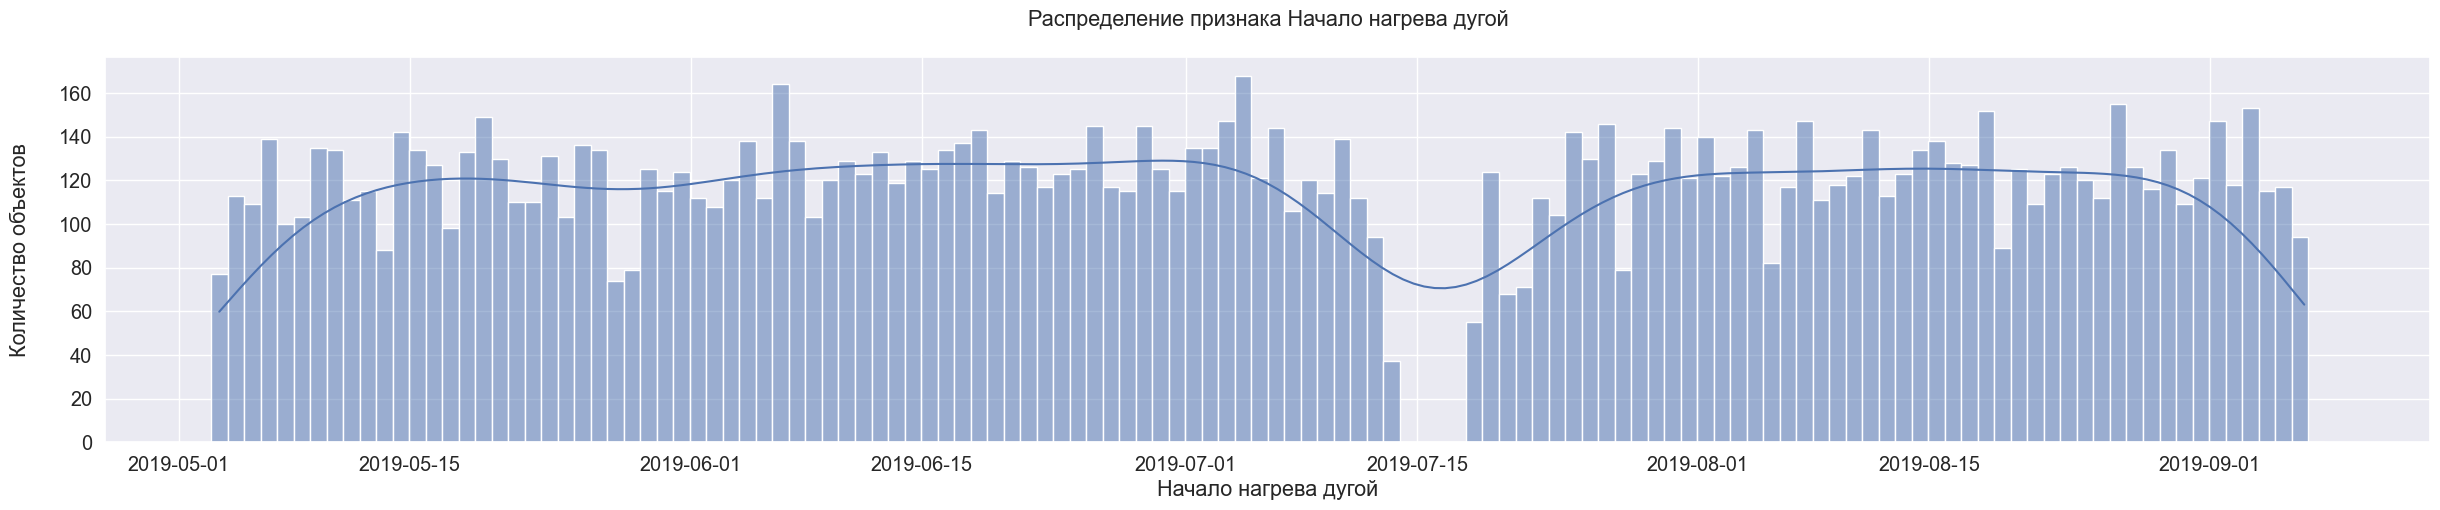

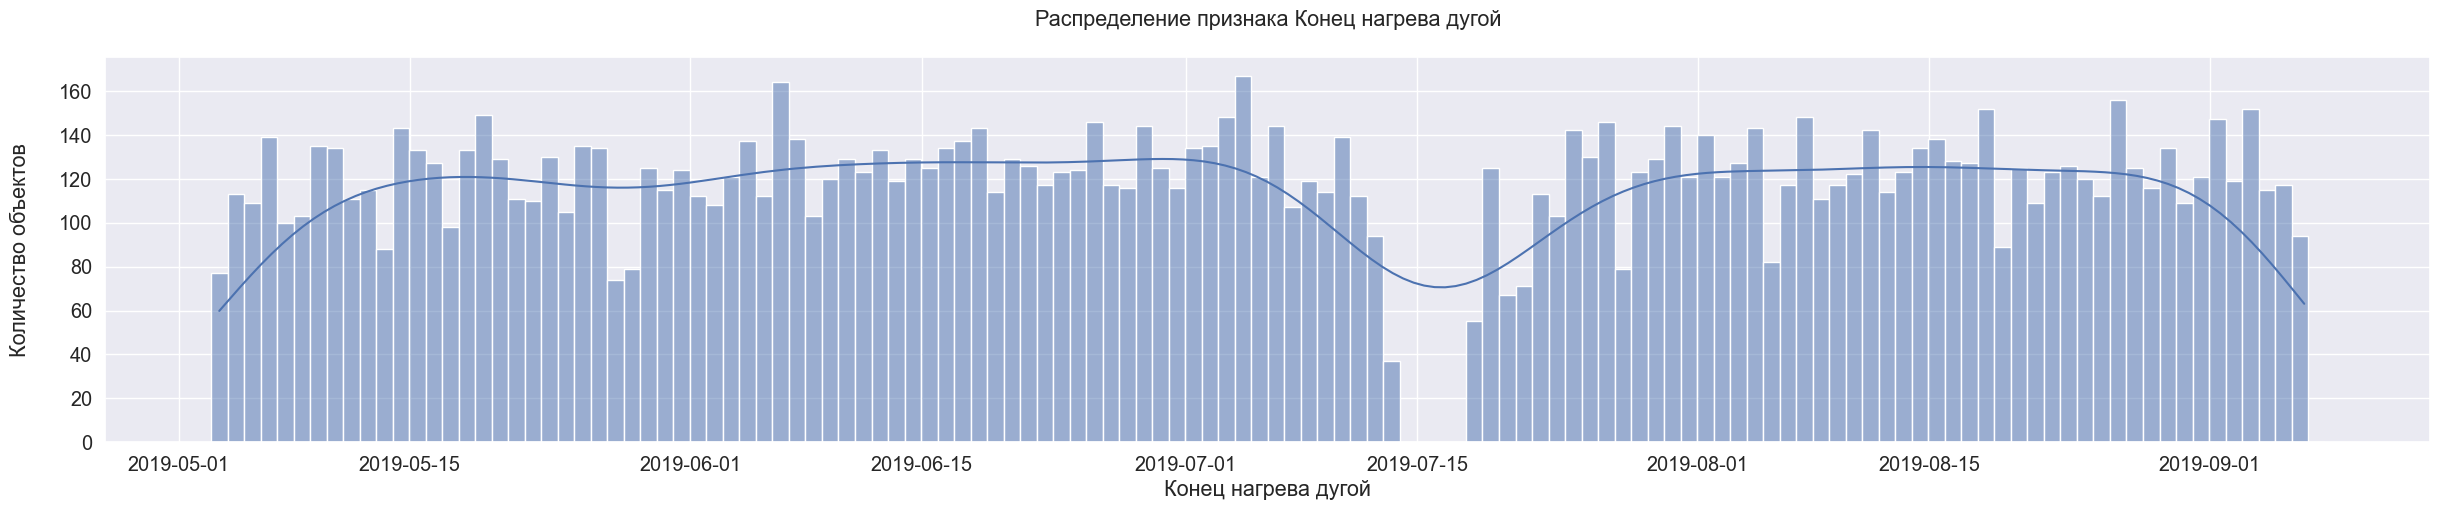

In [26]:
for col in time_df.columns:
    dist_and_box(time_df, col, time=True)

На графиках заметен явный провал значений в июле, рассмотрим его подробнее.

In [27]:
data_arc['Начало нагрева дугой'].dt.day[data_arc['Начало нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64)

Наблюдается резкий спад 13 июля и полное отсутствие данных за 14-17 июля. Возможно, имела место авария или произошел сбой во время сбора данных.

In [28]:
data_arc['Конец нагрева дугой'].dt.day[data_arc['Конец нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64)

Здесь ситуация аналогичная.

Далее оценим распределения в колонках с числовыми значениями.

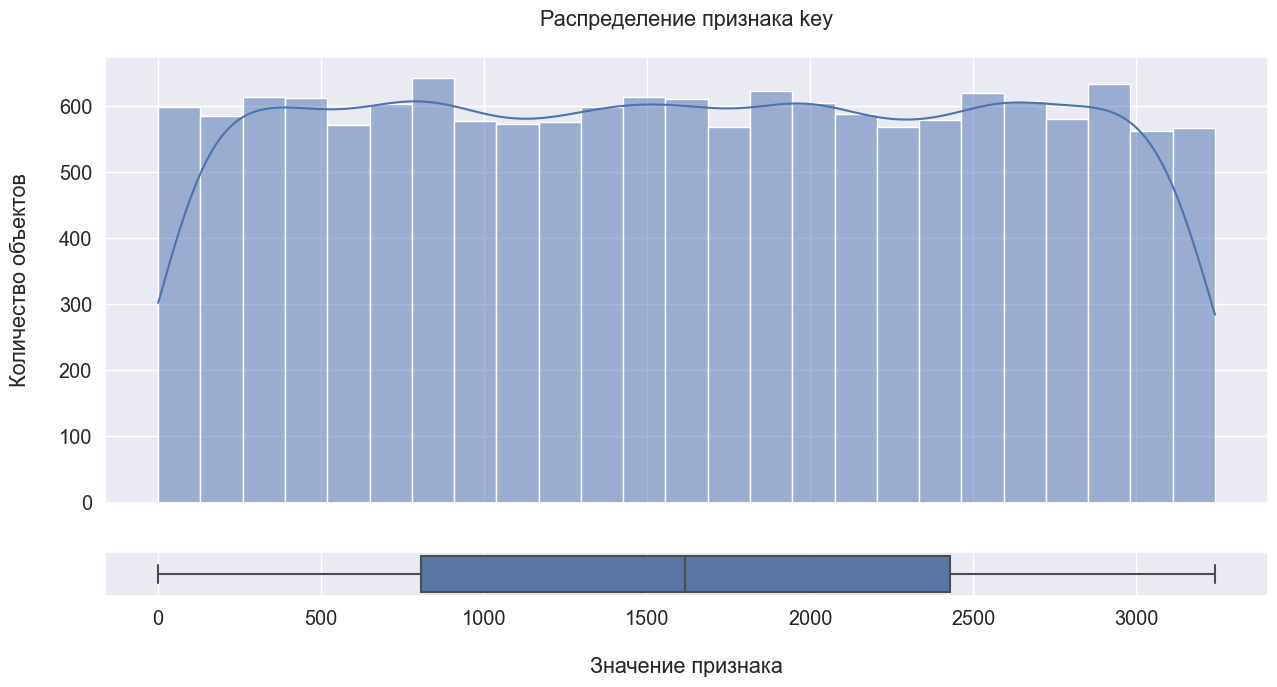

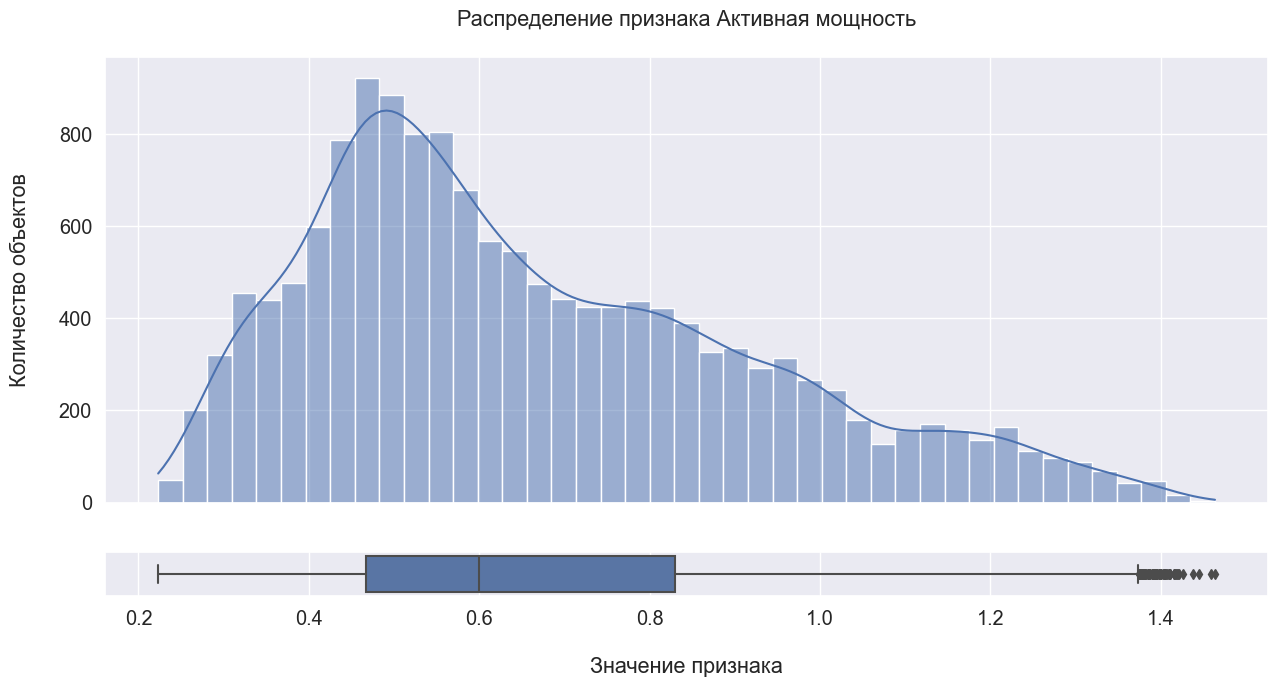

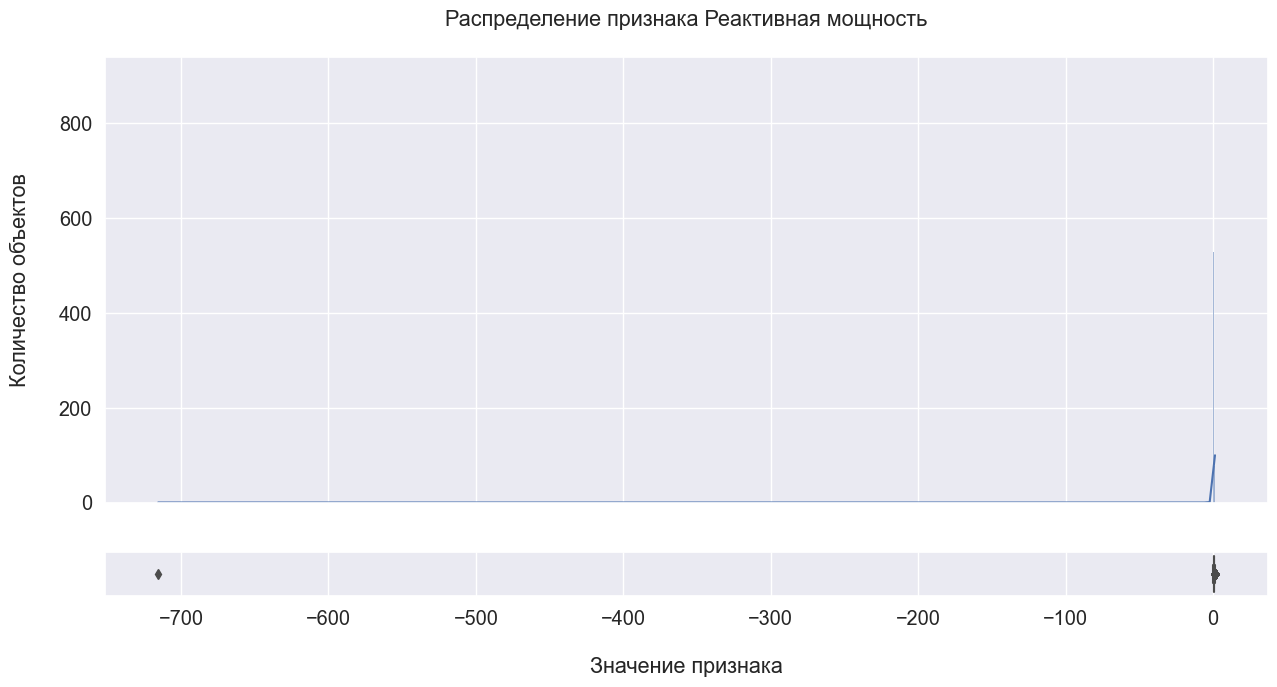

In [29]:
for col in num_df.columns:
    dist_and_box(num_df, col)

Так как распределение по признаку `Реактивная мощность` сильно смещено неким одиночным выбросом, то рассмотрим строки, в которых `Реактивная мощность` меньше нуля.

In [30]:
data_arc[data_arc['Реактивная мощность'] <= 0]

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08 2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

Поскольку мощность не может иметь отрицательных значений, и строка с таким значением всего одна, то просто удалим ее.

In [31]:
data_arc = data_arc.drop(data_arc[data_arc['Реактивная мощность'] <= 0].index).reset_index(drop=True)

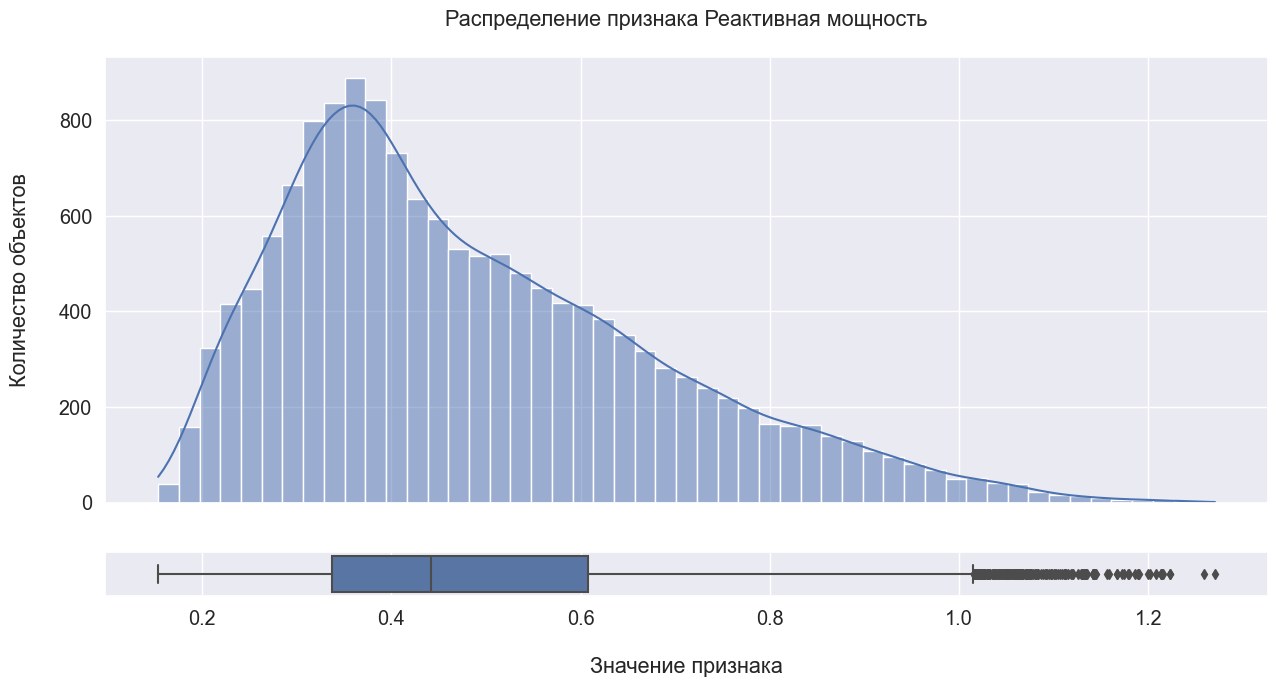

In [32]:
dist_and_box(data_arc, 'Реактивная мощность')

In [33]:
data_arc.describe()

key  Активная мощность  Реактивная мощность
count  14875.000000       14875.000000         14875.000000
mean    1615.186756           0.662749             0.487115
std      934.593897           0.258894             0.197612
min        1.000000           0.223120             0.153777
25%      806.000000           0.467115             0.337190
50%     1617.000000           0.599578             0.441665
75%     2429.000000           0.830135             0.608223
max     3241.000000           1.463773             1.270284

Посмотрим распределение количества нагревов по партиям.

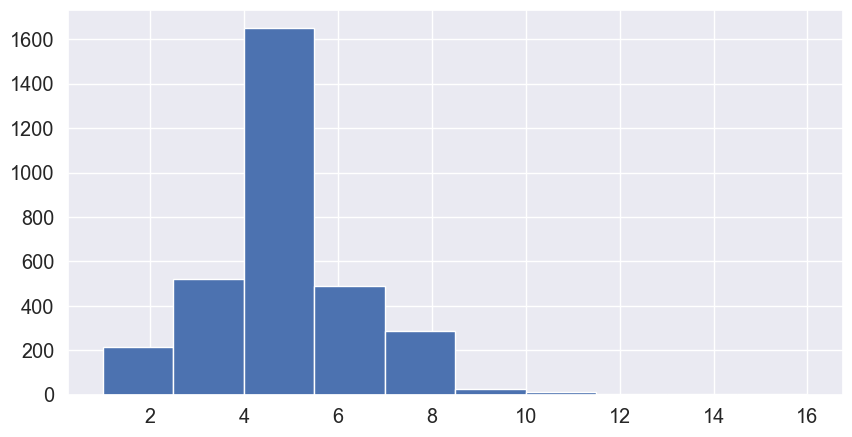

In [34]:
data_arc['key'].value_counts().hist(figsize=(10, 5));

Проверим корреляцию признаков `Активная мощность` и `Реактивная мощность` с помощью диаграммы рассеяния.

Корреляция Активной и Реактивной мощности 0.9663734456187295


<Figure size 2500x1200 with 0 Axes>

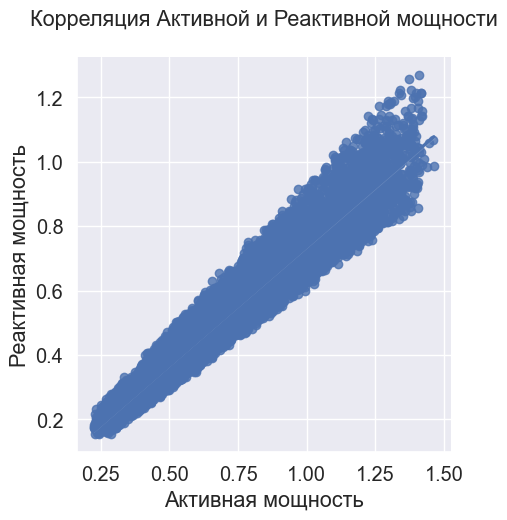

In [35]:
print('Корреляция Активной и Реактивной мощности', data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))

plt.figure(figsize=(25, 12))
sns.lmplot(x='Активная мощность', y='Реактивная мощность', data=data_arc)
plt.title('Корреляция Активной и Реактивной мощности\n')
plt.show();

**Выводы**

Распределения мощностей имеют колоколообразное распределение со сдвигом влево. 

В столбце `Активна мощность` имеются выбросы в виде значений больше 1.4.

Единичное отрицательное значение по признаку `Реактивная мощность` было удалено как аномалия.

Средняя `Активная мощность` в районе 0.66 со стандартным отклонением 0.258, принимает значения от 0.22 до 1.46 с медианой в 0.599.

Средняя `Реактивная мощность` характеризуется значением 0.48 со стандартным отклонением 0.197, принимает значения от 0.15 до 1.27 с медианой в 0.441.

Количество нагревов варьируется от 1 до 16.

Заметна сильная корреляция между активной и реактивной мощностью, они практически линейно-зависимы (это нормальное явление, так как активная и реактивная нагрузка находятся в одной электрической цепи и через них проходит один и тот же электрический ток). Однако, это означает, что наши модели будут склонны к переобучению. Для решения этой проблемы можно в дальнейшем преобразовать признаки в один общий, `Полная мощность`.

### 2.2. Работа с данными об объемах подачи сыпучих материалов (`data_bulk`).

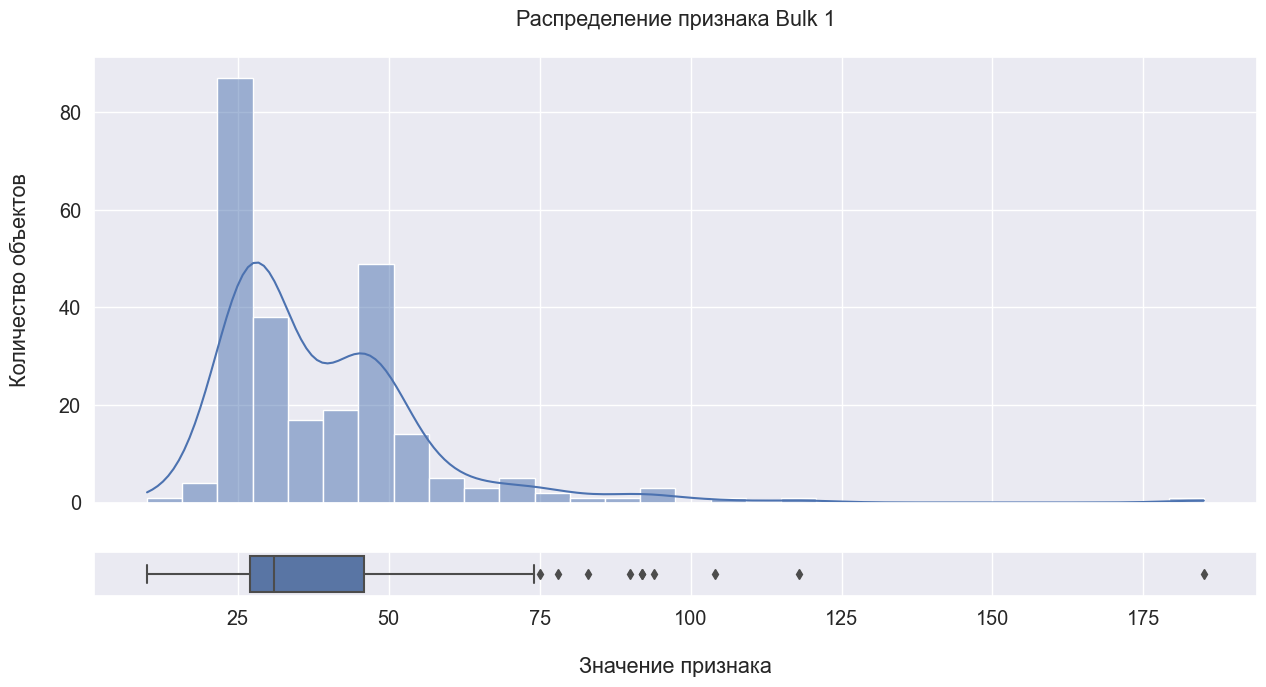

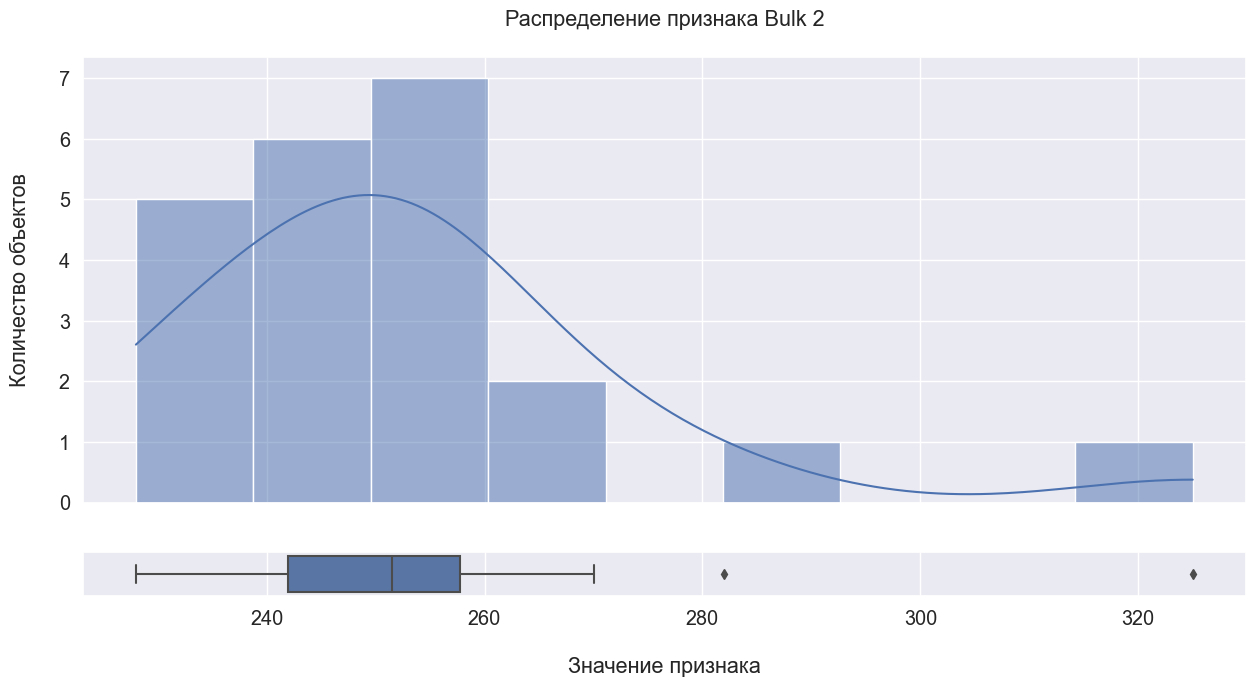

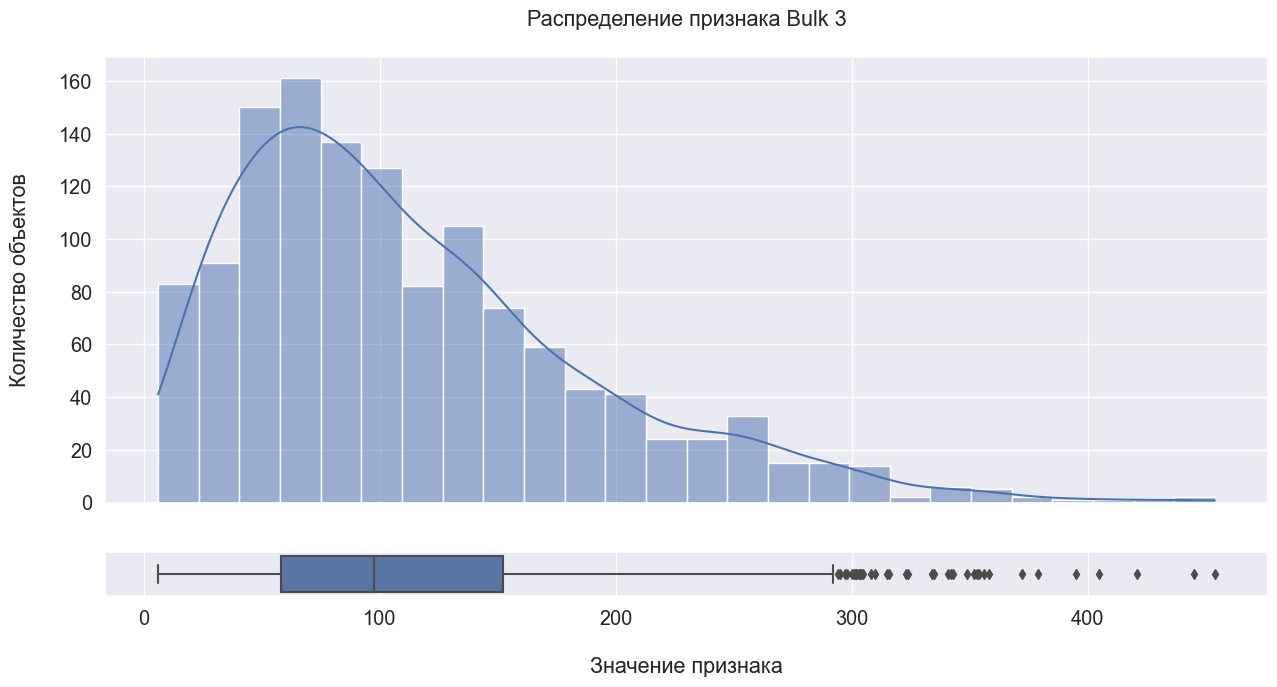

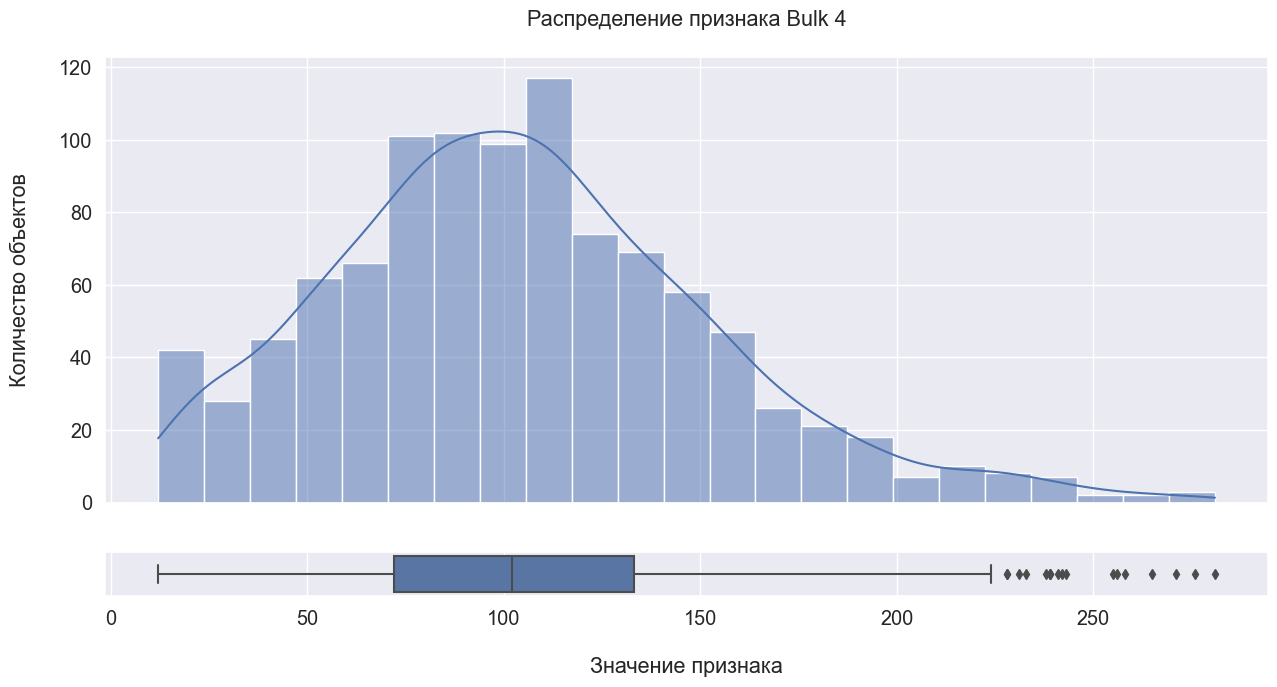

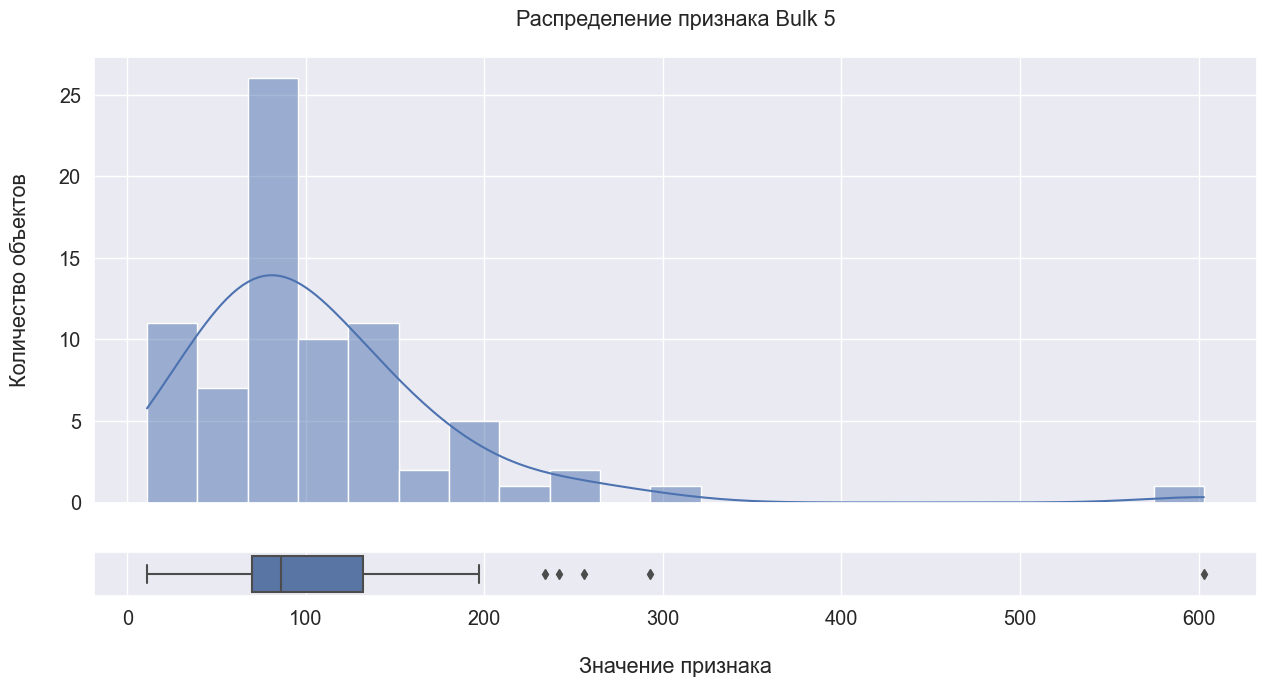

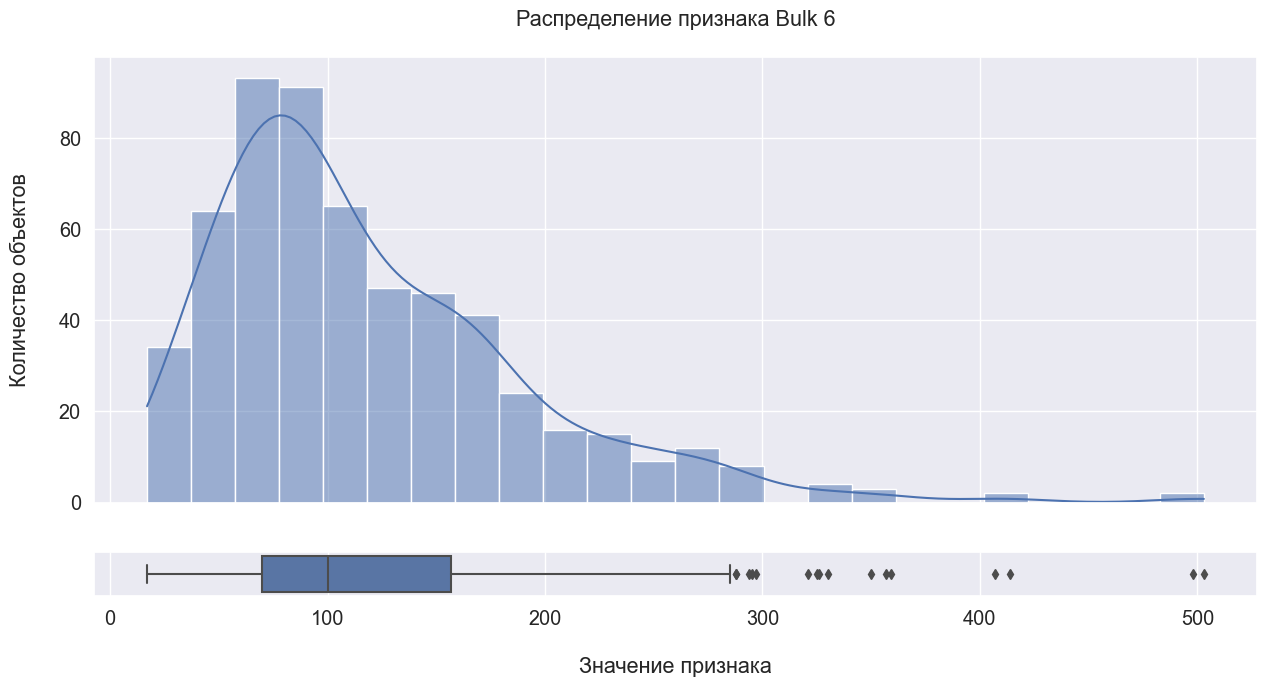

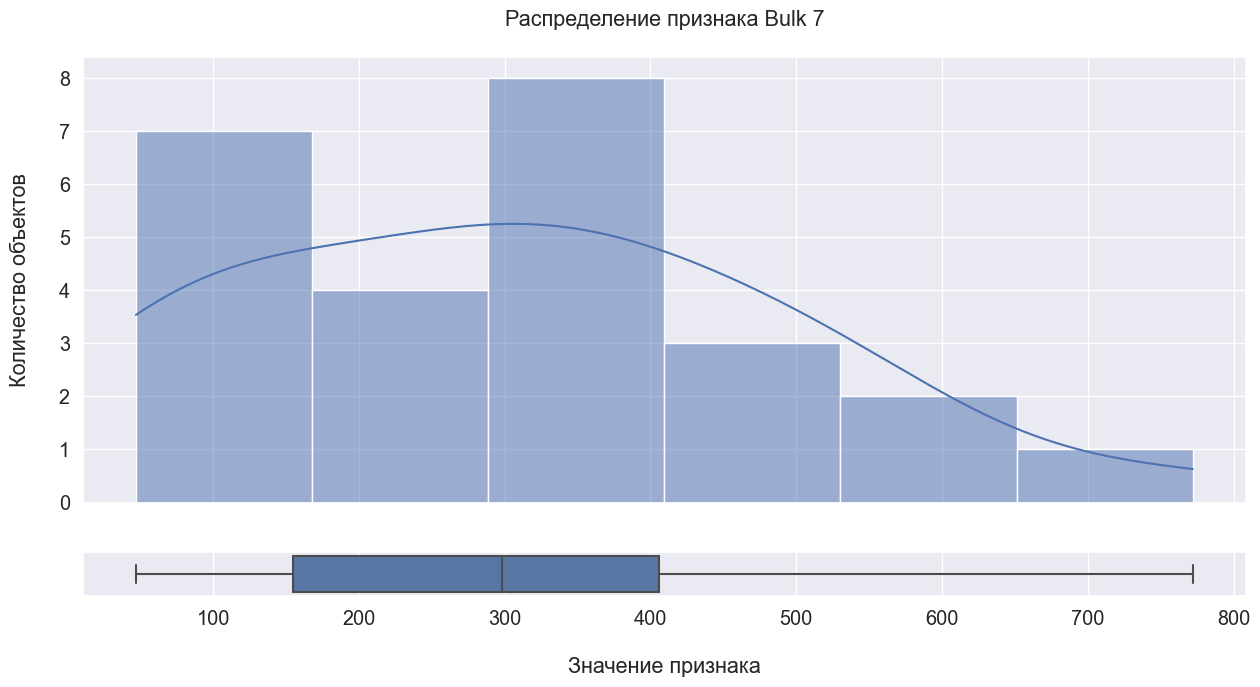

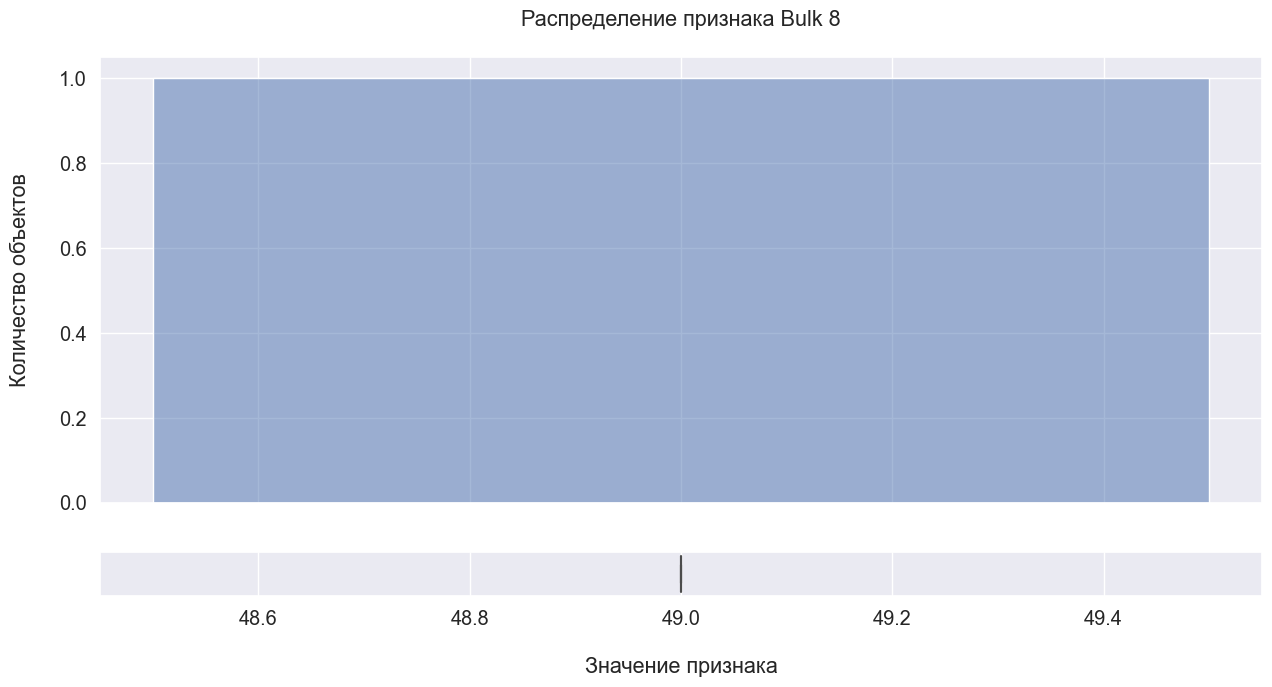

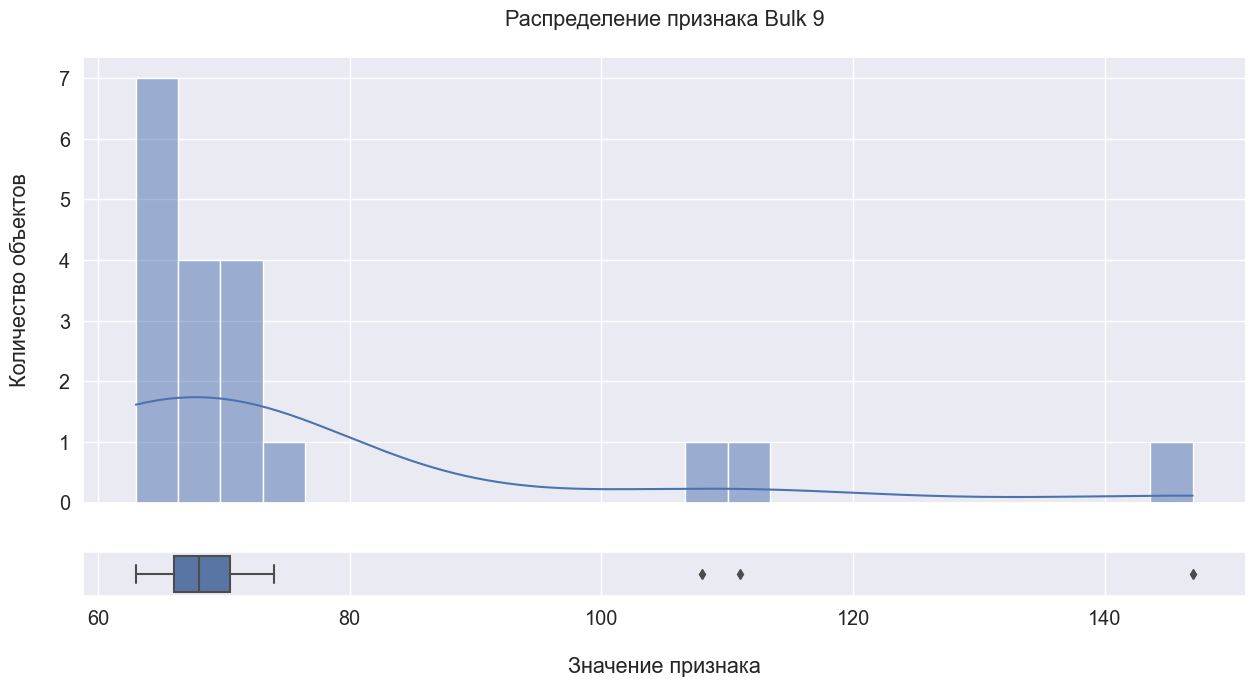

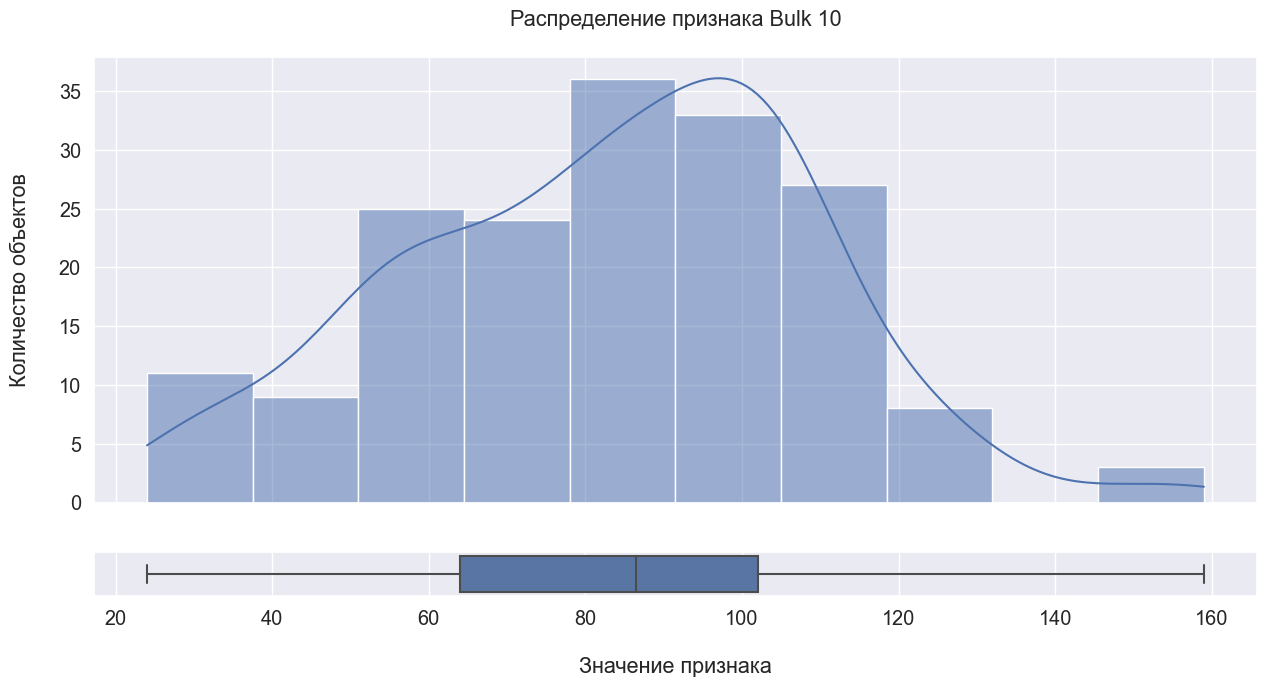

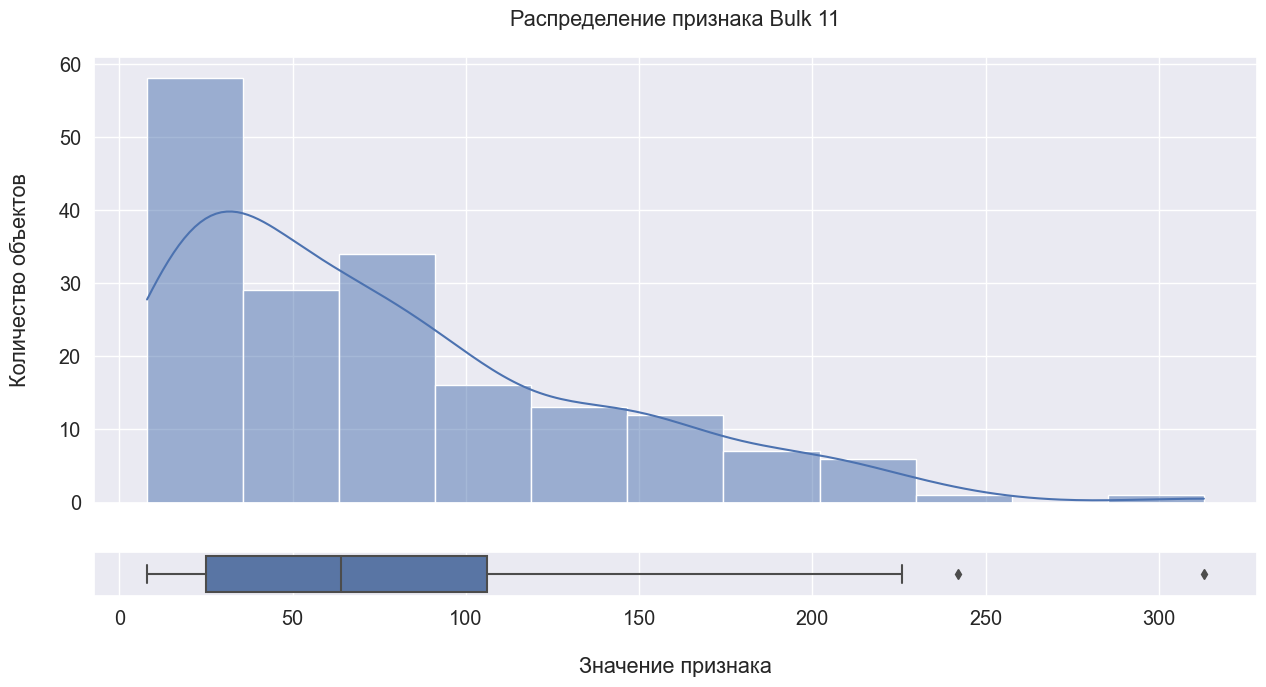

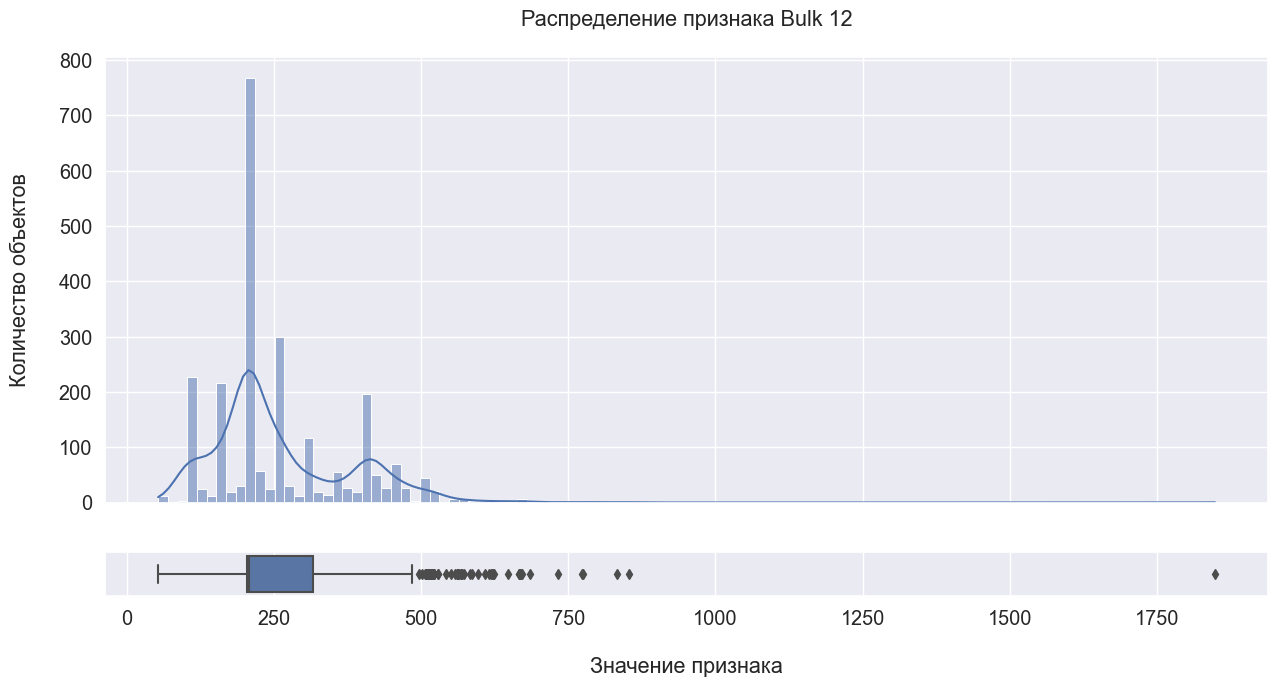

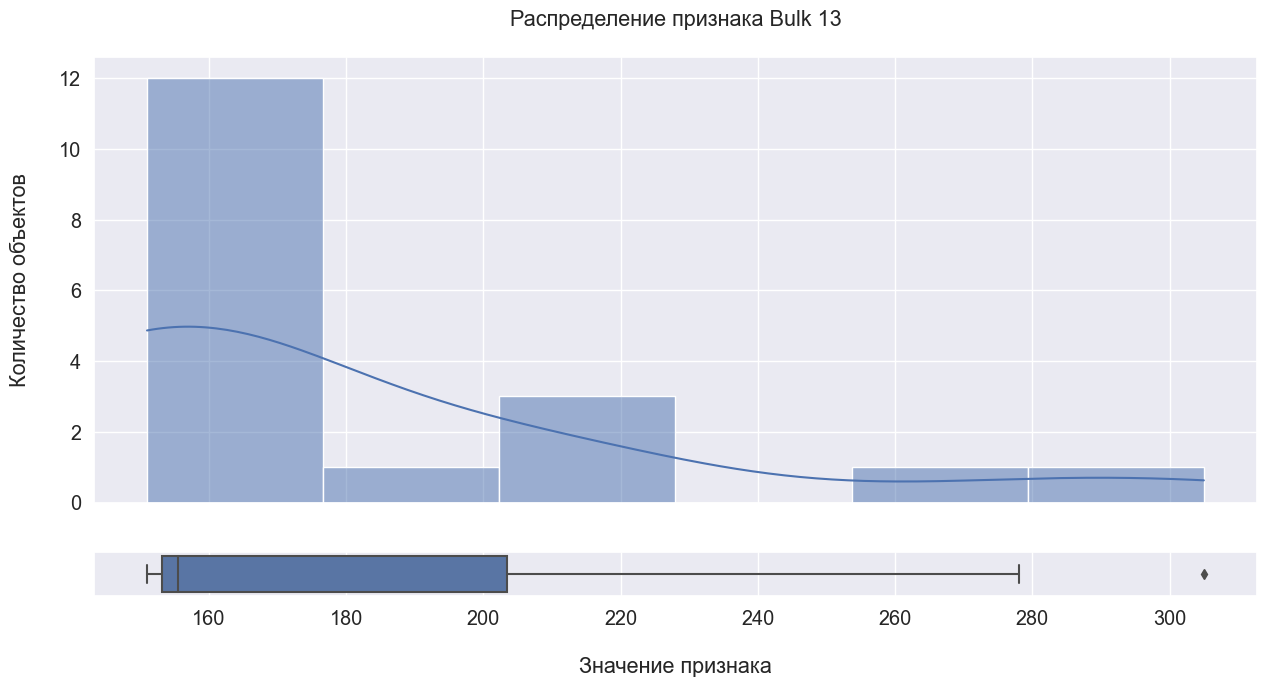

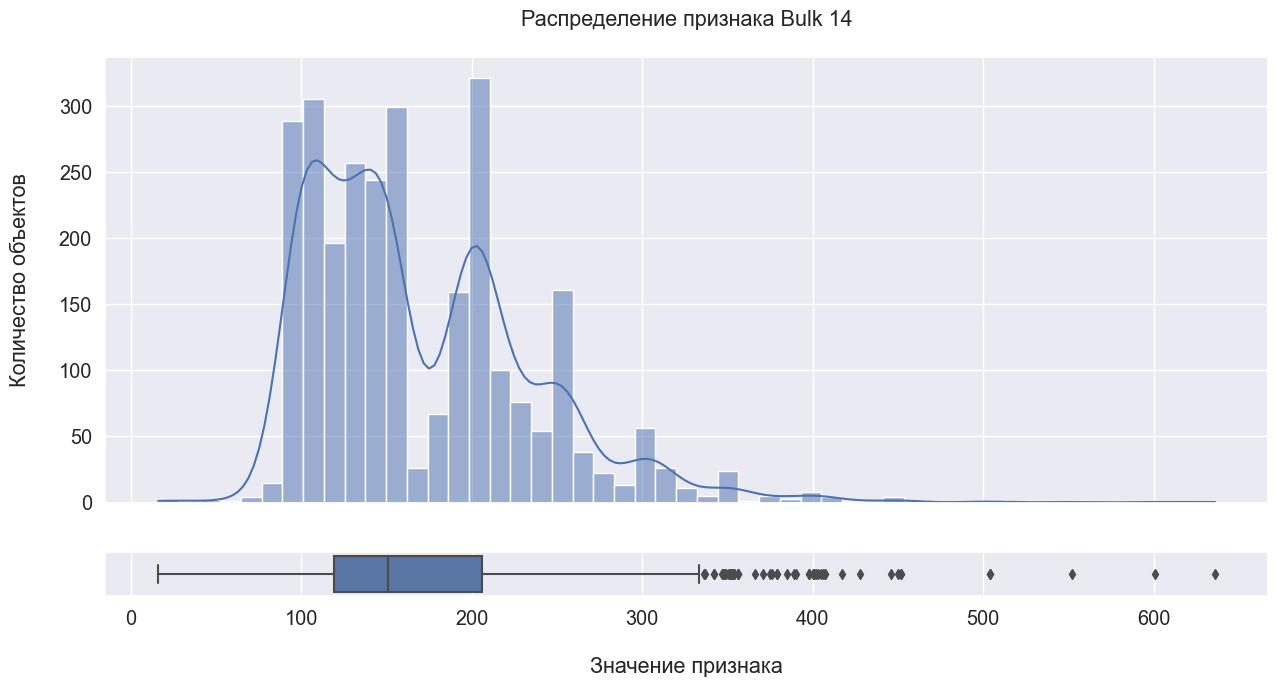

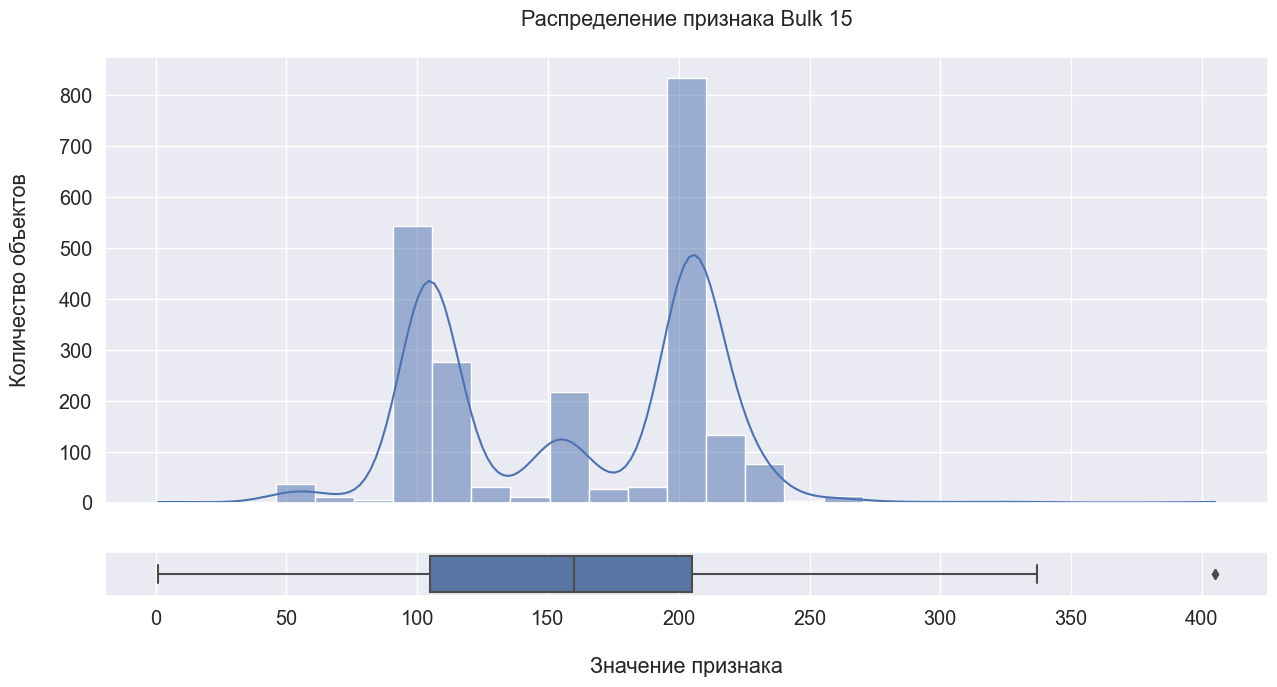

In [36]:
for col in data_bulk.columns[1:]:
    dist_and_box(data_bulk, col)

In [37]:
data_bulk.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

**Выводы**

Гистограммы указывают на то, что сыпучие материалы добавляются в разных объемах:

- меньше всего в среднем добавляют `Bulk 1`, больше всего в среднем - `Bulk 7`;
- чаще всего добавляют `Bulk 14`, и только 1 раз добавили `Bulk 8`. 
- почти на каждой гистограмме можно увидеть, что за 1 раз добавляется определенный объем легирующих добавок, так как столбцы гистограмм одинакового размера, особенно хорошо это заметно на `Bulk 10` и `Bulk 11`.

То есть разные сыпучие материалы (легирующие добавки) по-разному действуют на металл, а `Bulk 14` либо крайне редко использующаяся легирующая добавка, либо крайне дорогая, либо и то, и то.

### 2.3. Работа с данными о времени подачи сыпучих материалов (`data_bulk_time`).

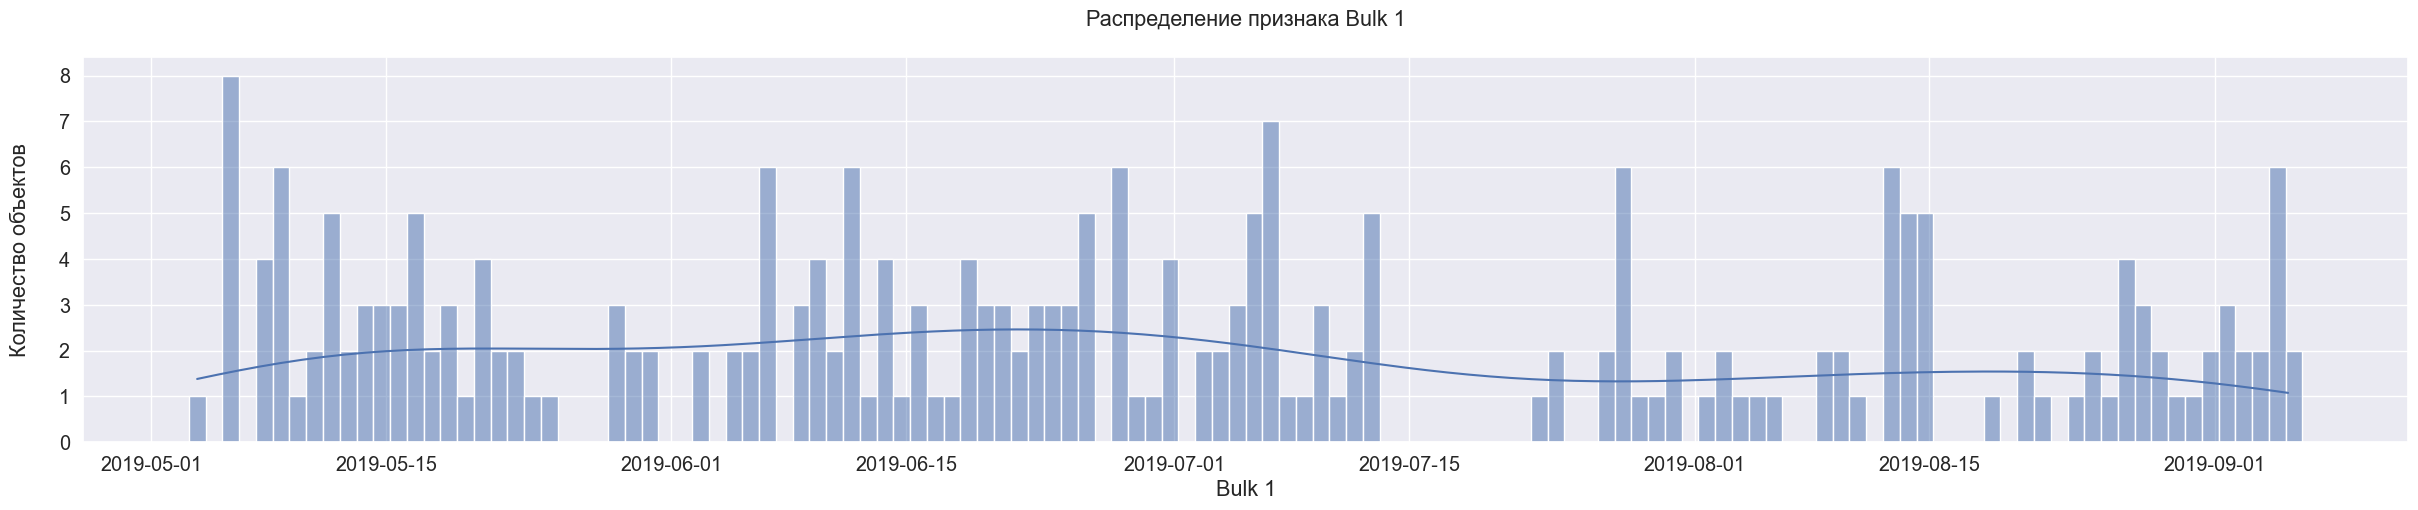

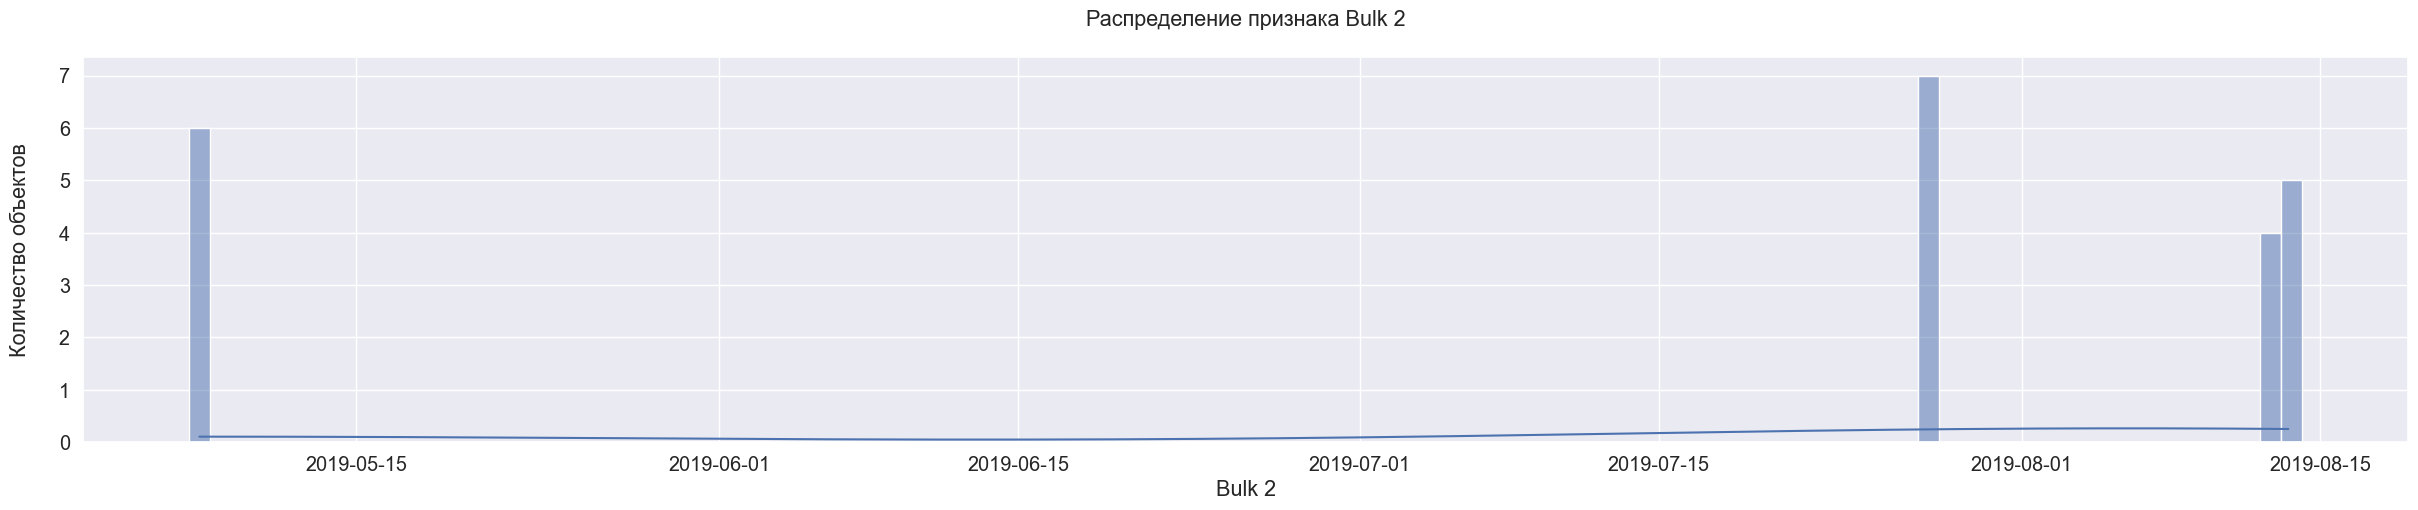

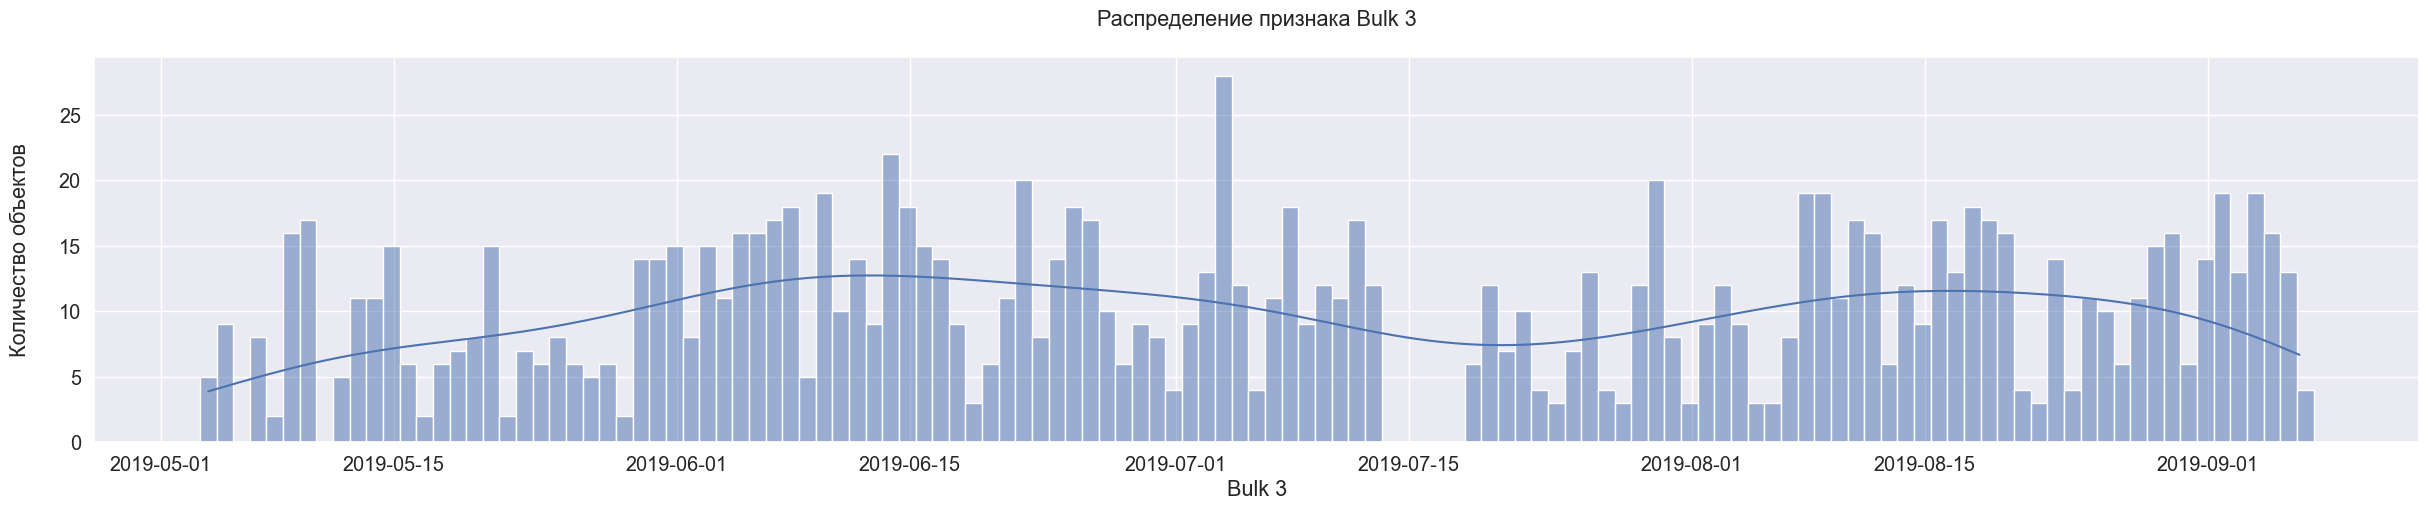

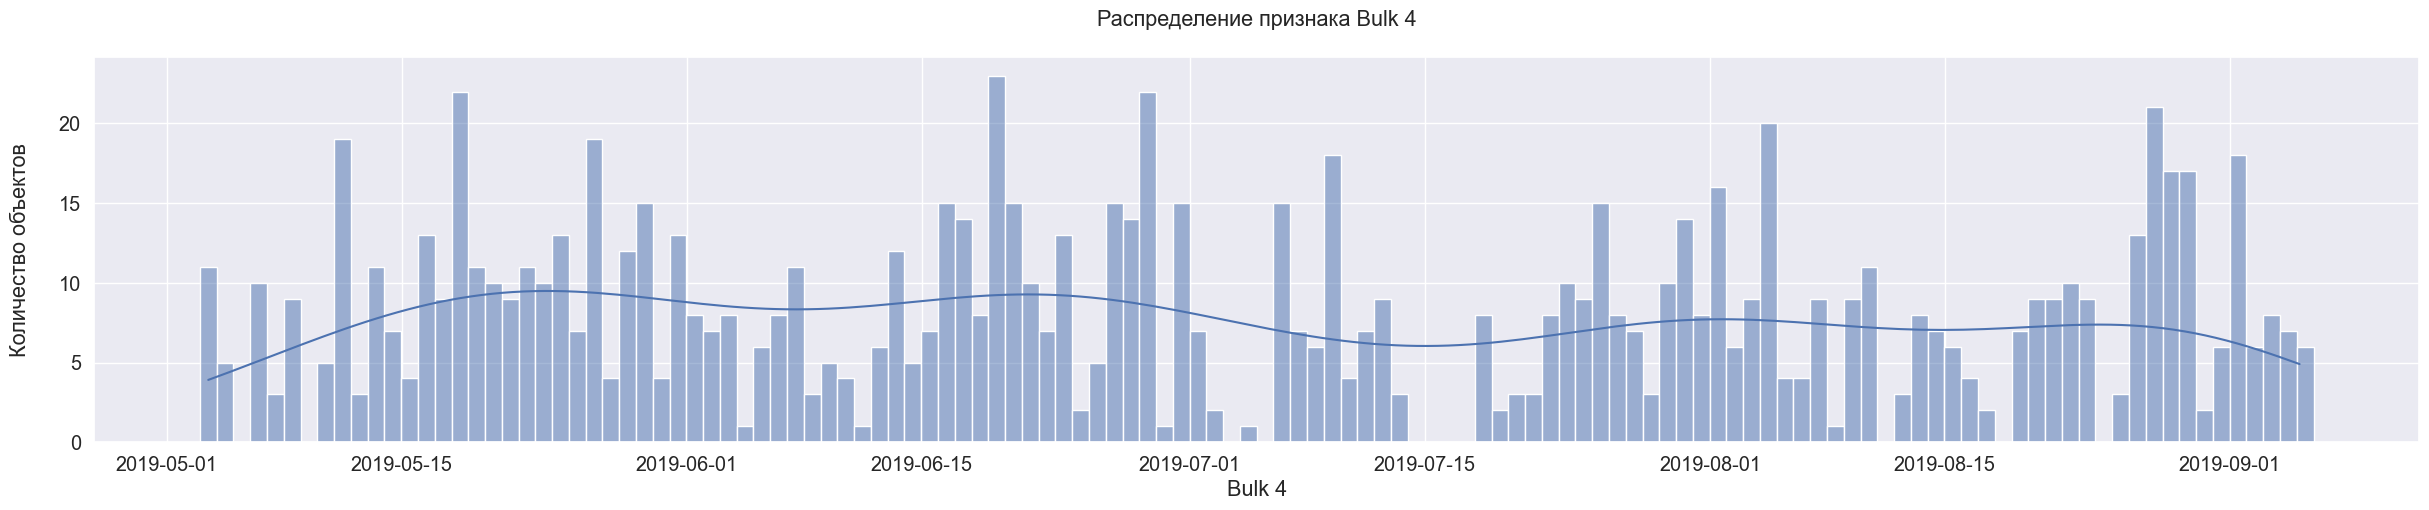

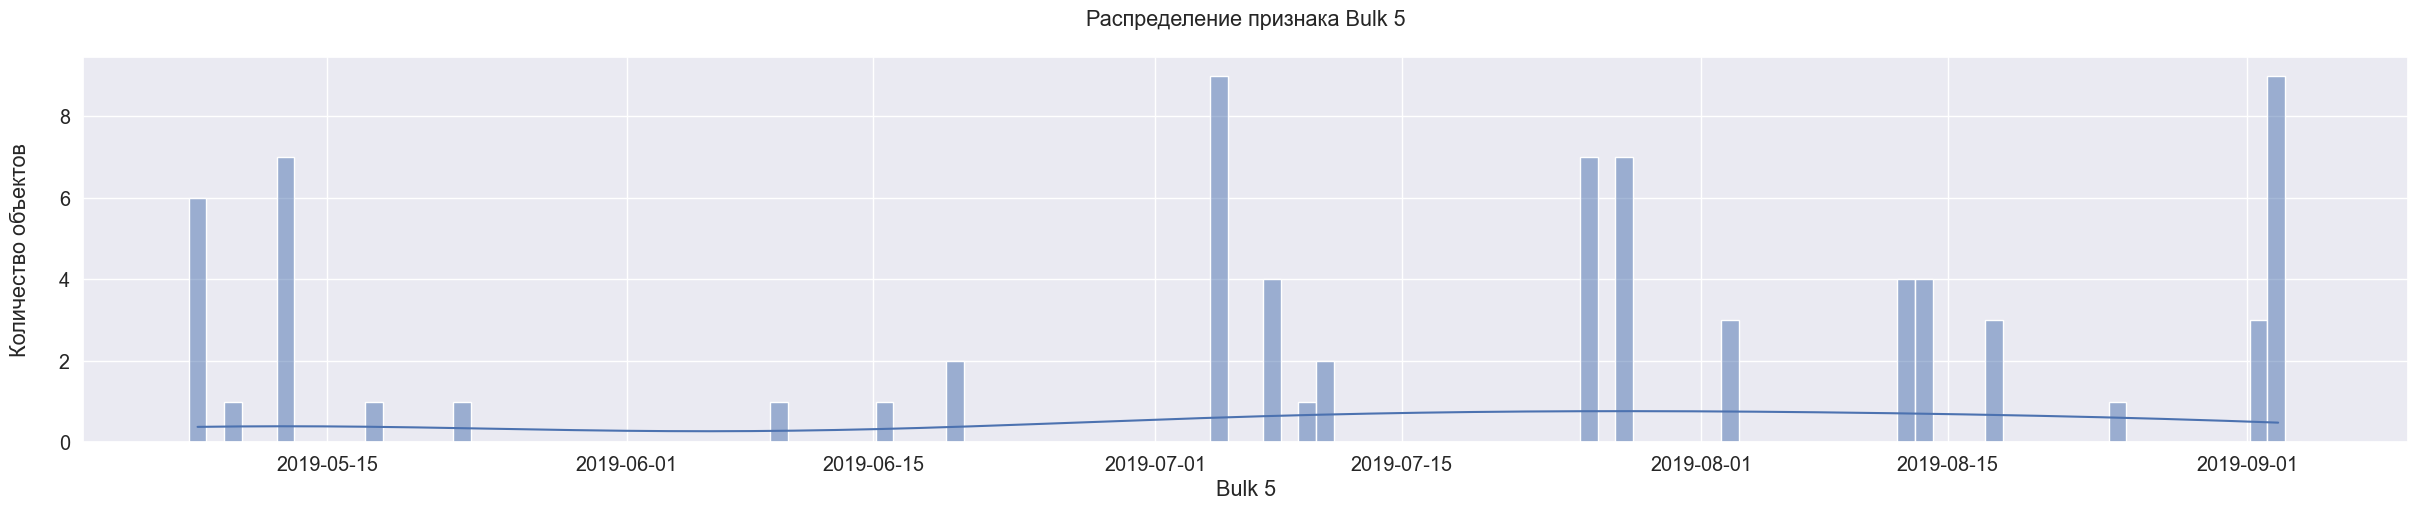

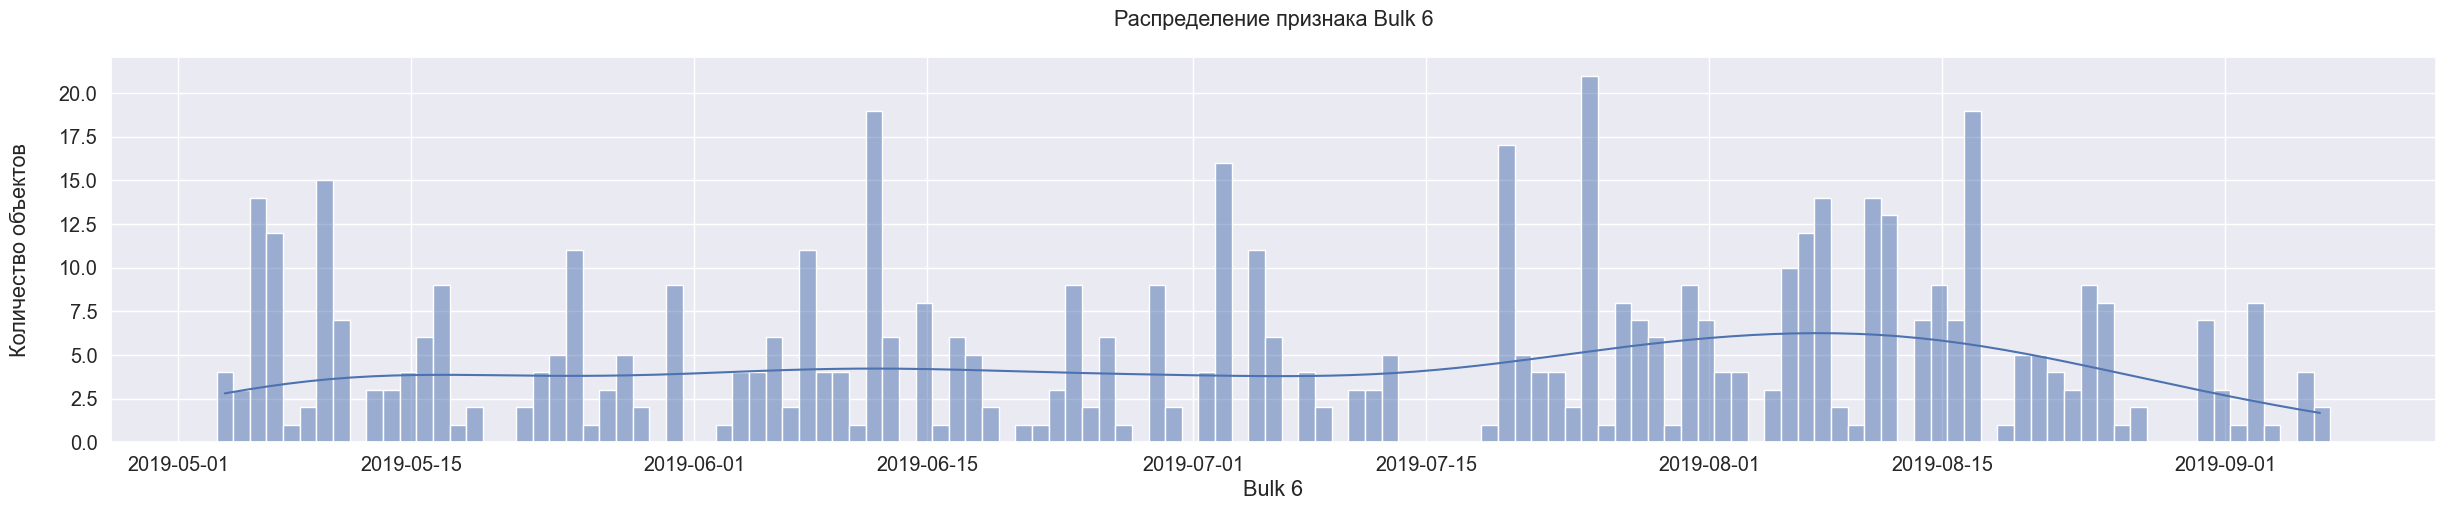

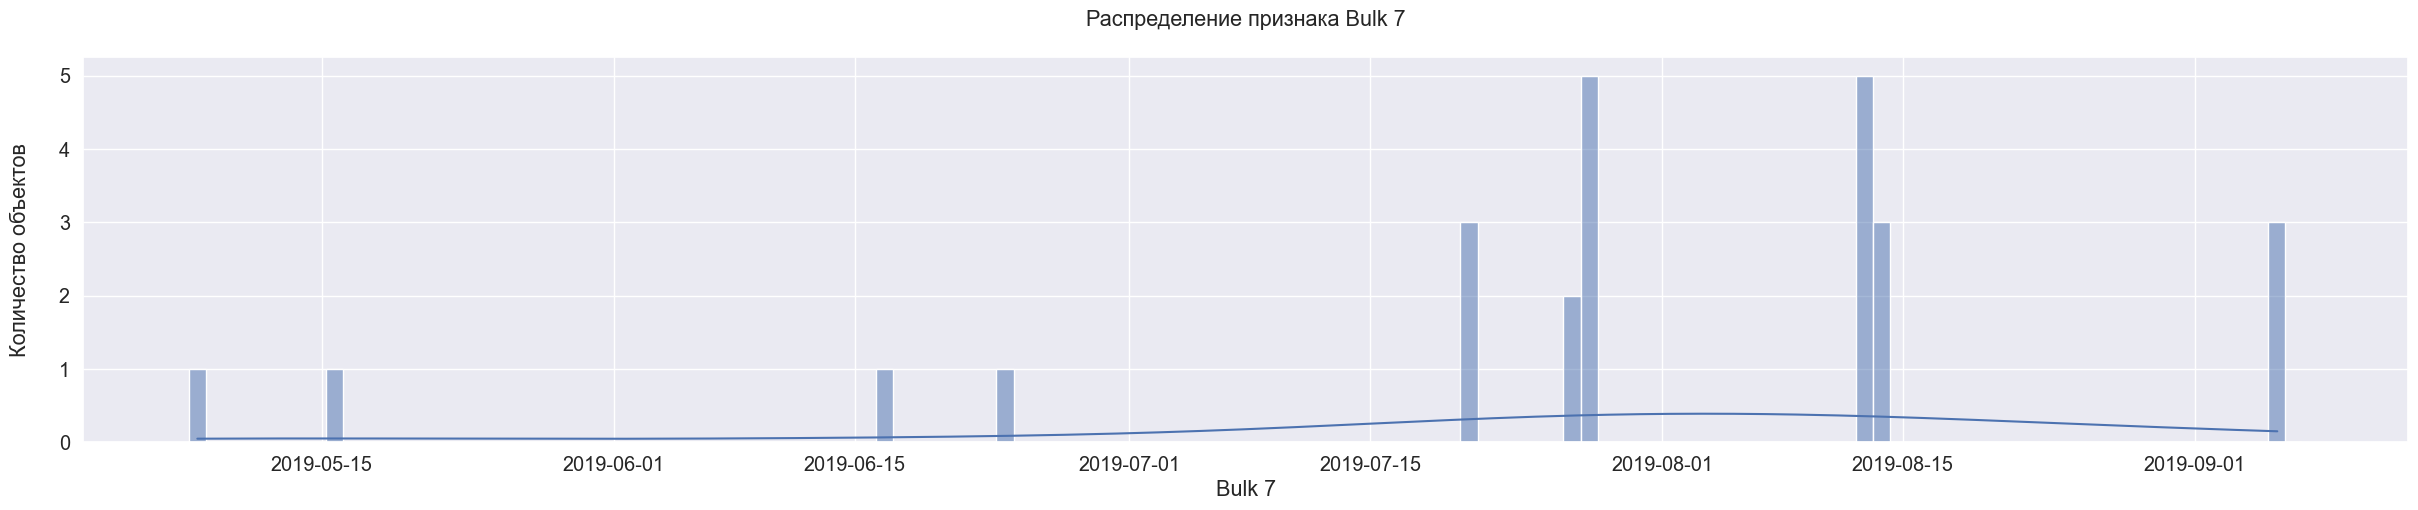

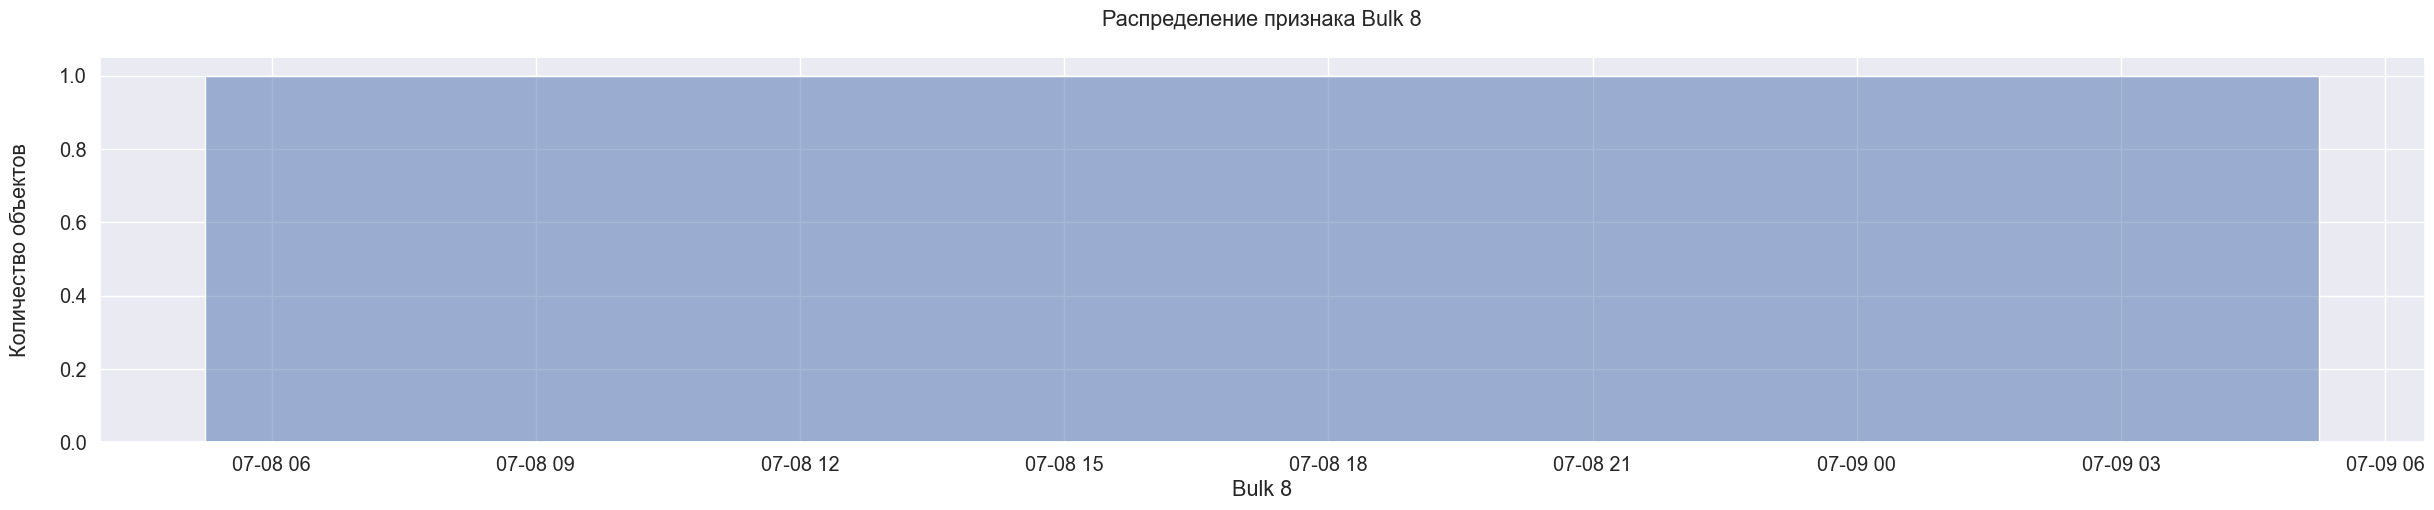

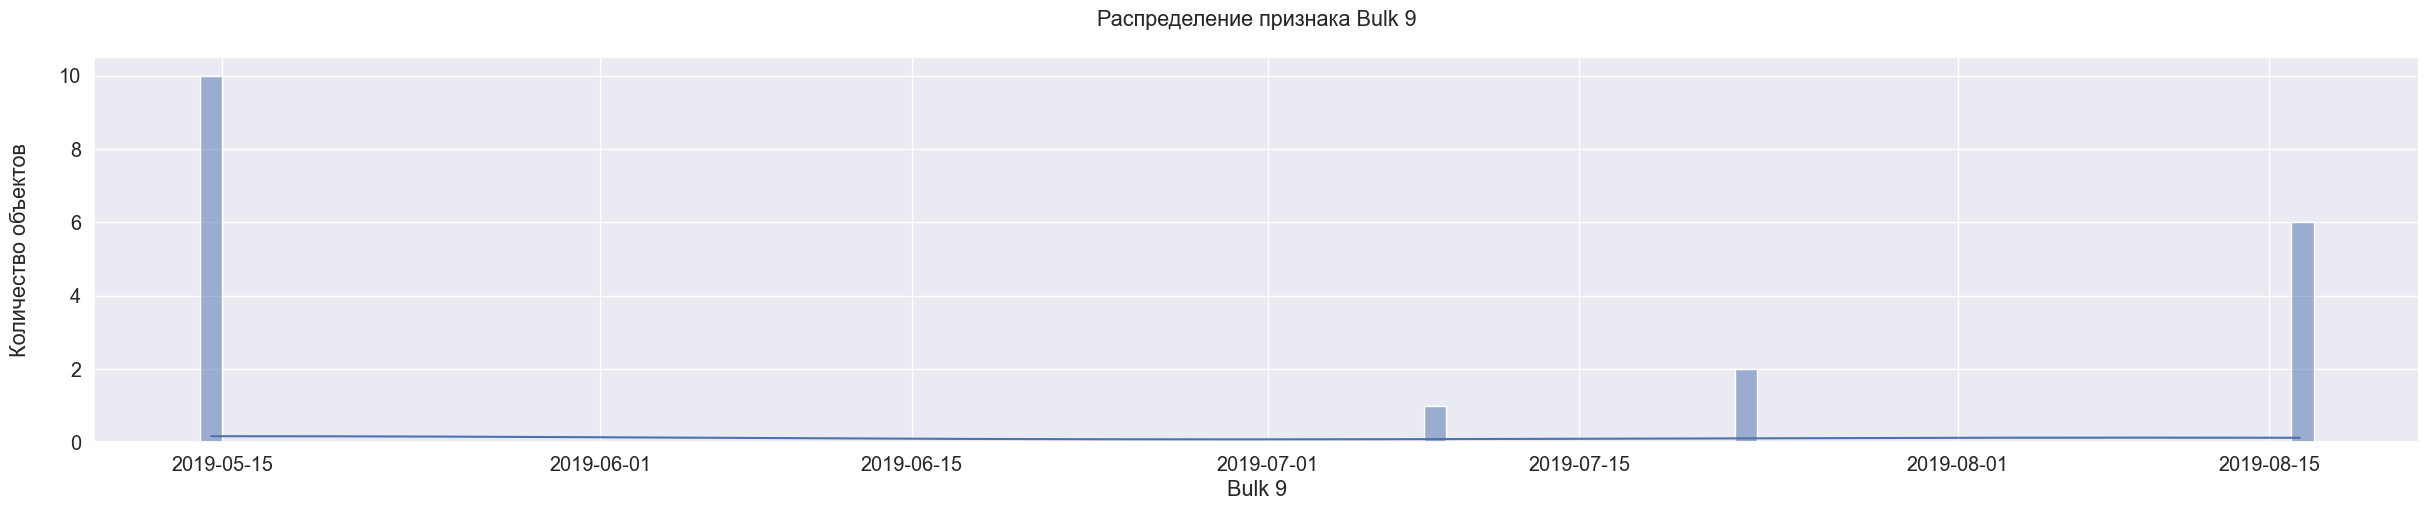

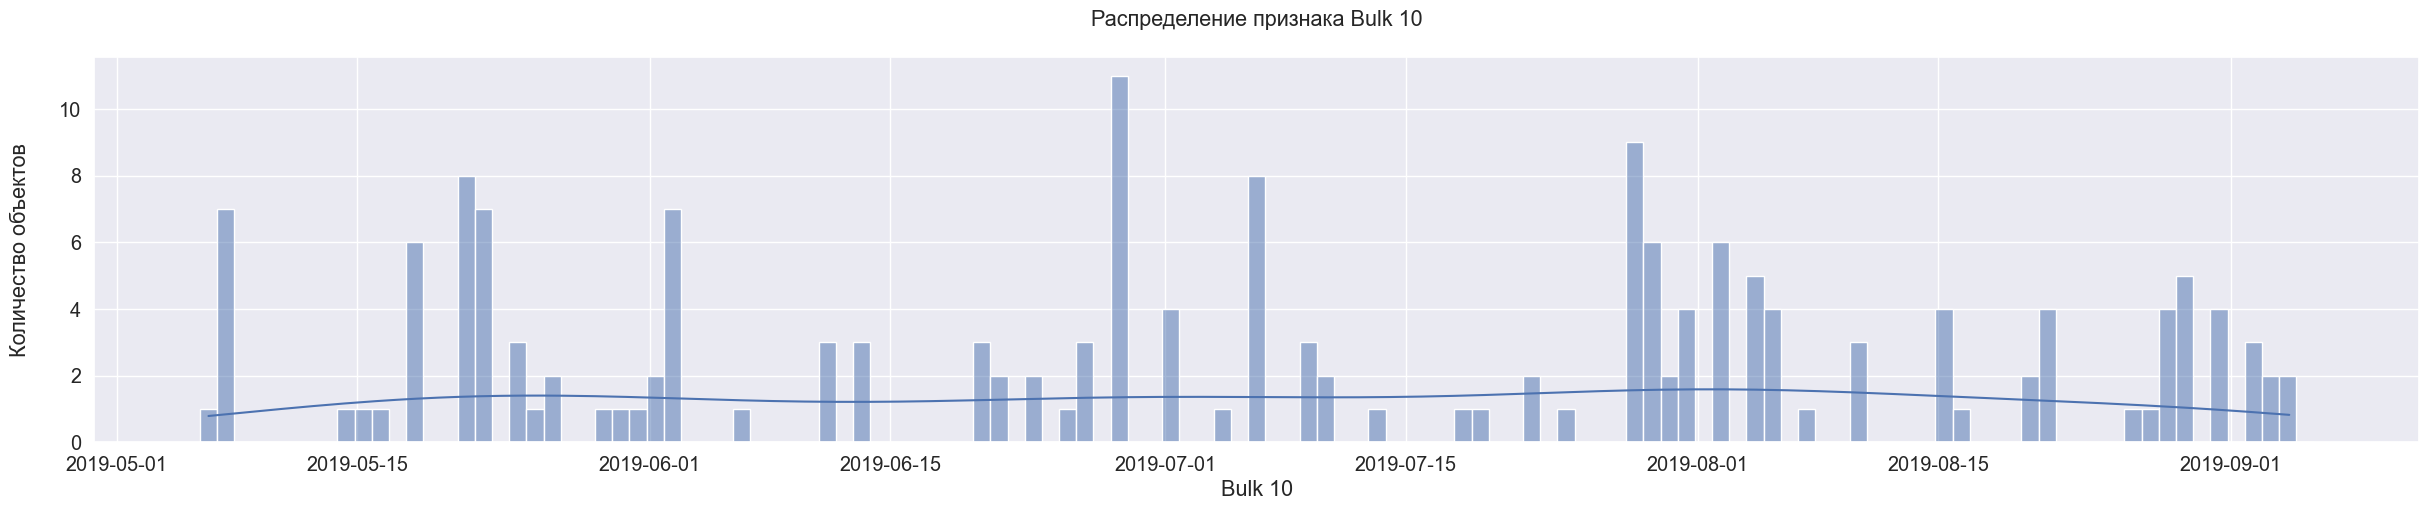

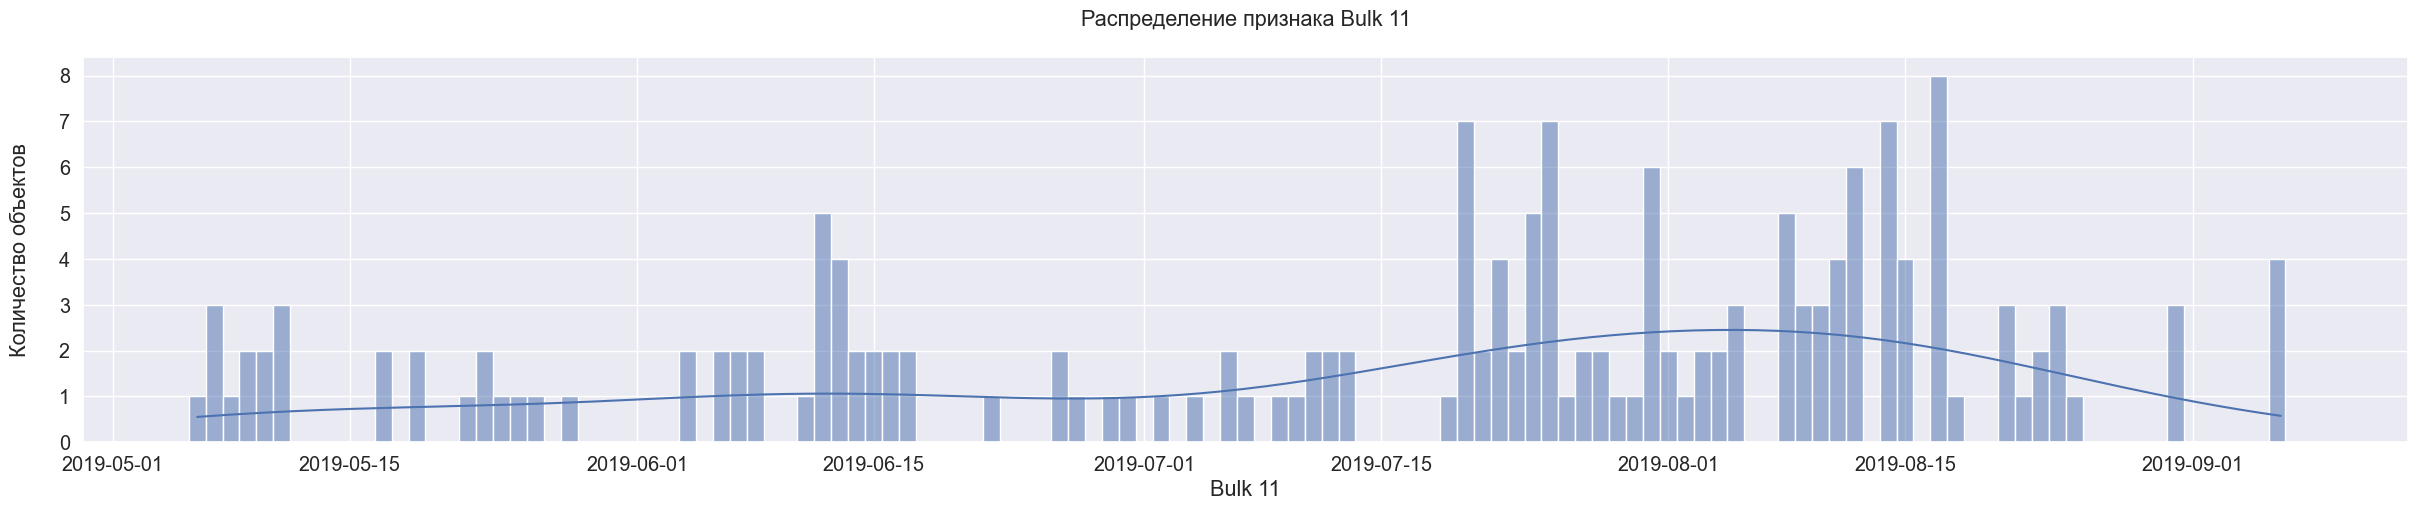

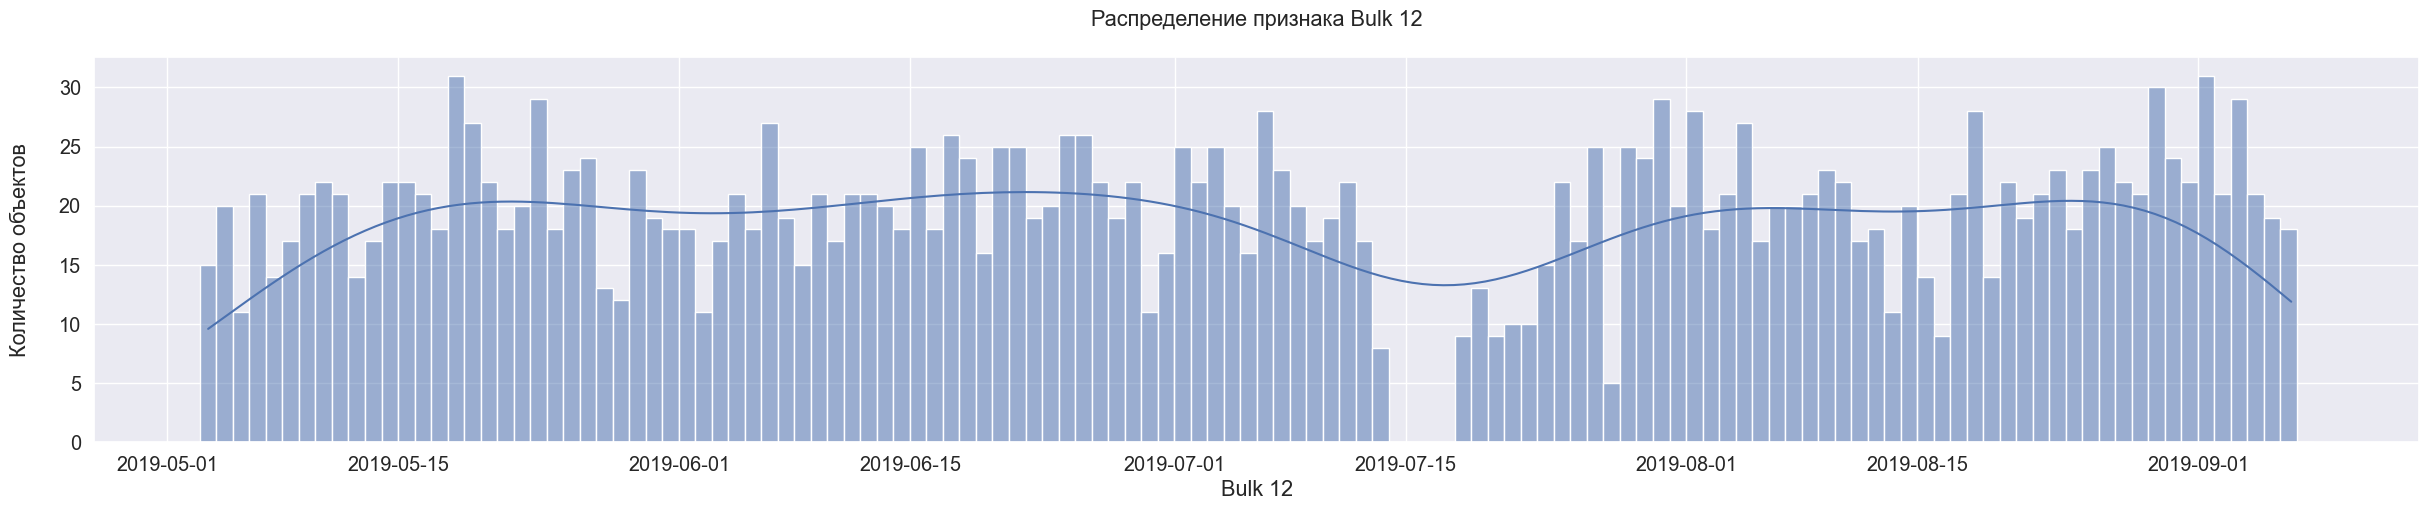

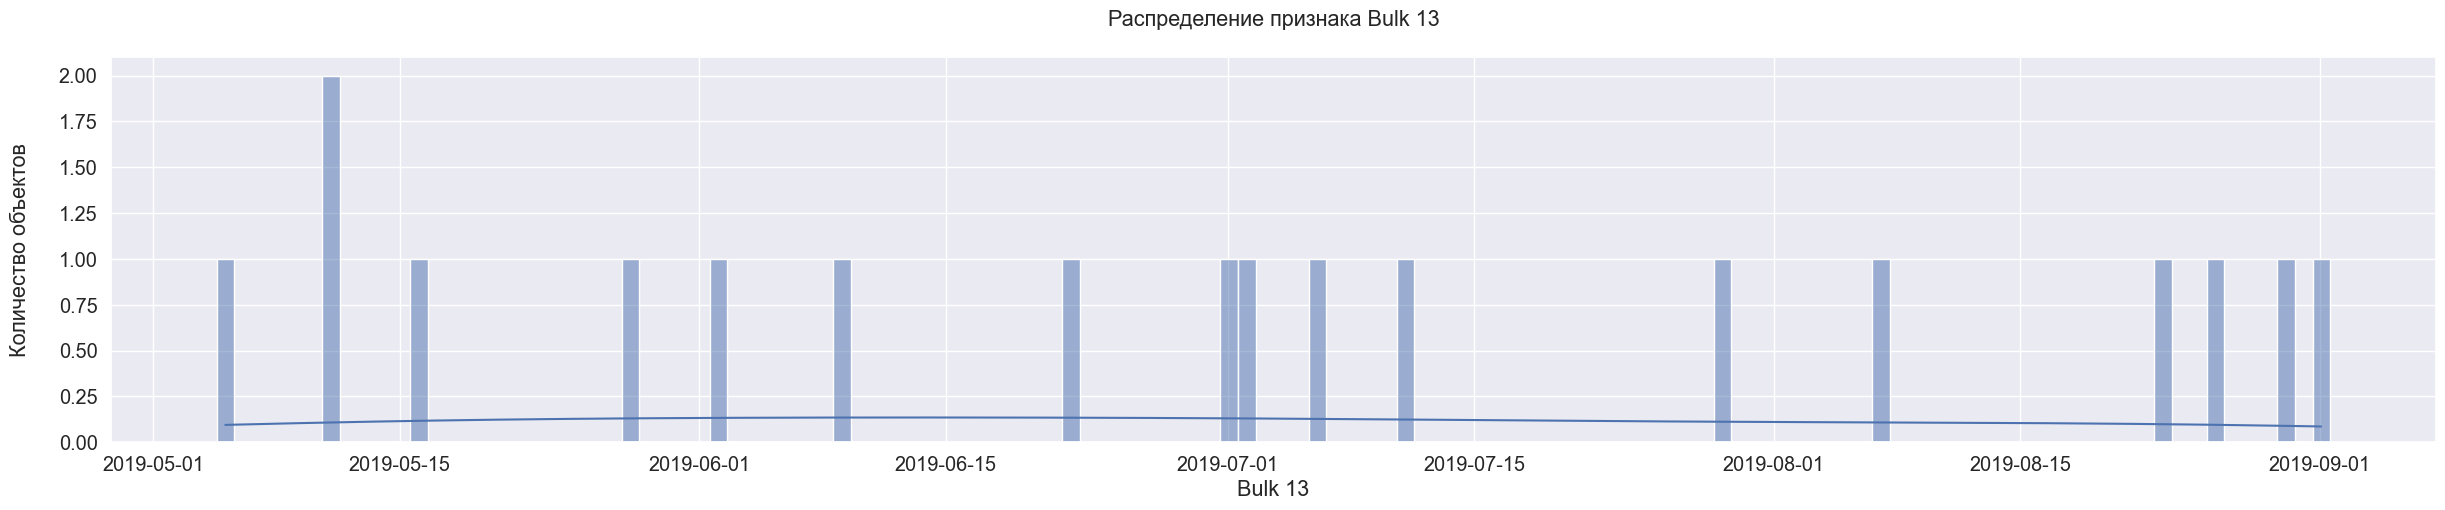

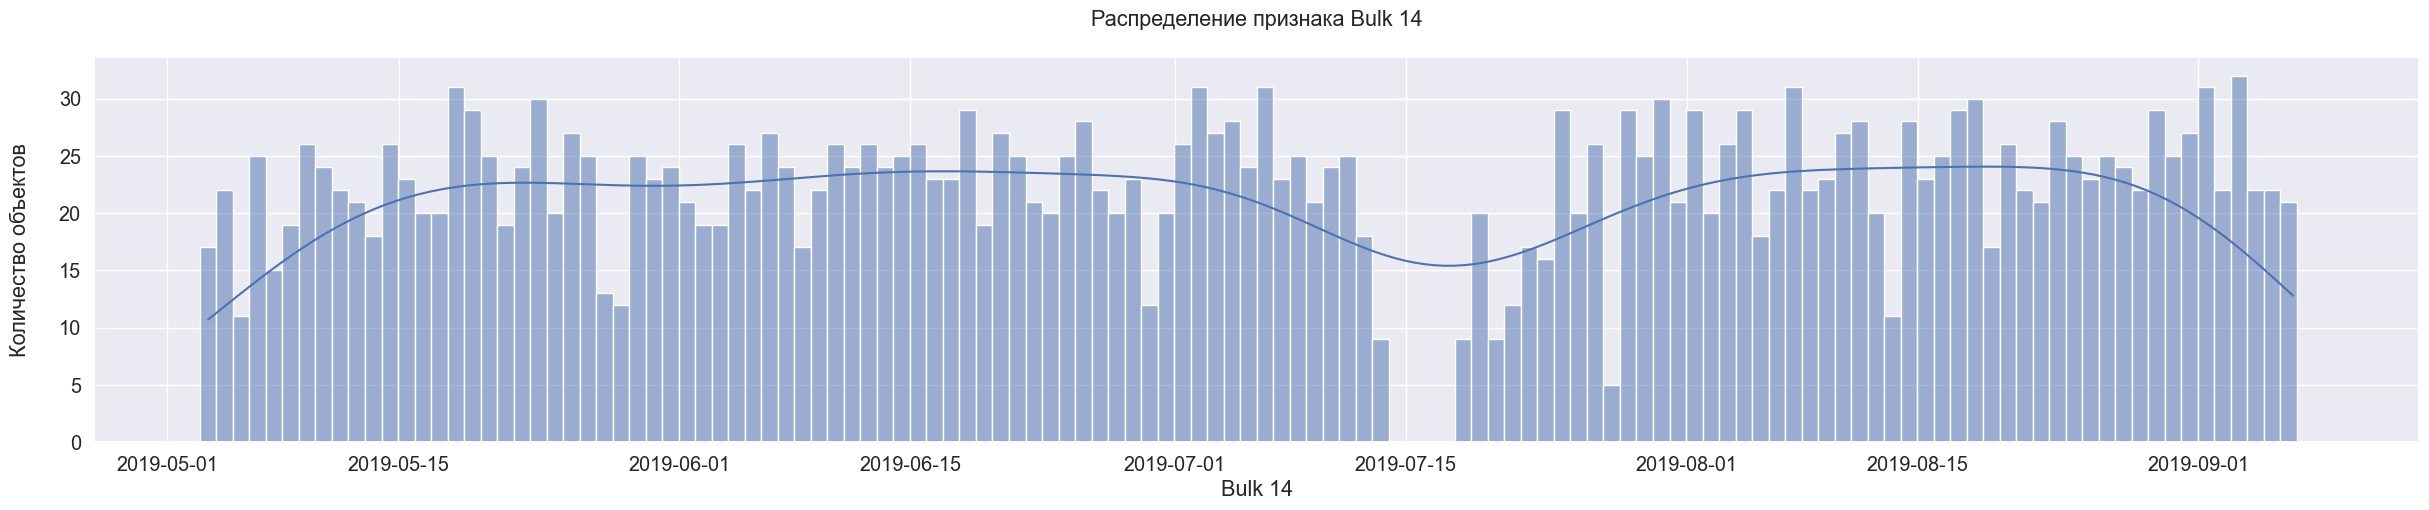

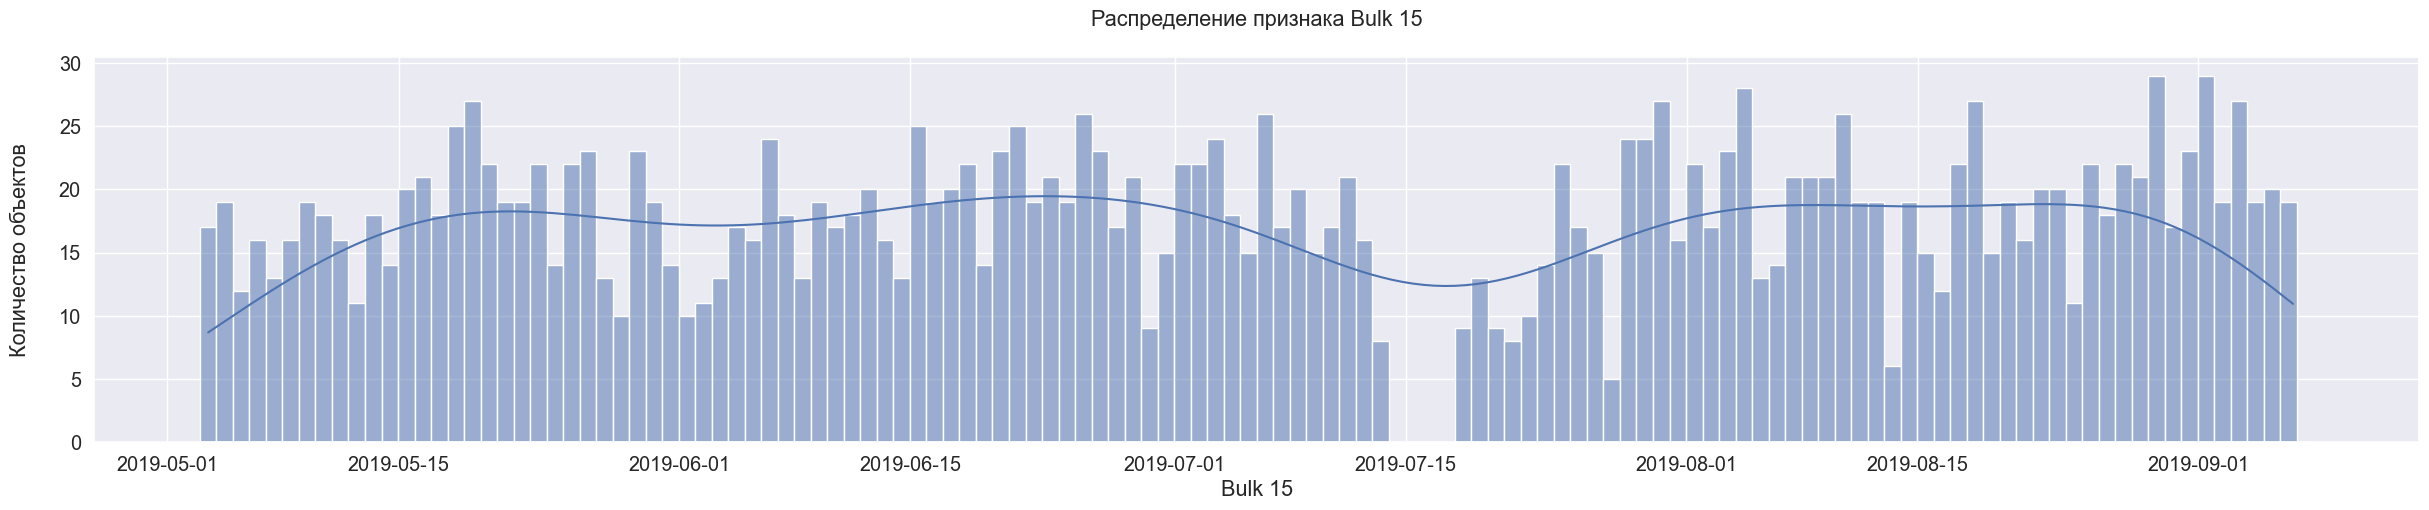

In [38]:
for col in data_bulk_time.columns[1:]:
    dist_and_box(data_bulk_time, col, time=True)

**Выводы**

По гистограммам видно, что есть полное отсутствие данных за 14-17 июля (аналогично пропуску в `data_arc`).

Каких-то явных закономерностей или цикличности в добавлении добавок не прослеживается, видимо, добавление добавок зависит от партии.

В соответствие с датафреймом `data_bulk`, на гистограммах видно, что разные сыпучие легирующие добавки добавляют с разной частотой - чаще всего добавляют `Bulk 3`, `Bulk 12`, `Bulk 14` и `Bulk 15`.

### 2.4. Работа с данными о продувке сплава газом (`data_gas`).

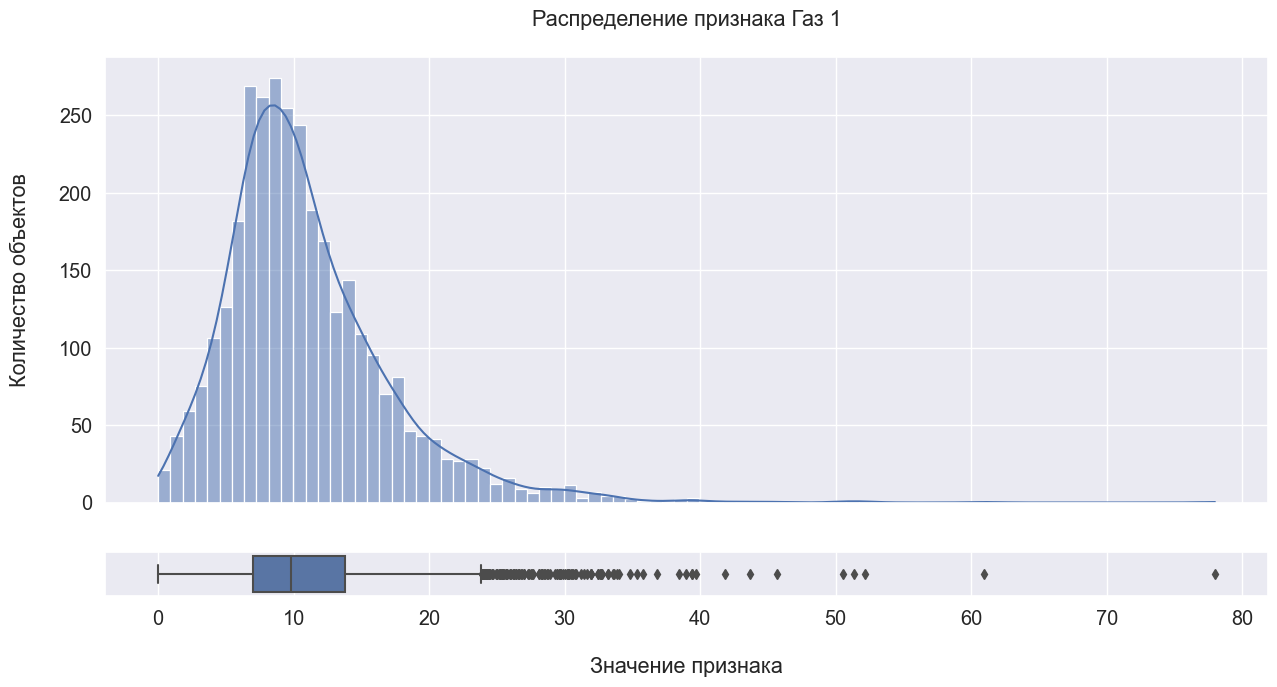

In [39]:
for col in data_gas.columns[1:]:
    dist_and_box(data_gas, col)

In [40]:
data_gas.describe()

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

**Выводы**

Распределение газа также похоже на распределение Пуассона со смещением влево и длинным хвостом, выходящим за границы полуторного квартильного размаха. 

Оно характеризуется минимальным значением 0.008, максимальным - 77.995, средним 11.0 со стандартным отклонением — 6.22. Медианное значение объема газа, необходимого для продува сплава равно 9.83 кубометрам.

У признака `Газ 1` присутствуют многочисленные выбросы выше 30.

### 2.5. Работа с данными по измерению температуры (`data_temp`).

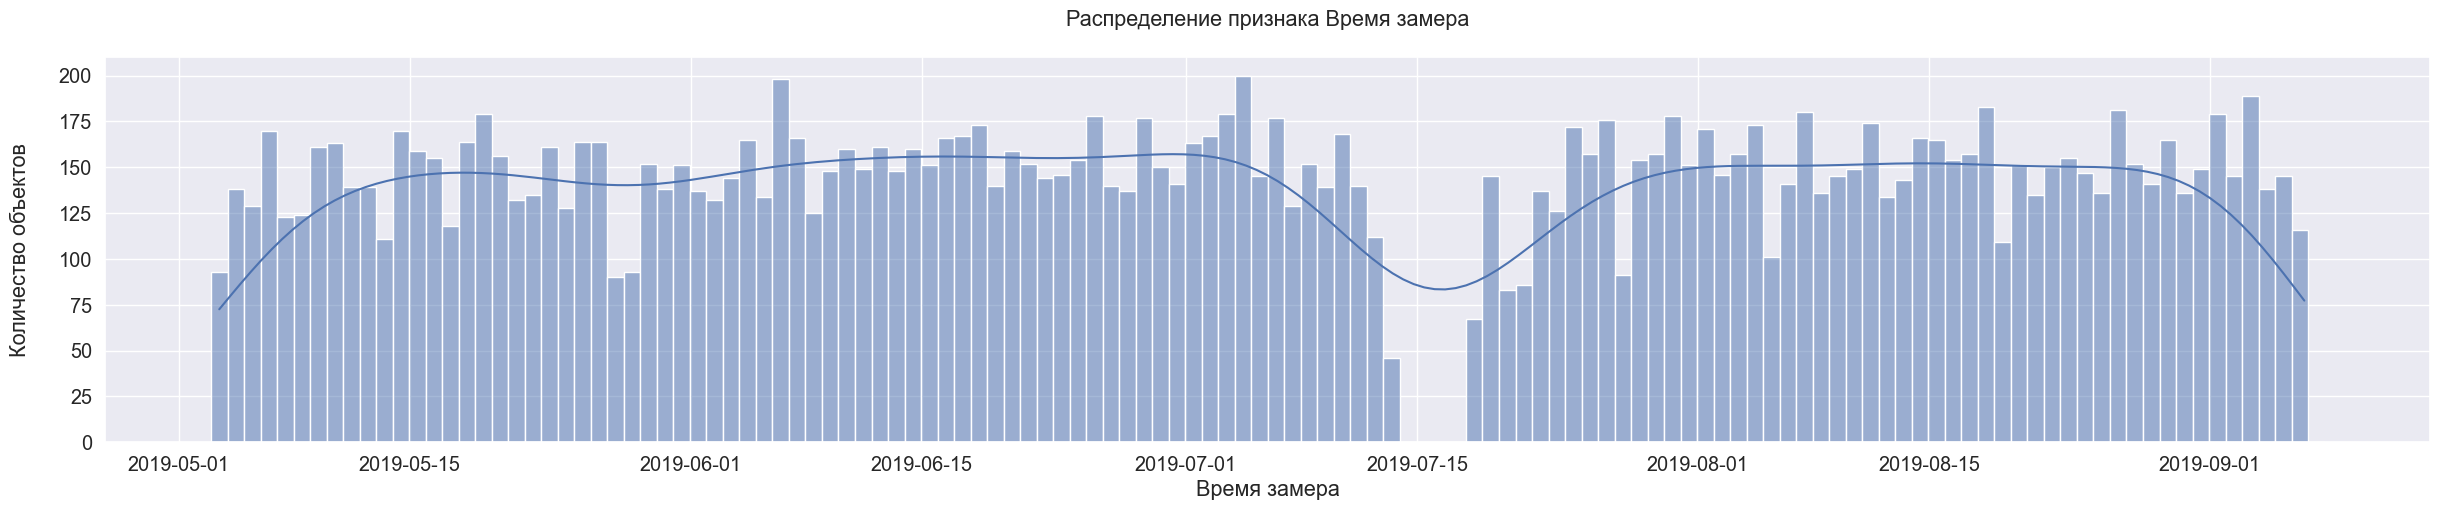

In [41]:
dist_and_box(data_temp, 'Время замера', time=True)

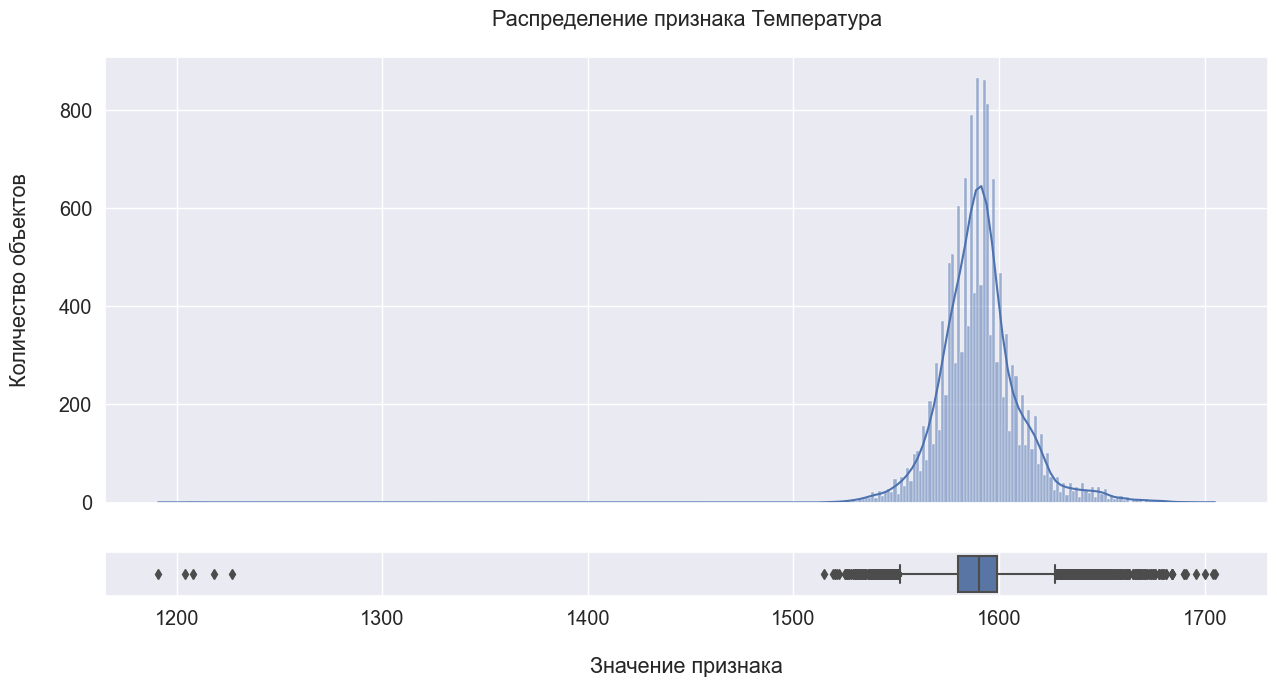

In [42]:
dist_and_box(data_temp, 'Температура')

Распределение похоже на нормальное за исключением выбросов ниже значений 1500 градусов. Рассмотрим их подробнее.

In [43]:
data_temp[data_temp['Температура'] < 1500]

key        Время замера  Температура
4883    867 2019-06-06 08:03:39       1191.0
6784   1214 2019-06-18 08:01:03       1208.0
9050   1619 2019-07-03 02:34:41       1218.0
11495  2052 2019-07-25 08:49:15       1227.0
14283  2561 2019-08-12 18:49:29       1204.0

Нам известно, что сталь не плавитс при температрах ниже 1500 градусов. Кроме того, таких значений всего 5 - то есть они явно являются аномалиями, которыми для обучения моделей можно пренебречь.

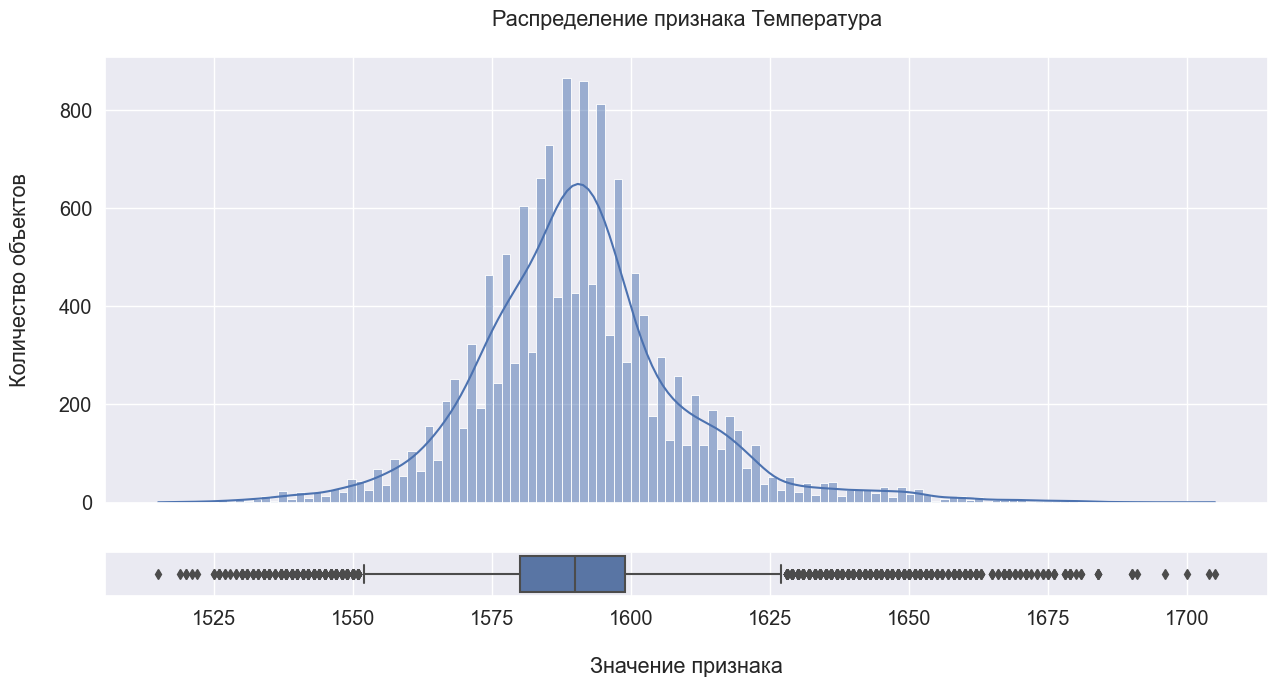

In [44]:
dist_and_box(data_temp[data_temp['Температура'] > 1500], 'Температура')

In [45]:
data_temp[data_temp['Температура'] > 1500].describe()

key   Температура
count  14660.000000  14660.000000
mean    1325.369236   1590.852729
std      787.407873     19.143141
min        1.000000   1515.000000
25%      654.000000   1580.000000
50%     1314.000000   1590.000000
75%     1962.250000   1599.000000
max     3241.000000   1705.000000

Без аномалий распределение выглядит нормальным с минимумом 1515 и максимумом 1705, средняя температура составляет 1590 градусов, как и медиана. 

Оценим отсутствующие значения температур.

In [46]:
data_temp[data_temp['Температура'].isnull()].shape

(3427, 3)

In [47]:
# выведем отсутствующие значения по конкретному номеру партии

data_temp[data_temp['key'] == 2500]

key        Время замера  Температура
13926  2500 2019-08-10 14:04:39       1539.0
13927  2500 2019-08-10 14:13:11          NaN
13928  2500 2019-08-10 14:18:12          NaN
13929  2500 2019-08-10 14:25:53          NaN
13930  2500 2019-08-10 14:29:39          NaN

**Выводы**

Для каждой партии есть несколько значений температуры, последнее из которых является нашей целевой переменной.

В 3427 строках (около 19% от общего количества записей) отсутствуют какие-либо данные о замерах температур.

Присутствует некоторое количество выбросов с температурами ниже 1550 и выше 1625.

### 2.6. Работа с данными об объеме добавления проволочных материалов (`data_wire`).

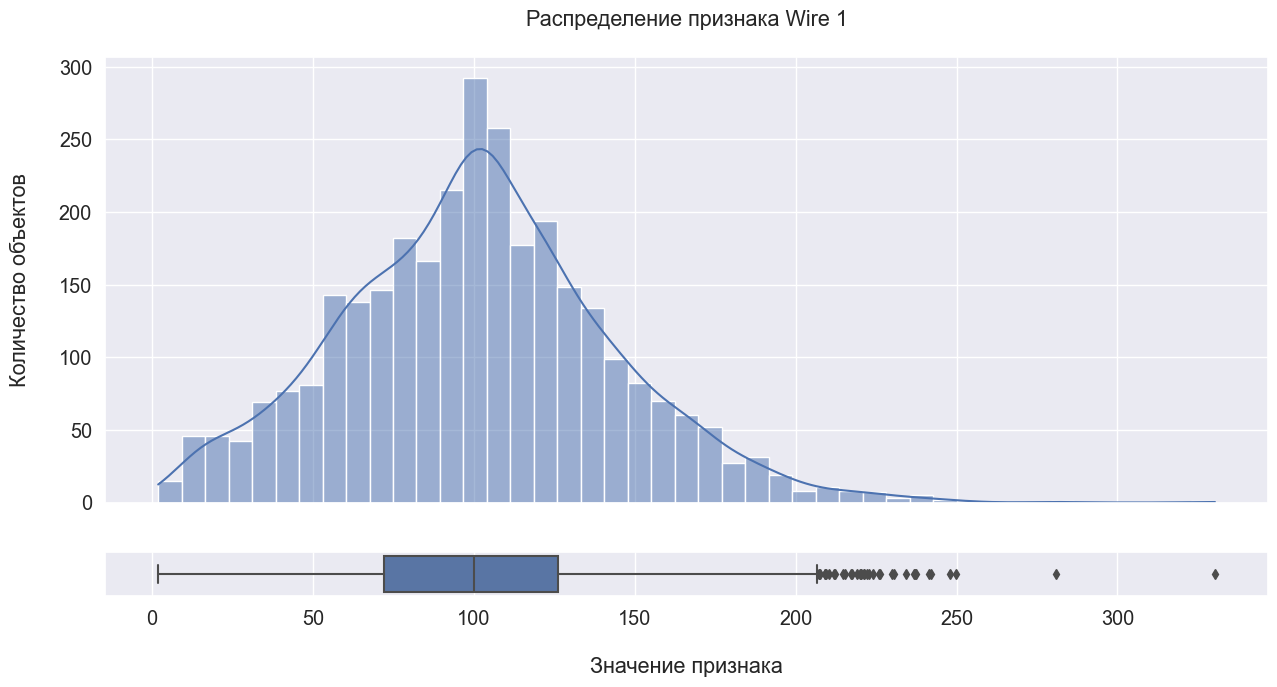

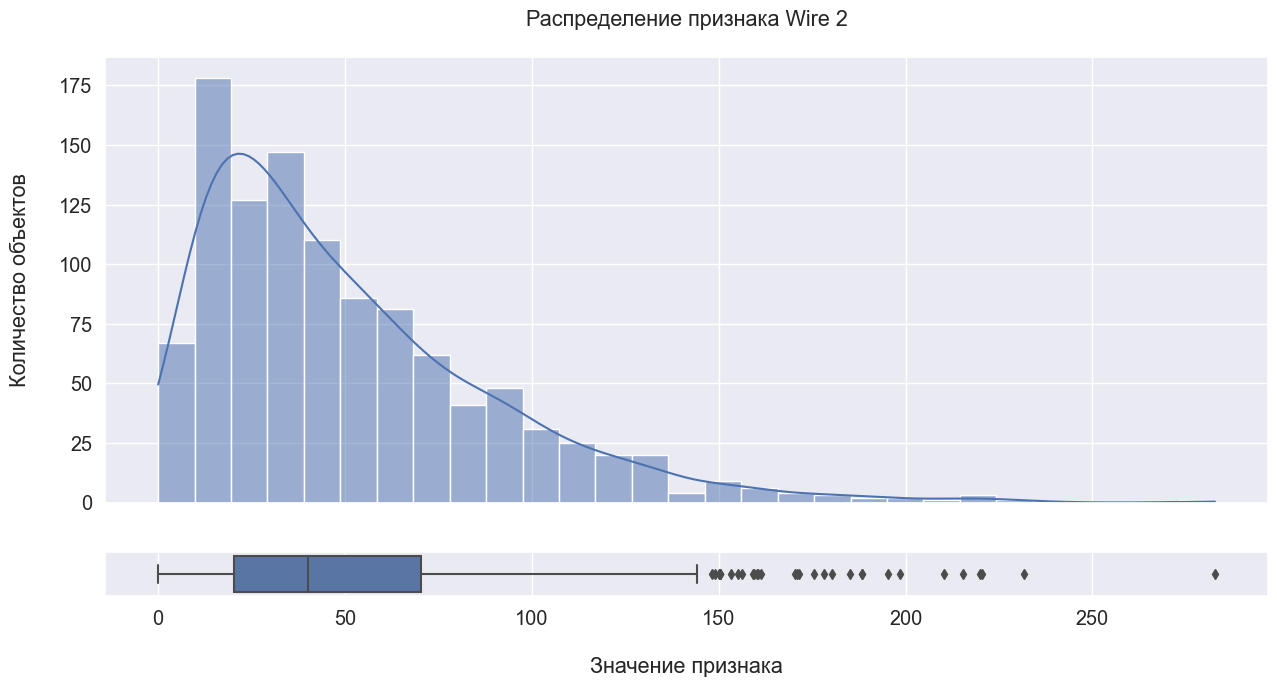

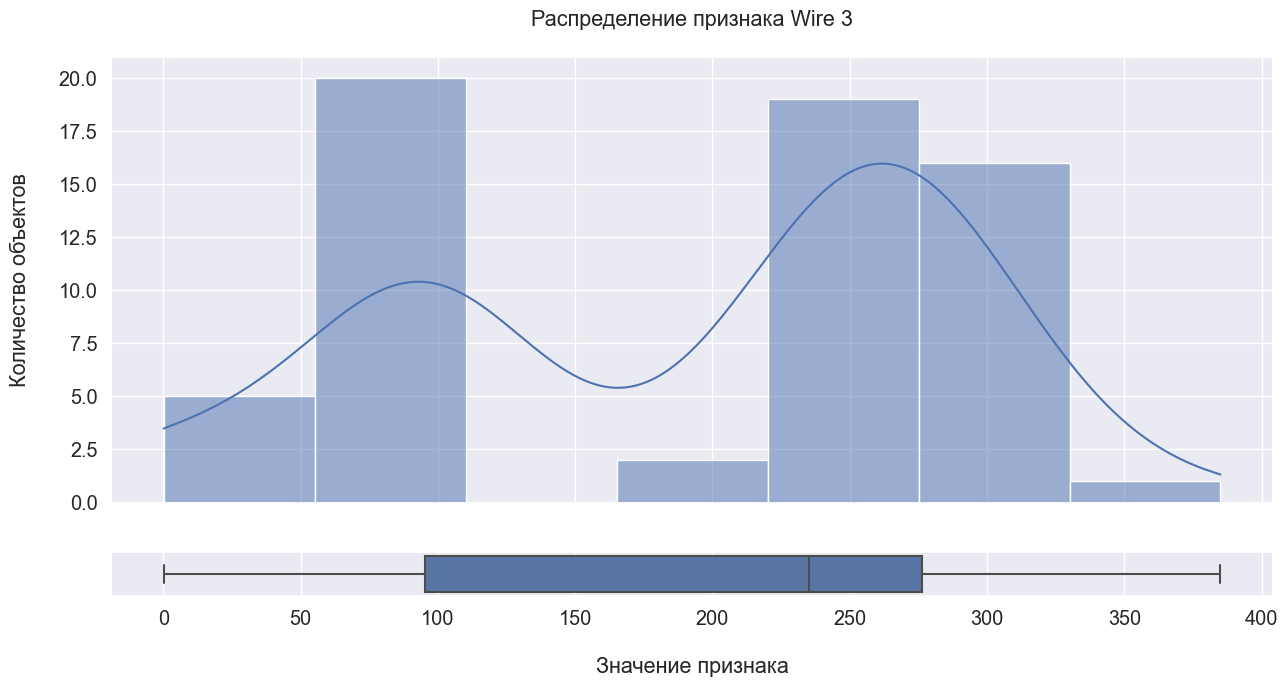

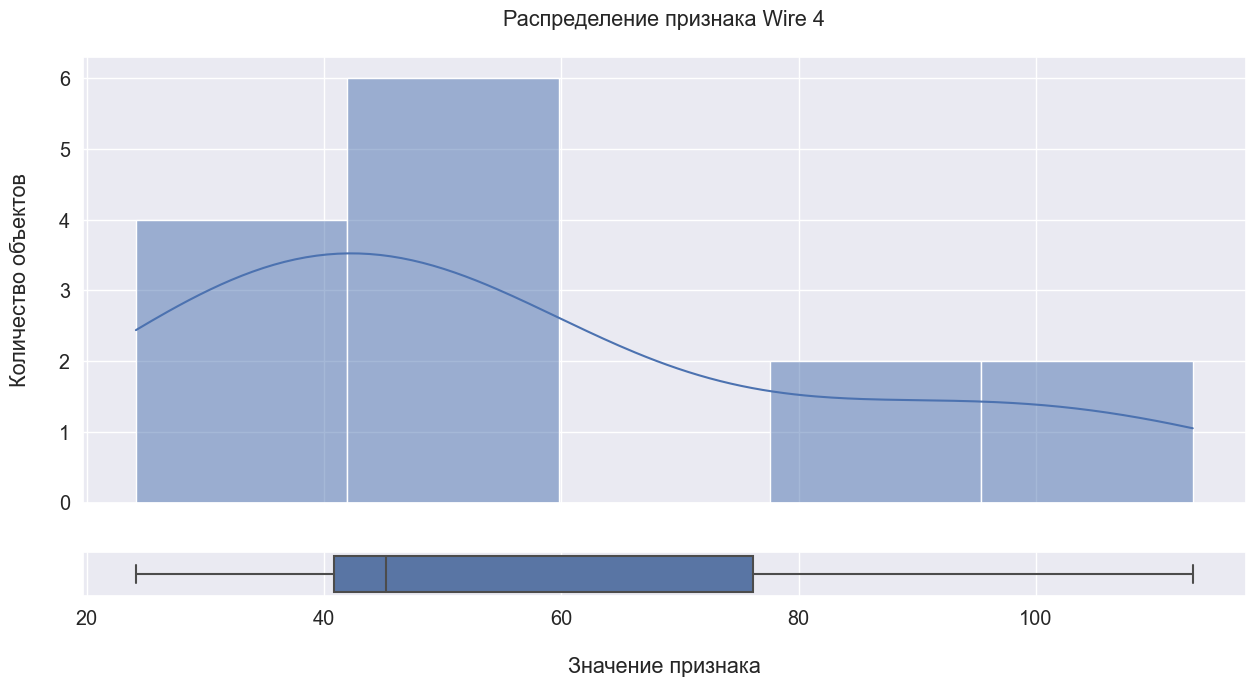

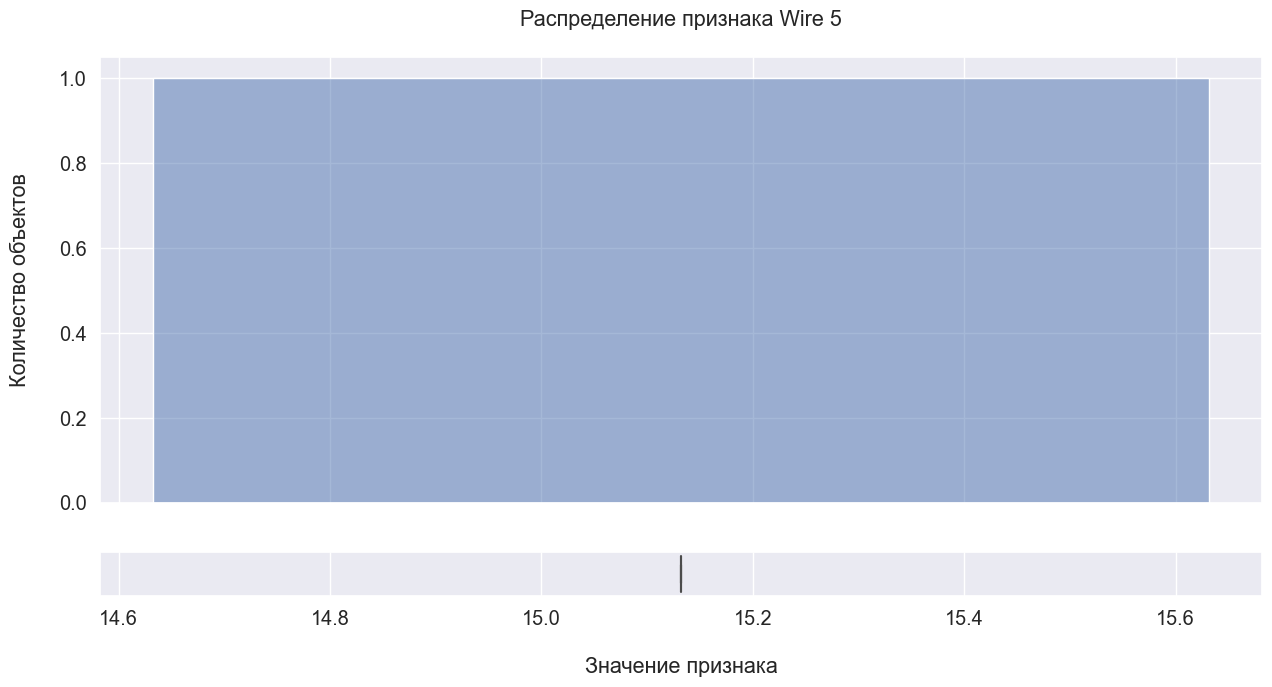

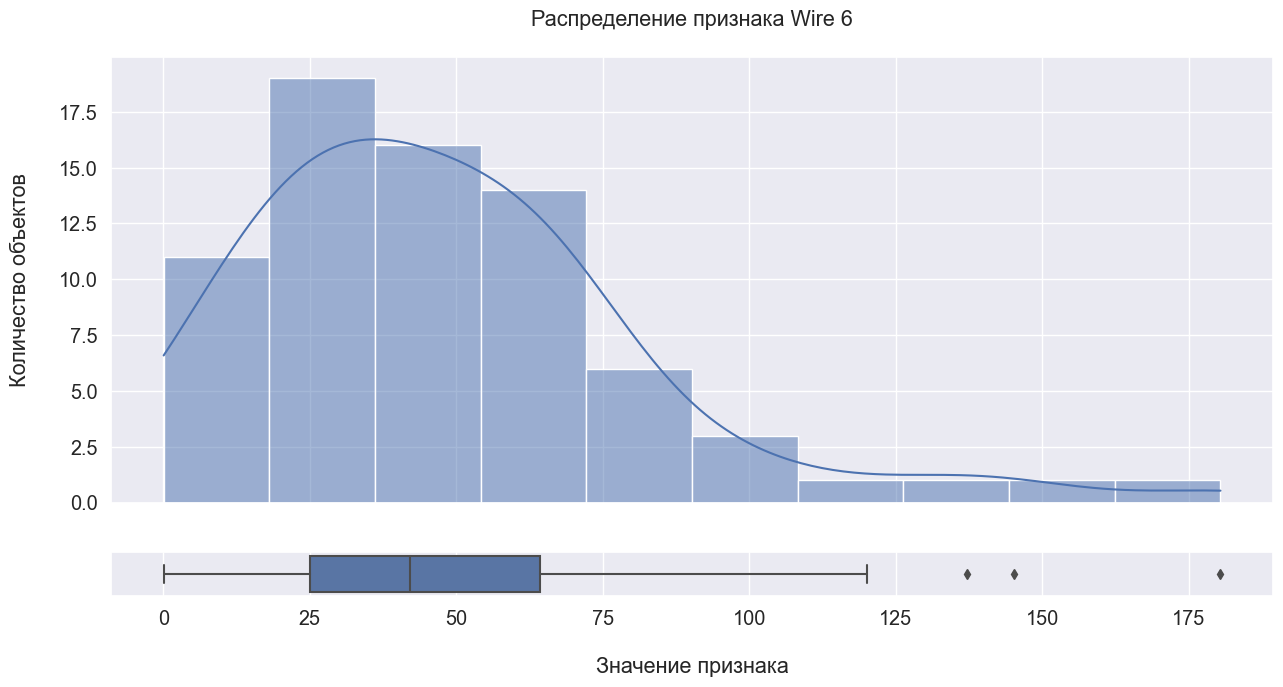

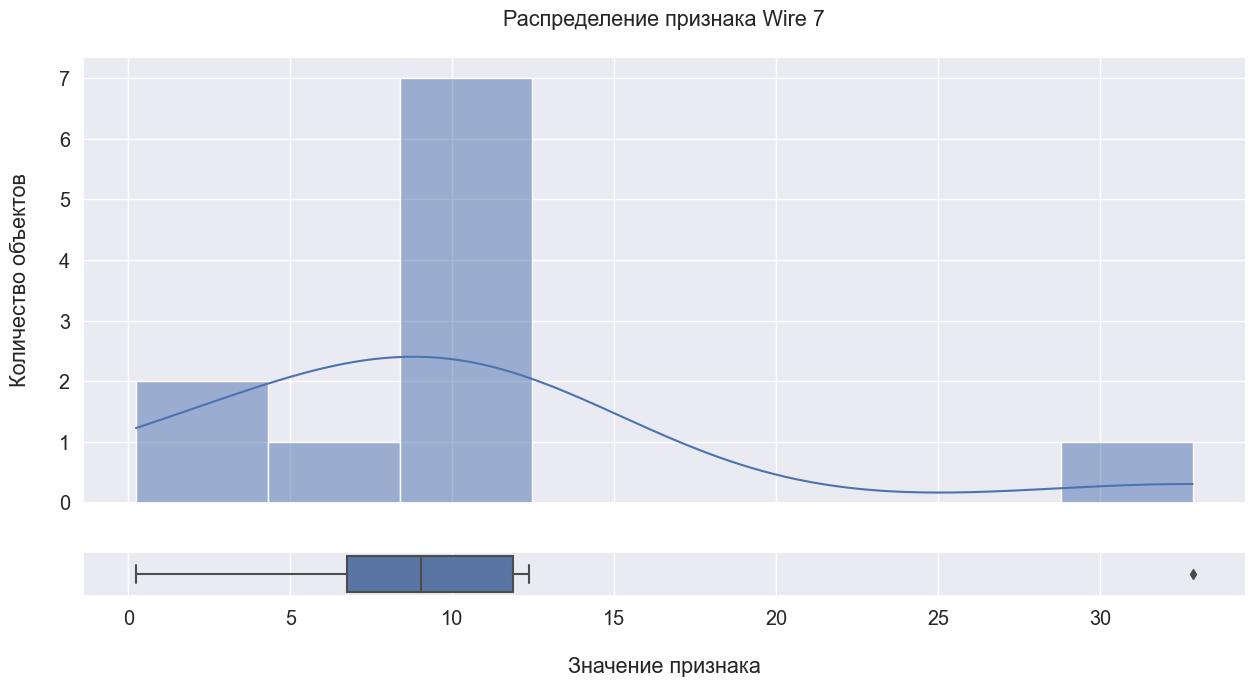

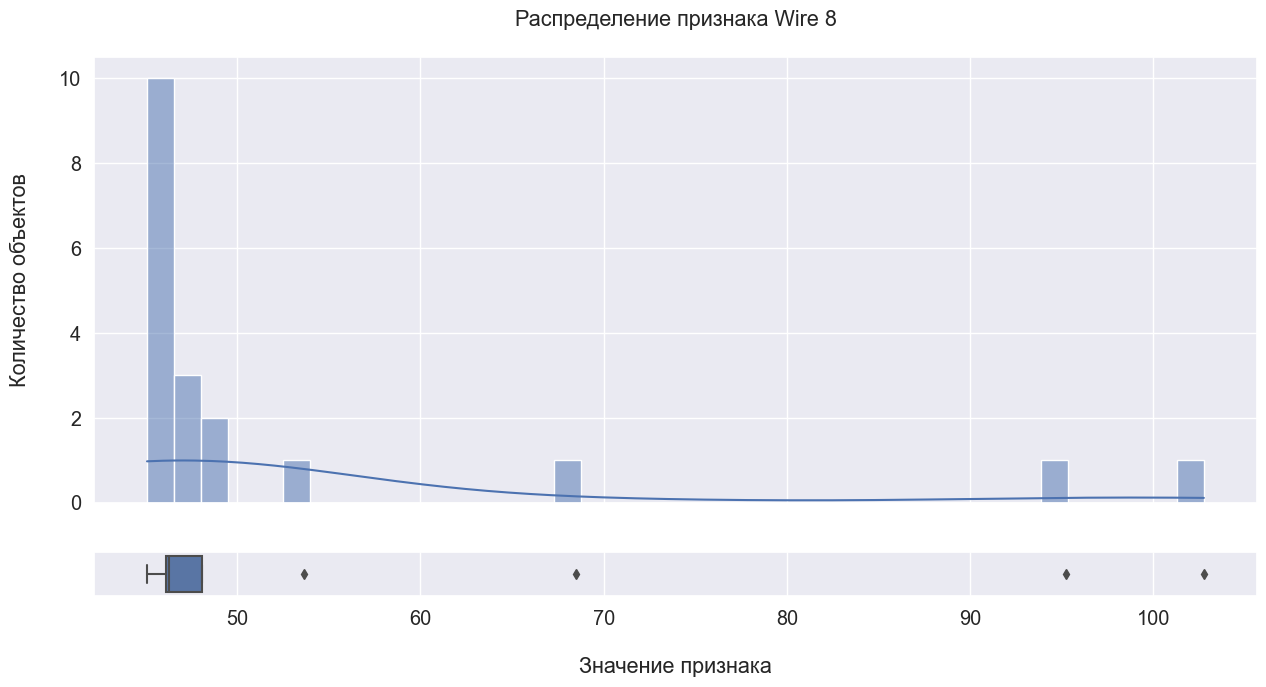

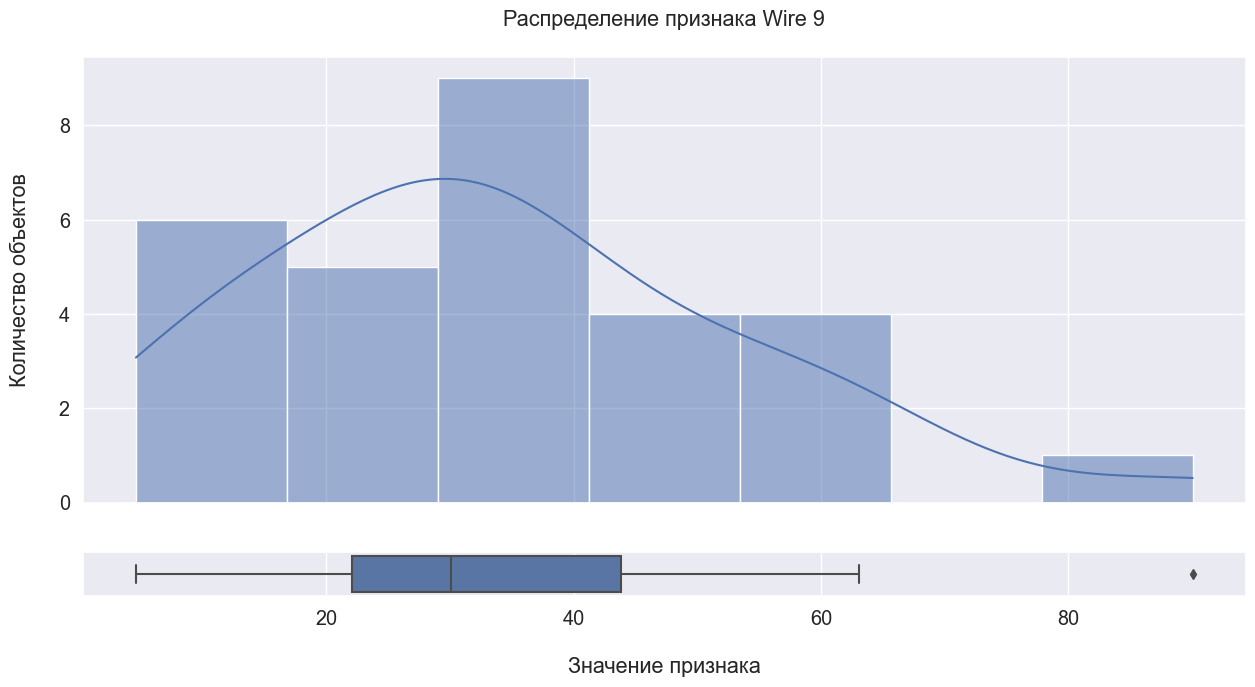

In [48]:
for col in data_wire.columns[1:]:
    dist_and_box(data_wire, col)

In [49]:
data_wire.describe()

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

**Выводы**

Как и в случае с сыпучими материалами, видно, что разные виды проволоки добавляются в разных объемах:

- только 1 раз добавили `Wire 5`;
- меньше всего в среднем добавляют `Wire 7`, больше всего в среднем - `Wire 3`;
- на гистограммах `Wire 3`, `Wire 4`, `Wire 6`, `Wire 7` и `Wire 9` можно увидеть, что за 1 раз добавляется определенный объем проволоки.

Есть выбросы, но по объяснению заказчика, замеры отлаживались, поэтому это можно списать на погрешности.

### 2.6. Работа с данными о времени добавления проволочных материалов (`data_wire_time`).

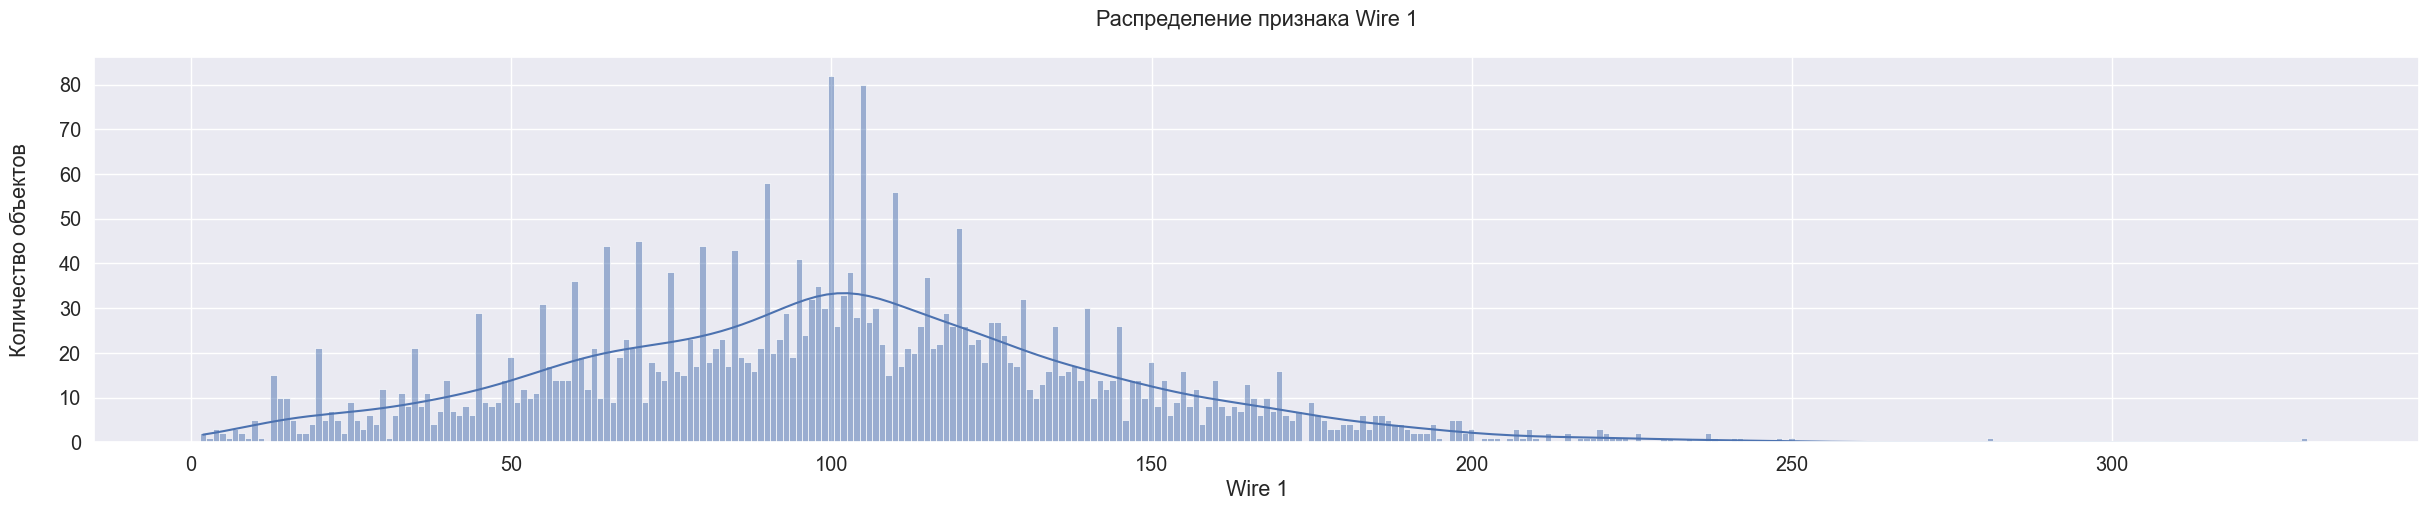

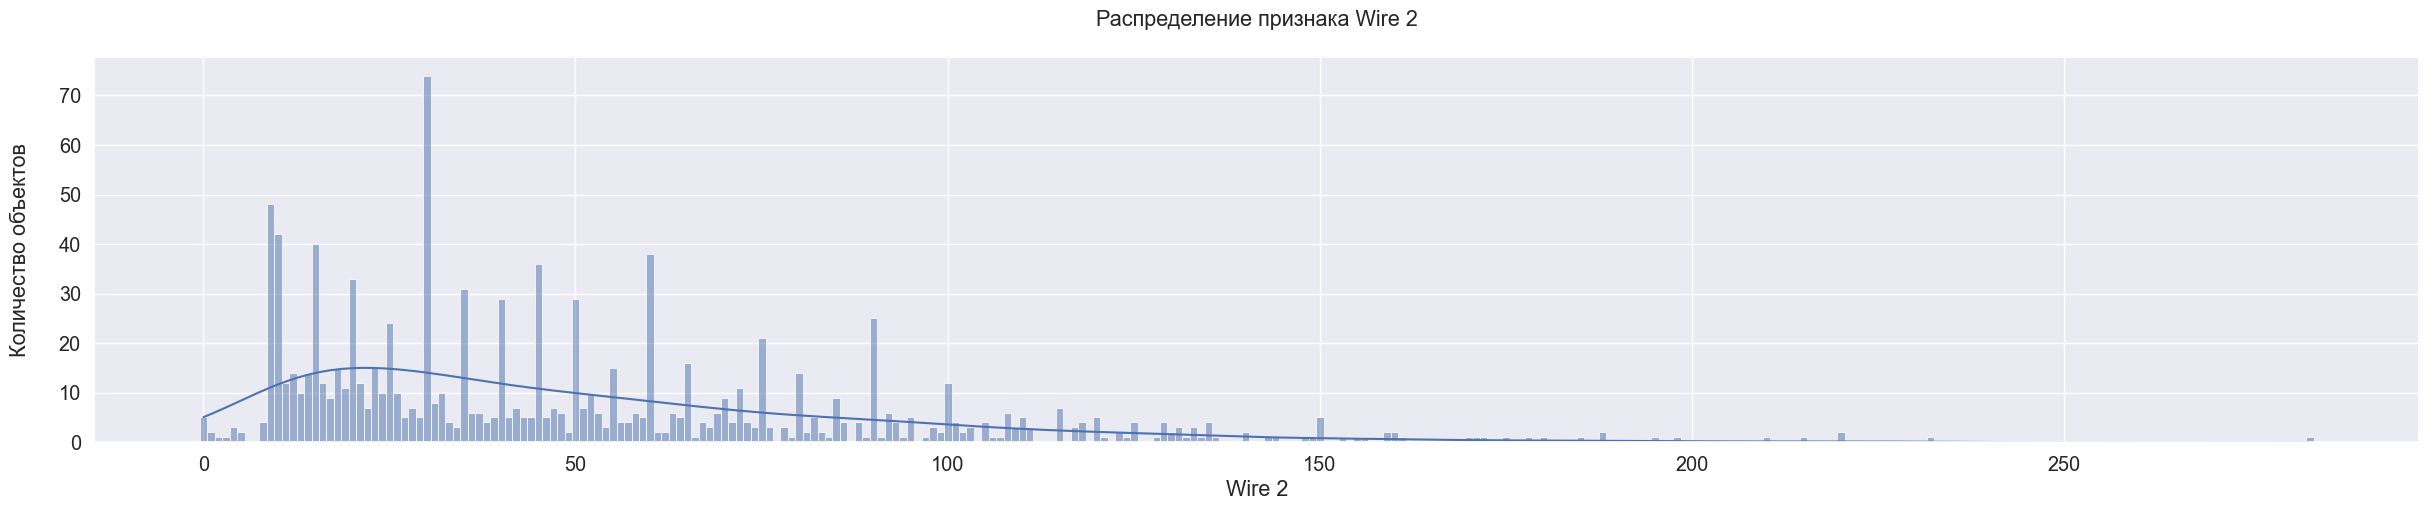

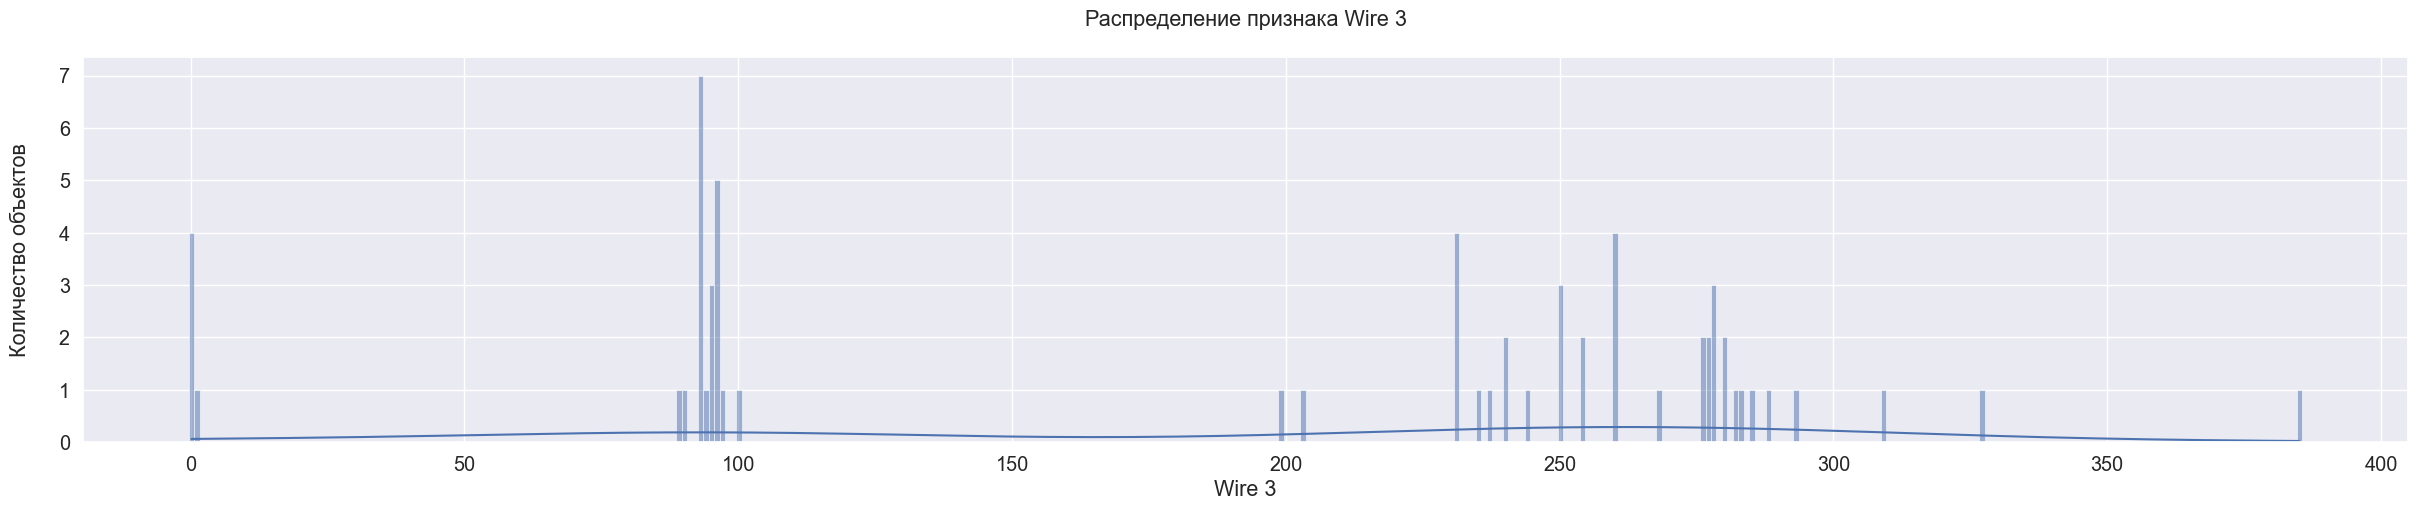

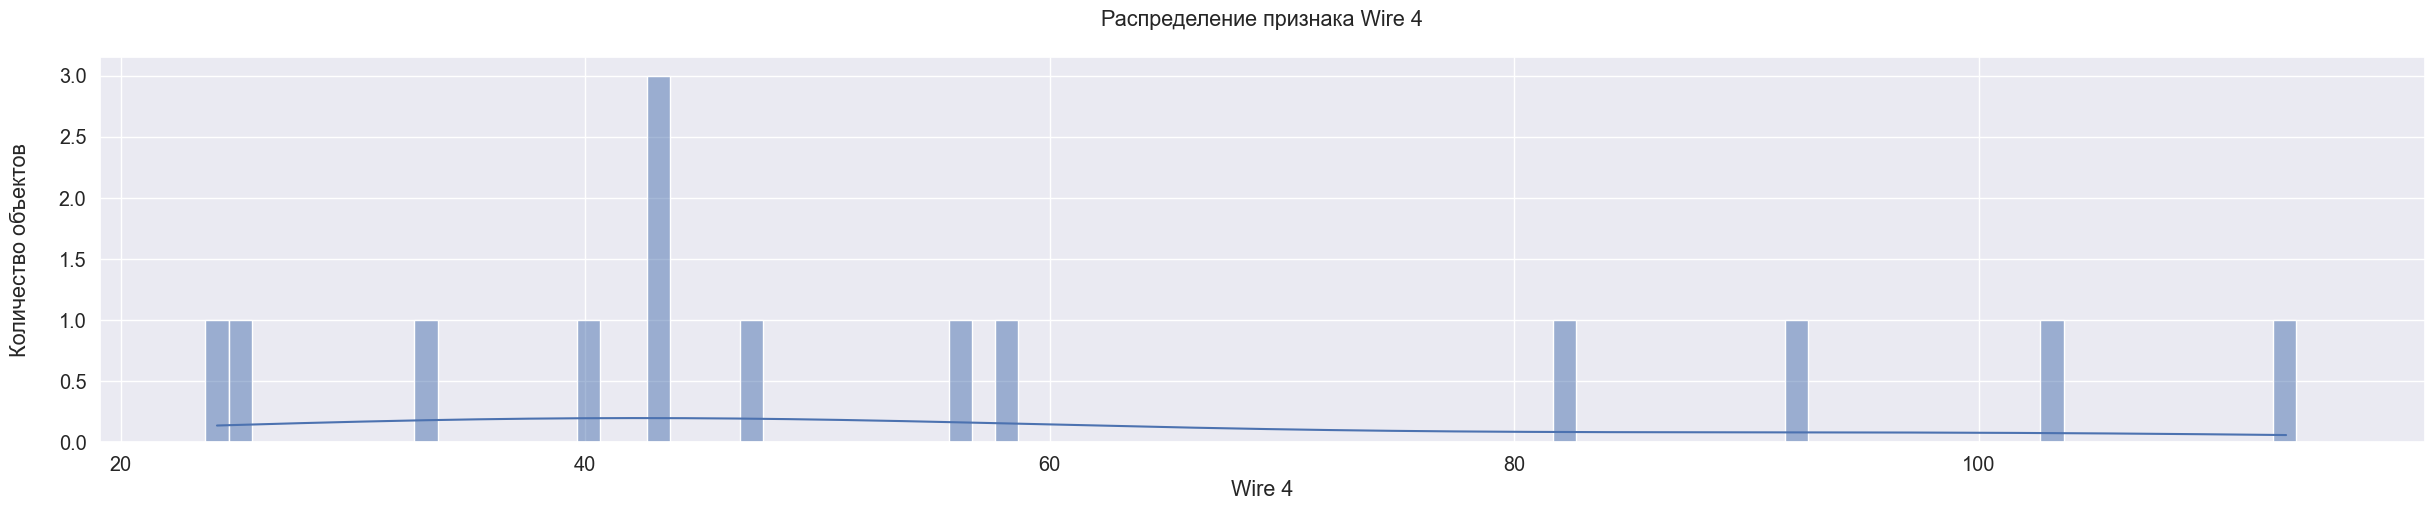

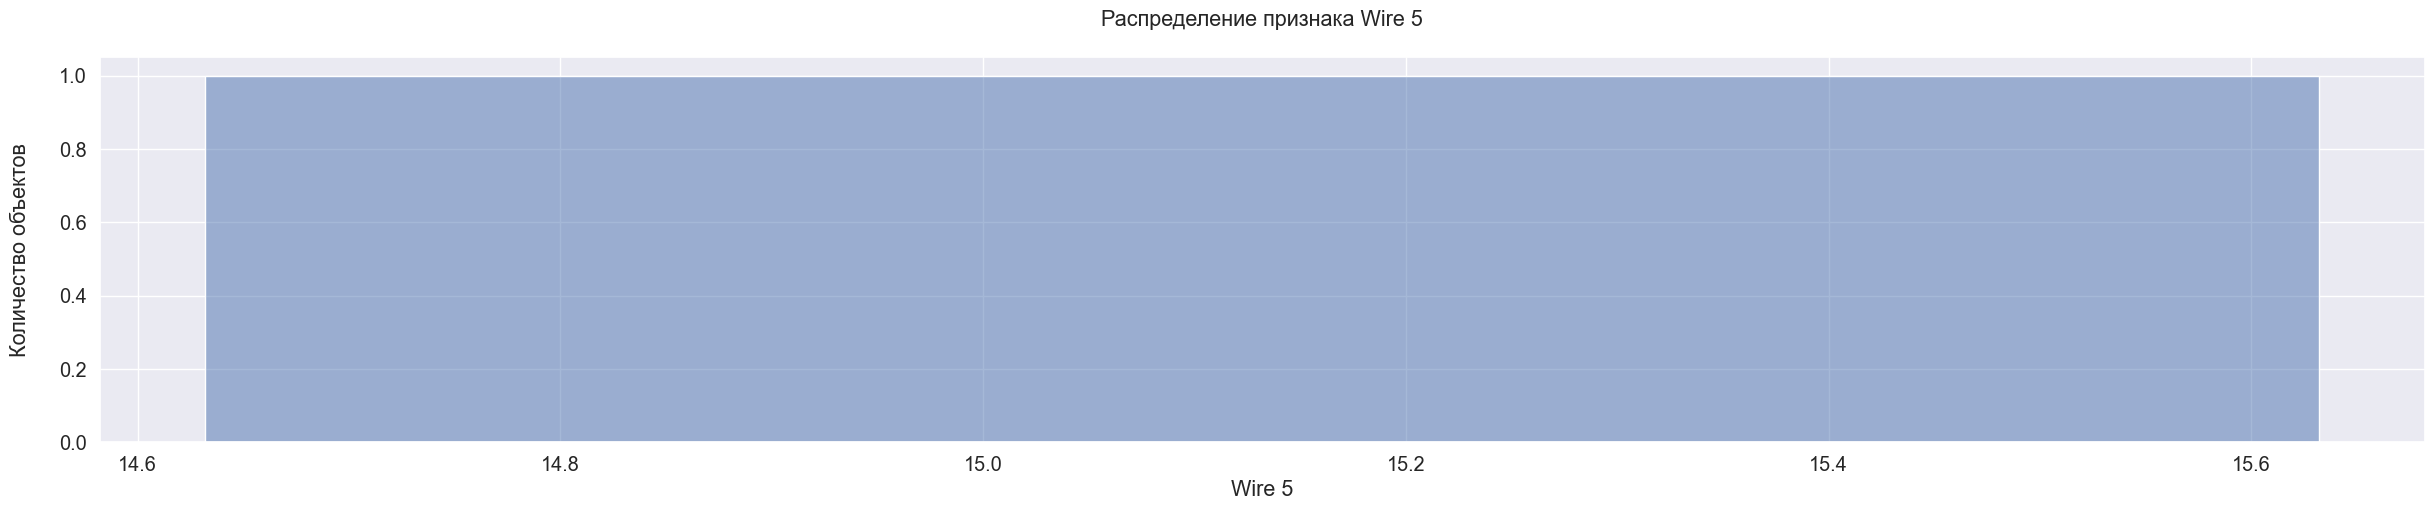

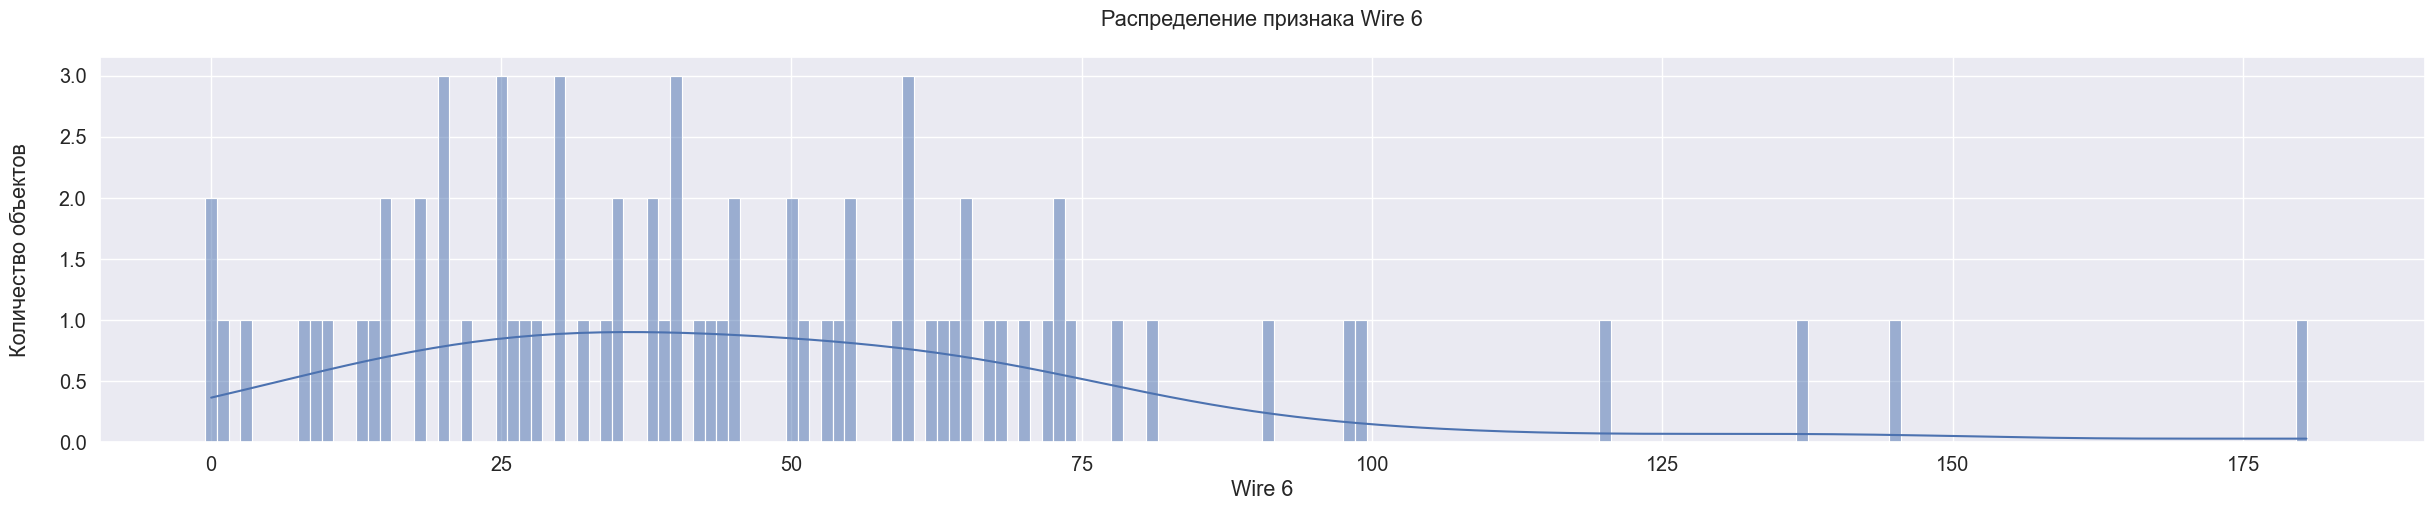

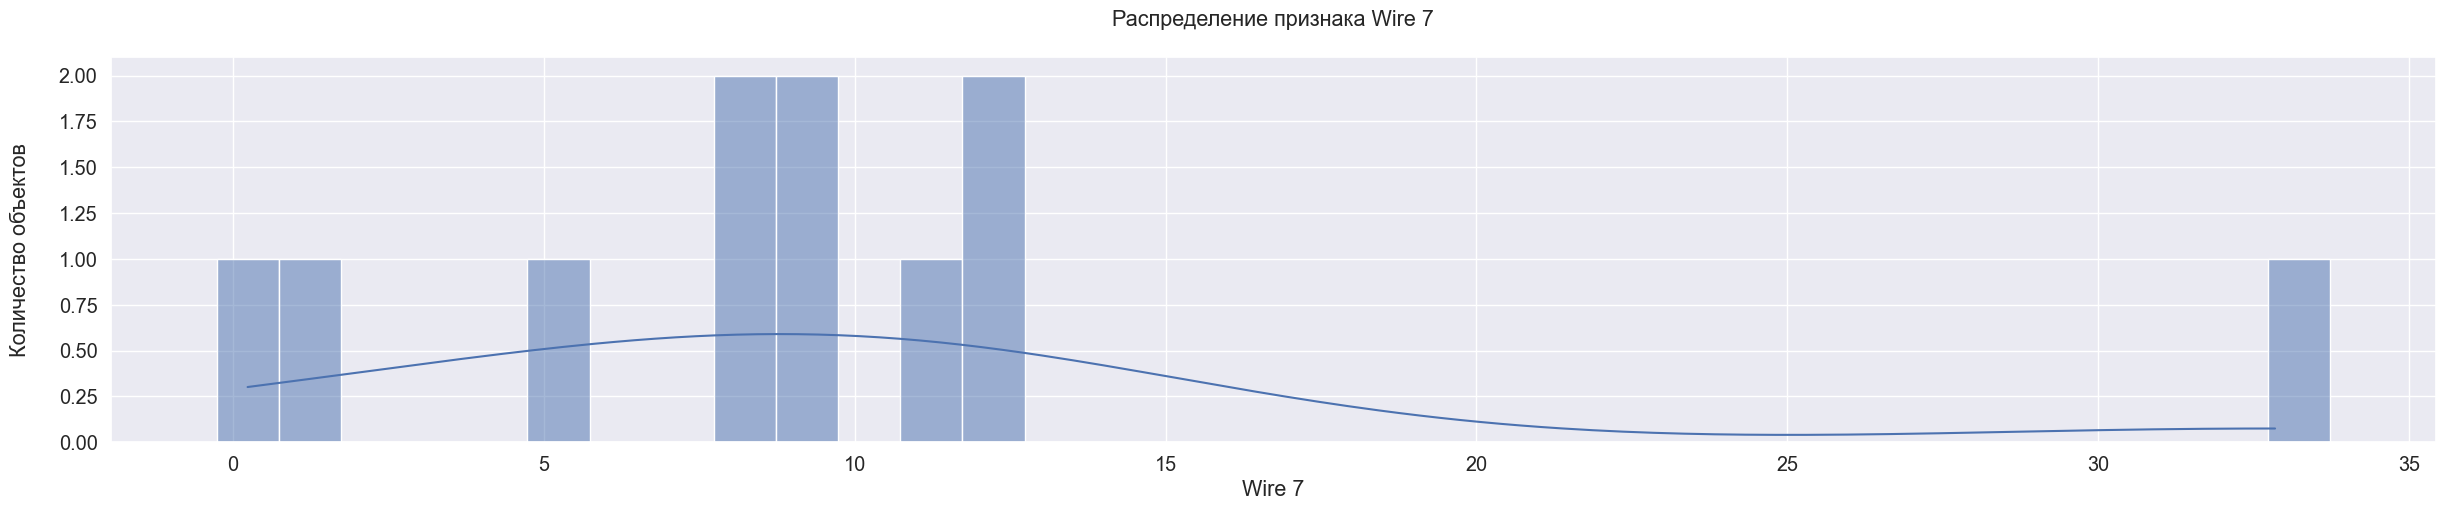

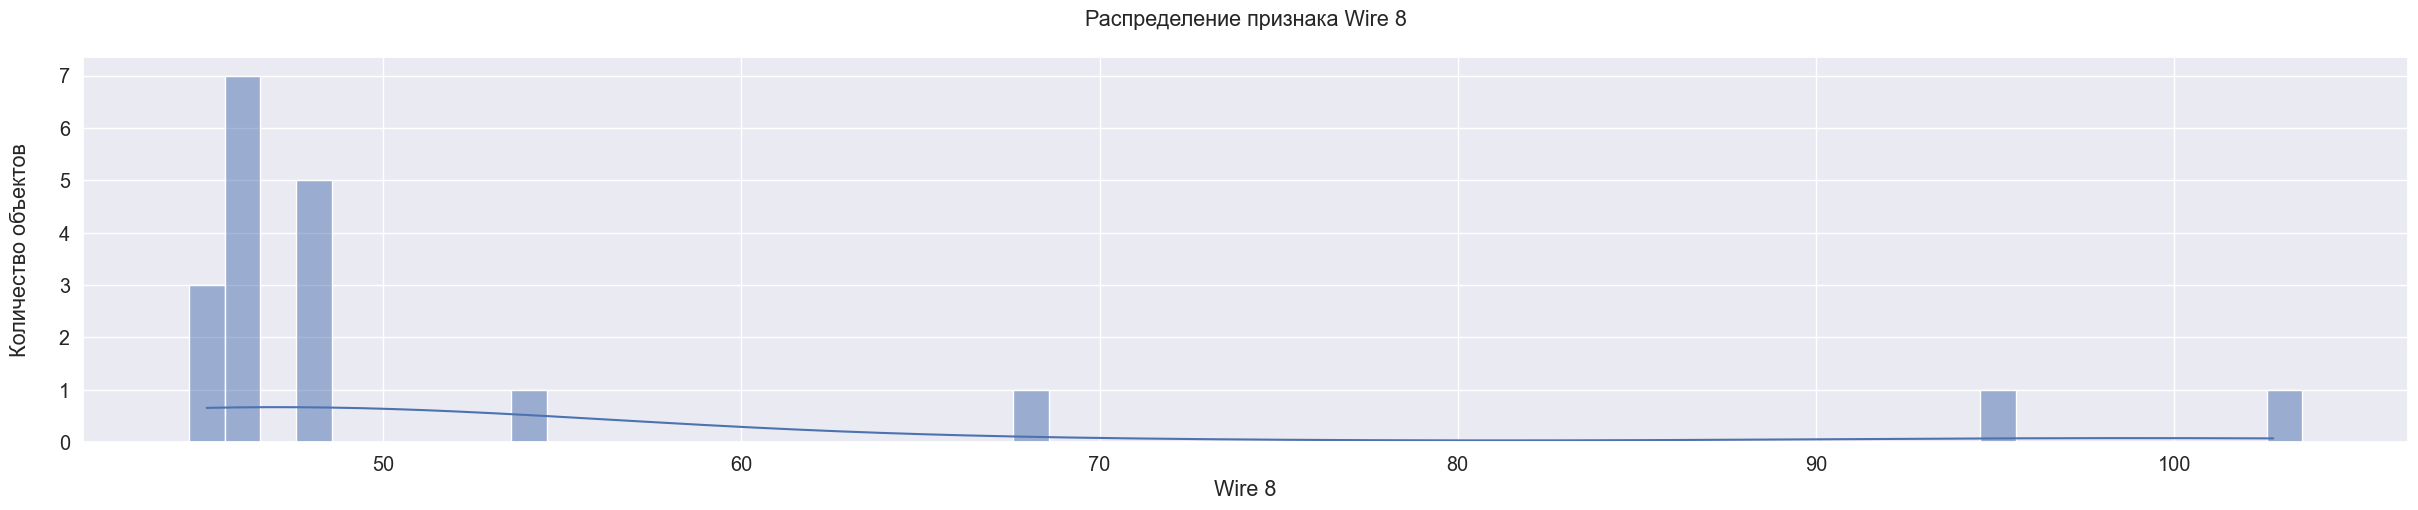

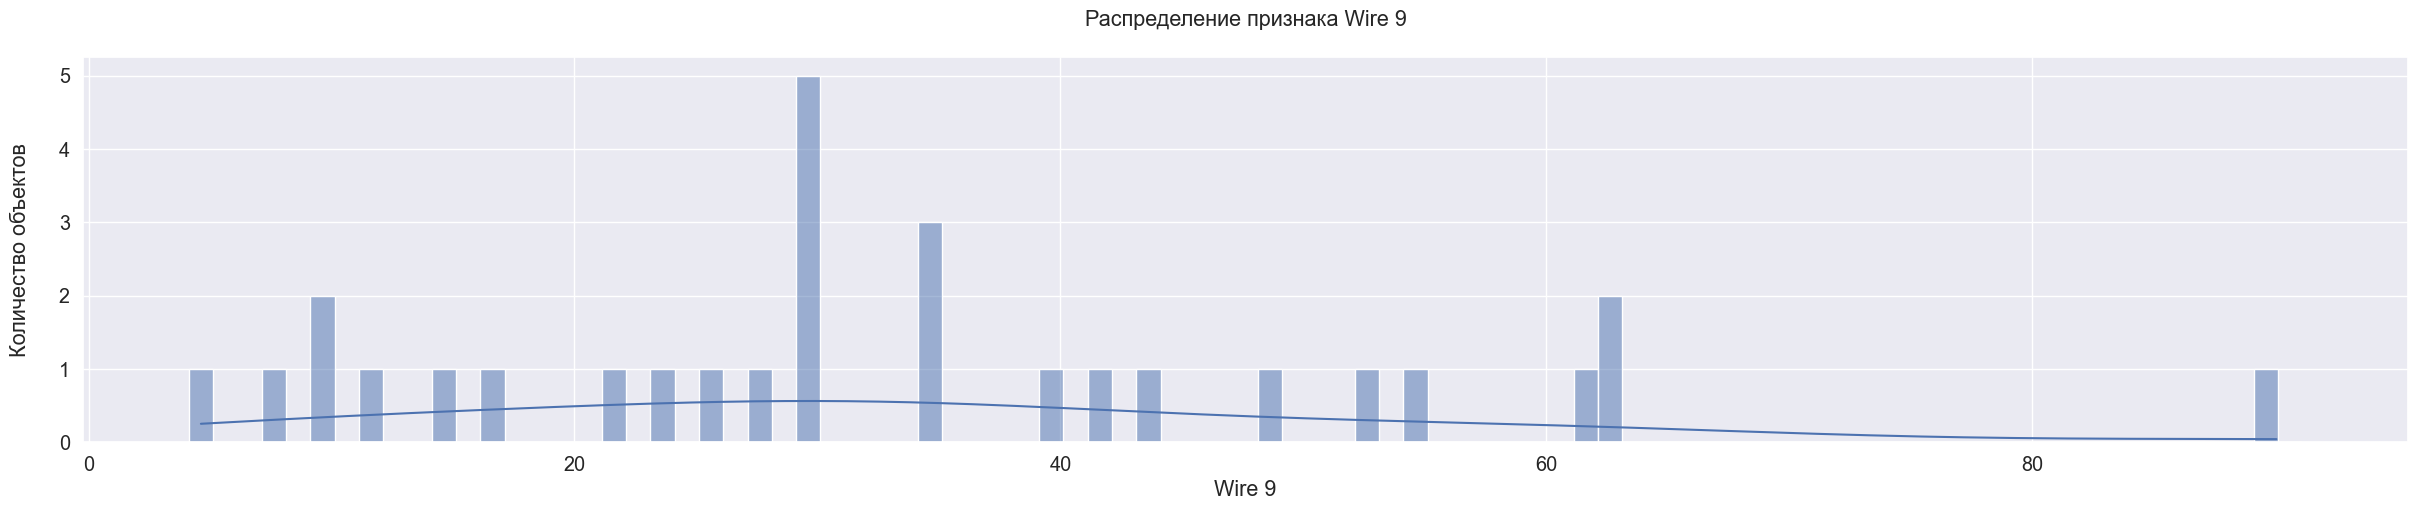

In [50]:
for col in data_wire_time.columns[1:]:
    dist_and_box(data_wire, col, time=True)

**Выводы**

По гистограммам виден аналогичный временной пропуск, как и в `data_arc` и `data_bulk_time`. 

В соответствие с датафреймом `data_wire`, на гистограммах видно, что разные проволоки добавляют с разной частотой.

В расплавленный металл могут подавать 9 различных проволочных материалов. В основном в ход идут `Wire 1` и `Wire 2`. 

### 2.7. Выводы по разделу.

В процессе исследования удалось придти к следующим выводам:

- Все колонки имеют названия на русском языке, написанные верблюжьим регистром.
- В датафреймах `data_bulk`, `data_bulk_time`, `data_wire`, `data_wire_time` есть пропуски данных. Причина части пропусков известна от заказчика - сбор данных либо не был отлажен, либо в определенных партиях не подавались легирующие добавки.
- Во всех временных признаках отсутствует информация за  14-17 июля.
- В части признаков есть выбросы - отрицательная реактивная мощность, низкая температура, подача газа.
- Нужно учитывать, что существует достаточно большое количество записей с отсутствующими показателями температуры; также у всех партий с 2500 нет замеров температур, кроме начальной, а следовательно, нет и финальной температуры (которая является нашей целевой переменной).
- Также по требованию заказчика нужно удалить все промежуточные температуры.
- Во всех таблицах количество значений `key` разное, это надо будет учесть при объединении таким образом, чтобы для каждой партии у нас осталась только начальная и конечная температура.

## 3. Предобработка данных.

В рамках предобработки данных для дальнейшей подачи в модели машинного обучения потребуется провести следующие операции:
 
- удалить аномалии и не специфичные данные;
- удалить все промежуточные значения температур и оставить только первое значение как признак (по требованию заказчика);
- извлечь целевой признак, как значение последней измеренной температуры по партии;
- правильно объединить признаки из всех таблиц по ключу `key` (номер партии), чтобы не потерять данные (как выяснилось ранее, в разных таблицах количество уникальных идентификаторов партий отличается);
- извлечь дополнительные признаки из существующих (`feature engineering`);
- заполнить возникшие в результате объединения пропуски релевантными данным значениями.

### 3.1. Удаление аномалий и промежуточных температур.

In [51]:
# удалим все промежуточные температуры из датафрейма data_temp

def temp_start_finish(data):
    
    data_temp_sorted = pd.DataFrame()
    for key in data['key'].unique():
        
        sorted = data[data['key'] == key].sort_values(by='Время замера')
        data_temp_sorted = data_temp_sorted.append(sorted.head(1))
        data_temp_sorted = data_temp_sorted.append(sorted.tail(1))
    return data_temp_sorted

data_temp = temp_start_finish(data_temp)

print(data_temp.shape)
data_temp.tail()

(6432, 3)


key        Время замера  Температура
18079  3239 2019-09-06 15:09:55          NaN
18080  3240 2019-09-06 15:25:21       1617.0
18085  3240 2019-09-06 16:35:26          NaN
18086  3241 2019-09-06 16:48:55       1586.0
18091  3241 2019-09-06 17:30:05          NaN

Теперь каждой партии соответствует всего два значения: первый и последний замеры по температуре каждой партии, как и требовалось в ТЗ заказчика.

Однако, как видим, теперь у нас есть пропущенные значения, причем последних замеров, то есть извлечь из них целевую переменную у нас не получится. Партии с такими значениями нужно удалить.

In [52]:
# удалим все строки с партиями, где нет данных по финишной температуре

key_nans = data_temp[data_temp['Температура'].isna()]['key'].unique()
key_nans.shape

(739,)

In [53]:
data_temp = data_temp[~data_temp['key'].isin(key_nans)]

print(data_temp.shape)
data_temp.tail()

(4954, 3)


key        Время замера  Температура
13914  2497 2019-08-10 12:53:28       1589.0
13915  2498 2019-08-10 12:58:11       1591.0
13920  2498 2019-08-10 13:23:31       1594.0
13921  2499 2019-08-10 13:33:21       1569.0
13925  2499 2019-08-10 13:58:58       1603.0

In [54]:
# удалим все строки с партиями, где температура < 1500

temp_anomalies = data_temp[data_temp['Температура'] < 1500]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(temp_anomalies)]
data_temp = data_temp.reset_index(drop=True)

print(data_temp.shape)
data_temp.tail()

(4946, 3)


key        Время замера  Температура
4941  2497 2019-08-10 12:53:28       1589.0
4942  2498 2019-08-10 12:58:11       1591.0
4943  2498 2019-08-10 13:23:31       1594.0
4944  2499 2019-08-10 13:33:21       1569.0
4945  2499 2019-08-10 13:58:58       1603.0

**Выводы**

Таким образом, 

- было удалено аномальное значение отрицательной мощности (ранее); 
- по требованию заказчика были удалены все промежуточные значения температуры;
- были удалены значения температур ниже 1500, как аномальные;
- датасеты с временными данными трогать не будем, так как они нам не понадобятся - все нужные данные есть в базовом датасете `data_arc`.

Датафрейм `data_temp` сократился с 18092 до 4946 строк, то есть при разбиении таблицы на стартовую и финальную температуры одной партии, в конечном итоге у нас должно получиться 2473 строки.

### 3.2. Извлечение целевого признака.

In [55]:
# вычислим время между первым и последним замером температуры
# вынесем стартовую и финальную температуры в отдельные столбцы-признаки

def delta_temp(data):
    
    list = []
    
    for key in data['key'].unique():
        tmp = data[data['key'] == key].reset_index(drop=True)
        
        start = tmp.loc[0, 'Температура']
        finish = tmp.loc[1, 'Температура']
        
        delta = (tmp.loc[1, 'Время замера'] - tmp.loc[0, 'Время замера']).seconds

        list.append([key, start, finish, delta])
    
    return pd.DataFrame(list,
                        columns=['key',
                                 'Температура в начале',
                                 'Температура в конце (целевой признак)',
                                 'Время между нагревами (сек)'])

data_temp = delta_temp(data_temp)
data_temp.tail()

key  Температура в начале  Температура в конце (целевой признак)  \
2468  2495                1570.0                                 1591.0   
2469  2496                1554.0                                 1591.0   
2470  2497                1571.0                                 1589.0   
2471  2498                1591.0                                 1594.0   
2472  2499                1569.0                                 1603.0   

      Время между нагревами (сек)  
2468                         1380  
2469                         1705  
2470                          962  
2471                         1520  
2472                         1537

### 3.3. Создание новых признаков.

Объединим показатели `Активной мощности` и `Реактивной мощности` в единый признак `Полная мощность` с помощью формулы.

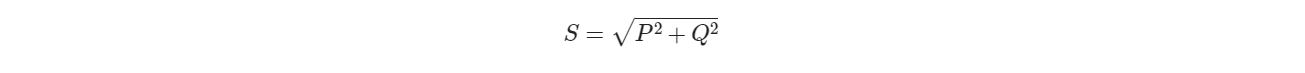

In [56]:
def full_power(row):
    '''функция для рассчета полной мощности'''  
    
    full_power = math.sqrt(row['Активная мощность'] ** 2 + row['Реактивная мощность'] ** 2)
    return full_power

In [57]:
data_arc['Полная мощность'] = data_arc.apply(full_power, axis=1)

In [58]:
data_arc.tail()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
14870  3241  2019-09-06 16:49:05 2019-09-06 16:51:42           0.439735   
14871  3241  2019-09-06 16:55:11 2019-09-06 16:58:11           0.646498   
14872  3241  2019-09-06 17:06:48 2019-09-06 17:09:52           1.039726   
14873  3241  2019-09-06 17:21:58 2019-09-06 17:22:55           0.530267   
14874  3241  2019-09-06 17:24:54 2019-09-06 17:26:15           0.389057   

       Реактивная мощность  Полная мощность  
14870             0.299579         0.532085  
14871             0.458240         0.792429  
14872             0.769302         1.293389  
14873             0.361543         0.641792  
14874             0.251347         0.463185

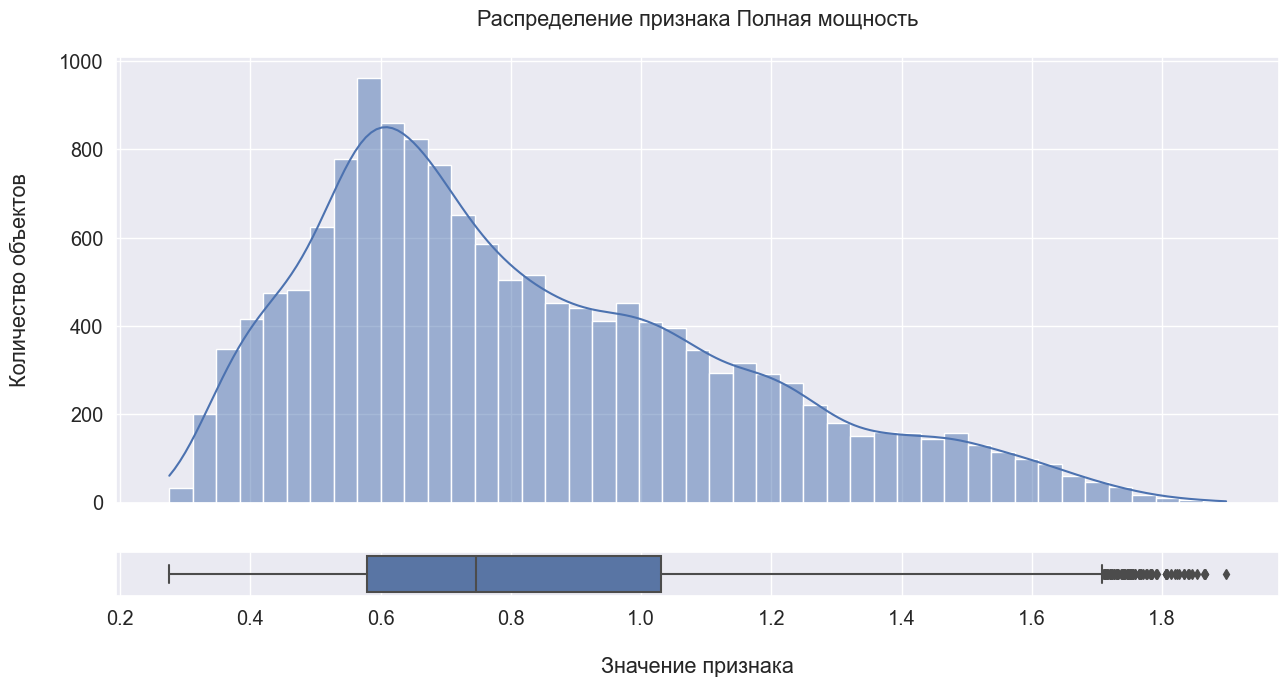

In [59]:
dist_and_box(data_arc, 'Полная мощность');

In [60]:
# вычислим время нагрева электродами по всем промежуткам для data_arc

data_arc['Продолжительность нагрева (сек)'] = (data_arc['Конец нагрева дугой'] - 
                                               data_arc['Начало нагрева дугой']).dt.seconds

data_arc.tail()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
14870  3241  2019-09-06 16:49:05 2019-09-06 16:51:42           0.439735   
14871  3241  2019-09-06 16:55:11 2019-09-06 16:58:11           0.646498   
14872  3241  2019-09-06 17:06:48 2019-09-06 17:09:52           1.039726   
14873  3241  2019-09-06 17:21:58 2019-09-06 17:22:55           0.530267   
14874  3241  2019-09-06 17:24:54 2019-09-06 17:26:15           0.389057   

       Реактивная мощность  Полная мощность  Продолжительность нагрева (сек)  
14870             0.299579         0.532085                              157  
14871             0.458240         0.792429                              180  
14872             0.769302         1.293389                              184  
14873             0.361543         0.641792                               57  
14874             0.251347         0.463185                               81

In [61]:
# определим количество итераций нагрева
data_arc_count = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
data_arc_count.columns = ['key', 'Количество итераций нагрева']

# сгруппируем по партиям
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()
data_arc = data_arc.merge(data_arc_count, how='left', on = 'key')

In [62]:
data_arc.tail()

key  Активная мощность  Реактивная мощность  Полная мощность  \
3209  3237           2.541872             2.025417         3.250657   
3210  3238           1.374821             1.038103         1.723937   
3211  3239           4.848005             3.541541         6.014480   
3212  3240           3.317679             2.373552         4.082920   
3213  3241           3.045283             2.140011         3.722880   

      Продолжительность нагрева (сек)  Количество итераций нагрева  
3209                              909                            5  
3210                              546                            3  
3211                             1216                            8  
3212                              839                            5  
3213                              659                            5

Вычислим итоговую работу по формуле и создадим новый признак.

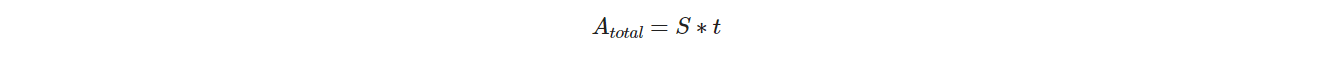

In [63]:
data_arc['Работа'] = data_arc['Продолжительность нагрева (сек)'] * data_arc['Активная мощность']
data_arc.head()

key  Активная мощность  Реактивная мощность  Полная мощность  \
0    1           3.036730             2.142821         3.718736   
1    2           2.139408             1.453357         2.588349   
2    3           4.063641             2.937457         5.019223   
3    4           2.706489             2.056992         3.400038   
4    5           2.252950             1.687991         2.816980   

   Продолжительность нагрева (сек)  Количество итераций нагрева       Работа  
0                             1098                            5  3334.329540  
1                              811                            4  1735.059888  
2                              655                            5  2661.684855  
3                              741                            4  2005.508349  
4                              869                            4  1957.813550

### 3.4. Объединение датасетов.

Теперь все готово для того, чтобы объединить датафреймы `data_arc`, `data_temp`, `data_bulk`, `data_gas` и `data_wire`.

In [64]:
total_data = data_temp.merge(right=data_arc,
                             how='inner',
                             on='key')\
                      .merge(right=data_bulk,
                             how='inner',
                             on='key')\
                      .merge(right=data_gas,
                             how='inner',
                             on='key')\
                      .merge(right=data_wire,
                             how='inner',
                             on='key')
print(total_data.shape)
total_data.tail()

(2325, 35)


key  Температура в начале  Температура в конце (целевой признак)  \
2320  2495                1570.0                                 1591.0   
2321  2496                1554.0                                 1591.0   
2322  2497                1571.0                                 1589.0   
2323  2498                1591.0                                 1594.0   
2324  2499                1569.0                                 1603.0   

      Время между нагревами (сек)  Активная мощность  Реактивная мощность  \
2320                         1380           3.168133             2.210936   
2321                         1705           4.174918             2.872031   
2322                          962           3.605239             2.452092   
2323                         1520           3.202310             2.239820   
2324                         1537           1.737084             1.296836   

      Полная мощность  Продолжительность нагрева (сек)  \
2320         3.868721                              723   
2321         5.070316                              940   
2322         4.360918                              569   
2323         3.909917                              750   
2324         2.169252                              883   

      Количество итераций нагрева       Работа  Bulk 1  Bulk 2  Bulk 3  \
2320                            4  2290.560159     NaN     NaN    21.0   
2321                            6  3924.422920     NaN     NaN     NaN   
2322                            3  2051.380991     NaN     NaN     NaN   
2323                            5  2401.732500     NaN     NaN    90.0   
2324                            4  1533.845172     NaN     NaN    47.0   

      Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  \
2320     NaN     NaN     NaN     NaN     NaN     NaN     90.0      NaN   
2321    63.0     NaN     NaN     NaN     NaN     NaN    122.0      NaN   
2322    85.0     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
2323     NaN     NaN     NaN     NaN     NaN     NaN    101.0      NaN   
2324     NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   

      Bulk 12  Bulk 13  Bulk 14  Bulk 15      Газ 1      Wire 1    Wire 2  \
2320    256.0      NaN    129.0    223.0   7.125735   89.150879       NaN   
2321    256.0      NaN    129.0    226.0   9.412616  114.179527       NaN   
2322    230.0      NaN    124.0    226.0   6.271699   94.086723   9.04800   
2323    206.0      NaN    129.0    207.0  14.953657  118.110717       NaN   
2324    233.0      NaN    126.0    227.0  11.336151  110.160958  50.00528   

      Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  
2320     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2321     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2322     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2323     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2324     NaN     NaN     NaN     NaN     NaN     NaN     NaN

Сформируем новые признаки по общей массе и количеству добавляемых присадок.

In [65]:
bulk_columns = [col for col in total_data.columns if col.startswith('Bulk')]
wire_columns = [col for col in total_data.columns if col.startswith('Wire')]

In [66]:
total_data['Вulk общая масса'] = total_data[bulk_columns].sum(axis=1)
total_data['Bulk общее количество'] =  total_data[bulk_columns].count(axis=1)

total_data['Wire общая масса'] =  total_data[wire_columns].sum(axis=1)
total_data['Wire общее количество'] =  total_data[wire_columns].count(axis=1)

In [67]:
# заполним нулями оставшиеся пропуски из data_bulk и data_wire
total_data.fillna(0, inplace=True)

In [68]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   key                                    2325 non-null   int64  
 1   Температура в начале                   2325 non-null   float64
 2   Температура в конце (целевой признак)  2325 non-null   float64
 3   Время между нагревами (сек)            2325 non-null   int64  
 4   Активная мощность                      2325 non-null   float64
 5   Реактивная мощность                    2325 non-null   float64
 6   Полная мощность                        2325 non-null   float64
 7   Продолжительность нагрева (сек)        2325 non-null   int64  
 8   Количество итераций нагрева            2325 non-null   int64  
 9   Работа                                 2325 non-null   float64
 10  Bulk 1                                 2325 non-null   float64
 11  Bulk

In [69]:
total_data.head()

key  Температура в начале  Температура в конце (целевой признак)  \
0    1                1571.0                                 1613.0   
1    2                1581.0                                 1602.0   
2    3                1596.0                                 1599.0   
3    4                1601.0                                 1625.0   
4    5                1576.0                                 1602.0   

   Время между нагревами (сек)  Активная мощность  Реактивная мощность  \
0                         1714           3.036730             2.142821   
1                         1265           2.139408             1.453357   
2                         1753           4.063641             2.937457   
3                         1220           2.706489             2.056992   
4                         1536           2.252950             1.687991   

   Полная мощность  Продолжительность нагрева (сек)  \
0         3.718736                             1098   
1         2.588349                              811   
2         5.019223                              655   
3         3.400038                              741   
4         2.816980                              869   

   Количество итераций нагрева       Работа  Bulk 1  Bulk 2  Bulk 3  Bulk 4  \
0                            5  3334.329540     0.0     0.0     0.0    43.0   
1                            4  1735.059888     0.0     0.0     0.0    73.0   
2                            5  2661.684855     0.0     0.0     0.0    34.0   
3                            4  2005.508349     0.0     0.0     0.0    81.0   
4                            4  1957.813550     0.0     0.0     0.0    78.0   

   Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  \
0     0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
1     0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
2     0.0     0.0     0.0     0.0     0.0      0.0      0.0    205.0      0.0   
3     0.0     0.0     0.0     0.0     0.0      0.0      0.0    207.0      0.0   
4     0.0     0.0     0.0     0.0     0.0      0.0      0.0    203.0      0.0   

   Bulk 14  Bulk 15      Газ 1     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  \
0    150.0    154.0  29.749986  60.059998  0.00000     0.0     0.0     0.0   
1    149.0    154.0  12.555561  96.052315  0.00000     0.0     0.0     0.0   
2    152.0    153.0  28.554793  91.160157  0.00000     0.0     0.0     0.0   
3    153.0    154.0  18.841219  89.063515  0.00000     0.0     0.0     0.0   
4    151.0    152.0   5.413692  89.238236  9.11456     0.0     0.0     0.0   

   Wire 6  Wire 7  Wire 8  Wire 9  Вulk общая масса  Bulk общее количество  \
0     0.0     0.0     0.0     0.0             553.0                      4   
1     0.0     0.0     0.0     0.0             582.0                      4   
2     0.0     0.0     0.0     0.0             544.0                      4   
3     0.0     0.0     0.0     0.0             595.0                      4   
4     0.0     0.0     0.0     0.0             584.0                      4   

   Wire общая масса  Wire общее количество  
0         60.059998                      1  
1         96.052315                      1  
2         91.160157                      1  
3         89.063515                      1  
4         98.352796                      2

In [70]:
total_data.describe()

key  Температура в начале  \
count  2325.000000           2325.000000   
mean   1251.512258           1587.365161   
std     715.099053             23.623144   
min       1.000000           1519.000000   
25%     629.000000           1571.000000   
50%    1255.000000           1587.000000   
75%    1868.000000           1603.000000   
max    2499.000000           1660.000000   

       Температура в конце (целевой признак)  Время между нагревами (сек)  \
count                            2325.000000                  2325.000000   
mean                             1593.366022                  2323.419785   
std                                11.209581                  1385.569302   
min                              1541.000000                   339.000000   
25%                              1587.000000                  1581.000000   
50%                              1593.000000                  2046.000000   
75%                              1598.000000                  2793.000000   
max                              1653.000000                 23674.000000   

       Активная мощность  Реактивная мощность  Полная мощность  \
count        2325.000000          2325.000000      2325.000000   
mean            3.125813             2.300941         3.885528   
std             1.220473             0.903664         1.517546   
min             0.267676             0.196228         0.331897   
25%             2.295820             1.670519         2.844193   
50%             3.036303             2.225398         3.769823   
75%             3.834300             2.829159         4.769421   
max            12.375636             8.949049        15.288271   

       Продолжительность нагрева (сек)  Количество итераций нагрева  \
count                      2325.000000                  2325.000000   
mean                        807.988387                     4.695914   
std                         340.888430                     1.606250   
min                          57.000000                     1.000000   
25%                         581.000000                     4.000000   
50%                         778.000000                     5.000000   
75%                         993.000000                     6.000000   
max                        4189.000000                    16.000000   

             Работа       Bulk 1       Bulk 2       Bulk 3       Bulk 4  \
count   2325.000000  2325.000000  2325.000000  2325.000000  2325.000000   
mean    2825.399412     3.433548     1.424946    47.296774    37.331613   
std     2450.604169    12.421994    19.098442    75.228262    58.670377   
min       26.187544     0.000000     0.000000     0.000000     0.000000   
25%     1380.292848     0.000000     0.000000     0.000000     0.000000   
50%     2350.224156     0.000000     0.000000     0.000000     0.000000   
75%     3642.197440     0.000000     0.000000    80.000000    77.000000   
max    51841.539204   185.000000   325.000000   454.000000   281.000000   

            Bulk 5       Bulk 6       Bulk 7       Bulk 8       Bulk 9  \
count  2325.000000  2325.000000  2325.000000  2325.000000  2325.000000   
mean      2.644731    22.468817     2.008172     0.021075     0.445591   
std      22.421296    55.831097    30.702509     1.016213     6.225965   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     603.000000   503.000000   772.000000    49.000000   147.000000   

           Bulk 10      Bulk 11      Bulk 12      Bulk 13      Bulk 14  \
count  2325.000000  2325.000000  2325.000000  2325.000000  2325.000000   
mean      5.061505     4.252473   208.507957     1.069247   153.971613   
std      20.934742    22.534166   157.137873    14.247231    81.398153   
min       0.000000     0.000000     0.000000     0

In [71]:
# удалим столбец 'Wire 5', так как он содержит нули во всех строках

total_data.drop(['Wire 5'], inplace=True, axis=1)

### 3.4. Выводы по этапу

В процесе предобработки данные были трансформированы следующим образом:

- Удалены явные аномальные значения мощности и температур. 
- Удалены все промежуточные значения температуры по требованию зказчика, кроме начального и конечного.
- Удалены все строки с партиями, где нет данных по финишной температуре.
- Пропуски в данных о подаваемых сыпучих и проволочных материалах (датасеты `data_bulk` и `data_wire`) были заполнены нулями.
- Для выделения целевого признака последний замер температуры был выделен в отдельный признак-столбец `Температура в конце (целевой признак)`.
- Временные данные по нагревам были заменены на новый признак `Время между нагревами (сек)`.
- По формулам были выделены новые признаки: `Полная мощность`, `Работа` (энергия, потраченная на нагревание), а также `Продолжительность нагрева (сек)`; также выделены как признаки общая масса и количество добавляемых в сталь сыпучих и проволочных материалов.
- Произведено объединение датафреймов по номеру партии `key`, причем только по тем номерам, которые есть во всех датафреймах (внутреннее объединение).
- Окончательно удален признак `Wire 5`, так как он содержал только нулевые значения.

## 4. Моделирование.

### 4.1. Анализ и оценка корреляции признаков.

Исследуем корреляцию признаков между собой с помощью тепловой карты - это поможет нам избавиться от мультикорреляции в случае ее наличия, а следовательно, улучшить предсказательную силу линейных моделей.

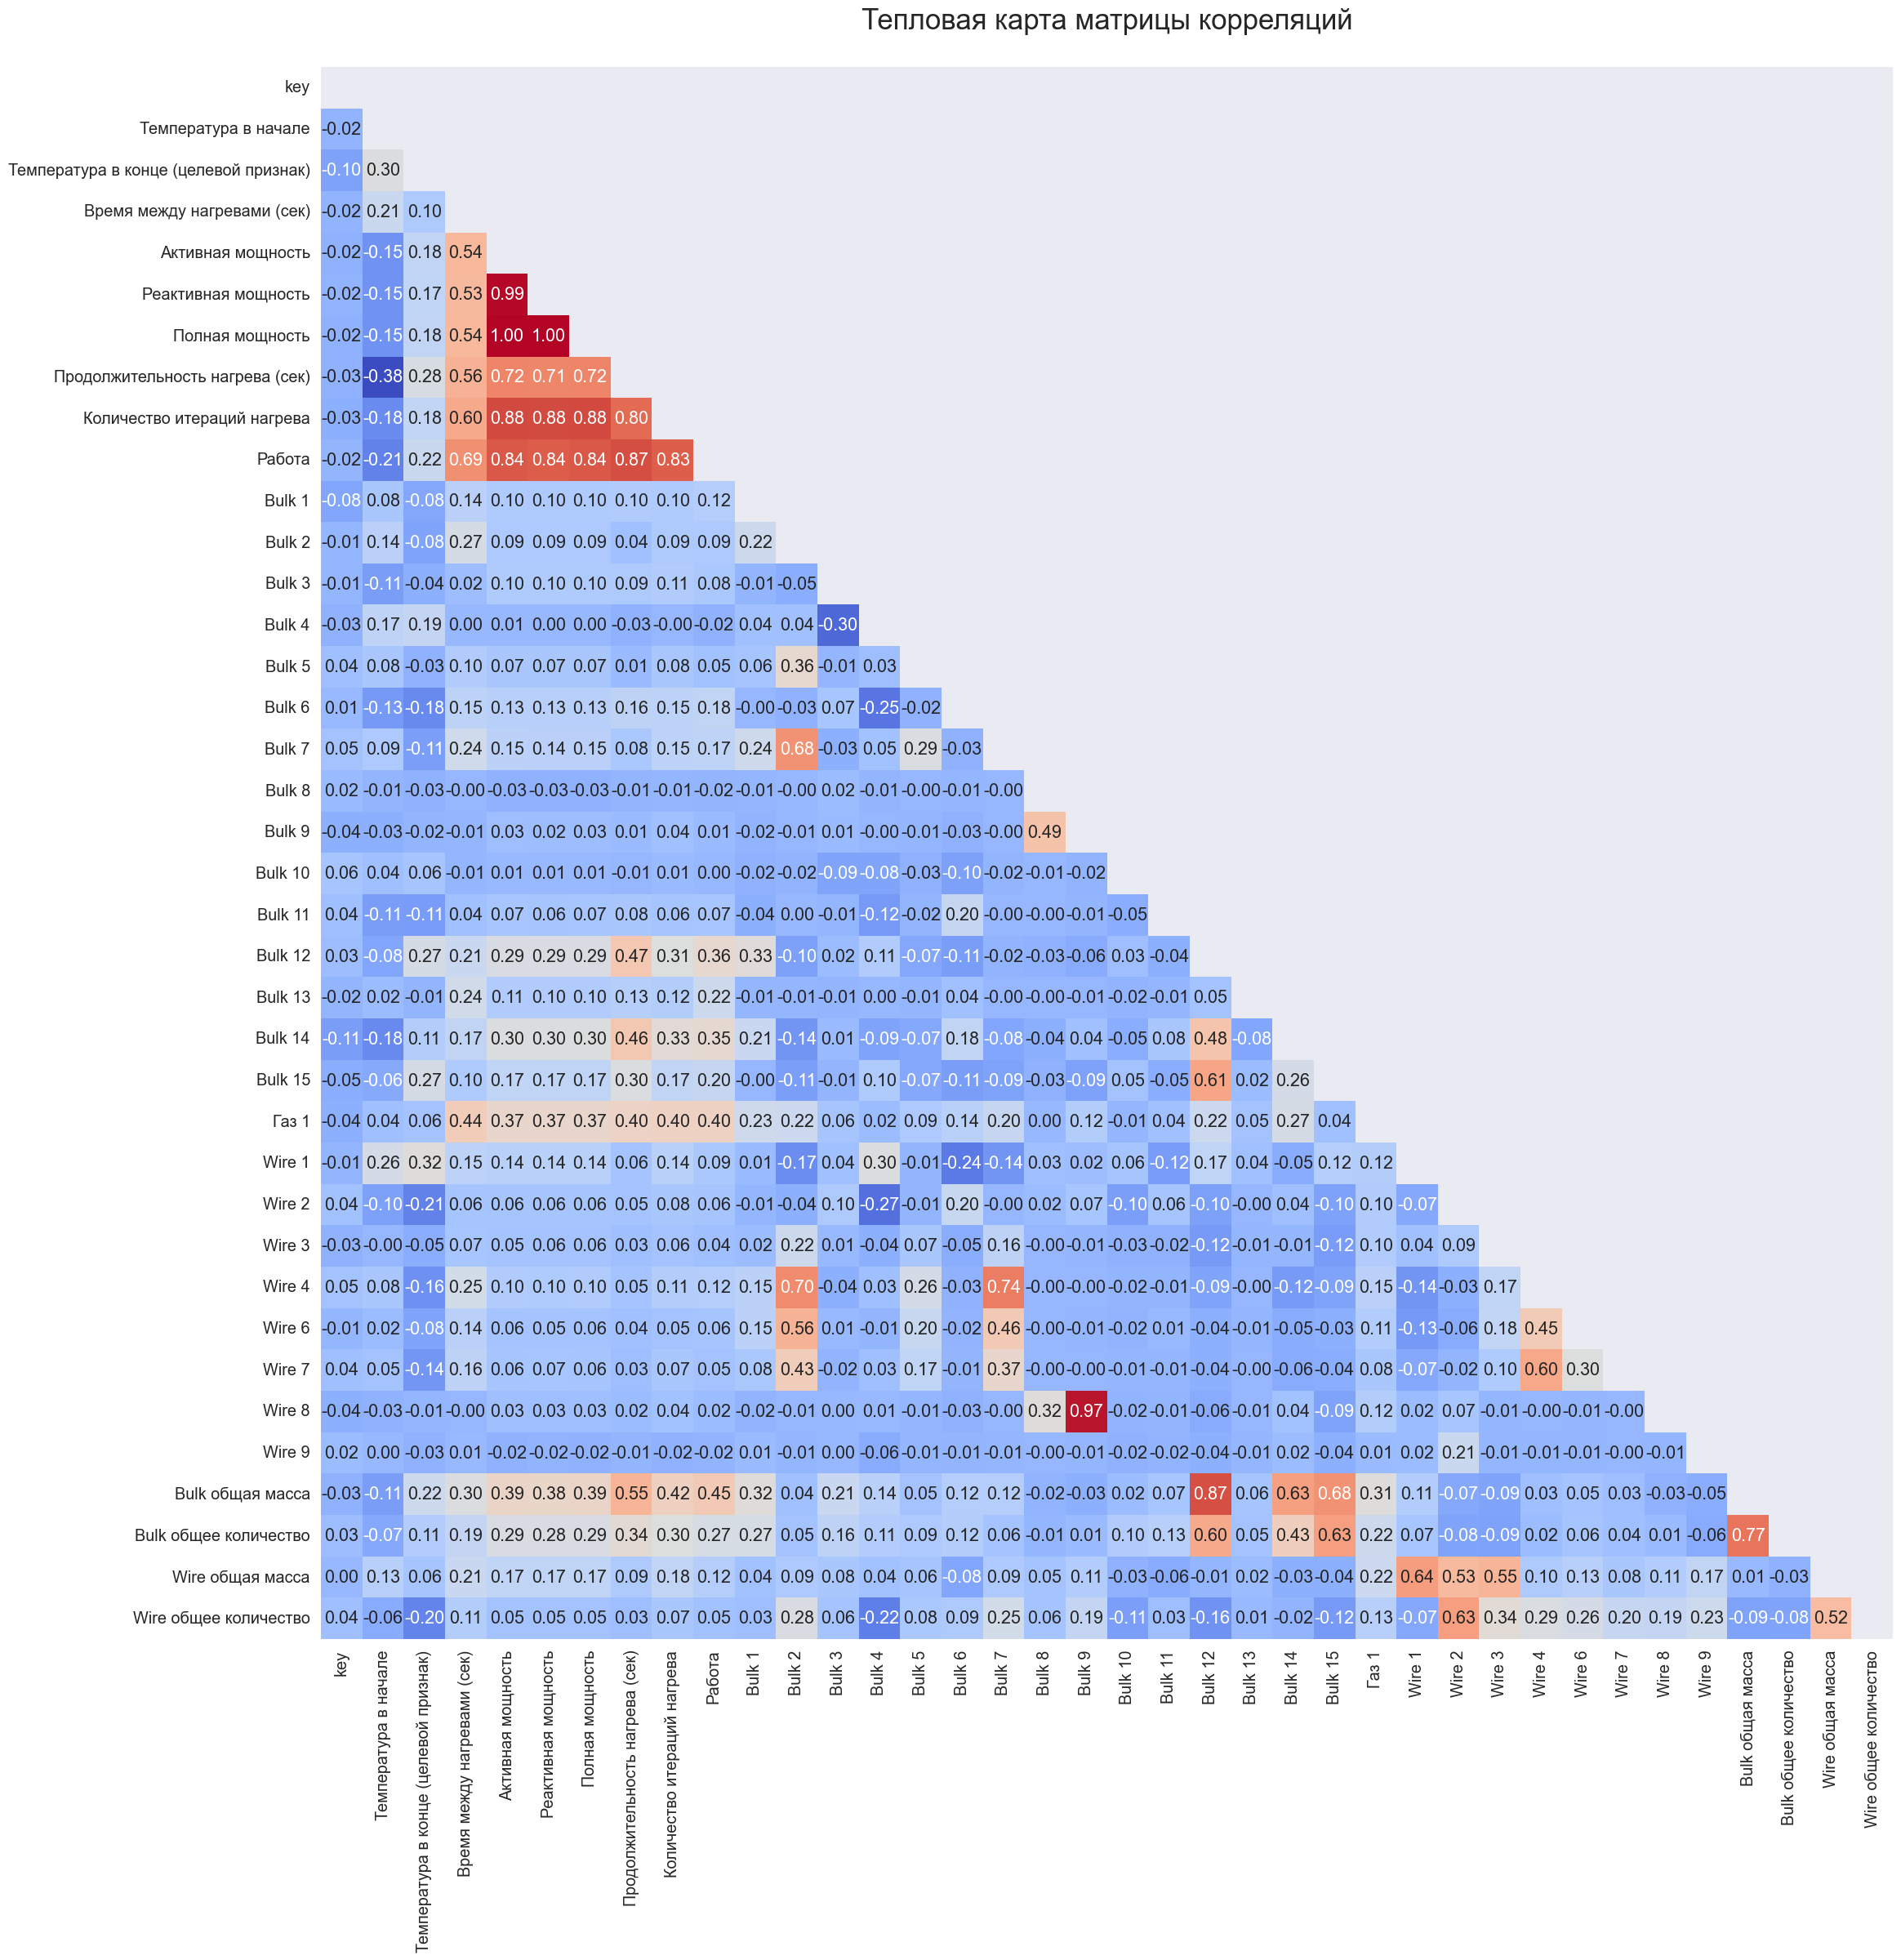

In [72]:
# построим тепловую карту корреляций

plt.figure(figsize=(25, 25))
matrix = np.triu(total_data.corr())
heatmap = sns.heatmap(total_data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2f')

heatmap.set_title('Тепловая карта матрицы корреляций\n', fontsize=25);

Отсортируем по целевому признаку и посмотрим на корреляции признаков с показателем температуры сплава в конце.

In [73]:
corr_overview = total_data.corr()
corr_overview.sort_values(by='Температура в конце (целевой признак)', ascending=False) \
             .style.background_gradient(cmap='coolwarm')

**Выводы**

Целевой признак сильнее всего коррелирует с такими параметрами, как:

- `Wire 1`,
- `Температура в начале`, 
- `Продолжительность нагрева (сек)`,
- `Bulk 12`,
- `Bulk 15`,
- `Вulk общая масса`,
- `Работа`.

Зависимость прямо пропорциональная, но не сильная (<0.5).

Обратно пропорционально целевой признак связан сильнее всего с 

- `Wire 2`, 
- `Wire общее количество`,
- `Bulk 6`, 
- `Wire 4`,

однако, эта связь также является слабой (0.2 и ниже).

Судя по диаграмме корреляций, у нас есть почти полная зависимость между `Wire 8` и `Bulk 9` и сильная между `Wire 4`, `Bulk 2` и `Bulk 7`. Такое состояние является мультиколлинеарностью, и перед подачей данных в модели, от нее нужно избавиться.

Также заметна сильная корреляция между собой признаков `Активная мощность`, `Реактивная мощность` и `Полная мощность`, так как они сильно связаны друг с другом по смыслу, а значения полной мощности являются просто результатом математических преобразований двух других колонок. В связи с этим, стоит сократить признаковое пространство и оставить только колонку `Полная мощность`. 

Рассмотрим отдельно наиболее сильные корреляции признаков друг с другом и выведем список тех фичей, у которых взаимозависимость особенно сильная (на уровне >= 0.5).

In [74]:
corr_triu = corr_overview.where(np.triu(np.ones(corr_overview.shape), k=1).astype(bool))
corr_triu = corr_triu.stack().reset_index()

corr_triu.columns = ['Row', 'Column', 'Value']
corr_strong = corr_triu.query('Value >= 0.5')

drop_names = pd.concat([pd.Series(corr_strong['Row'].unique()), pd.Series(corr_strong['Column'].unique())], ignore_index=True).drop_duplicates()
columns_to_drop = list(drop_names)
display(corr_strong.sort_values(by='Value', ascending=False))
columns_to_drop

Row                           Column  \
143                Активная мощность                  Полная мощность   
175              Реактивная мощность                  Полная мощность   
142                Активная мощность              Реактивная мощность   
526                           Bulk 9                           Wire 8   
145                Активная мощность      Количество итераций нагрева   
208                  Полная мощность      Количество итераций нагрева   
177              Реактивная мощность      Количество итераций нагрева   
239  Продолжительность нагрева (сек)                           Работа   
579                          Bulk 12                 Вulk общая масса   
146                Активная мощность                           Работа   
209                  Полная мощность                           Работа   
178              Реактивная мощность                           Работа   
268      Количество итераций нагрева                           Работа   
238  Продолжительность нагрева (сек)      Количество итераций нагрева   
697                 Вulk общая масса            Bulk общее количество   
484                           Bulk 7                           Wire 4   
144                Активная мощность  Продолжительность нагрева (сек)   
207                  Полная мощность  Продолжительность нагрева (сек)   
176              Реактивная мощность  Продолжительность нагрева (сек)   
369                           Bulk 2                           Wire 4   
113      Время между нагревами (сек)                           Работа   
356                           Bulk 2                           Bulk 7   
621                          Bulk 15                 Вulk общая масса   
646                           Wire 1                 Wire общая масса   
622                          Bulk 15            Bulk общее количество   
657                           Wire 2            Wire общее количество   
608                          Bulk 14                 Вulk общая масса   
569                          Bulk 12                          Bulk 15   
668                           Wire 4                           Wire 7   
580                          Bulk 12            Bulk общее количество   
112      Время между нагревами (сек)      Количество итераций нагрева   
111      Время между нагревами (сек)  Продолжительность нагрева (сек)   
370                           Bulk 2                           Wire 6   
665                           Wire 3                 Wire общая масса   
264  Продолжительность нагрева (сек)                 Вulk общая масса   
108      Время между нагревами (сек)                Активная мощность   
110      Время между нагревами (сек)                  Полная мощность   
109      Время между нагревами (сек)              Реактивная мощность   
656                           Wire 2                 Wire общая масса   
702                 Wire общая масса            Wire общее количество   

        Value  
143  0.999029  
175  0.996865  
142  0.992416  
526  0.974968  
145  0.884254  
208  0.883237  
177  0.877037  
239  0.874650  
579  0.867932  
146  0.844956  
209  0.843229  
178  0.835938  
268  0.828471  
238  0.798907  
697  0.768815  
484  0.740570  
144  0.720854  
207  0.719360  
176  0.713082  
369  0.699340  
113  0.688402  
356  0.679353  
621  0.677731  
646  0.637774  
622  0.633993  
657  0.633858  
608  0.628432  
569  0.614182  
668  0.602964  
580  0.598334  
112  0.595361  
111  0.562474  
370  0.558883  
665  0.551902  
264  0.551070  
108  0.539365  
110  0.538661  
109  0.534511  
656  0.528013  
702  0.520987

['Время между нагревами (сек)',
 'Активная мощность',
 'Реактивная мощность',
 'Полная мощность',
 'Продолжительность нагрева (сек)',
 'Количество итераций нагрева',
 'Bulk 2',
 'Bulk 7',
 'Bulk 9',
 'Bulk 12',
 'Bulk 14',
 'Bulk 15',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Вulk общая масса',
 'Wire общая масса',
 'Работа',
 'Wire 6',
 'Wire 8',
 'Bulk общее количество',
 'Wire общее количество',
 'Wire 7']

**Выводы**

Как мы видим, список коррелирующих признаков достаточно большой:

- `Bulk 9` и `Wire 8` имеет почти полную зависимость (0.974968),
- `Bulk 2`, `Bulk 7` и `Wire 7` связаны как между собой, так и сильно связаны с `Wire 4` (больше 0.6),
- `Wire 4` связан с `Wire 7` на уровне 0.6, также как и `Bulk 12` и `Bulk 15`,
- при этом корреляция с целевым признаком у данных фичей выражена очень слабо, исключением является разве что `Bulk 12`/`Bulk 15`, один из этих признаков можно оставить.

Кроме того из всех новых, сгенерированных нами самостоятельно фичей, следует оставить только те, которые сильно коррелируют с финальным замером температуры (например, `Продолжительность нагрева (сек)` и `Полная мощность`), остальные удалим.

Также важно отметить, что признаки `Bulk 8`, `Bulk 9` и `Wire 3` и `Wire 9` имеют почти нулевую корреляцию с остальными признаками, то есть их тоже можно удалить - чтобы не потерять информацию уже были созданы признаки с общим количеством и массой добавок.

### 4.2. Отбор признаков, разделение выборок.

In [75]:
total_data.head()

key  Температура в начале  Температура в конце (целевой признак)  \
0    1                1571.0                                 1613.0   
1    2                1581.0                                 1602.0   
2    3                1596.0                                 1599.0   
3    4                1601.0                                 1625.0   
4    5                1576.0                                 1602.0   

   Время между нагревами (сек)  Активная мощность  Реактивная мощность  \
0                         1714           3.036730             2.142821   
1                         1265           2.139408             1.453357   
2                         1753           4.063641             2.937457   
3                         1220           2.706489             2.056992   
4                         1536           2.252950             1.687991   

   Полная мощность  Продолжительность нагрева (сек)  \
0         3.718736                             1098   
1         2.588349                              811   
2         5.019223                              655   
3         3.400038                              741   
4         2.816980                              869   

   Количество итераций нагрева       Работа  Bulk 1  Bulk 2  Bulk 3  Bulk 4  \
0                            5  3334.329540     0.0     0.0     0.0    43.0   
1                            4  1735.059888     0.0     0.0     0.0    73.0   
2                            5  2661.684855     0.0     0.0     0.0    34.0   
3                            4  2005.508349     0.0     0.0     0.0    81.0   
4                            4  1957.813550     0.0     0.0     0.0    78.0   

   Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  \
0     0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
1     0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
2     0.0     0.0     0.0     0.0     0.0      0.0      0.0    205.0      0.0   
3     0.0     0.0     0.0     0.0     0.0      0.0      0.0    207.0      0.0   
4     0.0     0.0     0.0     0.0     0.0      0.0      0.0    203.0      0.0   

   Bulk 14  Bulk 15      Газ 1     Wire 1   Wire 2  Wire 3  Wire 4  Wire 6  \
0    150.0    154.0  29.749986  60.059998  0.00000     0.0     0.0     0.0   
1    149.0    154.0  12.555561  96.052315  0.00000     0.0     0.0     0.0   
2    152.0    153.0  28.554793  91.160157  0.00000     0.0     0.0     0.0   
3    153.0    154.0  18.841219  89.063515  0.00000     0.0     0.0     0.0   
4    151.0    152.0   5.413692  89.238236  9.11456     0.0     0.0     0.0   

   Wire 7  Wire 8  Wire 9  Вulk общая масса  Bulk общее количество  \
0     0.0     0.0     0.0             553.0                      4   
1     0.0     0.0     0.0             582.0                      4   
2     0.0     0.0     0.0             544.0                      4   
3     0.0     0.0     0.0             595.0                      4   
4     0.0     0.0     0.0             584.0                      4   

   Wire общая масса  Wire общее количество  
0         60.059998                      1  
1         96.052315                      1  
2         91.160157                      1  
3         89.063515                      1  
4         98.352796                      2

Избавимся от тех признаков, которые не потребуются в дальнейшем для обучения моделей. 

Такими признаками являются `key` партии, `Активная мощность` и `Реактивная мощность`, так как нами была создана агрегирующая метрика `Полная мощность` и те фичи, которые мы выявили в результате проведенного анализа корреляций, а именно

- `Wire 8`, так как очень значительно коррелирует с `Bulk 9`, и нужно оставить только один признак (а `Bulk 9` чуть сильнее связан с целевой переменной),
- `Bulk 2` и `Bulk 7`, так как они не только достаточно сильно коррелируют друг с другом (0.68), но также заметна сильная корреляция этих признаков с `Wire 4`,
- `Bulk 15`, так как есть сильная зависимость с `Bulk 12` (видимо признаки несут сходную информацию),
- `Количество итераций нагрева` и `Время между нагревами (сек)`, так как сильно коррелируют с `Продолжительность нагрева (сек)` (притом что влияние `Продолжительность нагрева (сек)` на целевую переменную в конечном итоге гораздо выше),
- `Работа` из-за наличия корреляции 0.87 с признаком `Продолжительность нагрева (сек)`,
- `Bulk общее количество` так как сильно дублирует по получаемой ценности информацию из признака `Bulk общая масса`,
- `Bulk 8`, `Bulk 9`, `Bulk 12`, `Wire 3`, `Wire 9`, так как имеют почти нулевую корреляцию с остальными признаками, то есть для модели важной информации, скорее всего, нести не будут.

In [76]:
features = total_data.drop(['Температура в конце (целевой признак)', 'key', 
                            'Время между нагревами (сек)', 'Активная мощность', 'Реактивная мощность', 
                            'Работа', 'Bulk общее количество', 'Количество итераций нагрева',
                            'Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 12', 'Bulk 15', 
                            'Wire 3', 'Wire 9', 'Wire 8', 'Wire 4', 'Wire общая масса'], axis=1)

target = total_data['Температура в конце (целевой признак)']

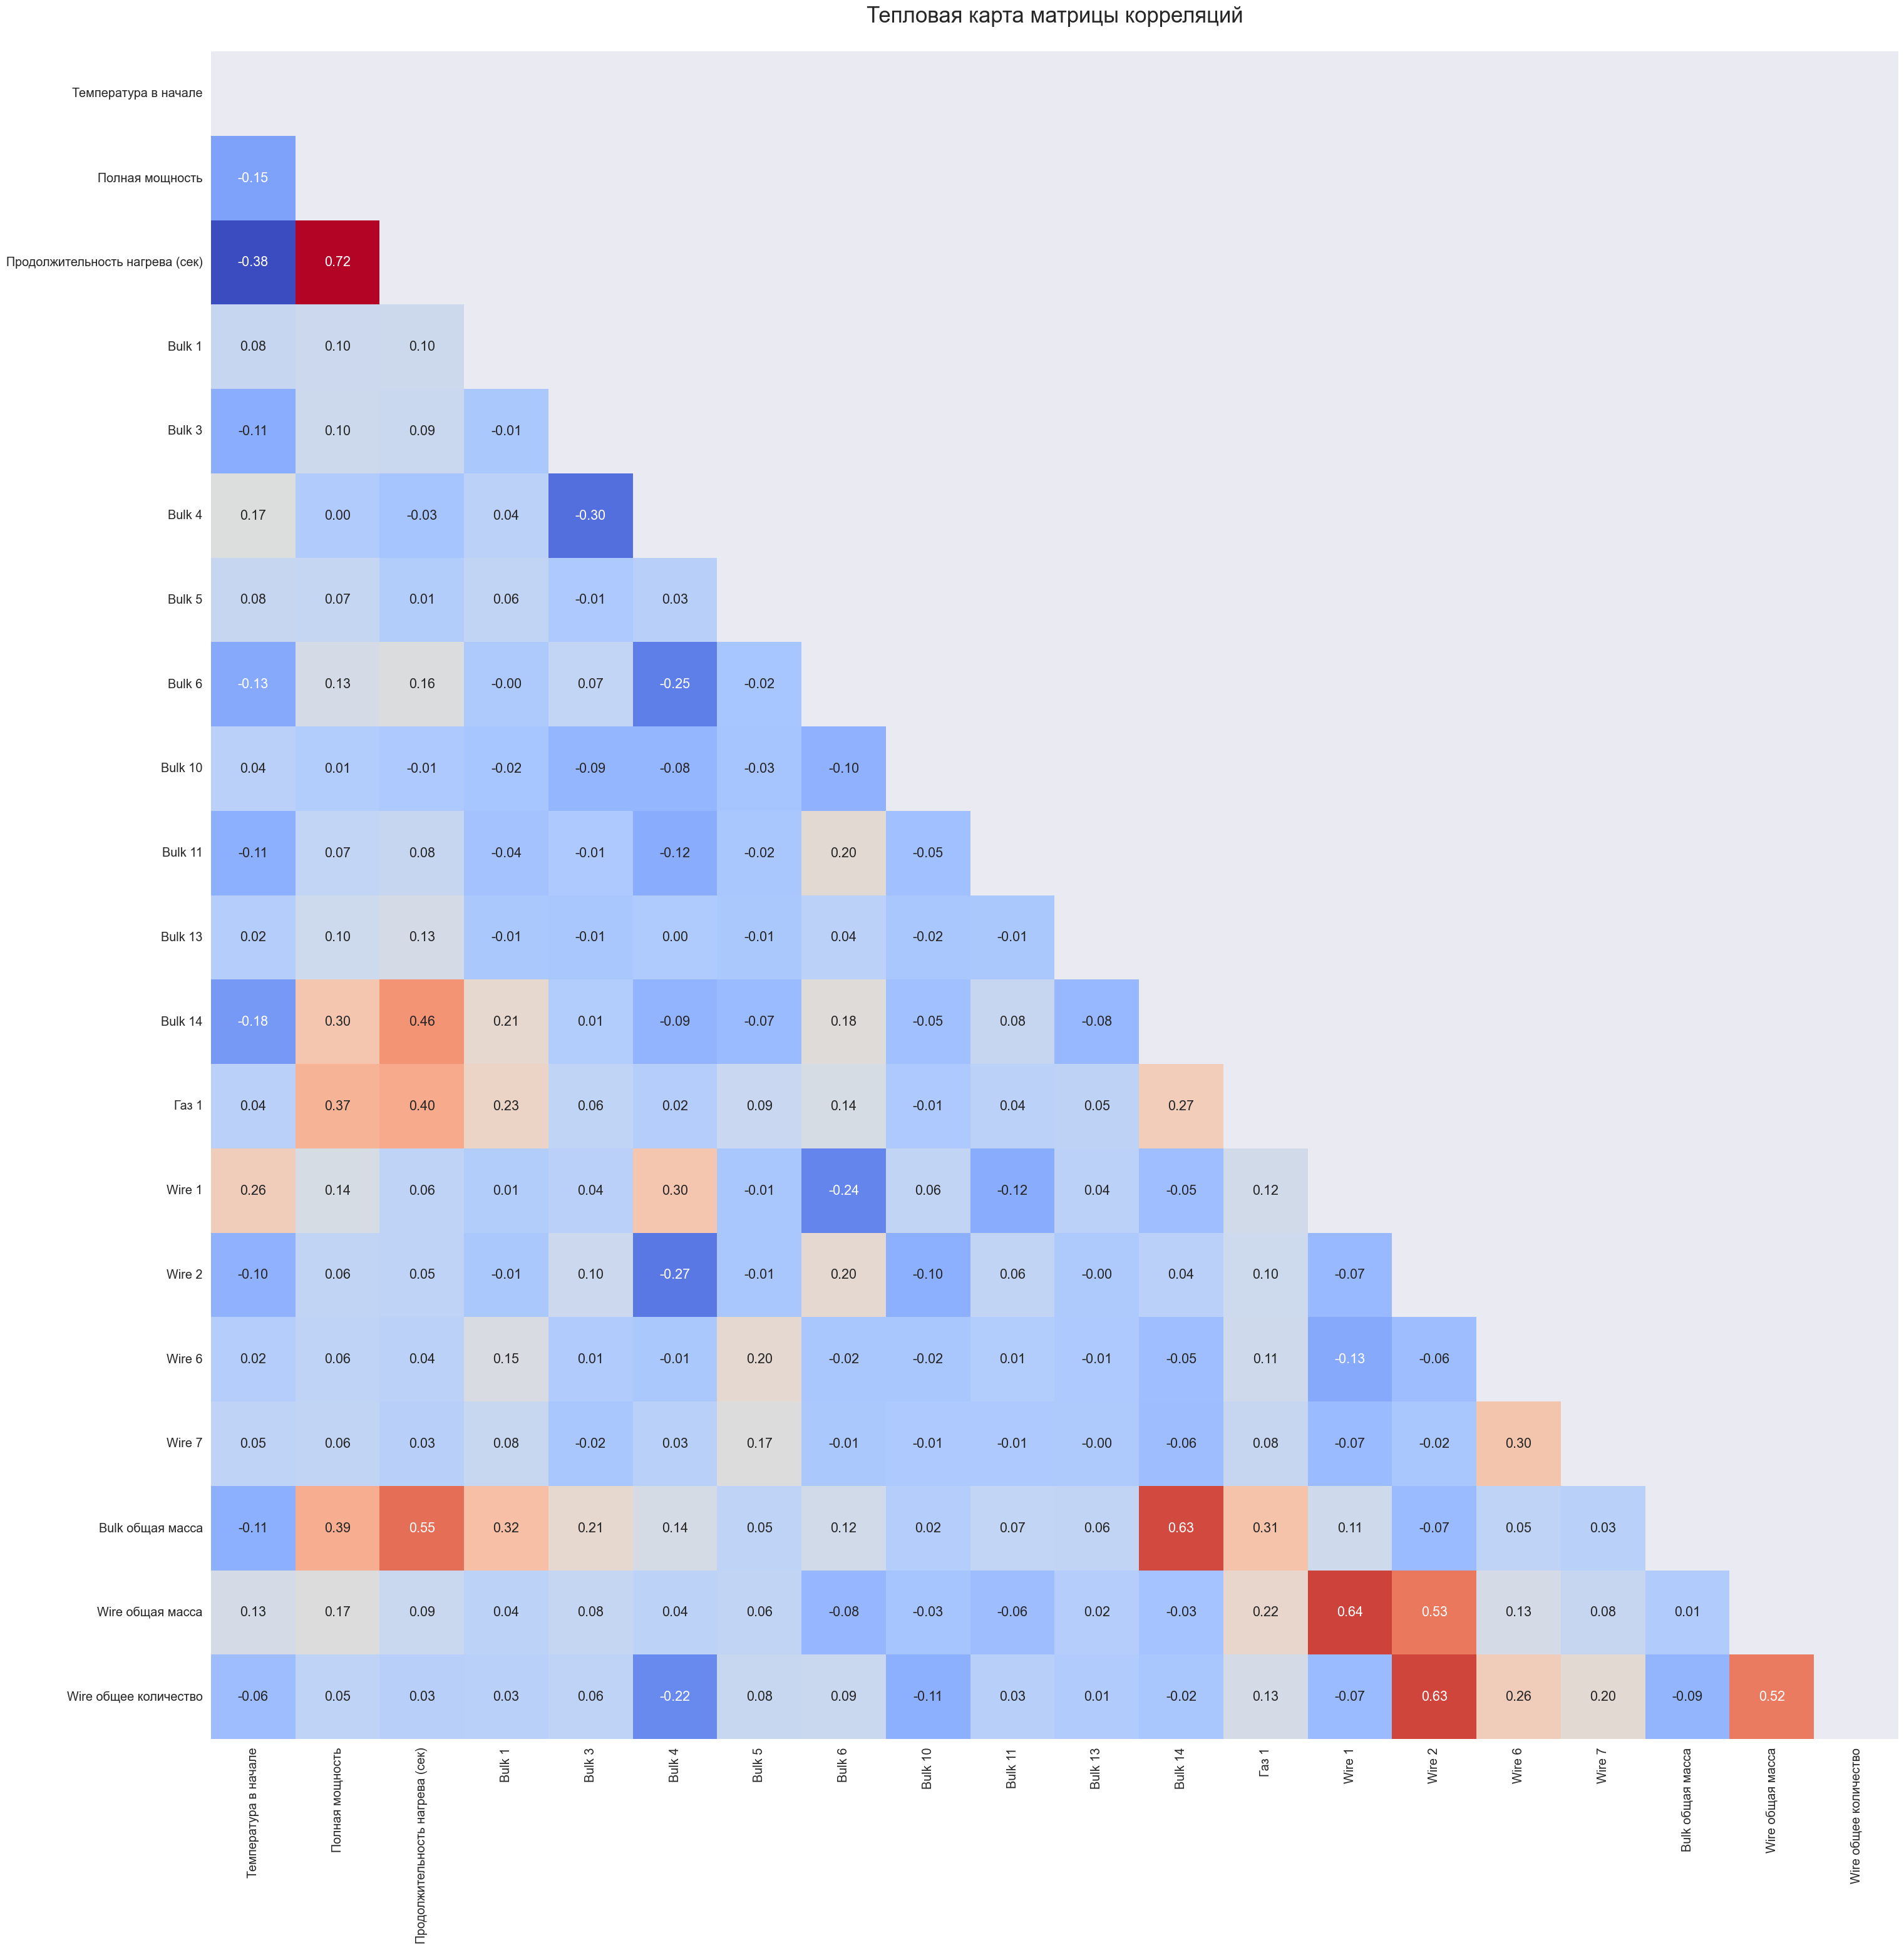

In [77]:
plt.figure(figsize=(35, 35))
matrix = np.triu(features.corr())
heatmap = sns.heatmap(features.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2f')
heatmap.set_title('Тепловая карта матрицы корреляций\n', fontsize=25);

`Полная мощность` продолжает иметь сильную корреляцию с `Продолжительность нагрева (сек)`, так как по логике процесса взаимосвязаны, однако, выбрасывание этого признака в дальнейшем не покажет особой разницы и только ухудшит предсказания. Поэтому будем считать, что на данном этапе процесс подготовки признаков завершен, и оставлены только нужные.

Наконец, разделим обучающую и тестовую выборку (для тестирования лучшей модели) в соотношении 3 к 1.

In [78]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE)

In [79]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1743, 20), (582, 20), (1743,), (582,))

In [80]:
features_train.head()

Температура в начале  Полная мощность  Продолжительность нагрева (сек)  \
189                 1591.0         3.738602                              710   
460                 1582.0         3.599779                              744   
1465                1570.0         4.684519                              831   
745                 1582.0         5.270071                             1477   
500                 1571.0         6.057216                             1734   

      Bulk 1  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 10  Bulk 11  Bulk 13  \
189      0.0     0.0   140.0     0.0     0.0      0.0      0.0      0.0   
460      0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1465     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0   
745      0.0     0.0   134.0     0.0     0.0      0.0      0.0      0.0   
500      0.0     0.0     0.0     0.0   114.0      0.0    174.0      0.0   

      Bulk 14      Газ 1      Wire 1     Wire 2  Wire 6  Wire 7  \
189     129.0   9.480324  177.035034   0.000000     0.0     0.0   
460     221.0   6.661032    0.000000  23.193039     0.0     0.0   
1465    101.0  10.933015   92.055596  45.119358     0.0     0.0   
745     154.0  10.913291  163.987198   0.000000     0.0     0.0   
500     262.0   6.660501   52.275597   0.000000     0.0     0.0   

      Вulk общая масса  Wire общая масса  Wire общее количество  
189              595.0        177.035034                      1  
460              531.0         23.193039                      1  
1465             409.0        137.174954                      2  
745              647.0        163.987198                      1  
500              655.0         52.275597                      1

Так как оценка моделей будет вестись с использованием кросс-валидации, то валидационная выборка не нужна.

### 4.3. Масштабирование признаков, формирование пайплайна, подготовка вспомогательных функций.

Численные признаки нужно подавать в модели в отмасштабированном виде, то есть привести к единой шкале значений - это можно сделать с помощью StandardScaler(). 

Предобработку данных будем проводить с помощью трансформера.

In [81]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Температура в начале             2325 non-null   float64
 1   Полная мощность                  2325 non-null   float64
 2   Продолжительность нагрева (сек)  2325 non-null   int64  
 3   Bulk 1                           2325 non-null   float64
 4   Bulk 3                           2325 non-null   float64
 5   Bulk 4                           2325 non-null   float64
 6   Bulk 5                           2325 non-null   float64
 7   Bulk 6                           2325 non-null   float64
 8   Bulk 10                          2325 non-null   float64
 9   Bulk 11                          2325 non-null   float64
 10  Bulk 13                          2325 non-null   float64
 11  Bulk 14                          2325 non-null   float64
 12  Газ 1               

In [82]:
# определяем трансформер для линейной модели

column_transformer = ColumnTransformer([('scale', StandardScaler(), features.columns)], remainder='passthrough')

In [83]:
column_transformer.transformers

[('scale',
  StandardScaler(),
  Index(['Температура в начале', 'Полная мощность',
         'Продолжительность нагрева (сек)', 'Bulk 1', 'Bulk 3', 'Bulk 4',
         'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 13', 'Bulk 14', 'Газ 1',
         'Wire 1', 'Wire 2', 'Wire 6', 'Wire 7', 'Вulk общая масса',
         'Wire общая масса', 'Wire общее количество'],
        dtype='object'))]

Обозначим функцию, которая будет проводить операцию кросс-валидации по метрикам `MAE` и `R2` внутри поиска лучших гиперпараметров по сетке, а затем получать метрики с лучшей модели и оформлять их в датафрейм.

In [84]:
def get_metrics_gridsearch(model, column_transformer, params, name):  
    '''функция возвращает метрики после поиска лучшей модели по сетке гиперпараметов и добавляет их в список'''
    
    df_metrics = pd.DataFrame()
    
    pipe = Pipeline([('preprocess', column_transformer),
                      ('model', model)])
    
    search = GridSearchCV(estimator=pipe,
                          param_grid=params,
                          scoring=['neg_mean_absolute_error', 'r2'],
                          refit='neg_mean_absolute_error',
                          cv=7,
                          n_jobs=-1)
    
    search.fit(features_train, target_train)
    
    best_model = search.best_estimator_
    best_index = search.best_index_
    results = search.cv_results_
    
    # значение метрик
    model_mae =  round(np.mean(abs(search.best_score_)), 4)
    model_r2 = round(np.mean(abs(search.cv_results_['mean_test_r2'])), 4) 
    # время обучения модели
    fit_time = results['mean_fit_time'][best_index]
    
    # время предсказания модели
    pred_time = results['mean_score_time'][best_index]
    
    df_metrics['Модель'] = [name]
    df_metrics['MAE'] = model_mae
    df_metrics['R2'] = model_r2                    
    df_metrics['Время обучения, сек'] = round(fit_time, 4)
    df_metrics['Время предсказания, сек'] = round(pred_time, 4)
    
    print('Параметры лучшей модели', search.best_params_)
    
    return best_model, df_metrics

Также нам потребуется функция визуализации важности признаков.

In [85]:
def get_feature_importances(model, features):
    '''функция визуализирует важность признаков для модели'''
    
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=features.columns)
    sorted_importances = feature_importances.sort_values()
    sorted_importances.plot(kind='barh', figsize=(15, 10))
    plt.xlabel('Название признака\n', fontsize=14, weight='bold')
    plt.ylabel('Важность', fontsize=14, weight='bold')
    plt.title('Важность признаков для модели\n', fontsize=14, weight='bold')
    plt.show()

### 4.4. Обучение моделей.

Обучим несколько моделей, проанализируем важность признаков для предсказаний, выберем лучшую модель и протестируем ее на тестовой выборке.

#### 4.4.1. Линейная регрессия без подбора гиперпараметров.

In [86]:
# объявляем модель
model_lr = LinearRegression()

# объявляем перебираемые гиперпараметры
params_lr = {}

In [87]:
best_model_lr, metrics = get_metrics_gridsearch(model_lr, column_transformer, params_lr, 'LinearRegression')
metrics

Параметры лучшей модели {}


Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   

   Время предсказания, сек  
0                   0.0036

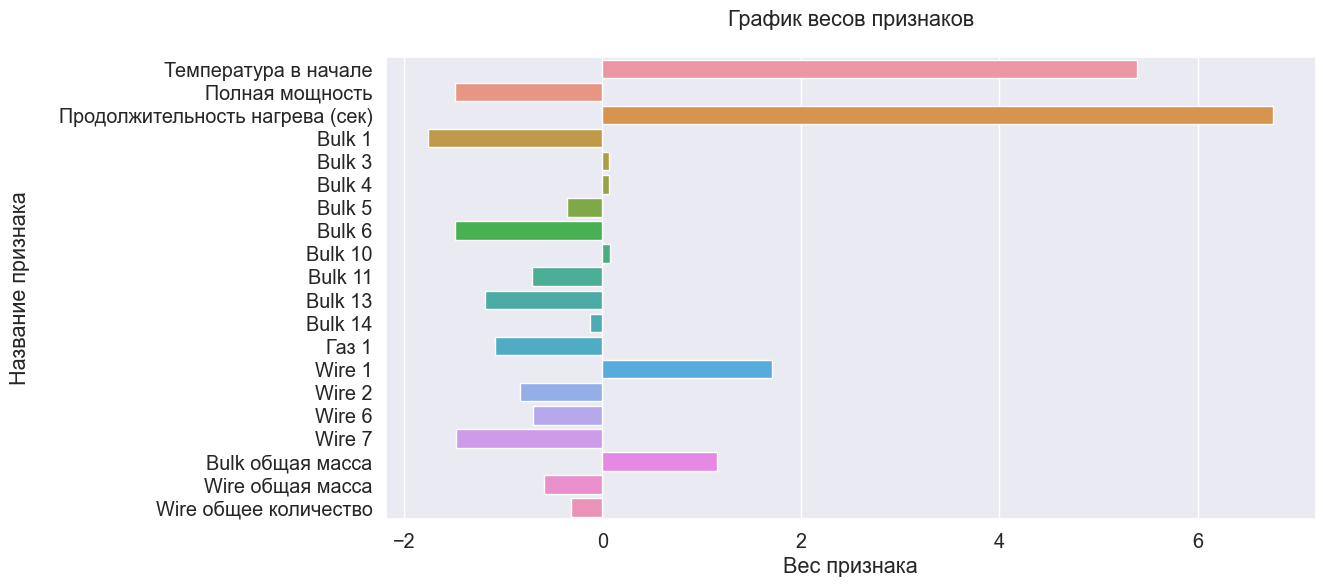

In [88]:
# получение весов признаков лучшей модели
weights = best_model_lr.named_steps['model'].coef_.flatten()
feature_names = features_train.columns

# создание датафрейма для отрисовки весов признаков
weights_df = pd.DataFrame({'feature': feature_names, 'weight': weights})

# отрисовка графика весов признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='weight', y='feature', data=weights_df, orient='h')
plt.xlabel('Вес признака')
plt.ylabel('Название признака\n')
plt.title('График весов признаков\n')
plt.show()

#### 4.4.2. ElasticNet с подбором гиперпараметров.

In [89]:
model_elastic = ElasticNet(random_state=RANDOM_STATE)

# объявляем перебираемые гиперпараметры
params_elastic = {'model__alpha' : np.arange(0.2, 0.9, 0.2),
                  'model__l1_ratio' : np.arange(0.2, 0.9, 0.2),
                  'model__max_iter' : range(500, 2001, 500)}  

In [90]:
best_model_elastic, metrics_elastic = get_metrics_gridsearch(model_elastic, column_transformer, params_elastic, 'ElasticNet')
metrics = metrics.append(metrics_elastic)
metrics

Параметры лучшей модели {'model__alpha': 0.2, 'model__l1_ratio': 0.8, 'model__max_iter': 500}


Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049

**Выводы**

- Были обучены линейные модели: линейная регрессия и ElasticNet с регуляризацией;
- Параметры лучшей модели для ElasticNet {'alpha': 0.2, 'l1_ratio': 0.8, 'max_iter': 500};
- Лучшие для линейных моделей значения метрик были достигнуты с использованием простой линейной регрессии `MAE` = 6.3115 и `R2` = 0.4097, эти результаты проходят по порогу заказчика;
- Наиболее важными признаками для модели являются: `Продолжительность нагрева (сек)`, `Температура в начале`, `Bulk 1`, `Bulk 6`, `Полная мощность`, `Wire 1`, `Wire 7`.

#### 4.4.3. Дерево решений с подбором гиперпараметров.

In [91]:
# объявляем модель
model_dec_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

# объявляем перебираемые гиперпараметры
params_dec_tree = {'model__max_depth' : range(10, 21, 1),
                   'model__min_samples_split' : range(5, 26, 5),
                   'model__min_samples_leaf' : range(2, 12, 3)}

In [92]:
best_model_dt, metrics_dec_tree = get_metrics_gridsearch(model_dec_tree, column_transformer, params_dec_tree, 'DecisionTree')
metrics = metrics.append(metrics_dec_tree)
metrics

Параметры лучшей модели {'model__max_depth': 10, 'model__min_samples_leaf': 11, 'model__min_samples_split': 25}


Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   
0      DecisionTree  7.1290  0.1485               0.0152   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044

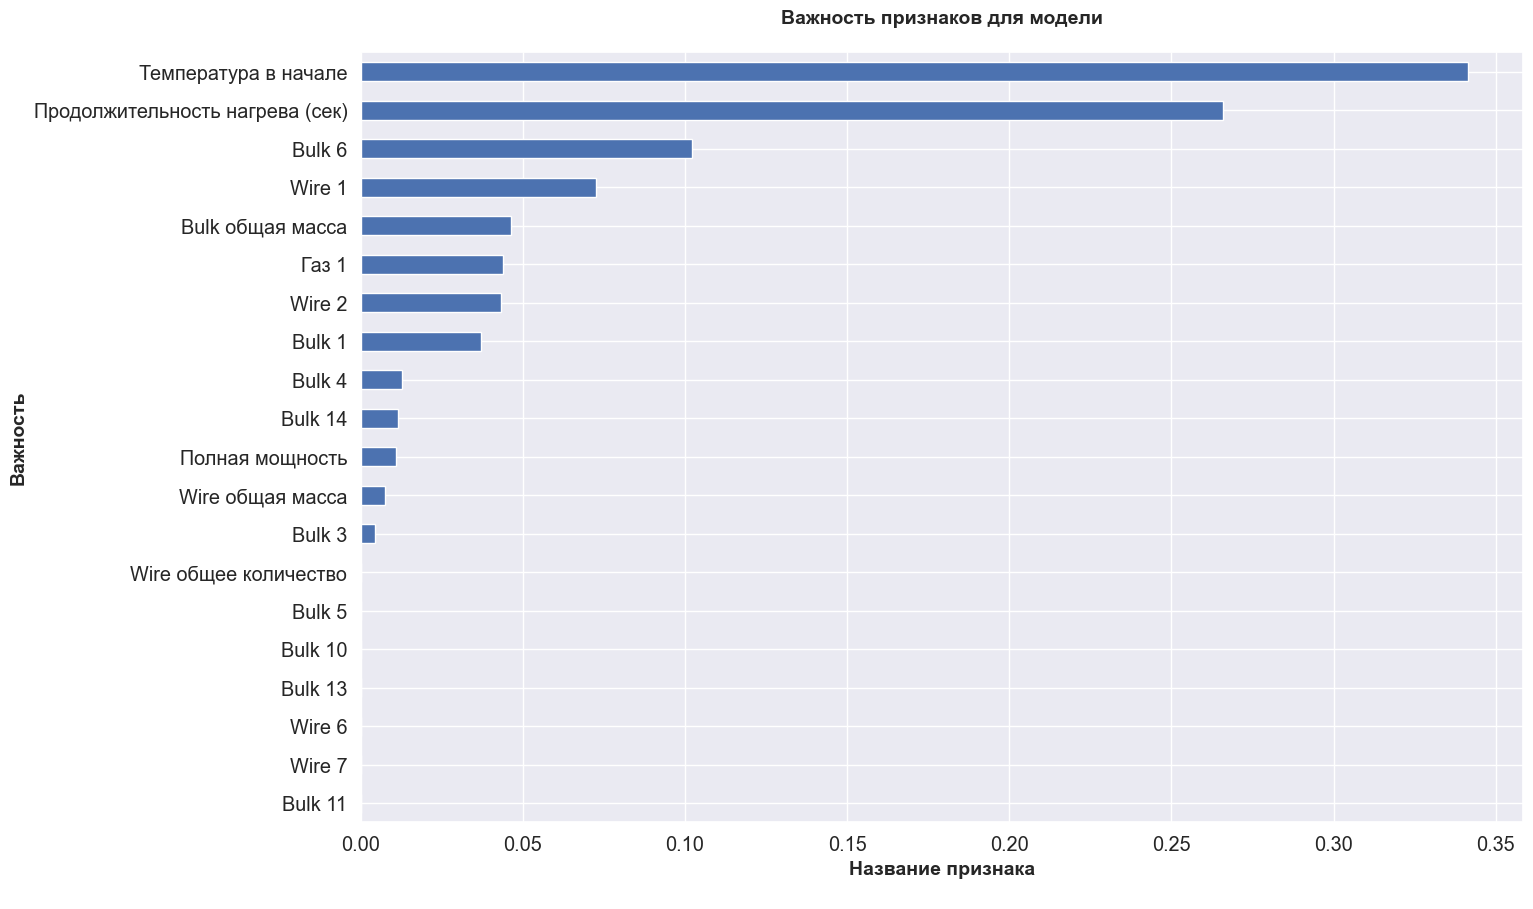

In [93]:
get_feature_importances(best_model_dt[1], features_train)

**Выводы**

- Была обучена модель Дерево решений с подбором гиперпараметров;
- Параметры лучшей модели {'max_depth': 10, 'min_samples_leaf': 11, 'min_samples_split': 25};
- Достигнуты значения метрик `MAE` = 7.1290	и `R2` = 0.1485, что ниже значений метрик, полученных ранее, и недостаточно для заказчика;
- Наиболее важными признаками для модели так же являются `Температура в начале`, `Продолжительность нагрева (сек)`, `Bulk 6`, `Wire 1`, но кроме этого `Bulk общая масса`, `Газ 1`, `Wire 2`, `Bulk 1`.

#### 4.4.4. Случайный лес с подбором гиперпараметров.

In [94]:
# объявляем модель 
model_rand_for = RandomForestRegressor(random_state=RANDOM_STATE)

# объявляем перебираемые гиперпараметры
params_rand_for = {'model__n_estimators' : range(10, 71, 10),
                   'model__max_depth' : [None] + [i for i in range(2, 7)],
                   'model__min_samples_split' : range(2, 7),
                   'model__min_samples_leaf' : range(2, 7)}

In [95]:
best_model_rf, metrics_rand_for = get_metrics_gridsearch(model_rand_for, column_transformer, params_rand_for, 'RandomForest')
metrics = metrics.append(metrics_rand_for)
metrics

Параметры лучшей модели {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6, 'model__n_estimators': 70}


Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   
0      DecisionTree  7.1290  0.1485               0.0152   
0      RandomForest  6.2697  0.3230               0.7682   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133

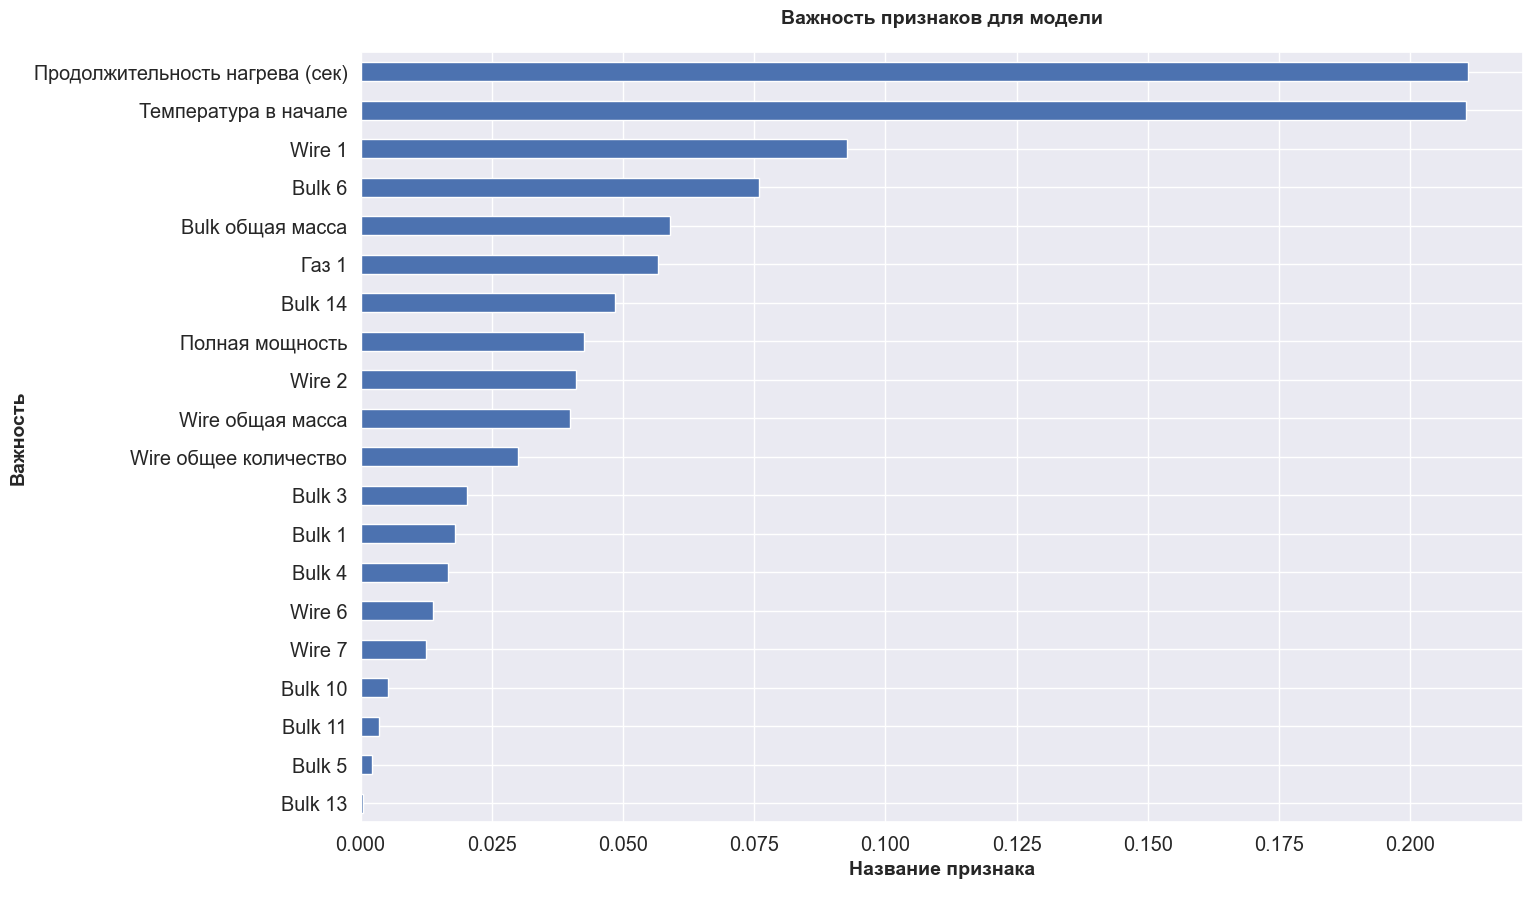

In [96]:
get_feature_importances(best_model_rf[1], features_train)

**Выводы**

- Был обучен ансамбль Случайный лес с  с подбором гиперпараметров;
- Параметры лучшей модели {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 70};
- Достигнуты значения метрик `MAE` = 6.2697	и `R2` = 0.3230, то есть модель позволяет выйти на новый уровень точности;
- Наиболее важными признаками для модели являются те же, что и для Случайного леса, так как обе модели являются представителями логического семейства моделей и выводы делают по одинаковому принципу, но особую важность в равной степени играют только первые два.

#### 4.4.4. LGBMRegressor без гиперпараметров и с подбором гиперпараметров с помощью Optuna.

In [97]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

params_lgbm = {}

In [98]:
best_model_lgbm_baseline, metrics_lgbm_baseline = get_metrics_gridsearch(model_lgbm, column_transformer, params_lgbm, 'LGBM_baseline')
metrics = metrics.append(metrics_lgbm_baseline)
metrics

Параметры лучшей модели {}


Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   
0      DecisionTree  7.1290  0.1485               0.0152   
0      RandomForest  6.2697  0.3230               0.7682   
0     LGBM_baseline  6.4592  0.3567               0.1172   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133  
0                   0.0106

In [99]:
def optuna_optimize_hyperparameters(model, features_train, target_train, params, name):

    df_metrics = pd.DataFrame()
    
    search_cv = OptunaSearchCV(estimator=model, 
                               param_distributions=params,
                               scoring='neg_mean_absolute_error',
                               cv=5, 
                               n_jobs=-1, 
                               verbose=2,
                               n_trials=100,
                               random_state=RANDOM_STATE)
    
    search_cv.fit(features_train, target_train)
    
    best_model = search_cv.best_estimator_
    best_index = search_cv.best_index_
    best_params = search_cv.best_params_
    
    scores = cross_validate(search_cv, features_train, target_train, cv=7, scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2'})
    print(scores)
    print(f'Параметры лучшей модели по результатам испытаний:\n\n {best_params}')
    
    # значение метрик
    model_mae = round(abs(np.mean(scores['test_mae'])), 4)
    model_r2 = round(np.mean(scores['test_r2']), 4)
   
    # время обучения модели
    fit_time = round(np.mean(scores['fit_time']), 4)
    # время предсказания модели
    pred_time = round(np.mean(scores['score_time']), 4)
    
    df_metrics['Модель'] = [name]
    df_metrics['MAE'] = model_mae
    df_metrics['R2'] = model_r2                    
    df_metrics['Время обучения, сек'] = round(fit_time, 4)
    df_metrics['Время предсказания, сек'] = round(pred_time, 4)
    
    print('Параметры лучшей модели', best_params)
    
    return best_model, df_metrics

In [100]:
model_lgbm = LGBMRegressor()

params_lgbm = {'boosting_type':optuna.distributions.CategoricalDistribution(['gbdt', 'dart', 'goss']),
               'learning_rate': optuna.distributions.FloatDistribution(0.1, 0.5, 0.05),
               'n_estimators': optuna.distributions.IntDistribution(100, 300, 30),
               'num_leaves': optuna.distributions.IntDistribution(10, 200, 15),
               'max_depth': optuna.distributions.IntDistribution(6, 20, 2),
               'subsample_for_bin': optuna.distributions.IntDistribution(1000, 200000, 1000),
               'min_child_samples': optuna.distributions.IntDistribution(100, 500, 50),
               'colsample_bytree': optuna.distributions.FloatDistribution(0.2, 1, 0.1)}

In [101]:
best_model_lgbm_opt, metrics_lgbm_opt = optuna_optimize_hyperparameters(model_lgbm, 
                                                                        features_train, target_train, 
                                                                        params_lgbm, 'LGBM_optuna')

metrics = metrics.append(metrics_lgbm_opt)

[I 2023-06-21 01:19:41,622] A new study created in memory with name: no-name-6fc7192d-43cf-4ec7-a67a-92ae96fc7f34
[I 2023-06-21 01:19:41,623] Searching the best hyperparameters using 1743 samples...
[I 2023-06-21 01:19:42,124] Trial 4 finished with value: -7.716788412566108 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.23056751806270953, 'n_estimators': 115, 'num_leaves': 92, 'max_depth': 14, 'subsample_for_bin': 10348, 'min_child_samples': 473, 'colsample_bytree': 0.2989161461481003}. Best is trial 4 with value: -7.716788412566108.
[I 2023-06-21 01:19:42,135] Trial 5 finished with value: -7.704862659711415 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.108122435070462, 'n_estimators': 111, 'num_leaves': 43, 'max_depth': 11, 'subsample_for_bin': 24348, 'min_child_samples': 479, 'colsample_bytree': 0.3959059243057037}. Best is trial 5 with value: -7.704862659711415.
[I 2023-06-21 01:19:42,216] Trial 13 finished with value: -7.519819030634326 and parameters: 

[I 2023-06-21 01:19:45,890] Trial 26 finished with value: -6.668800753146728 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.32042222329308506, 'n_estimators': 160, 'num_leaves': 10, 'max_depth': 6, 'subsample_for_bin': 1863, 'min_child_samples': 153, 'colsample_bytree': 0.5283282773270276}. Best is trial 17 with value: -6.5287734898922025.
[I 2023-06-21 01:19:46,008] Trial 33 finished with value: -6.581578777493396 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1494092995787812, 'n_estimators': 130, 'num_leaves': 11, 'max_depth': 6, 'subsample_for_bin': 1005, 'min_child_samples': 183, 'colsample_bytree': 0.2034227689837069}. Best is trial 17 with value: -6.5287734898922025.
[I 2023-06-21 01:19:46,041] Trial 24 finished with value: -8.648474158986733 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.4853398103383907, 'n_estimators': 179, 'num_leaves': 88, 'max_depth': 18, 'subsample_for_bin': 14163, 'min_child_samples': 271, 'colsample_bytree': 0.8

[I 2023-06-21 01:19:48,870] Trial 46 finished with value: -6.571974704781039 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1891966747230228, 'n_estimators': 118, 'num_leaves': 15, 'max_depth': 7, 'subsample_for_bin': 3844, 'min_child_samples': 210, 'colsample_bytree': 0.3723497571288765}. Best is trial 42 with value: -6.4847258358417035.
[I 2023-06-21 01:19:49,488] Trial 49 finished with value: -6.589243571909542 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1344138527625693, 'n_estimators': 100, 'num_leaves': 15, 'max_depth': 10, 'subsample_for_bin': 3623, 'min_child_samples': 214, 'colsample_bytree': 0.3774100029390899}. Best is trial 42 with value: -6.4847258358417035.
[I 2023-06-21 01:19:49,559] Trial 47 finished with value: -6.558418026763152 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13303290565400666, 'n_estimators': 119, 'num_leaves': 15, 'max_depth': 7, 'subsample_for_bin': 4427, 'min_child_samples': 215, 'colsample_bytree': 0.39

[I 2023-06-21 01:19:51,779] Trial 65 finished with value: -6.595107179628021 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1433101763877514, 'n_estimators': 109, 'num_leaves': 20, 'max_depth': 8, 'subsample_for_bin': 2696, 'min_child_samples': 237, 'colsample_bytree': 0.42716910101645134}. Best is trial 42 with value: -6.4847258358417035.
[I 2023-06-21 01:19:51,871] Trial 9 finished with value: -7.175657403260738 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.4281187676766223, 'n_estimators': 298, 'num_leaves': 63, 'max_depth': 8, 'subsample_for_bin': 172495, 'min_child_samples': 127, 'colsample_bytree': 0.4760214298140852}. Best is trial 42 with value: -6.4847258358417035.
[I 2023-06-21 01:19:51,919] Trial 68 finished with value: -6.5774607561488905 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14517347614040357, 'n_estimators': 109, 'num_leaves': 20, 'max_depth': 8, 'subsample_for_bin': 2494, 'min_child_samples': 235, 'colsample_bytree': 0.

[I 2023-06-21 01:19:55,267] Trial 92 finished with value: -64.50023728703165 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.158713120638443, 'n_estimators': 123, 'num_leaves': 14, 'max_depth': 9, 'subsample_for_bin': 3397, 'min_child_samples': 174, 'colsample_bytree': 0.4508371547163897}. Best is trial 42 with value: -6.4847258358417035.
[I 2023-06-21 01:19:55,303] Trial 89 finished with value: -84.62872932723555 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1560768973734342, 'n_estimators': 134, 'num_leaves': 13, 'max_depth': 9, 'subsample_for_bin': 1880, 'min_child_samples': 177, 'colsample_bytree': 0.44760791121326327}. Best is trial 42 with value: -6.4847258358417035.
[I 2023-06-21 01:19:55,347] Trial 90 finished with value: -82.49592037244497 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1600896951679139, 'n_estimators': 134, 'num_leaves': 13, 'max_depth': 9, 'subsample_for_bin': 3201, 'min_child_samples': 176, 'colsample_bytree': 0.4574

[I 2023-06-21 01:19:58,323] Trial 1 finished with value: -6.857190355362471 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.2719759397336592, 'n_estimators': 230, 'num_leaves': 19, 'max_depth': 6, 'subsample_for_bin': 44308, 'min_child_samples': 104, 'colsample_bytree': 0.4906832819540739}. Best is trial 1 with value: -6.857190355362471.
[I 2023-06-21 01:19:58,489] Trial 15 finished with value: -6.760915588408055 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14407333263457492, 'n_estimators': 216, 'num_leaves': 43, 'max_depth': 11, 'subsample_for_bin': 4984, 'min_child_samples': 236, 'colsample_bytree': 0.21347558837864244}. Best is trial 15 with value: -6.760915588408055.
[I 2023-06-21 01:19:58,622] Trial 18 finished with value: -6.666919836996653 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.33535285049664276, 'n_estimators': 115, 'num_leaves': 10, 'max_depth': 9, 'subsample_for_bin': 7657, 'min_child_samples': 185, 'colsample_bytree': 0.434

[I 2023-06-21 01:20:02,166] Trial 42 finished with value: -6.553495405027704 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10642718977509803, 'n_estimators': 117, 'num_leaves': 62, 'max_depth': 7, 'subsample_for_bin': 14361, 'min_child_samples': 168, 'colsample_bytree': 0.4060651987988009}. Best is trial 42 with value: -6.553495405027704.
[I 2023-06-21 01:20:02,473] Trial 0 finished with value: -10.168758764599435 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.27589944649641274, 'n_estimators': 247, 'num_leaves': 10, 'max_depth': 16, 'subsample_for_bin': 45670, 'min_child_samples': 170, 'colsample_bytree': 0.45190089263823424}. Best is trial 42 with value: -6.553495405027704.
[I 2023-06-21 01:20:02,613] Trial 20 finished with value: -87.18482318714567 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.11818119662648448, 'n_estimators': 207, 'num_leaves': 32, 'max_depth': 18, 'subsample_for_bin': 4110, 'min_child_samples': 146, 'colsample_bytree': 

[I 2023-06-21 01:20:05,798] Trial 57 finished with value: -6.491905565875028 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12510760739495788, 'n_estimators': 122, 'num_leaves': 14, 'max_depth': 15, 'subsample_for_bin': 12136, 'min_child_samples': 111, 'colsample_bytree': 0.3495904927282205}. Best is trial 56 with value: -6.481906469198018.
[I 2023-06-21 01:20:06,127] Trial 59 finished with value: -6.501273320732333 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12538227017880432, 'n_estimators': 124, 'num_leaves': 15, 'max_depth': 15, 'subsample_for_bin': 11374, 'min_child_samples': 112, 'colsample_bytree': 0.3462529281691292}. Best is trial 56 with value: -6.481906469198018.
[I 2023-06-21 01:20:06,314] Trial 58 finished with value: -6.472286939865926 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12388258722248291, 'n_estimators': 124, 'num_leaves': 15, 'max_depth': 15, 'subsample_for_bin': 10844, 'min_child_samples': 106, 'colsample_bytree':

[I 2023-06-21 01:20:10,487] Trial 85 finished with value: -6.800601581097636 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.1321757955313087, 'n_estimators': 140, 'num_leaves': 20, 'max_depth': 16, 'subsample_for_bin': 27254, 'min_child_samples': 109, 'colsample_bytree': 0.5178071489917212}. Best is trial 58 with value: -6.472286939865926.
[I 2023-06-21 01:20:10,577] Trial 86 finished with value: -6.821921345368224 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.13403956747383045, 'n_estimators': 138, 'num_leaves': 19, 'max_depth': 16, 'subsample_for_bin': 10709, 'min_child_samples': 109, 'colsample_bytree': 0.5227943249065135}. Best is trial 58 with value: -6.472286939865926.
[I 2023-06-21 01:20:10,710] Trial 79 finished with value: -154.97246097309284 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1309425912489771, 'n_estimators': 137, 'num_leaves': 19, 'max_depth': 20, 'subsample_for_bin': 28434, 'min_child_samples': 110, 'colsample_bytree': 

[I 2023-06-21 01:20:13,360] Trial 5 finished with value: -7.622859507847464 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.43710245019034316, 'n_estimators': 229, 'num_leaves': 15, 'max_depth': 12, 'subsample_for_bin': 1519, 'min_child_samples': 189, 'colsample_bytree': 0.46591617477631897}. Best is trial 5 with value: -7.622859507847464.
[I 2023-06-21 01:20:13,436] Trial 2 finished with value: -7.778274438763357 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.2569167511739124, 'n_estimators': 238, 'num_leaves': 64, 'max_depth': 13, 'subsample_for_bin': 18337, 'min_child_samples': 356, 'colsample_bytree': 0.4581352925774231}. Best is trial 5 with value: -7.622859507847464.
[I 2023-06-21 01:20:13,501] Trial 13 finished with value: -7.107509697900508 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.2827896205956373, 'n_estimators': 144, 'num_leaves': 18, 'max_depth': 14, 'subsample_for_bin': 8998, 'min_child_samples': 155, 'colsample_bytree': 0.6746

[I 2023-06-21 01:20:16,756] Trial 9 finished with value: -6.721494931404129 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1529534014942933, 'n_estimators': 214, 'num_leaves': 160, 'max_depth': 6, 'subsample_for_bin': 1019, 'min_child_samples': 120, 'colsample_bytree': 0.27210752846744674}. Best is trial 25 with value: -6.6604616917811965.
[I 2023-06-21 01:20:16,773] Trial 31 finished with value: -6.87316169938692 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10043529032755442, 'n_estimators': 124, 'num_leaves': 33, 'max_depth': 6, 'subsample_for_bin': 187298, 'min_child_samples': 266, 'colsample_bytree': 0.5689368864789507}. Best is trial 25 with value: -6.6604616917811965.
[I 2023-06-21 01:20:16,895] Trial 30 finished with value: -6.815265320430112 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10382493164967845, 'n_estimators': 128, 'num_leaves': 29, 'max_depth': 6, 'subsample_for_bin': 199442, 'min_child_samples': 260, 'colsample_bytree': 

[I 2023-06-21 01:20:20,837] Trial 52 finished with value: -6.559183506583608 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19424922349169135, 'n_estimators': 115, 'num_leaves': 52, 'max_depth': 7, 'subsample_for_bin': 73552, 'min_child_samples': 134, 'colsample_bytree': 0.4039924702723368}. Best is trial 52 with value: -6.559183506583608.
[I 2023-06-21 01:20:20,906] Trial 51 finished with value: -6.6561194661851015 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19146014523335156, 'n_estimators': 116, 'num_leaves': 55, 'max_depth': 7, 'subsample_for_bin': 67949, 'min_child_samples': 124, 'colsample_bytree': 0.3111788691151409}. Best is trial 52 with value: -6.559183506583608.
[I 2023-06-21 01:20:21,047] Trial 53 finished with value: -6.568133456915748 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19013158282683038, 'n_estimators': 115, 'num_leaves': 13, 'max_depth': 7, 'subsample_for_bin': 73082, 'min_child_samples': 125, 'colsample_bytree': 0

[I 2023-06-21 01:20:23,251] Trial 74 finished with value: -6.950588763969878 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.17145102390859931, 'n_estimators': 109, 'num_leaves': 16, 'max_depth': 7, 'subsample_for_bin': 48557, 'min_child_samples': 114, 'colsample_bytree': 0.4277672714789901}. Best is trial 61 with value: -6.533056786565051.
[I 2023-06-21 01:20:23,362] Trial 64 finished with value: -6.555940608520681 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18031656256238973, 'n_estimators': 111, 'num_leaves': 163, 'max_depth': 7, 'subsample_for_bin': 67239, 'min_child_samples': 115, 'colsample_bytree': 0.41607474604139644}. Best is trial 61 with value: -6.533056786565051.
[I 2023-06-21 01:20:23,522] Trial 76 finished with value: -6.955974403807815 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.22358191174113315, 'n_estimators': 108, 'num_leaves': 12, 'max_depth': 7, 'subsample_for_bin': 56747, 'min_child_samples': 113, 'colsample_bytree': 

[I 2023-06-21 01:20:26,703] Trial 94 finished with value: -179.55071548147754 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.16259804893464588, 'n_estimators': 105, 'num_leaves': 18, 'max_depth': 8, 'subsample_for_bin': 29430, 'min_child_samples': 101, 'colsample_bytree': 0.4672462198332881}. Best is trial 86 with value: -6.455590504493965.
[I 2023-06-21 01:20:26,827] Trial 95 finished with value: -178.38096112687185 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.16382320050302102, 'n_estimators': 105, 'num_leaves': 11, 'max_depth': 8, 'subsample_for_bin': 41476, 'min_child_samples': 107, 'colsample_bytree': 0.4510813060800896}. Best is trial 86 with value: -6.455590504493965.
[I 2023-06-21 01:20:27,022] Trial 96 finished with value: -132.40210333446183 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.15825472742873947, 'n_estimators': 104, 'num_leaves': 18, 'max_depth': 8, 'subsample_for_bin': 45032, 'min_child_samples': 100, 'colsample_bytree':

[I 2023-06-21 01:20:29,833] Trial 14 finished with value: -7.005328750799606 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.4614771334794615, 'n_estimators': 143, 'num_leaves': 14, 'max_depth': 18, 'subsample_for_bin': 95176, 'min_child_samples': 117, 'colsample_bytree': 0.7486124622232955}. Best is trial 2 with value: -6.805978072978125.
[I 2023-06-21 01:20:30,288] Trial 19 finished with value: -7.284630883707298 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.36512198800070494, 'n_estimators': 267, 'num_leaves': 23, 'max_depth': 10, 'subsample_for_bin': 24416, 'min_child_samples': 133, 'colsample_bytree': 0.32471193125834735}. Best is trial 2 with value: -6.805978072978125.
[I 2023-06-21 01:20:30,699] Trial 16 finished with value: -7.139590560727936 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.44888012013236506, 'n_estimators': 284, 'num_leaves': 87, 'max_depth': 9, 'subsample_for_bin': 5108, 'min_child_samples': 102, 'colsample_bytree': 0.2

[I 2023-06-21 01:20:33,336] Trial 31 finished with value: -6.826514111553434 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.32087048804694646, 'n_estimators': 300, 'num_leaves': 10, 'max_depth': 12, 'subsample_for_bin': 1020, 'min_child_samples': 253, 'colsample_bytree': 0.23441331282856748}. Best is trial 28 with value: -6.595949869802823.
[I 2023-06-21 01:20:33,650] Trial 33 finished with value: -6.793699953077668 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.31747777415357614, 'n_estimators': 218, 'num_leaves': 58, 'max_depth': 14, 'subsample_for_bin': 1236, 'min_child_samples': 242, 'colsample_bytree': 0.22838959239916476}. Best is trial 28 with value: -6.595949869802823.
[I 2023-06-21 01:20:33,747] Trial 44 finished with value: -6.718693393593638 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.32289886097587134, 'n_estimators': 114, 'num_leaves': 17, 'max_depth': 11, 'subsample_for_bin': 54875, 'min_child_samples': 187, 'colsample_bytree':

[I 2023-06-21 01:20:36,535] Trial 61 finished with value: -6.683091779328345 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.39120650766038406, 'n_estimators': 122, 'num_leaves': 12, 'max_depth': 10, 'subsample_for_bin': 84663, 'min_child_samples': 213, 'colsample_bytree': 0.4205393729329315}. Best is trial 57 with value: -6.5478284927651575.
[I 2023-06-21 01:20:36,656] Trial 62 finished with value: -6.640404983463052 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.39463483491764695, 'n_estimators': 122, 'num_leaves': 17, 'max_depth': 10, 'subsample_for_bin': 84169, 'min_child_samples': 211, 'colsample_bytree': 0.42237344893313733}. Best is trial 57 with value: -6.5478284927651575.
[I 2023-06-21 01:20:36,732] Trial 63 finished with value: -6.57838672643439 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2699418145482532, 'n_estimators': 125, 'num_leaves': 18, 'max_depth': 10, 'subsample_for_bin': 80836, 'min_child_samples': 210, 'colsample_bytree'

[I 2023-06-21 01:20:39,703] Trial 81 finished with value: -30.475300673753054 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.20679446223304715, 'n_estimators': 129, 'num_leaves': 19, 'max_depth': 9, 'subsample_for_bin': 131301, 'min_child_samples': 203, 'colsample_bytree': 0.24516975043798955}. Best is trial 68 with value: -6.52620482654496.
[I 2023-06-21 01:20:39,773] Trial 83 finished with value: -23.21061123155456 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.24805407765591705, 'n_estimators': 131, 'num_leaves': 19, 'max_depth': 9, 'subsample_for_bin': 107512, 'min_child_samples': 201, 'colsample_bytree': 0.45232436592400005}. Best is trial 68 with value: -6.52620482654496.
[I 2023-06-21 01:20:39,895] Trial 84 finished with value: -13.132519488726391 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2513008320495594, 'n_estimators': 133, 'num_leaves': 19, 'max_depth': 9, 'subsample_for_bin': 106741, 'min_child_samples': 200, 'colsample_bytree'

[I 2023-06-21 01:20:41,627] Trial 14 finished with value: -7.844154586626118 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.15463546376859008, 'n_estimators': 286, 'num_leaves': 35, 'max_depth': 16, 'subsample_for_bin': 2301, 'min_child_samples': 466, 'colsample_bytree': 0.450583526081784}. Best is trial 10 with value: -7.540598081608229.
[I 2023-06-21 01:20:41,780] Trial 9 finished with value: -7.241327227320167 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15871710556990343, 'n_estimators': 216, 'num_leaves': 10, 'max_depth': 15, 'subsample_for_bin': 15601, 'min_child_samples': 456, 'colsample_bytree': 0.9247404056404602}. Best is trial 9 with value: -7.241327227320167.
[I 2023-06-21 01:20:42,040] Trial 13 finished with value: -6.830183238690525 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.1709872693285312, 'n_estimators': 141, 'num_leaves': 14, 'max_depth': 18, 'subsample_for_bin': 5752, 'min_child_samples': 104, 'colsample_bytree': 0.524

[I 2023-06-21 01:20:46,336] Trial 27 finished with value: -6.712440718676847 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.25430420709385093, 'n_estimators': 153, 'num_leaves': 11, 'max_depth': 12, 'subsample_for_bin': 197555, 'min_child_samples': 102, 'colsample_bytree': 0.33232088560024686}. Best is trial 2 with value: -6.6101474365738255.
[I 2023-06-21 01:20:46,378] Trial 30 finished with value: -6.6650397024598025 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.24420520132048795, 'n_estimators': 158, 'num_leaves': 72, 'max_depth': 9, 'subsample_for_bin': 1333, 'min_child_samples': 102, 'colsample_bytree': 0.36064378551967496}. Best is trial 2 with value: -6.6101474365738255.
[I 2023-06-21 01:20:46,385] Trial 31 finished with value: -6.600136674635126 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.24913328136876345, 'n_estimators': 152, 'num_leaves': 79, 'max_depth': 9, 'subsample_for_bin': 1163, 'min_child_samples': 100, 'colsample_bytree':

[I 2023-06-21 01:20:50,722] Trial 44 finished with value: -6.730886255522155 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.21093116576945709, 'n_estimators': 196, 'num_leaves': 58, 'max_depth': 10, 'subsample_for_bin': 2075, 'min_child_samples': 113, 'colsample_bytree': 0.3962432976796129}. Best is trial 31 with value: -6.600136674635126.
[I 2023-06-21 01:20:50,881] Trial 52 finished with value: -6.620165828384375 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13965375037052913, 'n_estimators': 193, 'num_leaves': 101, 'max_depth': 11, 'subsample_for_bin': 3858, 'min_child_samples': 113, 'colsample_bytree': 0.2849373893620206}. Best is trial 31 with value: -6.600136674635126.
[I 2023-06-21 01:20:51,414] Trial 53 finished with value: -6.61615191180317 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14175542301480962, 'n_estimators': 195, 'num_leaves': 56, 'max_depth': 7, 'subsample_for_bin': 3242, 'min_child_samples': 116, 'colsample_bytree': 0.2

[I 2023-06-21 01:20:54,511] Trial 77 finished with value: -6.980703269068431 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.14882792173968365, 'n_estimators': 169, 'num_leaves': 66, 'max_depth': 8, 'subsample_for_bin': 2922, 'min_child_samples': 132, 'colsample_bytree': 0.45743175389783736}. Best is trial 60 with value: -6.548773688495767.
[I 2023-06-21 01:20:54,600] Trial 68 finished with value: -6.655190978081814 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13964883847675616, 'n_estimators': 198, 'num_leaves': 89, 'max_depth': 11, 'subsample_for_bin': 2911, 'min_child_samples': 125, 'colsample_bytree': 0.24491892846131005}. Best is trial 60 with value: -6.548773688495767.
[I 2023-06-21 01:20:55,203] Trial 78 finished with value: -6.981068246652623 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.15066520682053186, 'n_estimators': 169, 'num_leaves': 63, 'max_depth': 8, 'subsample_for_bin': 2590, 'min_child_samples': 134, 'colsample_bytree': 0.

[I 2023-06-21 01:20:59,494] Trial 99 finished with value: -46.82067337757128 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1604646858480945, 'n_estimators': 175, 'num_leaves': 67, 'max_depth': 12, 'subsample_for_bin': 1571, 'min_child_samples': 120, 'colsample_bytree': 0.4858110389455968}. Best is trial 60 with value: -6.548773688495767.
[I 2023-06-21 01:20:59,520] Trial 98 finished with value: -90.42937614183465 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.12389749385848595, 'n_estimators': 178, 'num_leaves': 67, 'max_depth': 12, 'subsample_for_bin': 1561, 'min_child_samples': 122, 'colsample_bytree': 0.4904765727884811}. Best is trial 60 with value: -6.548773688495767.
[I 2023-06-21 01:20:59,567] Trial 97 finished with value: -86.72627828757291 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.12798988314803708, 'n_estimators': 178, 'num_leaves': 67, 'max_depth': 12, 'subsample_for_bin': 4483, 'min_child_samples': 120, 'colsample_bytree': 0.5

[I 2023-06-21 01:21:04,755] Trial 30 finished with value: -6.507026543588618 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15264247777492887, 'n_estimators': 100, 'num_leaves': 30, 'max_depth': 10, 'subsample_for_bin': 6720, 'min_child_samples': 100, 'colsample_bytree': 0.5285072220340375}. Best is trial 30 with value: -6.507026543588618.
[I 2023-06-21 01:21:04,830] Trial 9 finished with value: -20.88542269179222 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.39506892550159944, 'n_estimators': 207, 'num_leaves': 15, 'max_depth': 9, 'subsample_for_bin': 7078, 'min_child_samples': 133, 'colsample_bytree': 0.2553323339311864}. Best is trial 30 with value: -6.507026543588618.
[I 2023-06-21 01:21:04,901] Trial 23 finished with value: -6.731768541239866 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15148853035017915, 'n_estimators': 275, 'num_leaves': 191, 'max_depth': 20, 'subsample_for_bin': 12827, 'min_child_samples': 210, 'colsample_bytree': 0.

[I 2023-06-21 01:21:07,695] Trial 44 finished with value: -6.629541643255965 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10067862905735477, 'n_estimators': 101, 'num_leaves': 35, 'max_depth': 10, 'subsample_for_bin': 7698, 'min_child_samples': 111, 'colsample_bytree': 0.6617975637533104}. Best is trial 34 with value: -6.472375254288336.
[I 2023-06-21 01:21:07,772] Trial 42 finished with value: -6.612589051109022 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13777250510735956, 'n_estimators': 102, 'num_leaves': 36, 'max_depth': 11, 'subsample_for_bin': 5612, 'min_child_samples': 101, 'colsample_bytree': 0.6711020595206059}. Best is trial 34 with value: -6.472375254288336.
[I 2023-06-21 01:21:07,845] Trial 43 finished with value: -6.623625019695941 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13543836254082614, 'n_estimators': 100, 'num_leaves': 35, 'max_depth': 10, 'subsample_for_bin': 7366, 'min_child_samples': 113, 'colsample_bytree': 0.

[I 2023-06-21 01:21:10,727] Trial 61 finished with value: -6.6970986969608095 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1697080212489468, 'n_estimators': 122, 'num_leaves': 28, 'max_depth': 17, 'subsample_for_bin': 2809, 'min_child_samples': 125, 'colsample_bytree': 0.40008064579642877}. Best is trial 34 with value: -6.472375254288336.
[I 2023-06-21 01:21:10,870] Trial 62 finished with value: -6.708958564528226 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15986638705545456, 'n_estimators': 120, 'num_leaves': 26, 'max_depth': 16, 'subsample_for_bin': 2950, 'min_child_samples': 124, 'colsample_bytree': 0.41894049268478645}. Best is trial 34 with value: -6.472375254288336.
[I 2023-06-21 01:21:11,797] Trial 66 finished with value: -6.671415243111754 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1661486128666788, 'n_estimators': 109, 'num_leaves': 44, 'max_depth': 17, 'subsample_for_bin': 3401, 'min_child_samples': 123, 'colsample_bytree': 0

[I 2023-06-21 01:21:14,497] Trial 83 finished with value: -6.572225541915044 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12166146964787287, 'n_estimators': 110, 'num_leaves': 45, 'max_depth': 19, 'subsample_for_bin': 10372, 'min_child_samples': 107, 'colsample_bytree': 0.5060131083791296}. Best is trial 34 with value: -6.472375254288336.
[I 2023-06-21 01:21:14,528] Trial 86 finished with value: -6.589147152163965 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14456760066233548, 'n_estimators': 105, 'num_leaves': 32, 'max_depth': 19, 'subsample_for_bin': 5090, 'min_child_samples': 105, 'colsample_bytree': 0.5940679839426947}. Best is trial 34 with value: -6.472375254288336.
[I 2023-06-21 01:21:14,591] Trial 88 finished with value: -6.639359334627079 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1444845414552192, 'n_estimators': 104, 'num_leaves': 33, 'max_depth': 19, 'subsample_for_bin': 5986, 'min_child_samples': 104, 'colsample_bytree': 0.

[I 2023-06-21 01:21:17,187] Trial 2 finished with value: -6.790354854622443 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11850498242466499, 'n_estimators': 165, 'num_leaves': 18, 'max_depth': 17, 'subsample_for_bin': 20782, 'min_child_samples': 237, 'colsample_bytree': 0.4099774799079165}. Best is trial 5 with value: -6.73999789446127.
[I 2023-06-21 01:21:17,338] Trial 10 finished with value: -7.116832777394864 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.20660410574772164, 'n_estimators': 287, 'num_leaves': 11, 'max_depth': 9, 'subsample_for_bin': 37128, 'min_child_samples': 375, 'colsample_bytree': 0.7398278574168168}. Best is trial 5 with value: -6.73999789446127.
[I 2023-06-21 01:21:17,391] Trial 7 finished with value: -123.33343643651396 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14422726895457294, 'n_estimators': 138, 'num_leaves': 127, 'max_depth': 11, 'subsample_for_bin': 21266, 'min_child_samples': 253, 'colsample_bytree': 0.91

[I 2023-06-21 01:21:22,726] Trial 29 finished with value: -7.228602492136337 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.48090844614900086, 'n_estimators': 229, 'num_leaves': 30, 'max_depth': 6, 'subsample_for_bin': 1177, 'min_child_samples': 100, 'colsample_bytree': 0.28734093939175115}. Best is trial 22 with value: -6.624644699122354.
[I 2023-06-21 01:21:22,849] Trial 30 finished with value: -6.716245242863427 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17328824239962096, 'n_estimators': 232, 'num_leaves': 199, 'max_depth': 6, 'subsample_for_bin': 184523, 'min_child_samples': 118, 'colsample_bytree': 0.323288586136902}. Best is trial 22 with value: -6.624644699122354.
[I 2023-06-21 01:21:22,900] Trial 32 finished with value: -6.74525211131967 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17109655797091525, 'n_estimators': 215, 'num_leaves': 186, 'max_depth': 6, 'subsample_for_bin': 143369, 'min_child_samples': 110, 'colsample_bytree': 

[I 2023-06-21 01:21:26,797] Trial 58 finished with value: -6.607010227939137 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14880840531271744, 'n_estimators': 175, 'num_leaves': 144, 'max_depth': 18, 'subsample_for_bin': 18667, 'min_child_samples': 215, 'colsample_bytree': 0.42836598376071183}. Best is trial 48 with value: -6.547813883999275.
[I 2023-06-21 01:21:27,082] Trial 57 finished with value: -6.6088590170415715 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14574537595448483, 'n_estimators': 175, 'num_leaves': 139, 'max_depth': 19, 'subsample_for_bin': 16580, 'min_child_samples': 207, 'colsample_bytree': 0.45711719027119824}. Best is trial 48 with value: -6.547813883999275.
[I 2023-06-21 01:21:27,344] Trial 62 finished with value: -6.727684900084914 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10986655499772259, 'n_estimators': 174, 'num_leaves': 135, 'max_depth': 18, 'subsample_for_bin': 16872, 'min_child_samples': 230, 'colsample_by

[I 2023-06-21 01:21:30,686] Trial 77 finished with value: -6.607536484905635 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1021570113894025, 'n_estimators': 188, 'num_leaves': 125, 'max_depth': 19, 'subsample_for_bin': 13650, 'min_child_samples': 192, 'colsample_bytree': 0.49646360796065775}. Best is trial 48 with value: -6.547813883999275.
[I 2023-06-21 01:21:30,737] Trial 78 finished with value: -6.625355578368399 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13701801757909018, 'n_estimators': 186, 'num_leaves': 162, 'max_depth': 19, 'subsample_for_bin': 18798, 'min_child_samples': 164, 'colsample_bytree': 0.4849617407716849}. Best is trial 48 with value: -6.547813883999275.
[I 2023-06-21 01:21:30,906] Trial 79 finished with value: -6.596278632812353 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13418534002214325, 'n_estimators': 186, 'num_leaves': 130, 'max_depth': 17, 'subsample_for_bin': 13985, 'min_child_samples': 164, 'colsample_bytre

[I 2023-06-21 01:21:33,871] Finished hyperparemeter search!
[I 2023-06-21 01:21:33,873] Refitting the estimator using 1494 samples...
[I 2023-06-21 01:21:33,957] Finished refitting! (elapsed time: 0.082 sec.)
[I 2023-06-21 01:21:33,967] A new study created in memory with name: no-name-fd268750-e3ec-4d4c-b816-057eaf0bb127
[I 2023-06-21 01:21:33,968] Searching the best hyperparameters using 1494 samples...
[I 2023-06-21 01:21:34,609] Trial 12 finished with value: -7.608046085054181 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.3175990350725799, 'n_estimators': 146, 'num_leaves': 146, 'max_depth': 17, 'subsample_for_bin': 7949, 'min_child_samples': 343, 'colsample_bytree': 0.3824575327862695}. Best is trial 12 with value: -7.608046085054181.
[I 2023-06-21 01:21:34,952] Trial 11 finished with value: -7.1698783482343815 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.22263576702531165, 'n_estimators': 126, 'num_leaves': 47, 'max_depth': 8, 'subsample_for_bin': 27

[I 2023-06-21 01:21:38,938] Trial 25 finished with value: -6.590816192713191 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10487566697408912, 'n_estimators': 100, 'num_leaves': 26, 'max_depth': 6, 'subsample_for_bin': 49691, 'min_child_samples': 102, 'colsample_bytree': 0.27259681791057006}. Best is trial 25 with value: -6.590816192713191.
[I 2023-06-21 01:21:38,980] Trial 30 finished with value: -6.816372915111475 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10518360742834261, 'n_estimators': 107, 'num_leaves': 20, 'max_depth': 20, 'subsample_for_bin': 34771, 'min_child_samples': 234, 'colsample_bytree': 0.657825603796635}. Best is trial 25 with value: -6.590816192713191.
[I 2023-06-21 01:21:38,999] Trial 29 finished with value: -6.823112142366736 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10220223266341401, 'n_estimators': 104, 'num_leaves': 21, 'max_depth': 13, 'subsample_for_bin': 42261, 'min_child_samples': 234, 'colsample_bytree': 

[I 2023-06-21 01:21:42,620] Trial 48 finished with value: -6.587784811349268 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11675977327062959, 'n_estimators': 119, 'num_leaves': 15, 'max_depth': 6, 'subsample_for_bin': 21774, 'min_child_samples': 201, 'colsample_bytree': 0.43636509800273315}. Best is trial 46 with value: -6.565694455091301.
[I 2023-06-21 01:21:43,077] Trial 49 finished with value: -6.587660131894689 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13377613668980823, 'n_estimators': 120, 'num_leaves': 14, 'max_depth': 6, 'subsample_for_bin': 19942, 'min_child_samples': 158, 'colsample_bytree': 0.43053275545815645}. Best is trial 46 with value: -6.565694455091301.
[I 2023-06-21 01:21:43,229] Trial 50 finished with value: -6.551062655637722 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12679138991325276, 'n_estimators': 100, 'num_leaves': 14, 'max_depth': 6, 'subsample_for_bin': 19587, 'min_child_samples': 149, 'colsample_bytree': 

[I 2023-06-21 01:21:45,979] Trial 69 finished with value: -100.13491804175871 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14441496155009315, 'n_estimators': 100, 'num_leaves': 10, 'max_depth': 18, 'subsample_for_bin': 11847, 'min_child_samples': 185, 'colsample_bytree': 0.5211562683750246}. Best is trial 50 with value: -6.551062655637722.
[I 2023-06-21 01:21:46,090] Trial 70 finished with value: -98.54454255466119 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14605151190121987, 'n_estimators': 100, 'num_leaves': 11, 'max_depth': 18, 'subsample_for_bin': 11916, 'min_child_samples': 188, 'colsample_bytree': 0.5195330033847942}. Best is trial 50 with value: -6.551062655637722.
[I 2023-06-21 01:21:46,197] Trial 66 finished with value: -136.12730231343966 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14407831576753988, 'n_estimators': 112, 'num_leaves': 10, 'max_depth': 16, 'subsample_for_bin': 12302, 'min_child_samples': 177, 'colsample_bytree

[I 2023-06-21 01:21:48,758] Trial 91 finished with value: -6.557496551007359 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12862693439445377, 'n_estimators': 106, 'num_leaves': 12, 'max_depth': 8, 'subsample_for_bin': 17938, 'min_child_samples': 135, 'colsample_bytree': 0.3999982043405555}. Best is trial 80 with value: -6.5380516367852834.
[I 2023-06-21 01:21:48,778] Trial 88 finished with value: -6.575914363459487 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12925093273161373, 'n_estimators': 107, 'num_leaves': 17, 'max_depth': 7, 'subsample_for_bin': 18492, 'min_child_samples': 129, 'colsample_bytree': 0.39666001204797263}. Best is trial 80 with value: -6.5380516367852834.
[I 2023-06-21 01:21:48,793] Trial 89 finished with value: -6.562471416051001 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12820920735388242, 'n_estimators': 106, 'num_leaves': 12, 'max_depth': 8, 'subsample_for_bin': 17872, 'min_child_samples': 135, 'colsample_bytree':

{'fit_time': array([16.44244456, 14.79032278, 13.42377782, 19.05759478, 15.55957055,
       18.72021699, 15.114995  ]), 'score_time': array([0.00200295, 0.00242758, 0.00400043, 0.00300002, 0.00300121,
       0.00299954, 0.00399995]), 'test_mae': array([-6.7369755 , -6.1920714 , -6.91870601, -6.26403939, -6.12649771,
       -6.56799908, -6.59367142]), 'test_r2': array([0.32528786, 0.43240167, 0.36520873, 0.33151705, 0.49479689,
       0.32883252, 0.36629673])}
Параметры лучшей модели по результатам испытаний:

 {'boosting_type': 'gbdt', 'learning_rate': 0.17735695446948055, 'n_estimators': 121, 'num_leaves': 14, 'max_depth': 7, 'subsample_for_bin': 4211, 'min_child_samples': 200, 'colsample_bytree': 0.3988881644341731}
Параметры лучшей модели {'boosting_type': 'gbdt', 'learning_rate': 0.17735695446948055, 'n_estimators': 121, 'num_leaves': 14, 'max_depth': 7, 'subsample_for_bin': 4211, 'min_child_samples': 200, 'colsample_bytree': 0.3988881644341731}


In [102]:
metrics

Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   
0      DecisionTree  7.1290  0.1485               0.0152   
0      RandomForest  6.2697  0.3230               0.7682   
0     LGBM_baseline  6.4592  0.3567               0.1172   
0       LGBM_optuna  6.4857  0.3778              16.1584   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133  
0                   0.0106  
0                   0.0031

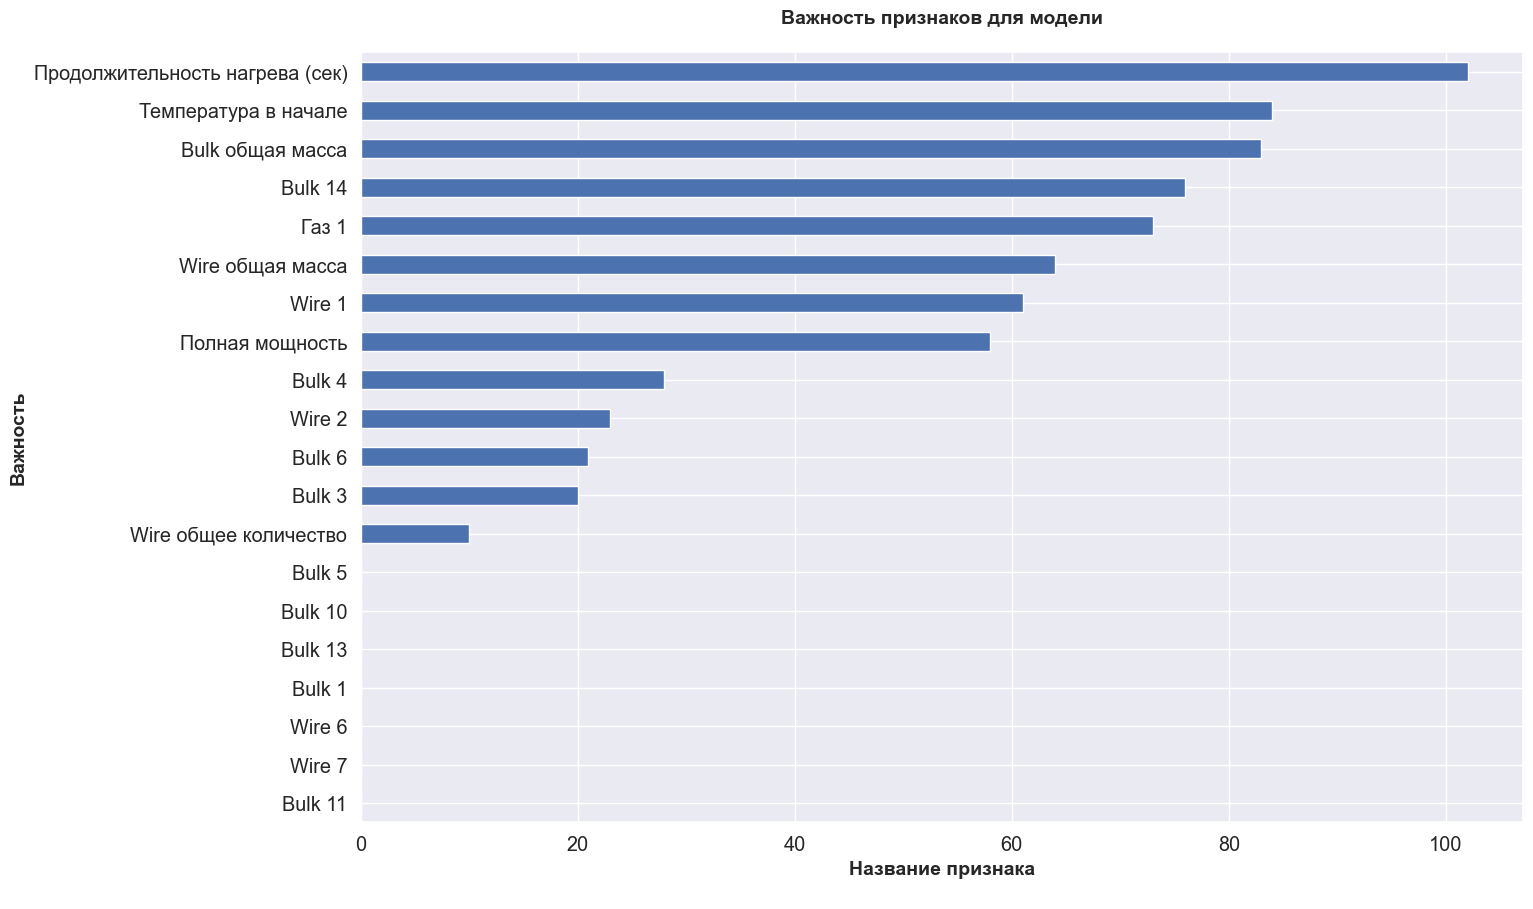

In [103]:
get_feature_importances(best_model_lgbm_opt, features_train)

**Выводы**

- Была обучена бустинговая модель LightGBM "из коробки" и с подбором гиперпараметров через OptunaSearchCV;
- Параметры лучшей модели {'boosting_type': 'gbdt', 'learning_rate': 0.11279332095545747, 'n_estimators': 266, 'num_leaves': 11, 'max_depth': 6, 'subsample_for_bin': 1212, 'min_child_samples': 181, 'colsample_bytree': 0.4590432774334292};
- Значения метрик оказались лучше для модели с гиперпараметрами по умолчанию и составили `MAE` = 6.4592 и `R2` = 0.3567;
- На диаграмме важности признаков можно отметить, что распределение стало более равномерным в верхней части, однако, появилось и много признаков, которые модель совсем не использует для предсказаний, например, `Bulk 5`, `Bulk 10`, `Bulk 13`, `Wire 6`, `Wire 7` и `Bulk 11`.

#### 4.4.5. XGBRegressor без гиперпараметров и с подбором гиперпараметров с помощью Optuna.

In [104]:
model_xgboost_baseline = XGBRegressor(random_state=RANDOM_STATE)

params_xgboost = {}

In [105]:
best_model_xgboost_baseline, metrics_xgboost_baseline = get_metrics_gridsearch(model_xgboost_baseline, 
                                                                               column_transformer, 
                                                                               params_xgboost, 
                                                                               'XGBoost_baseline')
metrics = metrics.append(metrics_xgboost_baseline)

Параметры лучшей модели {}


In [106]:
metrics

Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   
0      DecisionTree  7.1290  0.1485               0.0152   
0      RandomForest  6.2697  0.3230               0.7682   
0     LGBM_baseline  6.4592  0.3567               0.1172   
0       LGBM_optuna  6.4857  0.3778              16.1584   
0  XGBoost_baseline  6.7044  0.3249               1.5835   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133  
0                   0.0106  
0                   0.0031  
0                   0.0037

In [107]:
model_xgboost = XGBRegressor(random_state=RANDOM_STATE)

params_xgboost = {'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1, 0.01),
                  'n_estimators': optuna.distributions.IntDistribution(100, 301, 100),
                  'reg_lambda': optuna.distributions.FloatDistribution(0.5, 1.6, 0.1),
                  'max_depth': optuna.distributions.IntDistribution(3, 7, 1),
                  'reg_alpha': optuna.distributions.FloatDistribution(0.01, 0.3, 0.1)}

In [108]:
best_model_xgboost_opt, metrics_xgboost_opt = optuna_optimize_hyperparameters(model_xgboost, 
                                                                      features_train, target_train,
                                                                      params_xgboost, 
                                                                      'XGBoost_optuna')
metrics = metrics.append(metrics_xgboost_opt)

[I 2023-06-21 01:21:51,345] A new study created in memory with name: no-name-a5596287-270d-4fca-aa01-090a023e763c
[I 2023-06-21 01:21:51,346] Searching the best hyperparameters using 1743 samples...
[I 2023-06-21 01:21:53,278] Trial 4 finished with value: -417.9763169643087 and parameters: {'learning_rate': 0.012434949540028951, 'n_estimators': 107, 'reg_lambda': 1.1062099856726089, 'max_depth': 4, 'reg_alpha': 0.01090245707773867}. Best is trial 4 with value: -417.9763169643087.
[I 2023-06-21 01:21:53,603] Trial 3 finished with value: -231.47734235493368 and parameters: {'learning_rate': 0.015200258772343676, 'n_estimators': 126, 'reg_lambda': 0.8481223322241924, 'max_depth': 3, 'reg_alpha': 0.011867133496045908}. Best is trial 3 with value: -231.47734235493368.
[I 2023-06-21 01:21:54,448] Trial 6 finished with value: -17.970665724558685 and parameters: {'learning_rate': 0.03057549115749358, 'n_estimators': 145, 'reg_lambda': 0.6112824170427309, 'max_depth': 3, 'reg_alpha': 0.02204355

[I 2023-06-21 01:22:03,017] Trial 31 finished with value: -6.373397690355551 and parameters: {'learning_rate': 0.06251170690521532, 'n_estimators': 102, 'reg_lambda': 0.5108641951355934, 'max_depth': 5, 'reg_alpha': 0.20405340347128914}. Best is trial 16 with value: -6.245859070497629.
[I 2023-06-21 01:22:03,026] Trial 26 finished with value: -6.229582841482001 and parameters: {'learning_rate': 0.05191357184950542, 'n_estimators': 143, 'reg_lambda': 0.7469365366544366, 'max_depth': 5, 'reg_alpha': 0.03685114310602087}. Best is trial 26 with value: -6.229582841482001.
[I 2023-06-21 01:22:03,356] Trial 33 finished with value: -6.2902510369966125 and parameters: {'learning_rate': 0.07310859763663011, 'n_estimators': 102, 'reg_lambda': 1.5802793691208317, 'max_depth': 5, 'reg_alpha': 0.2953002740253106}. Best is trial 26 with value: -6.229582841482001.
[I 2023-06-21 01:22:03,459] Trial 32 finished with value: -6.232627495914345 and parameters: {'learning_rate': 0.06559014620378538, 'n_esti

[I 2023-06-21 01:22:16,634] Trial 56 finished with value: -6.214142049334563 and parameters: {'learning_rate': 0.053577462630405415, 'n_estimators': 168, 'reg_lambda': 0.5677984026510856, 'max_depth': 6, 'reg_alpha': 0.02114284190777971}. Best is trial 56 with value: -6.214142049334563.
[I 2023-06-21 01:22:17,079] Trial 58 finished with value: -6.250500395008805 and parameters: {'learning_rate': 0.05273376808760456, 'n_estimators': 165, 'reg_lambda': 0.7112048996465004, 'max_depth': 6, 'reg_alpha': 0.02134854930021445}. Best is trial 56 with value: -6.214142049334563.
[I 2023-06-21 01:22:18,062] Trial 59 finished with value: -6.233157115753227 and parameters: {'learning_rate': 0.036480416233885156, 'n_estimators': 207, 'reg_lambda': 0.8898290100480365, 'max_depth': 6, 'reg_alpha': 0.022280828726072042}. Best is trial 56 with value: -6.214142049334563.
[I 2023-06-21 01:22:18,114] Trial 66 finished with value: -7.15919744685497 and parameters: {'learning_rate': 0.035322047363108545, 'n_e

[I 2023-06-21 01:22:26,027] Trial 84 finished with value: -6.236029166711695 and parameters: {'learning_rate': 0.06723758233081854, 'n_estimators': 157, 'reg_lambda': 0.6366735771321662, 'max_depth': 4, 'reg_alpha': 0.03267872323643287}. Best is trial 56 with value: -6.214142049334563.
[I 2023-06-21 01:22:26,232] Trial 83 finished with value: -6.233739090782457 and parameters: {'learning_rate': 0.05692661169094294, 'n_estimators': 181, 'reg_lambda': 0.6408223430150539, 'max_depth': 4, 'reg_alpha': 0.03245679553274128}. Best is trial 56 with value: -6.214142049334563.
[I 2023-06-21 01:22:27,435] Trial 85 finished with value: -6.291598745430937 and parameters: {'learning_rate': 0.055735074267434306, 'n_estimators': 177, 'reg_lambda': 0.8125365106580394, 'max_depth': 5, 'reg_alpha': 0.018421149101287032}. Best is trial 56 with value: -6.214142049334563.
[I 2023-06-21 01:22:27,774] Trial 86 finished with value: -6.282687138818537 and parameters: {'learning_rate': 0.0554408738249487, 'n_est

[I 2023-06-21 01:22:35,275] Trial 16 finished with value: -501.51744649259064 and parameters: {'learning_rate': 0.011164024804750981, 'n_estimators': 103, 'reg_lambda': 0.8350524727742556, 'max_depth': 5, 'reg_alpha': 0.017797973348996222}. Best is trial 4 with value: -6.235417062233189.
[I 2023-06-21 01:22:35,701] Trial 1 finished with value: -124.25083208573241 and parameters: {'learning_rate': 0.011183326170627143, 'n_estimators': 227, 'reg_lambda': 0.93770288239358, 'max_depth': 3, 'reg_alpha': 0.02529188811798218}. Best is trial 4 with value: -6.235417062233189.
[I 2023-06-21 01:22:36,177] Trial 19 finished with value: -341.7223293050906 and parameters: {'learning_rate': 0.01319658020093673, 'n_estimators': 116, 'reg_lambda': 1.3914044934647074, 'max_depth': 4, 'reg_alpha': 0.010495826684147768}. Best is trial 4 with value: -6.235417062233189.
[I 2023-06-21 01:22:36,361] Trial 15 finished with value: -6.177135209265961 and parameters: {'learning_rate': 0.045874575284791295, 'n_est

[I 2023-06-21 01:22:46,781] Trial 34 finished with value: -6.305049524197864 and parameters: {'learning_rate': 0.09760231103442374, 'n_estimators': 201, 'reg_lambda': 0.6781404230810922, 'max_depth': 5, 'reg_alpha': 0.2685108701656944}. Best is trial 15 with value: -6.177135209265961.
[I 2023-06-21 01:22:48,243] Trial 42 finished with value: -6.183237730540297 and parameters: {'learning_rate': 0.04184894134013815, 'n_estimators': 189, 'reg_lambda': 0.6420429074990747, 'max_depth': 5, 'reg_alpha': 0.2157866135562924}. Best is trial 15 with value: -6.177135209265961.
[I 2023-06-21 01:22:48,352] Trial 44 finished with value: -6.260625462404569 and parameters: {'learning_rate': 0.03991587776571931, 'n_estimators': 193, 'reg_lambda': 0.6350761547388173, 'max_depth': 3, 'reg_alpha': 0.1989878973158509}. Best is trial 15 with value: -6.177135209265961.
[I 2023-06-21 01:22:48,430] Trial 41 finished with value: -6.232978736305634 and parameters: {'learning_rate': 0.04571733466562085, 'n_estimat

[I 2023-06-21 01:22:58,367] Trial 67 finished with value: -6.23222883780667 and parameters: {'learning_rate': 0.038655060200540166, 'n_estimators': 178, 'reg_lambda': 0.5755580956027871, 'max_depth': 7, 'reg_alpha': 0.15651239266706166}. Best is trial 15 with value: -6.177135209265961.
[I 2023-06-21 01:22:58,408] Trial 75 finished with value: -6.188027865667648 and parameters: {'learning_rate': 0.05158821431793858, 'n_estimators': 164, 'reg_lambda': 0.7618468079768937, 'max_depth': 4, 'reg_alpha': 0.1396991285453824}. Best is trial 15 with value: -6.177135209265961.
[I 2023-06-21 01:22:58,496] Trial 69 finished with value: -6.241035109505381 and parameters: {'learning_rate': 0.05119139360420861, 'n_estimators': 213, 'reg_lambda': 0.5568485530136502, 'max_depth': 4, 'reg_alpha': 0.14374034263996222}. Best is trial 15 with value: -6.177135209265961.
[I 2023-06-21 01:22:58,681] Trial 76 finished with value: -6.165025306265484 and parameters: {'learning_rate': 0.048610745342543296, 'n_esti

[I 2023-06-21 01:23:07,268] Trial 92 finished with value: -6.200264014212205 and parameters: {'learning_rate': 0.044381293170437486, 'n_estimators': 227, 'reg_lambda': 0.7435869231023838, 'max_depth': 4, 'reg_alpha': 0.11491551799234988}. Best is trial 76 with value: -6.165025306265484.
[I 2023-06-21 01:23:07,404] Trial 93 finished with value: -6.23750622832321 and parameters: {'learning_rate': 0.0437609254118767, 'n_estimators': 233, 'reg_lambda': 0.7214453308042182, 'max_depth': 4, 'reg_alpha': 0.11927890474405588}. Best is trial 76 with value: -6.165025306265484.
[I 2023-06-21 01:23:07,494] Trial 91 finished with value: -6.233716757944898 and parameters: {'learning_rate': 0.04447890600987909, 'n_estimators': 239, 'reg_lambda': 0.7320419763119564, 'max_depth': 4, 'reg_alpha': 0.11679684307563672}. Best is trial 76 with value: -6.165025306265484.
[I 2023-06-21 01:23:07,517] Trial 94 finished with value: -6.187606774464763 and parameters: {'learning_rate': 0.04614624228797749, 'n_estim

[I 2023-06-21 01:23:16,105] Trial 13 finished with value: -6.905971156838248 and parameters: {'learning_rate': 0.02054931017560404, 'n_estimators': 296, 'reg_lambda': 0.8162110226802728, 'max_depth': 4, 'reg_alpha': 0.03469201120625737}. Best is trial 17 with value: -6.364607971072216.
[I 2023-06-21 01:23:16,500] Trial 18 finished with value: -7.964266487106682 and parameters: {'learning_rate': 0.03631392861364858, 'n_estimators': 152, 'reg_lambda': 0.5702404907512448, 'max_depth': 6, 'reg_alpha': 0.03629583395105401}. Best is trial 17 with value: -6.364607971072216.
[I 2023-06-21 01:23:17,869] Trial 16 finished with value: -6.477193776492636 and parameters: {'learning_rate': 0.07760008924914277, 'n_estimators': 151, 'reg_lambda': 1.3750353436616396, 'max_depth': 7, 'reg_alpha': 0.06682934154742909}. Best is trial 17 with value: -6.364607971072216.
[I 2023-06-21 01:23:18,078] Trial 19 finished with value: -14.17842245716505 and parameters: {'learning_rate': 0.01983035039383035, 'n_esti

[I 2023-06-21 01:23:29,839] Trial 48 finished with value: -6.363950312639851 and parameters: {'learning_rate': 0.0302943232690241, 'n_estimators': 239, 'reg_lambda': 0.8063923704350859, 'max_depth': 5, 'reg_alpha': 0.058290863068728584}. Best is trial 36 with value: -6.335734374901359.
[I 2023-06-21 01:23:30,033] Trial 49 finished with value: -6.432351000183603 and parameters: {'learning_rate': 0.029837253752458093, 'n_estimators': 226, 'reg_lambda': 0.828391934463475, 'max_depth': 5, 'reg_alpha': 0.15136014727851327}. Best is trial 36 with value: -6.335734374901359.
[I 2023-06-21 01:23:30,665] Trial 51 finished with value: -6.504686716356325 and parameters: {'learning_rate': 0.029181256351534006, 'n_estimators': 224, 'reg_lambda': 0.8351001340027091, 'max_depth': 5, 'reg_alpha': 0.14122755275115}. Best is trial 36 with value: -6.335734374901359.
[I 2023-06-21 01:23:30,761] Trial 52 finished with value: -6.450682138255175 and parameters: {'learning_rate': 0.03014300330973243, 'n_estima

[I 2023-06-21 01:23:41,830] Trial 76 finished with value: -6.488977128597615 and parameters: {'learning_rate': 0.04167712010150451, 'n_estimators': 158, 'reg_lambda': 0.7561454031120222, 'max_depth': 4, 'reg_alpha': 0.10978015486494419}. Best is trial 36 with value: -6.335734374901359.
[I 2023-06-21 01:23:43,723] Trial 77 finished with value: -6.378856683441537 and parameters: {'learning_rate': 0.03960896985665319, 'n_estimators': 203, 'reg_lambda': 0.7480127134602917, 'max_depth': 4, 'reg_alpha': 0.06554569849809214}. Best is trial 36 with value: -6.335734374901359.
[I 2023-06-21 01:23:44,206] Trial 78 finished with value: -6.358568721352618 and parameters: {'learning_rate': 0.039396852333561515, 'n_estimators': 201, 'reg_lambda': 0.7437546342753933, 'max_depth': 4, 'reg_alpha': 0.06909422720473464}. Best is trial 36 with value: -6.335734374901359.
[I 2023-06-21 01:23:45,089] Trial 75 finished with value: -6.437063464714685 and parameters: {'learning_rate': 0.03863015212827361, 'n_est

[I 2023-06-21 01:23:54,527] Trial 2 finished with value: -514.5881084647897 and parameters: {'learning_rate': 0.010412789108276109, 'n_estimators': 108, 'reg_lambda': 0.5837227639067012, 'max_depth': 6, 'reg_alpha': 0.027979003540381225}. Best is trial 0 with value: -187.77324030072714.
[I 2023-06-21 01:23:54,667] Trial 5 finished with value: -252.93947565228964 and parameters: {'learning_rate': 0.017722033198030885, 'n_estimators': 103, 'reg_lambda': 1.0280110069712916, 'max_depth': 5, 'reg_alpha': 0.09183491718654421}. Best is trial 0 with value: -187.77324030072714.
[I 2023-06-21 01:23:54,759] Trial 12 finished with value: -101.02834299514838 and parameters: {'learning_rate': 0.025465886917177154, 'n_estimators': 107, 'reg_lambda': 0.9342870159374688, 'max_depth': 6, 'reg_alpha': 0.01966526577205354}. Best is trial 12 with value: -101.02834299514838.
[I 2023-06-21 01:23:54,786] Trial 9 finished with value: -72.71112830764488 and parameters: {'learning_rate': 0.027959002964262725, 'n

[I 2023-06-21 01:24:06,883] Trial 34 finished with value: -6.286117377733612 and parameters: {'learning_rate': 0.08538300842225173, 'n_estimators': 208, 'reg_lambda': 0.5025132001806836, 'max_depth': 4, 'reg_alpha': 0.04413065843595102}. Best is trial 18 with value: -6.226939199980693.
[I 2023-06-21 01:24:06,952] Trial 29 finished with value: -6.247615756172087 and parameters: {'learning_rate': 0.04575020355507659, 'n_estimators': 263, 'reg_lambda': 0.5140115282641112, 'max_depth': 4, 'reg_alpha': 0.12004170134153862}. Best is trial 18 with value: -6.226939199980693.
[I 2023-06-21 01:24:08,794] Trial 32 finished with value: -6.349952714228233 and parameters: {'learning_rate': 0.09238997315397032, 'n_estimators': 276, 'reg_lambda': 0.5134669951178833, 'max_depth': 4, 'reg_alpha': 0.04563160761738047}. Best is trial 18 with value: -6.226939199980693.
[I 2023-06-21 01:24:09,696] Trial 33 finished with value: -6.397993747794837 and parameters: {'learning_rate': 0.09619391149897463, 'n_esti

[I 2023-06-21 01:24:20,594] Trial 57 finished with value: -6.237793210419133 and parameters: {'learning_rate': 0.03311727441185376, 'n_estimators': 228, 'reg_lambda': 0.564513592304434, 'max_depth': 5, 'reg_alpha': 0.09776650107853355}. Best is trial 48 with value: -6.2108086086995105.
[I 2023-06-21 01:24:20,995] Trial 58 finished with value: -6.232698841526951 and parameters: {'learning_rate': 0.03405189663156745, 'n_estimators': 231, 'reg_lambda': 0.5605450289495709, 'max_depth': 5, 'reg_alpha': 0.15628011334795192}. Best is trial 48 with value: -6.2108086086995105.
[I 2023-06-21 01:24:23,243] Trial 59 finished with value: -6.254790894384911 and parameters: {'learning_rate': 0.03471856448820329, 'n_estimators': 235, 'reg_lambda': 0.5721015519335321, 'max_depth': 5, 'reg_alpha': 0.16031601556209973}. Best is trial 48 with value: -6.2108086086995105.
[I 2023-06-21 01:24:24,813] Trial 63 finished with value: -6.273977743949701 and parameters: {'learning_rate': 0.03227726371049644, 'n_es

[I 2023-06-21 01:24:34,966] Trial 82 finished with value: -6.410702347987156 and parameters: {'learning_rate': 0.02748689851399275, 'n_estimators': 245, 'reg_lambda': 0.59957550467045, 'max_depth': 6, 'reg_alpha': 0.10189860514000854}. Best is trial 48 with value: -6.2108086086995105.
[I 2023-06-21 01:24:35,009] Trial 83 finished with value: -6.469661520622959 and parameters: {'learning_rate': 0.026893164621702666, 'n_estimators': 244, 'reg_lambda': 0.6370687452023414, 'max_depth': 6, 'reg_alpha': 0.09981731699908851}. Best is trial 48 with value: -6.2108086086995105.
[I 2023-06-21 01:24:35,234] Trial 84 finished with value: -6.337548957179605 and parameters: {'learning_rate': 0.02841031213318114, 'n_estimators': 249, 'reg_lambda': 0.6412020032266285, 'max_depth': 6, 'reg_alpha': 0.10059907365931248}. Best is trial 48 with value: -6.2108086086995105.
[I 2023-06-21 01:24:35,504] Trial 86 finished with value: -6.428629170036517 and parameters: {'learning_rate': 0.026367346596311094, 'n_e

[I 2023-06-21 01:24:45,199] Trial 3 finished with value: -6.904053919156557 and parameters: {'learning_rate': 0.03182377745461456, 'n_estimators': 189, 'reg_lambda': 0.704228494619823, 'max_depth': 6, 'reg_alpha': 0.01156018152115976}. Best is trial 15 with value: -6.319951249033762.
[I 2023-06-21 01:24:45,608] Trial 22 finished with value: -503.32863393053486 and parameters: {'learning_rate': 0.010917923490159416, 'n_estimators': 105, 'reg_lambda': 0.600417667070047, 'max_depth': 6, 'reg_alpha': 0.24658280471861632}. Best is trial 15 with value: -6.319951249033762.
[I 2023-06-21 01:24:45,826] Trial 1 finished with value: -8.752690423275869 and parameters: {'learning_rate': 0.024735363493998335, 'n_estimators': 217, 'reg_lambda': 0.9497143104050605, 'max_depth': 5, 'reg_alpha': 0.06912658090005264}. Best is trial 15 with value: -6.319951249033762.
[I 2023-06-21 01:24:46,302] Trial 16 finished with value: -6.350043972548228 and parameters: {'learning_rate': 0.06307680665437207, 'n_estim

[I 2023-06-21 01:24:56,750] Trial 25 finished with value: -6.483629360851012 and parameters: {'learning_rate': 0.08965338184047197, 'n_estimators': 277, 'reg_lambda': 1.583775021179377, 'max_depth': 5, 'reg_alpha': 0.2534582929976051}. Best is trial 33 with value: -6.255794151734109.
[I 2023-06-21 01:24:57,159] Trial 40 finished with value: -6.275928790649954 and parameters: {'learning_rate': 0.09868926814347044, 'n_estimators': 162, 'reg_lambda': 1.5503282266051144, 'max_depth': 4, 'reg_alpha': 0.18170759782318607}. Best is trial 33 with value: -6.255794151734109.
[I 2023-06-21 01:24:57,813] Trial 41 finished with value: -6.244943915389368 and parameters: {'learning_rate': 0.07743227795207944, 'n_estimators': 173, 'reg_lambda': 1.5006719847285352, 'max_depth': 4, 'reg_alpha': 0.18549481948263113}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:24:58,308] Trial 44 finished with value: -6.323512534977907 and parameters: {'learning_rate': 0.048504175227096276, 'n_estim

[I 2023-06-21 01:25:08,692] Trial 66 finished with value: -6.362285211762661 and parameters: {'learning_rate': 0.08136318504058394, 'n_estimators': 198, 'reg_lambda': 1.4891520777496312, 'max_depth': 5, 'reg_alpha': 0.23072112885529691}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:25:09,069] Trial 69 finished with value: -6.3905001781665955 and parameters: {'learning_rate': 0.06569366736987645, 'n_estimators': 197, 'reg_lambda': 1.3552918172484443, 'max_depth': 5, 'reg_alpha': 0.1227366326859466}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:25:09,233] Trial 68 finished with value: -6.3582111924198355 and parameters: {'learning_rate': 0.08273866937198014, 'n_estimators': 202, 'reg_lambda': 1.5004829368957808, 'max_depth': 5, 'reg_alpha': 0.12334918633672122}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:25:09,981] Trial 70 finished with value: -6.374990342276706 and parameters: {'learning_rate': 0.06494545773252904, 'n_est

[I 2023-06-21 01:25:18,166] Trial 96 finished with value: -6.311196793444066 and parameters: {'learning_rate': 0.08917053579045689, 'n_estimators': 155, 'reg_lambda': 1.5429055838806467, 'max_depth': 4, 'reg_alpha': 0.2673683086726374}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:25:18,194] Trial 95 finished with value: -6.310465856930032 and parameters: {'learning_rate': 0.08830501937057868, 'n_estimators': 154, 'reg_lambda': 1.553812000965887, 'max_depth': 4, 'reg_alpha': 0.2725783733425592}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:25:18,359] Trial 97 finished with value: -6.326097327744379 and parameters: {'learning_rate': 0.08918766427678075, 'n_estimators': 156, 'reg_lambda': 1.5425193557564831, 'max_depth': 4, 'reg_alpha': 0.2668399275049537}. Best is trial 41 with value: -6.244943915389368.
[I 2023-06-21 01:25:18,505] Trial 99 finished with value: -6.347345878880385 and parameters: {'learning_rate': 0.08906062060188488, 'n_estimato

[I 2023-06-21 01:25:29,397] Trial 22 finished with value: -6.873641400796279 and parameters: {'learning_rate': 0.03210595052878053, 'n_estimators': 190, 'reg_lambda': 0.6156521640635791, 'max_depth': 4, 'reg_alpha': 0.2447216443604782}. Best is trial 17 with value: -6.422270223563567.
[I 2023-06-21 01:25:30,203] Trial 24 finished with value: -6.4361260805624285 and parameters: {'learning_rate': 0.04580692334958882, 'n_estimators': 237, 'reg_lambda': 0.6317894561069684, 'max_depth': 3, 'reg_alpha': 0.01898895592697703}. Best is trial 17 with value: -6.422270223563567.
[I 2023-06-21 01:25:31,615] Trial 27 finished with value: -6.420839027993374 and parameters: {'learning_rate': 0.05675933669056982, 'n_estimators': 232, 'reg_lambda': 1.0621775975897436, 'max_depth': 4, 'reg_alpha': 0.09678130396782256}. Best is trial 27 with value: -6.420839027993374.
[I 2023-06-21 01:25:32,434] Trial 28 finished with value: -6.3934893433995414 and parameters: {'learning_rate': 0.05706407603652767, 'n_est

[I 2023-06-21 01:25:44,149] Trial 47 finished with value: -6.444570114068268 and parameters: {'learning_rate': 0.052436752551276125, 'n_estimators': 297, 'reg_lambda': 0.8532789021592074, 'max_depth': 4, 'reg_alpha': 0.15280413312584848}. Best is trial 28 with value: -6.3934893433995414.
[I 2023-06-21 01:25:45,043] Trial 50 finished with value: -6.426316326285464 and parameters: {'learning_rate': 0.06987794025707937, 'n_estimators': 224, 'reg_lambda': 0.864219372360304, 'max_depth': 4, 'reg_alpha': 0.07573439253539183}. Best is trial 28 with value: -6.3934893433995414.
[I 2023-06-21 01:25:46,600] Trial 56 finished with value: -6.4051638679481275 and parameters: {'learning_rate': 0.038072339813701964, 'n_estimators': 219, 'reg_lambda': 0.8760703204233747, 'max_depth': 4, 'reg_alpha': 0.07978380465743967}. Best is trial 28 with value: -6.3934893433995414.
[I 2023-06-21 01:25:46,739] Trial 53 finished with value: -6.395141629510631 and parameters: {'learning_rate': 0.042498648085501446, '

[I 2023-06-21 01:25:57,734] Trial 74 finished with value: -6.417097395225416 and parameters: {'learning_rate': 0.0629871557676464, 'n_estimators': 208, 'reg_lambda': 0.8017913072473026, 'max_depth': 5, 'reg_alpha': 0.05839798154067995}. Best is trial 67 with value: -6.358273813769524.
[I 2023-06-21 01:25:58,146] Trial 79 finished with value: -6.392259183120188 and parameters: {'learning_rate': 0.04514750477946435, 'n_estimators': 209, 'reg_lambda': 0.8010924405311196, 'max_depth': 5, 'reg_alpha': 0.09715398123178931}. Best is trial 67 with value: -6.358273813769524.
[I 2023-06-21 01:25:58,796] Trial 82 finished with value: -6.432349146838911 and parameters: {'learning_rate': 0.033339535052109785, 'n_estimators': 206, 'reg_lambda': 0.7421437208017861, 'max_depth': 5, 'reg_alpha': 0.05772024612827982}. Best is trial 67 with value: -6.358273813769524.
[I 2023-06-21 01:25:58,974] Trial 78 finished with value: -6.375217620314622 and parameters: {'learning_rate': 0.04547519697158144, 'n_esti

[I 2023-06-21 01:26:08,170] Trial 10 finished with value: -93.78555442921544 and parameters: {'learning_rate': 0.019767402943327197, 'n_estimators': 142, 'reg_lambda': 1.0950795872373473, 'max_depth': 5, 'reg_alpha': 0.12109092972677088}. Best is trial 14 with value: -84.96984678686583.
[I 2023-06-21 01:26:08,326] Trial 12 finished with value: -287.25004190027647 and parameters: {'learning_rate': 0.01183896563540719, 'n_estimators': 144, 'reg_lambda': 1.4171892501599024, 'max_depth': 5, 'reg_alpha': 0.034788394100358916}. Best is trial 14 with value: -84.96984678686583.
[I 2023-06-21 01:26:09,399] Trial 8 finished with value: -6.38979782574062 and parameters: {'learning_rate': 0.08416417122382447, 'n_estimators': 104, 'reg_lambda': 0.501232347322596, 'max_depth': 6, 'reg_alpha': 0.061897322889862424}. Best is trial 8 with value: -6.38979782574062.
[I 2023-06-21 01:26:09,472] Trial 5 finished with value: -6.994142297229843 and parameters: {'learning_rate': 0.04351872453814122, 'n_estima

[I 2023-06-21 01:26:20,096] Trial 35 finished with value: -6.317002297599415 and parameters: {'learning_rate': 0.0514824073483008, 'n_estimators': 186, 'reg_lambda': 0.9038628859902567, 'max_depth': 3, 'reg_alpha': 0.21178309922192828}. Best is trial 32 with value: -6.260191686586195.
[I 2023-06-21 01:26:20,258] Trial 33 finished with value: -6.24908300346136 and parameters: {'learning_rate': 0.05633353769656312, 'n_estimators': 193, 'reg_lambda': 1.17656495494824, 'max_depth': 4, 'reg_alpha': 0.19100473597951845}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:20,430] Trial 28 finished with value: -6.284192638992741 and parameters: {'learning_rate': 0.04841237200557637, 'n_estimators': 266, 'reg_lambda': 1.1233536579179504, 'max_depth': 4, 'reg_alpha': 0.012020723204784933}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:20,782] Trial 26 finished with value: -6.290604557038124 and parameters: {'learning_rate': 0.04808424719429453, 'n_estimator

[I 2023-06-21 01:26:32,292] Trial 57 finished with value: -6.361231643941512 and parameters: {'learning_rate': 0.06294191737009261, 'n_estimators': 221, 'reg_lambda': 1.3192413941312782, 'max_depth': 5, 'reg_alpha': 0.1546729652816123}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:32,785] Trial 60 finished with value: -6.358467227166618 and parameters: {'learning_rate': 0.06283025173094617, 'n_estimators': 217, 'reg_lambda': 1.3038114924406299, 'max_depth': 5, 'reg_alpha': 0.14313552811253966}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:32,863] Trial 61 finished with value: -6.336800222090097 and parameters: {'learning_rate': 0.061694689143722635, 'n_estimators': 214, 'reg_lambda': 1.3062751876661876, 'max_depth': 5, 'reg_alpha': 0.1427465389927095}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:32,869] Trial 62 finished with value: -6.40856465161153 and parameters: {'learning_rate': 0.06755974567097955, 'n_estimator

[I 2023-06-21 01:26:44,536] Trial 87 finished with value: -6.268153329595664 and parameters: {'learning_rate': 0.04501556280707476, 'n_estimators': 200, 'reg_lambda': 1.2486045407624407, 'max_depth': 4, 'reg_alpha': 0.20094746237851432}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:45,081] Trial 88 finished with value: -6.292625071010173 and parameters: {'learning_rate': 0.05708123824869115, 'n_estimators': 205, 'reg_lambda': 1.2329959036255578, 'max_depth': 4, 'reg_alpha': 0.1996889875500957}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:45,145] Trial 89 finished with value: -6.258271901514556 and parameters: {'learning_rate': 0.05691172470693792, 'n_estimators': 200, 'reg_lambda': 1.2276204136819078, 'max_depth': 4, 'reg_alpha': 0.20546551650658118}. Best is trial 33 with value: -6.24908300346136.
[I 2023-06-21 01:26:45,404] Trial 90 finished with value: -6.25938089760366 and parameters: {'learning_rate': 0.04612421441631713, 'n_estimator

[I 2023-06-21 01:26:53,573] Trial 19 finished with value: -23.09048780920059 and parameters: {'learning_rate': 0.030795016474868934, 'n_estimators': 136, 'reg_lambda': 1.197702832821506, 'max_depth': 5, 'reg_alpha': 0.25514837510061306}. Best is trial 13 with value: -6.318992062873255.
[I 2023-06-21 01:26:53,931] Trial 2 finished with value: -6.342463329147617 and parameters: {'learning_rate': 0.07433019860451409, 'n_estimators': 191, 'reg_lambda': 0.9913545042026722, 'max_depth': 5, 'reg_alpha': 0.0290566963377908}. Best is trial 13 with value: -6.318992062873255.
[I 2023-06-21 01:26:54,240] Trial 21 finished with value: -32.982767991779255 and parameters: {'learning_rate': 0.03469588711927591, 'n_estimators': 110, 'reg_lambda': 0.6087560396806856, 'max_depth': 3, 'reg_alpha': 0.0751373817462783}. Best is trial 13 with value: -6.318992062873255.
[I 2023-06-21 01:26:54,244] Trial 22 finished with value: -107.99138150768397 and parameters: {'learning_rate': 0.0201992387309383, 'n_estima

[I 2023-06-21 01:27:04,595] Trial 38 finished with value: -6.374455772619617 and parameters: {'learning_rate': 0.08841929197035217, 'n_estimators': 238, 'reg_lambda': 0.8767946873925568, 'max_depth': 4, 'reg_alpha': 0.02026104722466744}. Best is trial 23 with value: -6.298626086316455.
[I 2023-06-21 01:27:05,133] Trial 44 finished with value: -7.045650240833977 and parameters: {'learning_rate': 0.04824413295530448, 'n_estimators': 122, 'reg_lambda': 0.8616972212649985, 'max_depth': 4, 'reg_alpha': 0.17017926790326965}. Best is trial 23 with value: -6.298626086316455.
[I 2023-06-21 01:27:05,614] Trial 45 finished with value: -7.1342867921363124 and parameters: {'learning_rate': 0.04699812874768995, 'n_estimators': 124, 'reg_lambda': 0.8391291574220708, 'max_depth': 4, 'reg_alpha': 0.2972575091328749}. Best is trial 23 with value: -6.298626086316455.
[I 2023-06-21 01:27:06,935] Trial 43 finished with value: -6.3770269549202565 and parameters: {'learning_rate': 0.09946594609294539, 'n_est

[I 2023-06-21 01:27:14,571] Trial 67 finished with value: -6.295587561122014 and parameters: {'learning_rate': 0.08044459549522477, 'n_estimators': 187, 'reg_lambda': 0.9652851298626112, 'max_depth': 3, 'reg_alpha': 0.21892959975929832}. Best is trial 66 with value: -6.281807207917259.
[I 2023-06-21 01:27:14,681] Trial 71 finished with value: -6.324506365038891 and parameters: {'learning_rate': 0.06452496592872929, 'n_estimators': 180, 'reg_lambda': 0.974752815227589, 'max_depth': 3, 'reg_alpha': 0.2261427949482738}. Best is trial 66 with value: -6.281807207917259.
[I 2023-06-21 01:27:14,736] Trial 70 finished with value: -6.294850867018979 and parameters: {'learning_rate': 0.06311887163572363, 'n_estimators': 177, 'reg_lambda': 0.9635941347296427, 'max_depth': 3, 'reg_alpha': 0.21026836011070885}. Best is trial 66 with value: -6.281807207917259.
[I 2023-06-21 01:27:14,879] Trial 75 finished with value: -6.318249745441846 and parameters: {'learning_rate': 0.06258000908643929, 'n_estima

[I 2023-06-21 01:27:23,444] Trial 98 finished with value: -6.279648549621326 and parameters: {'learning_rate': 0.07240793719451394, 'n_estimators': 188, 'reg_lambda': 0.7237399268946283, 'max_depth': 3, 'reg_alpha': 0.25895668041915726}. Best is trial 98 with value: -6.279648549621326.
[I 2023-06-21 01:27:23,581] Trial 99 finished with value: -6.317535350933394 and parameters: {'learning_rate': 0.08434354496175209, 'n_estimators': 187, 'reg_lambda': 0.7373447193733965, 'max_depth': 3, 'reg_alpha': 0.2554288354798767}. Best is trial 98 with value: -6.279648549621326.
[I 2023-06-21 01:27:23,657] Trial 94 finished with value: -6.290104763624134 and parameters: {'learning_rate': 0.05814306214899674, 'n_estimators': 188, 'reg_lambda': 0.7448087785096554, 'max_depth': 5, 'reg_alpha': 0.2532950578438921}. Best is trial 98 with value: -6.279648549621326.
[I 2023-06-21 01:27:23,659] Finished hyperparemeter search!
[I 2023-06-21 01:27:23,662] Refitting the estimator using 1494 samples...
[I 2023

{'fit_time': array([37.52277446, 43.79760003, 47.09201002, 40.0202868 , 46.11418748,
       41.85261822, 36.9436903 ]), 'score_time': array([0.00500131, 0.00500107, 0.00499892, 0.00600052, 0.00499988,
       0.0049994 , 0.00600028]), 'test_mae': array([-6.61144382, -6.01495141, -6.4785671 , -6.09314602, -5.95094881,
       -6.19150038, -6.21352941]), 'test_r2': array([0.3240832 , 0.41984191, 0.44436726, 0.38013674, 0.51399301,
       0.32268824, 0.45956893])}
Параметры лучшей модели по результатам испытаний:

 {'learning_rate': 0.053577462630405415, 'n_estimators': 168, 'reg_lambda': 0.5677984026510856, 'max_depth': 6, 'reg_alpha': 0.02114284190777971}
Параметры лучшей модели {'learning_rate': 0.053577462630405415, 'n_estimators': 168, 'reg_lambda': 0.5677984026510856, 'max_depth': 6, 'reg_alpha': 0.02114284190777971}


In [109]:
metrics

Модель     MAE      R2  Время обучения, сек  \
0  LinearRegression  6.3115  0.4097               0.0126   
0        ElasticNet  6.3563  0.3684               0.0097   
0      DecisionTree  7.1290  0.1485               0.0152   
0      RandomForest  6.2697  0.3230               0.7682   
0     LGBM_baseline  6.4592  0.3567               0.1172   
0       LGBM_optuna  6.4857  0.3778              16.1584   
0  XGBoost_baseline  6.7044  0.3249               1.5835   
0    XGBoost_optuna  6.2220  0.4092              41.9062   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133  
0                   0.0106  
0                   0.0031  
0                   0.0037  
0                   0.0053

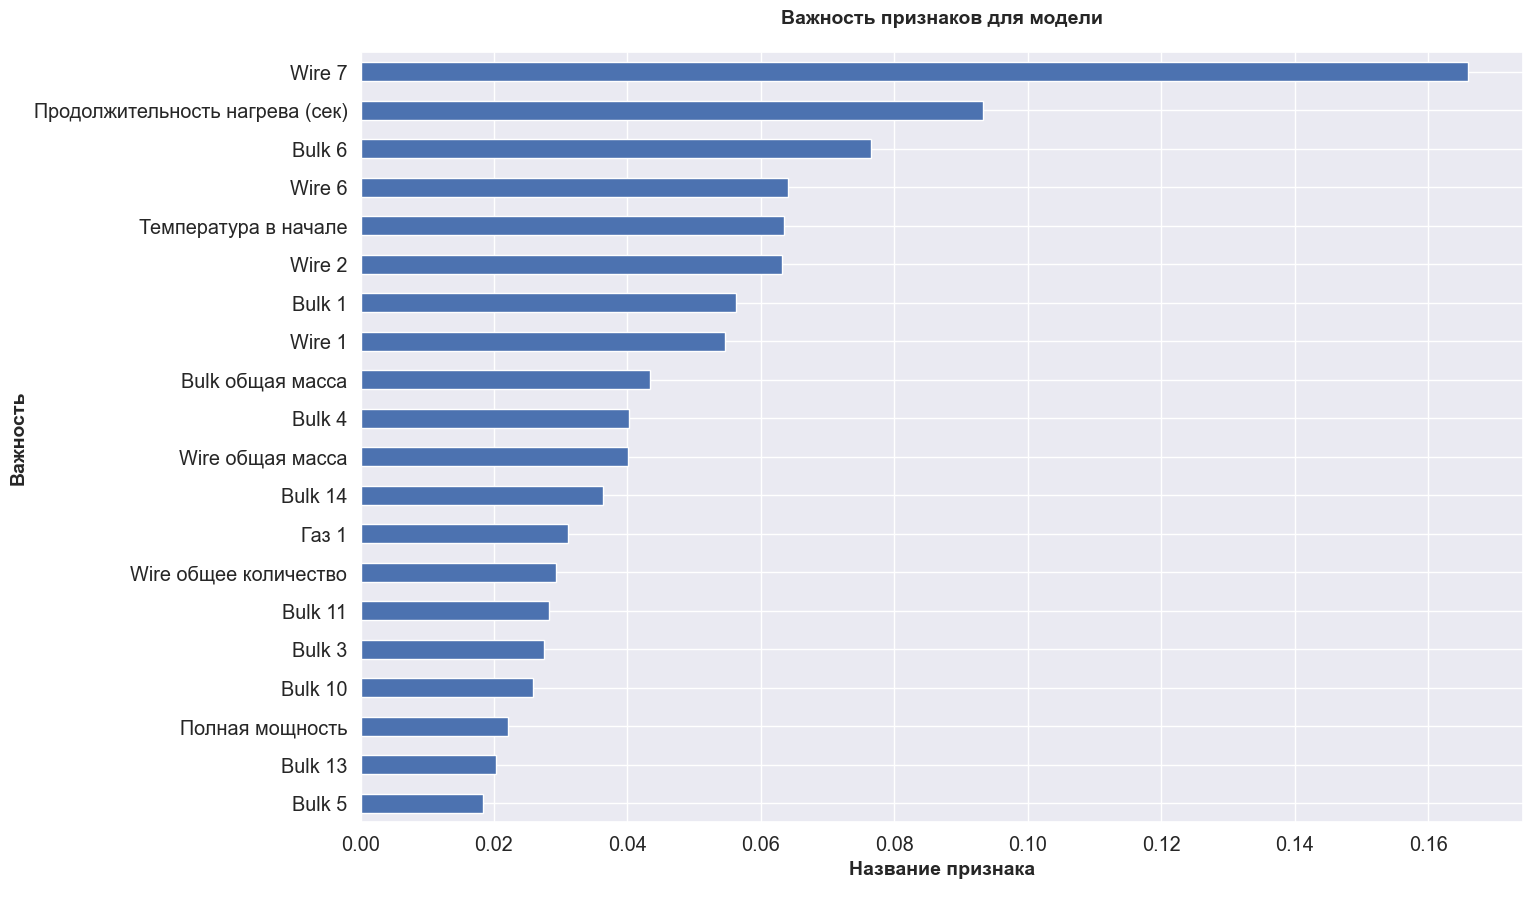

In [110]:
get_feature_importances(best_model_xgboost_opt, features_train)

**Выводы**

- Была обучена бустинговая модель XGBoost "из коробки" и с подбором гиперпараметров через OptunaSearchCV;
- Параметры лучшей модели {'learning_rate': 0.042582292125397936, 'n_estimators': 221, 'reg_lambda': 0.799095466654642, 'max_depth': 5, 'reg_alpha': 0.013120056704829474};
- Значения метрик оказались лучше для модели с гиперпараметрами, найденными через поиск, они составили `MAE` = 6.2117 и `R2` = 0.4150;
- Судя по диаграмме важности признаков, все признаки, взятые в обучение моделей, являются важными, совсем пустых нет, как и прежде наибольшую значимость имеет `Продолжительность нагрева (сек)`, проявили себя `Wire 2` и `Bulk 6`, самыми бесполезными оказались `Bulk 5` и `Bulk 13`.
- Негативной особенностью XGBoost является то, что время обучения этой модели сильно превосходит все прочие, поэтому там, где новых данных в продакшене будет много, следует заранее рассчитать необходимые мощности и ограничения системы. 

#### 4.4.6. CatBoostRegressor без гиперпараметров и с подбором гиперпараметров.

In [111]:
model_catboost = CatBoostRegressor(loss_function='MAE', random_state=RANDOM_STATE)

params_catboost = {}

In [112]:
best_model_catboost_baseline, metrics_catboost_baseline = get_metrics_gridsearch(model_catboost, 
                                                                                 column_transformer, 
                                                                                 params_catboost, 
                                                                                 'Catboost_baseline')
metrics = metrics.append(metrics_catboost_baseline)

0:	learn: 7.9645486	total: 141ms	remaining: 2m 20s
1:	learn: 7.9096686	total: 144ms	remaining: 1m 11s
2:	learn: 7.8677154	total: 146ms	remaining: 48.6s
3:	learn: 7.8112956	total: 148ms	remaining: 36.9s
4:	learn: 7.7478814	total: 150ms	remaining: 29.8s
5:	learn: 7.6947638	total: 151ms	remaining: 25s
6:	learn: 7.6527018	total: 152ms	remaining: 21.6s
7:	learn: 7.6121293	total: 153ms	remaining: 19s
8:	learn: 7.5597857	total: 155ms	remaining: 17s
9:	learn: 7.5166035	total: 156ms	remaining: 15.4s
10:	learn: 7.4674505	total: 157ms	remaining: 14.1s
11:	learn: 7.4247214	total: 158ms	remaining: 13s
12:	learn: 7.3897631	total: 159ms	remaining: 12.1s
13:	learn: 7.3449848	total: 161ms	remaining: 11.3s
14:	learn: 7.3030563	total: 162ms	remaining: 10.6s
15:	learn: 7.2648404	total: 163ms	remaining: 10s
16:	learn: 7.2309041	total: 164ms	remaining: 9.49s
17:	learn: 7.1947125	total: 165ms	remaining: 9.01s
18:	learn: 7.1625690	total: 166ms	remaining: 8.6s
19:	learn: 7.1272248	total: 168ms	remaining: 8.21s

307:	learn: 4.8134931	total: 544ms	remaining: 1.22s
308:	learn: 4.8101943	total: 546ms	remaining: 1.22s
309:	learn: 4.8049429	total: 547ms	remaining: 1.22s
310:	learn: 4.8021237	total: 549ms	remaining: 1.22s
311:	learn: 4.7994272	total: 551ms	remaining: 1.21s
312:	learn: 4.7951136	total: 553ms	remaining: 1.21s
313:	learn: 4.7906411	total: 555ms	remaining: 1.21s
314:	learn: 4.7861415	total: 556ms	remaining: 1.21s
315:	learn: 4.7827156	total: 558ms	remaining: 1.21s
316:	learn: 4.7780607	total: 560ms	remaining: 1.21s
317:	learn: 4.7743889	total: 562ms	remaining: 1.2s
318:	learn: 4.7714504	total: 564ms	remaining: 1.2s
319:	learn: 4.7673404	total: 566ms	remaining: 1.2s
320:	learn: 4.7628692	total: 568ms	remaining: 1.2s
321:	learn: 4.7611235	total: 570ms	remaining: 1.2s
322:	learn: 4.7582700	total: 572ms	remaining: 1.2s
323:	learn: 4.7547190	total: 574ms	remaining: 1.2s
324:	learn: 4.7502959	total: 576ms	remaining: 1.2s
325:	learn: 4.7446686	total: 578ms	remaining: 1.19s
326:	learn: 4.739323

601:	learn: 4.0872859	total: 941ms	remaining: 622ms
602:	learn: 4.0853288	total: 944ms	remaining: 621ms
603:	learn: 4.0841423	total: 945ms	remaining: 620ms
604:	learn: 4.0812507	total: 948ms	remaining: 619ms
605:	learn: 4.0798299	total: 949ms	remaining: 617ms
606:	learn: 4.0771905	total: 951ms	remaining: 616ms
607:	learn: 4.0760159	total: 953ms	remaining: 615ms
608:	learn: 4.0745215	total: 955ms	remaining: 613ms
609:	learn: 4.0708621	total: 957ms	remaining: 612ms
610:	learn: 4.0693219	total: 959ms	remaining: 610ms
611:	learn: 4.0680131	total: 960ms	remaining: 609ms
612:	learn: 4.0671300	total: 961ms	remaining: 607ms
613:	learn: 4.0635311	total: 963ms	remaining: 605ms
614:	learn: 4.0618225	total: 964ms	remaining: 603ms
615:	learn: 4.0610487	total: 965ms	remaining: 601ms
616:	learn: 4.0581562	total: 966ms	remaining: 600ms
617:	learn: 4.0554481	total: 967ms	remaining: 598ms
618:	learn: 4.0532384	total: 968ms	remaining: 596ms
619:	learn: 4.0519313	total: 969ms	remaining: 594ms
620:	learn: 

899:	learn: 3.6786372	total: 1.32s	remaining: 147ms
900:	learn: 3.6773982	total: 1.32s	remaining: 146ms
901:	learn: 3.6773129	total: 1.33s	remaining: 144ms
902:	learn: 3.6771250	total: 1.33s	remaining: 143ms
903:	learn: 3.6762036	total: 1.33s	remaining: 141ms
904:	learn: 3.6741279	total: 1.33s	remaining: 140ms
905:	learn: 3.6732691	total: 1.33s	remaining: 139ms
906:	learn: 3.6721112	total: 1.34s	remaining: 137ms
907:	learn: 3.6714906	total: 1.34s	remaining: 136ms
908:	learn: 3.6702382	total: 1.34s	remaining: 134ms
909:	learn: 3.6679975	total: 1.34s	remaining: 133ms
910:	learn: 3.6675931	total: 1.34s	remaining: 131ms
911:	learn: 3.6664111	total: 1.34s	remaining: 130ms
912:	learn: 3.6651995	total: 1.35s	remaining: 128ms
913:	learn: 3.6639235	total: 1.35s	remaining: 127ms
914:	learn: 3.6625849	total: 1.35s	remaining: 125ms
915:	learn: 3.6618309	total: 1.35s	remaining: 124ms
916:	learn: 3.6613336	total: 1.35s	remaining: 122ms
917:	learn: 3.6606781	total: 1.35s	remaining: 121ms
918:	learn: 

In [113]:
metrics

Модель     MAE      R2  Время обучения, сек  \
0   LinearRegression  6.3115  0.4097               0.0126   
0         ElasticNet  6.3563  0.3684               0.0097   
0       DecisionTree  7.1290  0.1485               0.0152   
0       RandomForest  6.2697  0.3230               0.7682   
0      LGBM_baseline  6.4592  0.3567               0.1172   
0        LGBM_optuna  6.4857  0.3778              16.1584   
0   XGBoost_baseline  6.7044  0.3249               1.5835   
0     XGBoost_optuna  6.2220  0.4092              41.9062   
0  Catboost_baseline  6.0785  0.4203               5.7226   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133  
0                   0.0106  
0                   0.0031  
0                   0.0037  
0                   0.0053  
0                   0.0094

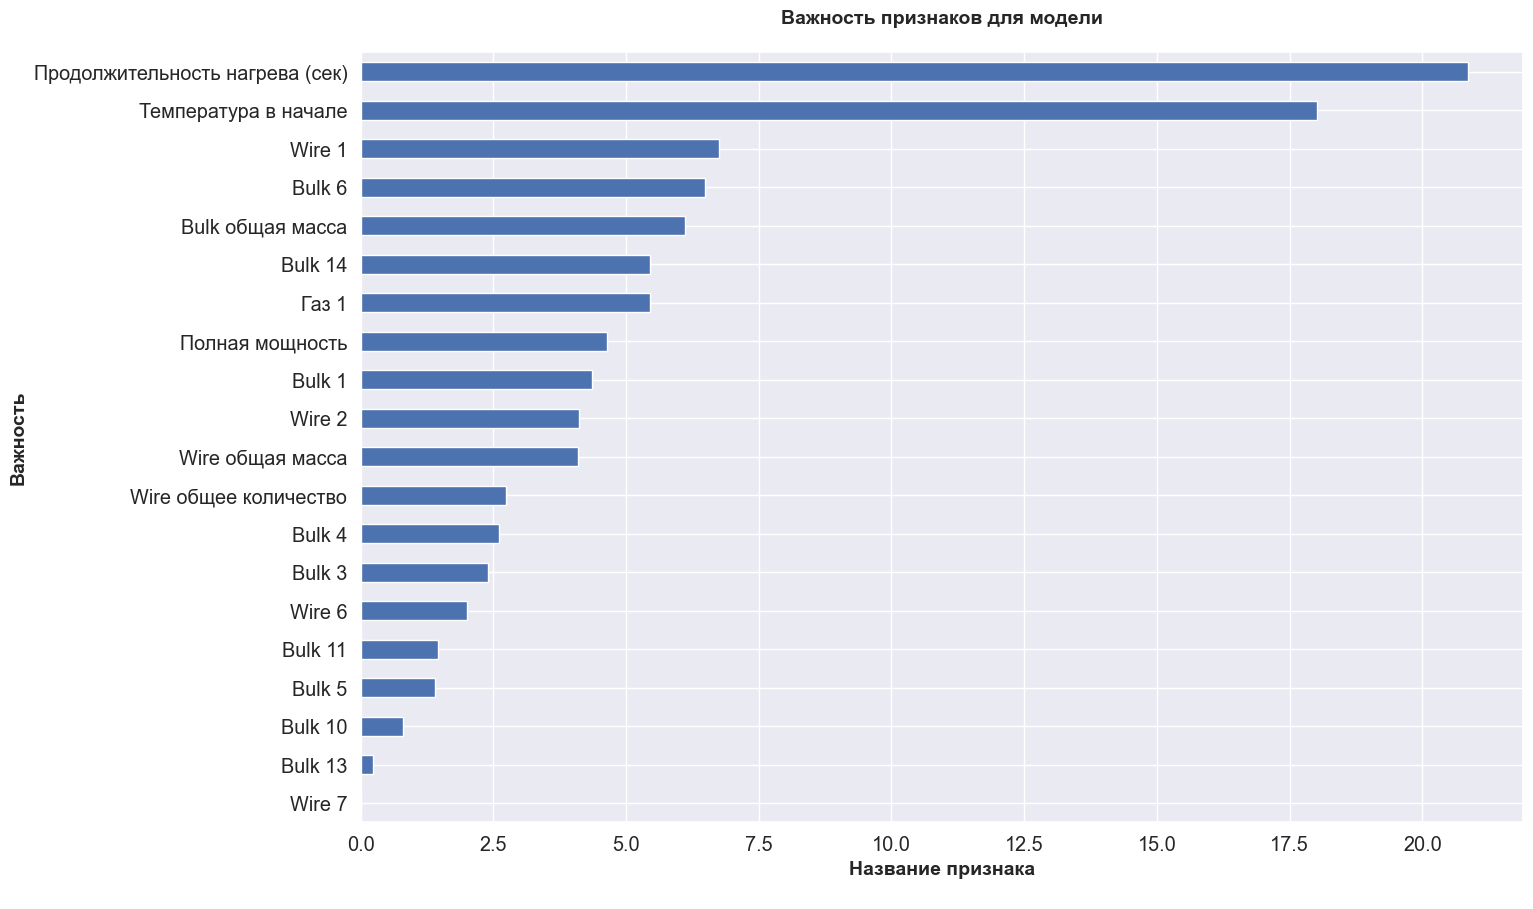

In [114]:
get_feature_importances(best_model_catboost_baseline['model'], features_train)

In [115]:
model_catboost = CatBoostRegressor(loss_function='MAE', random_state=RANDOM_STATE)

params_catboost = {'model__n_estimators': [100, 200],
                   'model__learning_rate': [0.01, 0.05, 0.1, 0.5]} 

In [116]:
best_model_catboost, metrics_catboost = get_metrics_gridsearch(model_catboost, 
                                                               column_transformer, 
                                                               params_catboost, 
                                                               'Catboost')
metrics = metrics.append(metrics_catboost)

0:	learn: 7.9290581	total: 3.85ms	remaining: 767ms
1:	learn: 7.8505569	total: 7.56ms	remaining: 749ms
2:	learn: 7.7746217	total: 10.8ms	remaining: 710ms
3:	learn: 7.7064029	total: 14.2ms	remaining: 696ms
4:	learn: 7.6047335	total: 17.6ms	remaining: 685ms
5:	learn: 7.5087069	total: 20.7ms	remaining: 669ms
6:	learn: 7.4405605	total: 23.6ms	remaining: 651ms
7:	learn: 7.3647307	total: 26.9ms	remaining: 647ms
8:	learn: 7.2914355	total: 30.1ms	remaining: 638ms
9:	learn: 7.2326310	total: 33.4ms	remaining: 635ms
10:	learn: 7.1781115	total: 36.6ms	remaining: 628ms
11:	learn: 7.1407263	total: 39.7ms	remaining: 622ms
12:	learn: 7.0810599	total: 42.6ms	remaining: 613ms
13:	learn: 7.0226129	total: 45.9ms	remaining: 610ms
14:	learn: 6.9890798	total: 48.7ms	remaining: 601ms
15:	learn: 6.9463121	total: 51.6ms	remaining: 594ms
16:	learn: 6.8874037	total: 54.3ms	remaining: 585ms
17:	learn: 6.8418643	total: 57ms	remaining: 576ms
18:	learn: 6.8031566	total: 59.9ms	remaining: 571ms
19:	learn: 6.7634163	tot

In [117]:
metrics

Модель     MAE      R2  Время обучения, сек  \
0   LinearRegression  6.3115  0.4097               0.0126   
0         ElasticNet  6.3563  0.3684               0.0097   
0       DecisionTree  7.1290  0.1485               0.0152   
0       RandomForest  6.2697  0.3230               0.7682   
0      LGBM_baseline  6.4592  0.3567               0.1172   
0        LGBM_optuna  6.4857  0.3778              16.1584   
0   XGBoost_baseline  6.7044  0.3249               1.5835   
0     XGBoost_optuna  6.2220  0.4092              41.9062   
0  Catboost_baseline  6.0785  0.4203               5.7226   
0           Catboost  6.1214  0.3420               2.6108   

   Время предсказания, сек  
0                   0.0036  
0                   0.0049  
0                   0.0044  
0                   0.0133  
0                   0.0106  
0                   0.0031  
0                   0.0037  
0                   0.0053  
0                   0.0094  
0                   0.0081

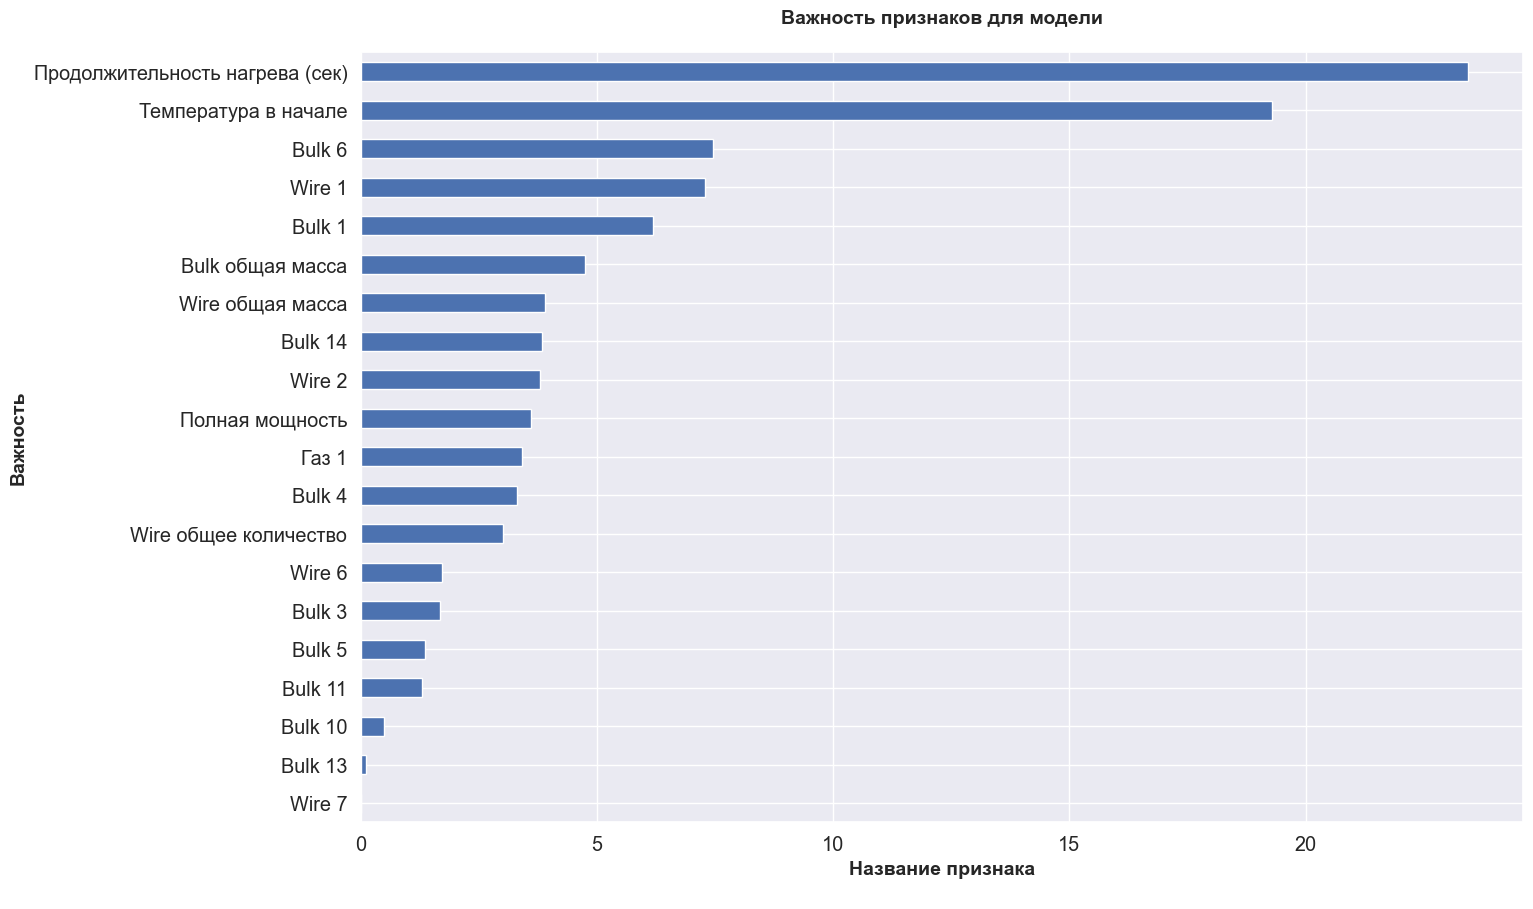

In [118]:
get_feature_importances(best_model_catboost['model'], features_train)

**Выводы**

- Была обучена бустинговая модель CatBoost "из коробки" и с подбором гиперпараметров;
- Параметры лучшей модели {'learning_rate': 0.05, 'n_estimators': 200};
- Значения метрик побили требуемый заказчиком порог 6.8 и составили `MAE` = 6.0785 и `R2` = 0.4203, этот результат является лучшим по результатам испытаний различных моделей;
- Разрыв в важности признаков сохраняется, для модели CatBoost по-прежнему самыми важными признаками являются `Продолжительность нагрева (сек)` и `Температура в начале`, остальные признаки распределены достаточно равномерно, не пригодившимися для осуществления предсказаний являются только `Bulk 13`, `Wire 7`.

### 4.5. Тестирование лучшей модели.

In [119]:
metrics.set_index('Модель', inplace=True)

In [120]:
metrics

MAE      R2  Время обучения, сек  \
Модель                                                   
LinearRegression   6.3115  0.4097               0.0126   
ElasticNet         6.3563  0.3684               0.0097   
DecisionTree       7.1290  0.1485               0.0152   
RandomForest       6.2697  0.3230               0.7682   
LGBM_baseline      6.4592  0.3567               0.1172   
LGBM_optuna        6.4857  0.3778              16.1584   
XGBoost_baseline   6.7044  0.3249               1.5835   
XGBoost_optuna     6.2220  0.4092              41.9062   
Catboost_baseline  6.0785  0.4203               5.7226   
Catboost           6.1214  0.3420               2.6108   

                   Время предсказания, сек  
Модель                                      
LinearRegression                    0.0036  
ElasticNet                          0.0049  
DecisionTree                        0.0044  
RandomForest                        0.0133  
LGBM_baseline                       0.0106  
LGBM_optuna                         0.0031  
XGBoost_baseline                    0.0037  
XGBoost_optuna                      0.0053  
Catboost_baseline                   0.0094  
Catboost                            0.0081

Проанализируем полученные нами на предыдущем шаге показатели с помощью визуализации распределения метрик в разрезе моделей от наименьшей к наибольшей с помощью барплотов.

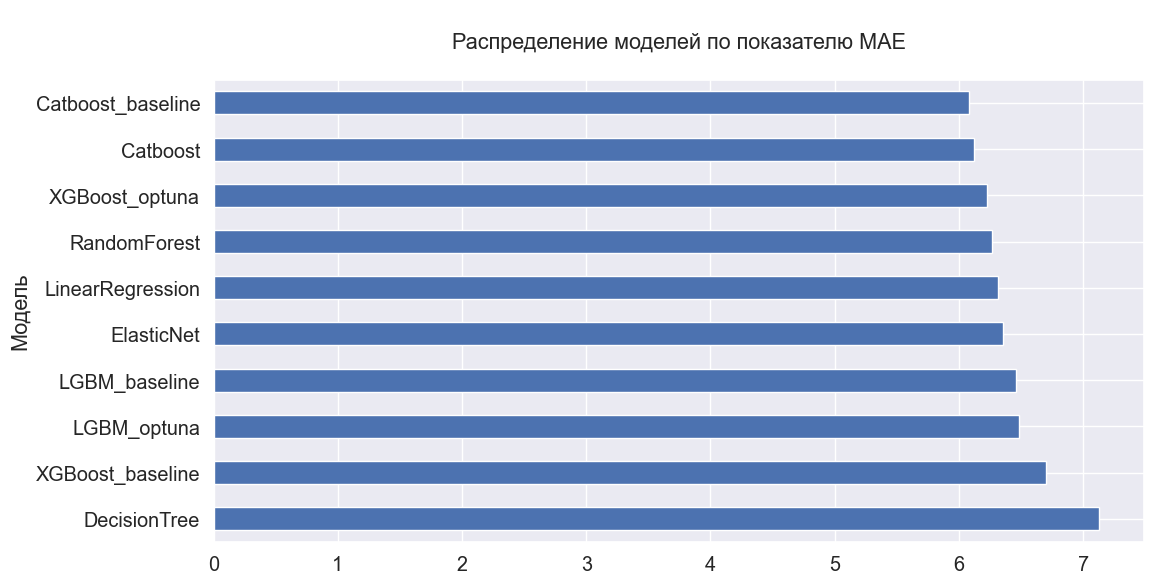

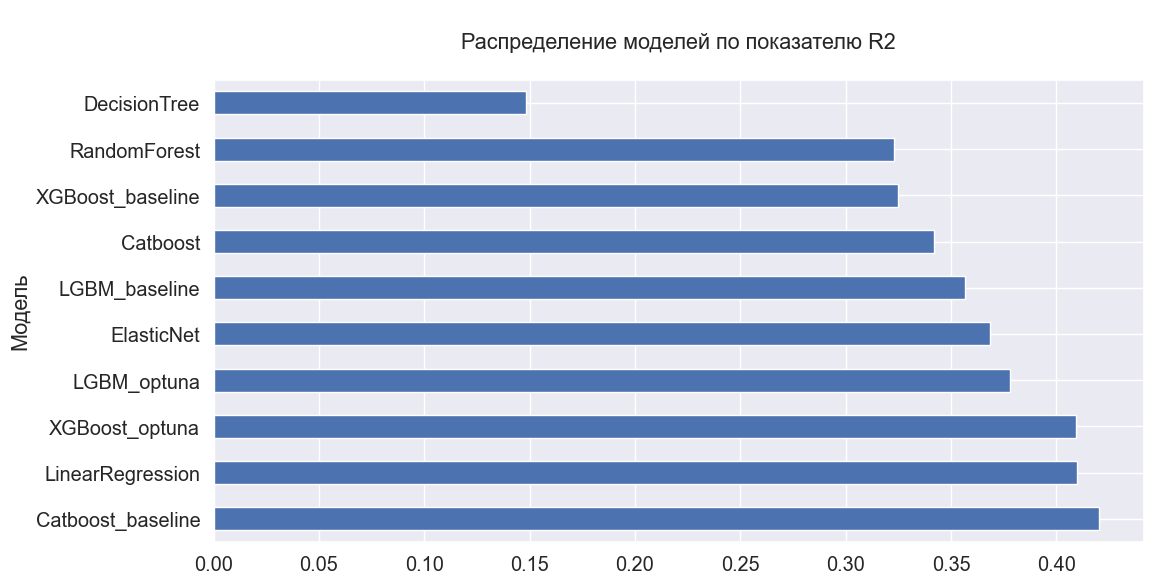

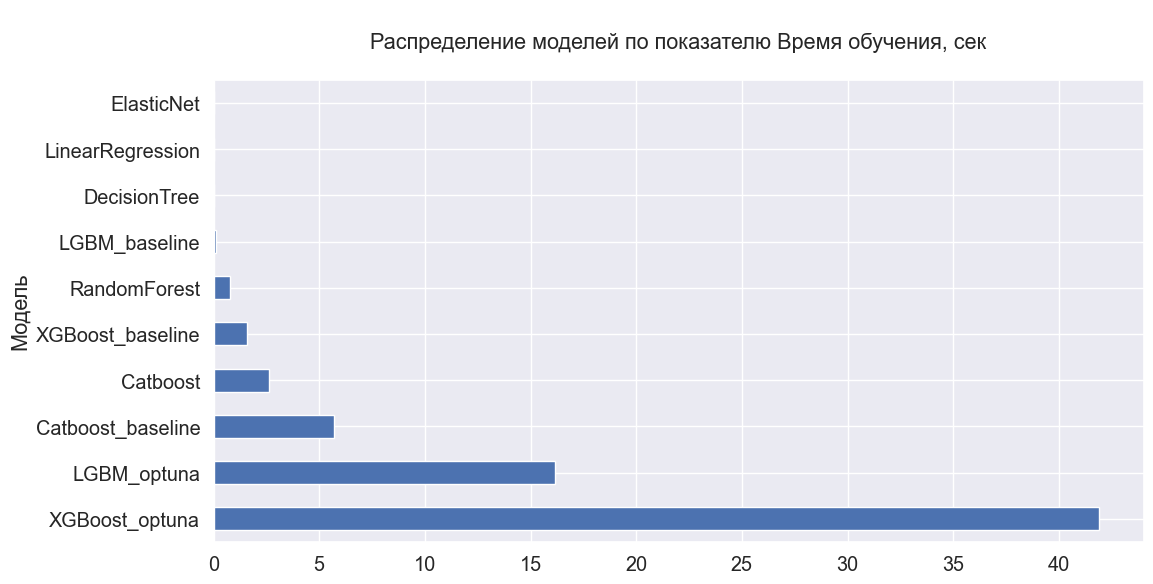

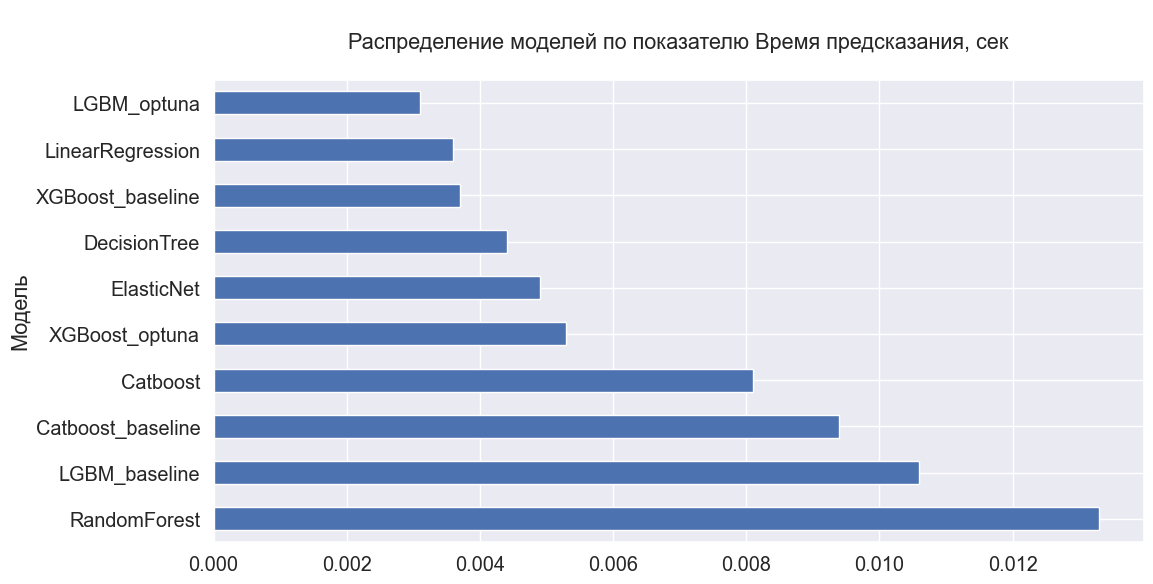

In [121]:
for col in metrics.columns:
    metrics.sort_values(col, ascending=False)[col].plot(kind='barh', title=f'\nРаспределение моделей по показателю {col}\n', figsize=(12, 6))
    plt.show();

**Выводы**

По ключевой  для заказчика метрике `MAE`:

- лидирует CatBoost без дополнительных гиперпараметров,
- от него незначительно отстает CatBoost с подбором гиперпараметров, 
- хорошие результаты также демонстрирует бустинг XGBoost с подобранными Оптуной гиперпараметрами, все они выдают показатели менее 6.2,
- далее идет ансамбль Случайный лес и линейные модели со скорами в районе 6.25 - 6.35,
- из бустингов хуже всех себя показал LGBMRegressor c `MAE` 6.42 - 6.45,
- завершает список Решающее дерево, оно не смогло выдать метрику меньше 7.1.

По метрике `R2` (коэффициент детерминации) можно сказать, что он довольно низок и варьируется от 0.32 до 0.42 у лучшей модели, которой опять таки является CatBoost.

В данном случае по Времени обучения и Времени предсказания мы модели не оцениваем, но хорошо заметно, что бустинги на Optuna учатся гораздо дольше других моделей, а Random Forest предсказывает в разы дольше остальных. 

Таким образом, проанализировав все составляющие, для финального тестирования я считаю правильным остановиться на CatBoostRegressor причем с гиперпараметрами "из коробки", так как он выдает наилучшее качество предсказаний по обеим метрикам, и при этом работает достаточно быстро.

In [122]:
# задаем лучшую модель с лучшими гиперпараметрами

best_model = CatBoostRegressor(random_state=RANDOM_STATE,
                                loss_function = 'MAE')
                 
best_model.fit(features_train,
               target_train,
               verbose=1)

# тестирование     
preds_test = best_model.predict(features_test)
          
# расчет метрик на тесте
best_mae = mean_absolute_error(target_test, preds_test)    
best_r2 = r2_score(target_test, preds_test)

0:	learn: 7.9645486	total: 1.67ms	remaining: 1.67s
1:	learn: 7.9096686	total: 3.35ms	remaining: 1.67s
2:	learn: 7.8677154	total: 4.59ms	remaining: 1.53s
3:	learn: 7.8112956	total: 5.77ms	remaining: 1.44s
4:	learn: 7.7473893	total: 6.96ms	remaining: 1.39s
5:	learn: 7.6942782	total: 8.06ms	remaining: 1.33s
6:	learn: 7.6522162	total: 9.2ms	remaining: 1.3s
7:	learn: 7.6116532	total: 10.3ms	remaining: 1.28s
8:	learn: 7.5593297	total: 11.5ms	remaining: 1.27s
9:	learn: 7.5161597	total: 12.7ms	remaining: 1.25s
10:	learn: 7.4670552	total: 13.9ms	remaining: 1.25s
11:	learn: 7.4245590	total: 15.1ms	remaining: 1.24s
12:	learn: 7.3893462	total: 16.2ms	remaining: 1.23s
13:	learn: 7.3419239	total: 17.3ms	remaining: 1.22s
14:	learn: 7.3005780	total: 18.5ms	remaining: 1.22s
15:	learn: 7.2622344	total: 19.7ms	remaining: 1.21s
16:	learn: 7.2283426	total: 20.8ms	remaining: 1.2s
17:	learn: 7.1921333	total: 21.9ms	remaining: 1.2s
18:	learn: 7.1607704	total: 23ms	remaining: 1.19s
19:	learn: 7.1174955	total: 

174:	learn: 5.3419803	total: 202ms	remaining: 952ms
175:	learn: 5.3400836	total: 203ms	remaining: 952ms
176:	learn: 5.3366818	total: 205ms	remaining: 952ms
177:	learn: 5.3300382	total: 206ms	remaining: 951ms
178:	learn: 5.3256777	total: 207ms	remaining: 950ms
179:	learn: 5.3199751	total: 208ms	remaining: 948ms
180:	learn: 5.3130692	total: 209ms	remaining: 948ms
181:	learn: 5.3104619	total: 211ms	remaining: 946ms
182:	learn: 5.3019508	total: 212ms	remaining: 945ms
183:	learn: 5.2962605	total: 213ms	remaining: 944ms
184:	learn: 5.2889157	total: 214ms	remaining: 943ms
185:	learn: 5.2857992	total: 215ms	remaining: 942ms
186:	learn: 5.2793310	total: 217ms	remaining: 943ms
187:	learn: 5.2756668	total: 218ms	remaining: 942ms
188:	learn: 5.2714870	total: 219ms	remaining: 941ms
189:	learn: 5.2645426	total: 221ms	remaining: 940ms
190:	learn: 5.2598678	total: 222ms	remaining: 940ms
191:	learn: 5.2546939	total: 223ms	remaining: 939ms
192:	learn: 5.2482947	total: 224ms	remaining: 938ms
193:	learn: 

336:	learn: 4.7049306	total: 398ms	remaining: 782ms
337:	learn: 4.7012919	total: 399ms	remaining: 782ms
338:	learn: 4.6994918	total: 400ms	remaining: 781ms
339:	learn: 4.6958077	total: 402ms	remaining: 780ms
340:	learn: 4.6922134	total: 403ms	remaining: 779ms
341:	learn: 4.6880763	total: 404ms	remaining: 778ms
342:	learn: 4.6837293	total: 406ms	remaining: 777ms
343:	learn: 4.6798594	total: 407ms	remaining: 776ms
344:	learn: 4.6778448	total: 408ms	remaining: 775ms
345:	learn: 4.6758850	total: 410ms	remaining: 774ms
346:	learn: 4.6731375	total: 411ms	remaining: 773ms
347:	learn: 4.6707083	total: 412ms	remaining: 772ms
348:	learn: 4.6664852	total: 414ms	remaining: 772ms
349:	learn: 4.6656589	total: 415ms	remaining: 771ms
350:	learn: 4.6612339	total: 417ms	remaining: 770ms
351:	learn: 4.6565869	total: 418ms	remaining: 770ms
352:	learn: 4.6509033	total: 419ms	remaining: 769ms
353:	learn: 4.6457812	total: 421ms	remaining: 768ms
354:	learn: 4.6434231	total: 422ms	remaining: 766ms
355:	learn: 

495:	learn: 4.2566305	total: 591ms	remaining: 601ms
496:	learn: 4.2540120	total: 593ms	remaining: 600ms
497:	learn: 4.2517401	total: 594ms	remaining: 599ms
498:	learn: 4.2508312	total: 595ms	remaining: 597ms
499:	learn: 4.2492094	total: 596ms	remaining: 596ms
500:	learn: 4.2478966	total: 598ms	remaining: 595ms
501:	learn: 4.2454460	total: 599ms	remaining: 594ms
502:	learn: 4.2436846	total: 600ms	remaining: 593ms
503:	learn: 4.2426859	total: 601ms	remaining: 592ms
504:	learn: 4.2412863	total: 602ms	remaining: 591ms
505:	learn: 4.2386311	total: 604ms	remaining: 589ms
506:	learn: 4.2363579	total: 605ms	remaining: 588ms
507:	learn: 4.2345277	total: 607ms	remaining: 587ms
508:	learn: 4.2335960	total: 608ms	remaining: 586ms
509:	learn: 4.2320569	total: 609ms	remaining: 585ms
510:	learn: 4.2301367	total: 610ms	remaining: 584ms
511:	learn: 4.2275108	total: 612ms	remaining: 583ms
512:	learn: 4.2247943	total: 613ms	remaining: 582ms
513:	learn: 4.2223732	total: 614ms	remaining: 581ms
514:	learn: 

662:	learn: 3.9506981	total: 786ms	remaining: 399ms
663:	learn: 3.9500042	total: 788ms	remaining: 399ms
664:	learn: 3.9484086	total: 789ms	remaining: 397ms
665:	learn: 3.9458857	total: 790ms	remaining: 396ms
666:	learn: 3.9443906	total: 791ms	remaining: 395ms
667:	learn: 3.9438260	total: 793ms	remaining: 394ms
668:	learn: 3.9428046	total: 794ms	remaining: 393ms
669:	learn: 3.9415460	total: 795ms	remaining: 392ms
670:	learn: 3.9406322	total: 796ms	remaining: 390ms
671:	learn: 3.9381593	total: 798ms	remaining: 389ms
672:	learn: 3.9375340	total: 799ms	remaining: 388ms
673:	learn: 3.9356266	total: 800ms	remaining: 387ms
674:	learn: 3.9346279	total: 801ms	remaining: 386ms
675:	learn: 3.9332879	total: 803ms	remaining: 385ms
676:	learn: 3.9326014	total: 804ms	remaining: 383ms
677:	learn: 3.9307316	total: 805ms	remaining: 382ms
678:	learn: 3.9302848	total: 806ms	remaining: 381ms
679:	learn: 3.9295550	total: 807ms	remaining: 380ms
680:	learn: 3.9287929	total: 808ms	remaining: 379ms
681:	learn: 

826:	learn: 3.7585474	total: 980ms	remaining: 205ms
827:	learn: 3.7575835	total: 982ms	remaining: 204ms
828:	learn: 3.7557396	total: 983ms	remaining: 203ms
829:	learn: 3.7555032	total: 985ms	remaining: 202ms
830:	learn: 3.7548758	total: 986ms	remaining: 200ms
831:	learn: 3.7540896	total: 987ms	remaining: 199ms
832:	learn: 3.7530283	total: 988ms	remaining: 198ms
833:	learn: 3.7512488	total: 989ms	remaining: 197ms
834:	learn: 3.7494088	total: 990ms	remaining: 196ms
835:	learn: 3.7482482	total: 992ms	remaining: 195ms
836:	learn: 3.7468026	total: 993ms	remaining: 193ms
837:	learn: 3.7463601	total: 994ms	remaining: 192ms
838:	learn: 3.7457967	total: 995ms	remaining: 191ms
839:	learn: 3.7430692	total: 997ms	remaining: 190ms
840:	learn: 3.7411254	total: 998ms	remaining: 189ms
841:	learn: 3.7386568	total: 999ms	remaining: 187ms
842:	learn: 3.7382008	total: 1s	remaining: 186ms
843:	learn: 3.7377580	total: 1s	remaining: 185ms
844:	learn: 3.7371615	total: 1s	remaining: 184ms
845:	learn: 3.7357395

990:	learn: 3.5848563	total: 1.17s	remaining: 10.7ms
991:	learn: 3.5843608	total: 1.18s	remaining: 9.48ms
992:	learn: 3.5840557	total: 1.18s	remaining: 8.3ms
993:	learn: 3.5830461	total: 1.18s	remaining: 7.12ms
994:	learn: 3.5819423	total: 1.18s	remaining: 5.93ms
995:	learn: 3.5809792	total: 1.18s	remaining: 4.74ms
996:	learn: 3.5799876	total: 1.18s	remaining: 3.56ms
997:	learn: 3.5794278	total: 1.18s	remaining: 2.37ms
998:	learn: 3.5784321	total: 1.19s	remaining: 1.19ms
999:	learn: 3.5777096	total: 1.19s	remaining: 0us


In [123]:
print(f'Метрика MAE для лучшей модели на тестовой выборке: {best_mae:.4f}')  
print(f'Коэффициент детерминации для лучшей модели на тестовой выборке: {best_r2:.4f}')

Метрика MAE для лучшей модели на тестовой выборке: 6.1751
Коэффициент детерминации для лучшей модели на тестовой выборке: 0.4163


Проверим адекватность нашей модели путем сравнения ее показателей со значениями метрик, полученными от константной модели, которая по умолчанию просто предсказывает самый часто встречающийся класс.

In [124]:
dummy_reg = DummyRegressor(strategy='mean')

dummy_reg.fit(features_train, target_train)
dummy_preds = dummy_reg.predict(features_test)

dummy_mae = mean_absolute_error(target_test, dummy_preds)    
dummy_r2 = r2_score(target_test, dummy_preds)

print(f'Метрика MAE для константной модели на тестовой выборке: {dummy_mae:.4f}')  
print(f'Коэффициент детерминации для константной модели на тестовой выборке: {dummy_r2:.4f}')

Метрика MAE для константной модели на тестовой выборке: 8.1894
Коэффициент детерминации для константной модели на тестовой выборке: -0.0009


**Выводы**

- При проверке лучшей модели CatBoostRegressor на отложенной тестовой выборке удалось получить итоговое значение метрики MAE равное 6.1751 (при пороге требуемом заказчиком в 6.8).
- Коэффициент детерминации составил 0.4163, что является достаточно высоким результатом, мы можем утверждать, что модель и впредь будет достаточно хорошо предсказывать на неизвестных данных.
- Все модели прошли испытание на адекватность, так как в случае константной модели метрика `MAE` составляет 8.1894, а `R2` фактически равен нулю, то есть модель не способна объяснить никакой дисперсии в данных.

Оценим важность признаков для финальных предсказаний с помощью `feature_importance` и `SHAP`.

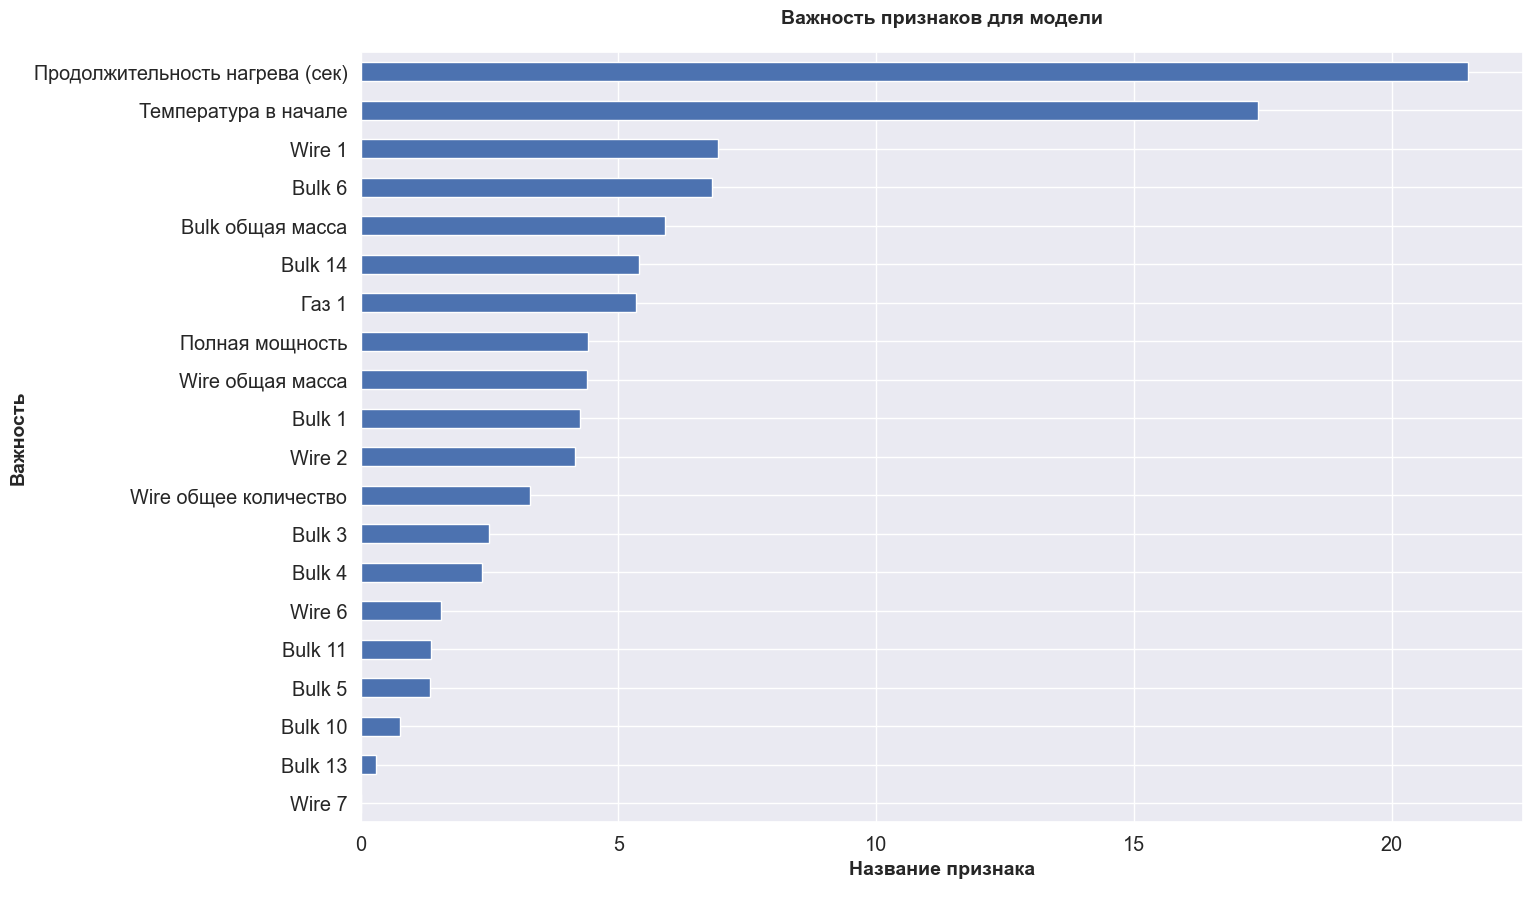

In [125]:
get_feature_importances(best_model, features_test)

In [126]:
def get_shap(model, X, y, plot_size=(12, 10)):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X, y)

    shap.summary_plot(shap_values, X, plot_size=plot_size)

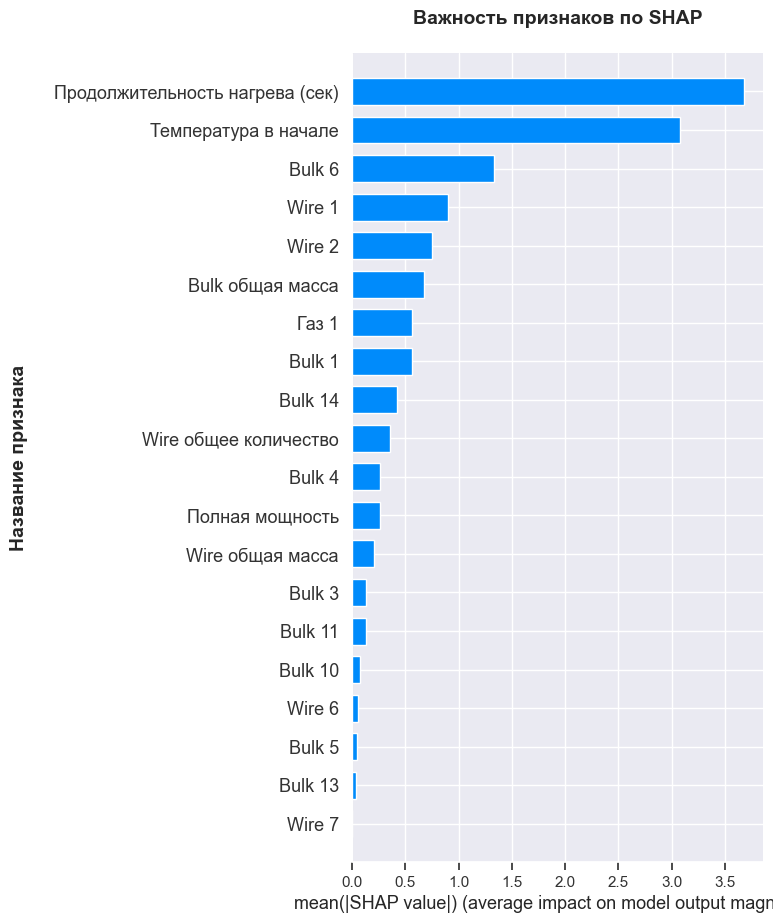

In [127]:
plt.ylabel('Название признака\n', fontsize=14, weight='bold')
plt.title('Важность признаков по SHAP\n', fontsize=14, weight='bold')

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(features_test, target_test)
shap.summary_plot(shap_values, features_test, plot_type='bar')

**Выводы**

Графики значимости признаков показывают, что:
    
- наиболее важными признаками для нашей модели являются длительность нагрева, первый замер температуры, `Bulk 6` или `Wire 1`;
- среднезначимые признаки для модели: `Bulk общая масса`, `Bulk 14`, `Газ 1`, `Полная мощность`, `Wire общая масса`, `Bulk 1` и `Wire 2`;
- малозначимые признаки, но при этом явно используемые моделью: `Wire общее количество`, `Bulk 3`, `Bulk 4`, `Wire 6`, `Bulk 11`, `Bulk 5`, `Bulk 10` и `Bulk 13`;
- неинформативным признаком является `Wire 7`, а остальные мы исключили ранее уже на этапе `feature selection`.

Получается, что не все добавки в равной степени влияют на работу модели, а вот общая продолжительность нагрева, первый замер температуры и проволочная добавка `Wire 1` и сыпучая добавка `Bulk 6` - влияют сильно.
Можно такж отметить, что на тепловой карте корреляция признаков, в итоге ставших наиболее значимыми для модели, по отношению к финальному замеру температуры была самая высокая:

- с `Wire 1` 0.317 ,
- с `Температура в начале` 0.301, 
- с `Продолжительность нагрева (сек)` 0.278.

### 4.6. Выводы по этапу

Были обучены 7 моделей с автоматической балансировкой весов и перебором гиперпараметров через GridSearchCV:

- линейные модели Линейная регрессия и ElasticNet,
- деревянная модель Решающее дерево и ансамбль деревьев Случайный лес,
- три модели градиентного бустинга XGBoost, LGBMRegressor и CatBoostRegressor.

Оценка моделей проводилась с помощью кросс-валидации по метрикам `MAE` и `R2`, метрики формировалиь в датафрейм для дальнейшего анализа, также для каждой модели была визуализирована и оценена важность признаков. 

В ходе испытаний было показано, что лучшие значения метрик достигались на бустинге `CatBoostRegressor` с гиперпараметрами по умолчанию, на обучающей выборке они составили `MAE` = 6.0785 и `R2` = 0.4203. Эти значения побили порог заказчика 6.8, поэтому данная модель была отобрана по итогам испытаний для тестирования на отложенной тестовой выборке.

На тестовой выборке удалось получить рекордные значения `MAE` = 6.1751 и коэффициент детерминации 0.4163, что также превышает обозначенный заказчиком порог.

Анализ признаков, наиболее значимых для модели, показал, что:

- наибольшей значимостью обладают длительность нагрева, первый замер температуры, добавки `Wire 1` и `Bulk 6`;
- далее по значимости идут `Bulk общая масса`, `Bulk 14`, `Газ 1`, `Полная мощность`, `Wire общая масса`, `Bulk 1` и `Wire 2`;
- все остальные признаки, связанные с добавлением сыпучих и проволочных материалов не показали особой значимости, однако, вносят свой вклад в предсказания моделей.

Таким образом, можно сказать, что модель позволяет достаточно эффективно решать поставленную перед нами задачу предсказания конечной температуры сплава, однако, в дальнейшем метрики могут быть дополнительно улучшены путем выбора других алгоритмов обучения, более тонкой настройки параметров текущей модели или более тщательному отбору фичей.

## 5. Отчет для заказчика.

**Целью** нашего исследования было создание модели машинного обучения, которая на основании имеющихся данных, будет эффективно предсказывать температуру стали для металлургического комбината. Температура стали напрямую влияет на потребление электроэнергии на этапе обработки стали, и вычисления необходимы, чтобы оптимизировать производственные расходы.

Целевыми метриками оценки точности предсказаний модели в исследовании являлись `R2` и `MAE`, по которой необходимо было достичь порога не более 6.8 на финальном тестировании.

***

Постановка плана исследования заключалась в реализации следующих **ключевых шагов**:

1. `Загрузка и первичное изучение доступных данных`: проведение предварительного анализа основных характеристик, оценка пропусков и явных дубликатов, систематизация описания признаков.

2. `Исследовательский анализ данных`: изучение и оценка распределения значений во временных и численных колонках, выявление пропусков и выбросов в конкретных колонках, выявление расхождения количества партий в датасетах.

3. `Предобработка данных`:  

- удаление аномалий и неспецифичных данных;
- удаление промежуточных температур (по требованию заказчика), а также данных без финального значения температуры;
- извлечение целевого признака, как значение последней измеренной температуры по партии;
- правильное объединение признаков из всех таблиц по ключу key (номер партии), в разных таблицах количество уникальных идентификаторов партий отличается);
- извлечение дополнительных признаков из существующих (`feature engineering`);
- заполнение возникших в результате объединения датасетов пропусков.

4. `Моделирование данных`: 

- исследование корреляции и отбор признаков для устранения мультиколлинеарности,
- трансформация отобранных признаков (масштабирование),
- разбиение выборки в отношении train/test = 3/1,
- обучение 7 моделей из различных семейств: двух линейных (линейная регрессия и ElasticNet), двух логических (Решающее дерево, ансамблевый Случайный лес), а также градиентных бустингов (XGBoost, LGBMRegressor, CatBoostRegressor) и оценка моделей на кросс-валидации с применением подбора гиперпараметров,
- оценка важности признаков для моделей с помощью метода feature_importance,
- сведение результатов по целевым метрикам от всех моделей в единую таблицу.

5. `Тестирование лучшей модели`: 

- выбор по результатам обучения одной модели, показывающей наивысшие значения метрик, и оценка ее на отложенной тестовой выборке, 
- проведение сравнения с константной моделью DummyRegressor для понимания адекватности предложенного решения, 
- интерпретация важности признаков, подаваемых в модель и влияющих на принятие ей решений, с помощью библиотеки SHAP.

6. `Выводы по работе в форме отчета`.

***

В рамках решения задачи были реализованы все намеченные шаги согласно изначально поставленному плану, пороговые значения метрики 6.8 были успешно достигнуты и побиты. Кроме того, не потребовалось оптимизировать скорость выполнения кода - предложение решение отрабатывает достаточно быстро и демонстрирует стабильно высокие показатели.

***

`Предобработка данных` является важным этапом на пути создания признаков для моделей, так как большинство из них не умеет работать с пропусками, а аномалии влияют негативно на процесс обучения и получаемые предсказания.

Изначально было обнаружено единичное аномальное значение `Реактивной мощности` меньше 0, которое было удалено.

Также были удалены все строки, где темпратура нагрева сплава в колонке `Температура в начале` была ниже 1500 градусов, то есть не соответствовала температурам, при которых плавится сталь. Такие значения можно списать на технические погрешности или отладку процесса.

Также существовали строки без значений по финишным температурам, а так как именно этот показатель является для нас ключевым в данном исследовании, то они тоже были исключены.

Кроме того, удалению подверглись и все промежуточные значения температур, так как это является одним из требований к исследованию, чтобы предсказания велись только по самой первой температуре, поданной к сплаву.

Для выделения целевого признака последний замер температуры был выделен в отдельный признак-столбец `Температура в конце (целевой признак)`.

Далее было произведено объединение датафреймов по номеру партии `key`, причем только по тем номерам, которые есть во всех датафреймах (внутреннее объединение). Это позволило сократить общее количество строк до 2325, при этом не потеряв нужной информации по температурам, в результате выполненных преобразований.

На этапе создания новых фичей были проделаны следующие операции:

- временные данные по нагревам были заменены на новый признак `Время между нагревами (сек)`;
- также благодаря временным данным извлечены признаки `Количество итераций нагрева` и `Продолжительность нагрева` как разница временных значений между максимальным и минимальным временем нагрева для конкретной партии;
- из `Активной мощности` и `Реактивной мощности` по формуле был создан признак `Полная мощность`;
- также по формуле был выделен новый признак `Работа` (энергия, потраченная на нагревание); 
- общая масса и количество добавляемых в сталь сыпучих и проволочных материалов нашли отражение в признаках `Bulk общая масса`, `Bulk общее количество`, `Wire общая масса`, `Wire общее количество`.

Пропуски в данных о подаваемых сыпучих и проволочных материалах (датасеты `data_bulk` и `data_wire`) были заполнены нулями.

После изучени статистик по финальному датасету был окончательно удален признак `Wire 5`, так как он содержал только нулевые значения.

***

В данном исследовании я бы выделила несколько `Трудностей`, которые оказывают сильное влияние на получаемый результат:

- данные, отражающие по сути разные стороны одного процесса представлены 7 датасетами, то есть сильно разрознены;
- присутствует большое количество пропусков, как о температурным показателям (18.94%), так и по добавкам (более 50%, а в некоторых колонках и вплоть до 98% пропусков);
- изначально данные по температуре собираются как множественные строки для одного ключа (номера партии);
- присутствуют "мусорные" столбцы, с малым количеством отличных от нуля значений (что, однако, является спецификой технологического процесса);
- многие признаки имеют малую информативность для предсказания целевого признака моделями;
- окончательный набор строк после предобработки и объединения датафреймов представлен всего лишь 2325 строками, то есть возникает большая веротность переобучения сложных моделей и снижение качества их предсказательной способности в реальных условиях.

`Основной сложностью`, с которой пришлось столкнуться в процессе проведения работы, является проблема мультиколлинеарности между признаками. Сет признаков после проведения предобработки и генерации новых фичей содержал 38 характеристик процесса выплавки стали, что при осмотре матрицы корреляции показало свою избыточность, так как многие признаки проявляли сильную взаимосвязь друг с другом. Для обучения моделей лучше всего выбирать признаки, которые имеют высокую корреляцию с целевой переменной (финальной температурой сплава) и минимальную корреляцию с другими признаками.

Данная проблема была устранена с помощью построения тепловой диаграммы, которая позволила выявить и проанализировать взаимосвязи, после чего они были описаны, а создающие мультиколлинеарность признаки были удалены, и далее модели на них не обучались.

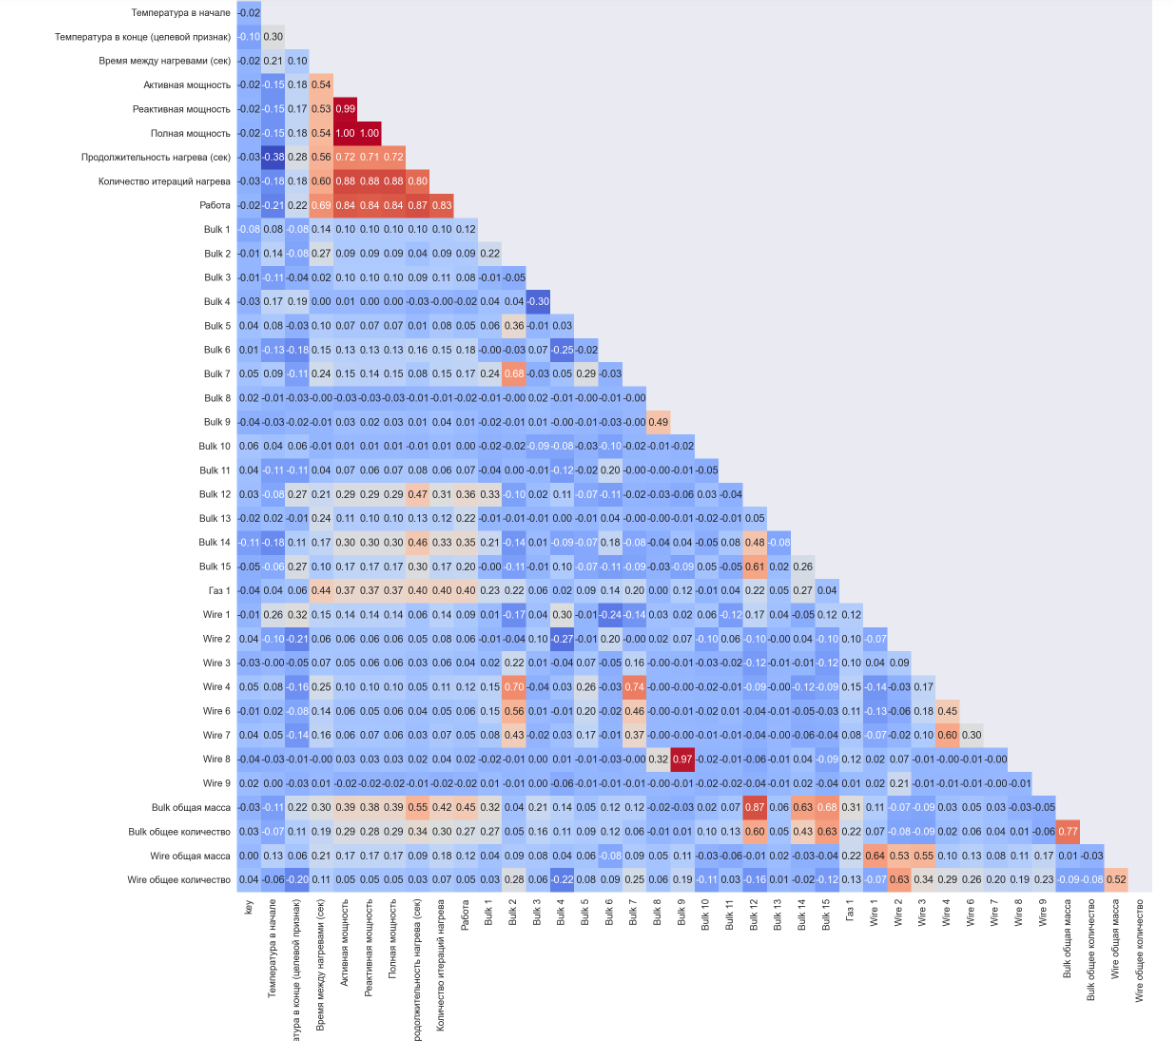

Целевой признак сильнее всего коррелирует с такими параметрами, как:

- `Wire 1`,
- `Температура в начале`, 
- `Продолжительность нагрева (сек)`,
- `Bulk 12`,
- `Bulk 15`,
- `Вulk общая масса`,
- `Работа`,
- `Wire 2`, 
- `Wire общее количество`,
- `Bulk 6`, 
- `Wire 4`.

Зависимости как прямо пропорциональные, так и обратные, но во всех случаях не сильные (<0.5).

Судя по диаграмме корреляций, 

- `Bulk 9` и `Wire 8` имеет почти полную зависимость (0.974968), нужно оставить только один признак (а `Bulk 9` чуть сильнее связан с целевой переменной),
- `Bulk 2`, `Bulk 7` и `Wire 7` связаны как между собой, так и сильно связаны с `Wire 4` (больше 0.6),
- `Wire 4` связан с `Wire 7` на уровне 0.6, также как и `Bulk 12` и `Bulk 15` (видимо признаки несут сходную информацию).

Такое состояние является мультиколлинеарностью, и перед подачей данных в модели, от нее нужно избавиться.

Также заметна сильная корреляция между собой признаков `Активная мощность`, `Реактивная мощность` и `Полная мощность`, так как они сильно связаны друг с другом по смыслу, а значения полной мощности являются просто результатом математических преобразований двух других колонок. В связи с этим, стоит сократить признаковое пространство и оставить только колонку `Полная мощность`. Из сгенерированных нами самостоятельно фичей, были оставлены только те, которые сильно коррелируют с финальным замером температуры (например, `Продолжительность нагрева (сек)` и `Полная мощность`), остальные были удалены.

Кроме того, должны подвергнуться удалению признаки:

- `Количество итераций нагрева` и `Время между нагревами (сек)`, так как сильно коррелируют с `Продолжительность нагрева (сек)` (притом что влияние `Продолжительность нагрева (сек)` на целевую переменную в конечном итоге гораздо выше),
- `Работа` из-за наличия корреляции 0.87 с признаком `Продолжительность нагрева (сек)`,
- `Bulk общее количество` так как сильно дублирует по получаемой ценности информацию из признака `Bulk общая масса`,
- `Bulk 8`, `Bulk 9`, `Bulk 12`, `Wire 3`, `Wire 9`, так как имеют почти нулевую корреляцию с остальными признаками, то есть для модели важной информации, скорее всего, нести не будут.

Таким образом, для обучения моделей были отобраны следующие 20 признаков:
 
- `Температура в начале` - наиболее важный показатель от которого непосредственно зависит финальный температурный замер (целевая переменная),  
- `Продолжительность нагрева (сек)` - разница между минимальным и максимальным значениями времени проводимого нагрева,
- `Полная мощность` - агрегирующая метрика над показателями активной и реактивной мощности,
- `Bulk 1`, `Bulk 3`, `Bulk 4`, `Bulk 5`, `Bulk 6`, `Bulk 10`, `Bulk 11`, `Bulk 13`, `Bulk 14`, а также `Bulk общая масса` - именно эти сыпучие добавки показали и хорошую связь с целевой переменной, и низкую зависимость друг с другом,
- `Газ 1` - объем одаваемого для продувки газа, 
- `Wire 1`, `Wire 2`, `Wire 6`, `Wire 7`, `Wire общая масса`, `Wire общее количество` - только эти проволочные добавки 

Все они показали достаточную связь с целевой переменной, и низкую корреляцию друг с другом. 

Финальная диаграмма корреляции имеет следующий вид:

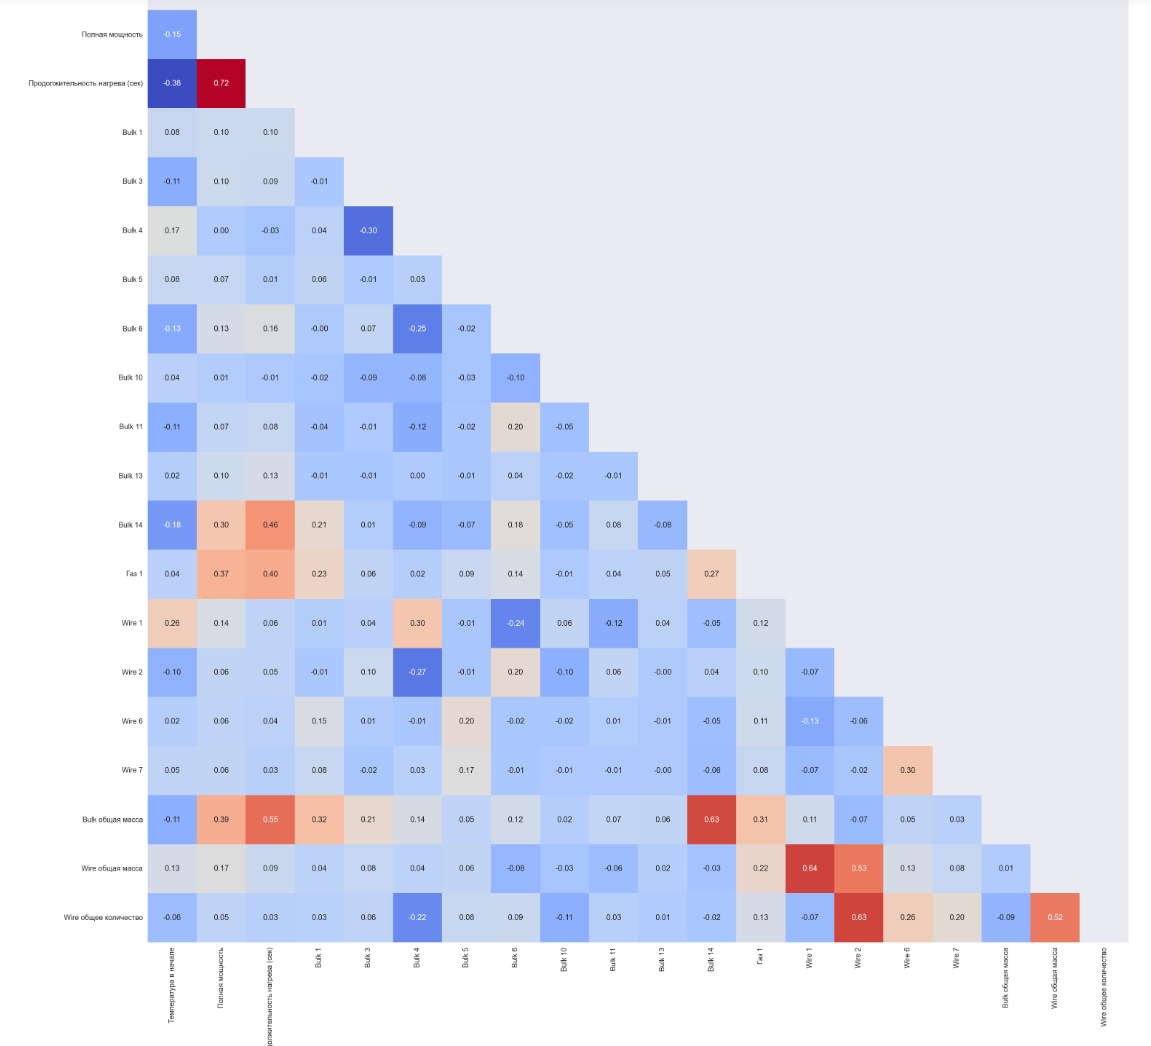

`Полная мощность` продолжает иметь сильную корреляцию с `Продолжительность нагрева (сек)`, так как по логике процесса взаимосвязаны, однако, выбрасывание этого признака в дальнейшем не покажет особой разницы и только ухудшит предсказания. Кроме того, оба признака имеют высокую корреляцию с целевой переменной.

Далее чтобы не допустить утечку целевого признака (ситуация, когда на обучающих данных модели покажут высокие значения метрик, но затем не смогут удерживать высокое качество предсказаний на новых данных в реальных условиях), таргетная переменная была отделена от признаков, а выборка была разделена на обучающую и отложенную тестовую части  в соотношении 3 к 1.

Колонки, содержащие непрерывные числовые значения были масштабированы (приведены к единой шкале значений) с помощью инструмента `StandartScaler`. Кодировщик были помещен в пайплайн с помощью `ColumnTransformer`, чтобы стандартизировать процесс преобразований, сделать его автономным и последовательным при добавлении новых фичей.

***

Далее были обучены 7 различных моделей, подбор гиперпараметров осуществлялся с помощью перебора параметров по сетке с `GridSearchCV`, а оценка проходила на кросс-валидации. Для бустингов применялось обучение как с параметрами по умолчанию, так и через подбор `OptunaSearchCV` или `GridSearchCV`. Также для всех моделей оценивались признаки, имеющие наибольшую важность в составлении предсказаний.

Результаты проведенных экспериментов и полученные значени метрик `MAE` и `R2` отражены в таблице.

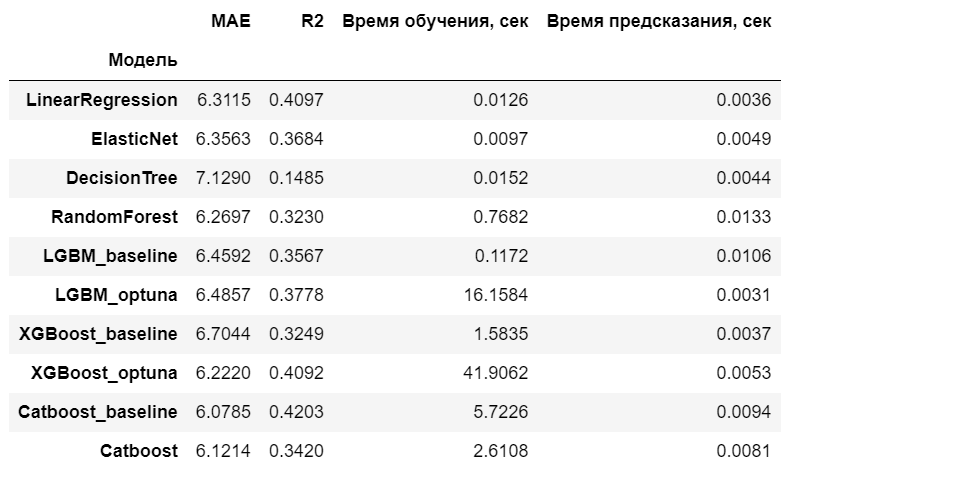

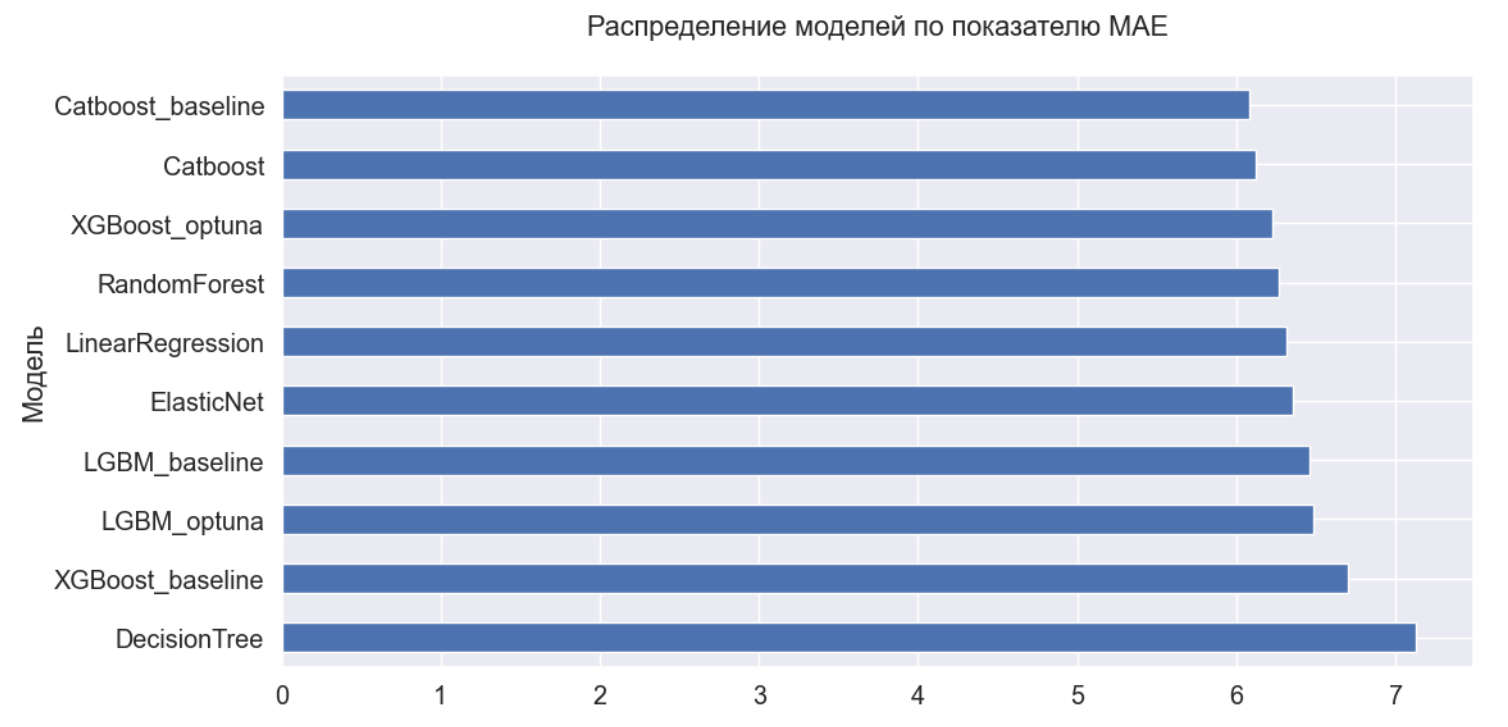

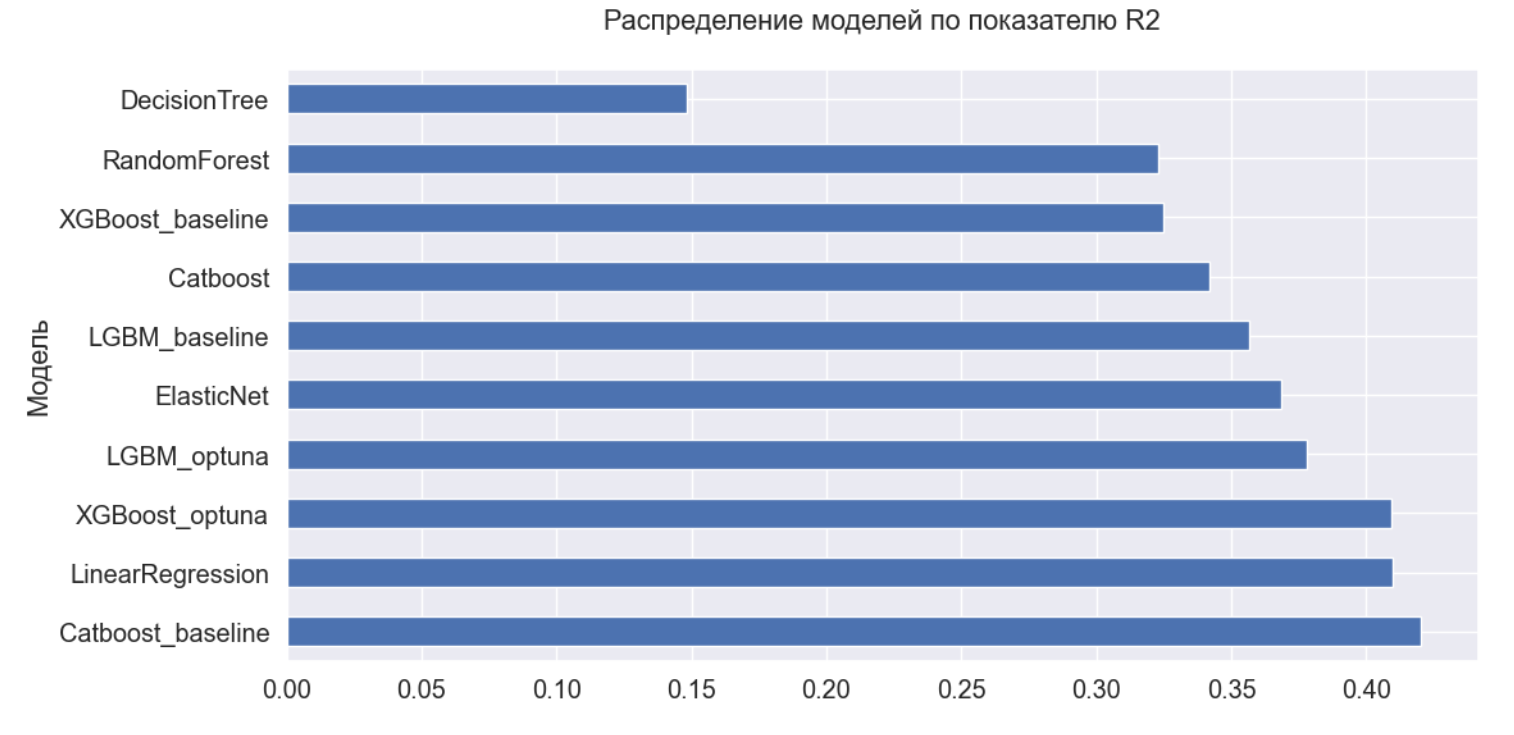

Из рассмотренных моделей все, кроме Решающего дерева, смогли побить порог заказчика по `MAE` в 6.8, однако, особенно эффективными оказались бустинги `XGBoost` и `CatBoost`. Таким образом, для финального тестирования была отобрана лучшая модель:

- `CatBoostRegressor` 
- с гиперпараметрами по умолчанию, 
- для которой на обучающей выборке на кросс-валидации были получены наивысшие по значения метрик `MAE` = 6.0785 и `R2` = 0.4203.

Этой модели была продемонстрирована отложенная ранее тестовая выборка, чтобы убедиться в качестве получаемых с ее помощью предсказаний, и были получены следующие значения метрик:

- Метрика MAE : 6.1751
- Коэффициент детерминации R2 : 0.4163

Эти результаты превосходят необходимый порог в 6.8, модель способна объяснить 41% изменчивости данных. Таким образом, модель ошибается всего на 6.1 градуса, что является достаточно низким показателем средней ошибки.

Кроме того, была показана адекватность полученной модели относительно константного `DummyRegressor` (который по умолчанию предсказывает среднее значение по всей выборке), для него `MAE` составил 8.99, а коэффициент детерминал ушел в ноль, что говорит о полном отсутствии выявления закономерностей из данных.
***

Для интерпретируемости результатов была визуализирована важность признаков, подаваемых в модель.

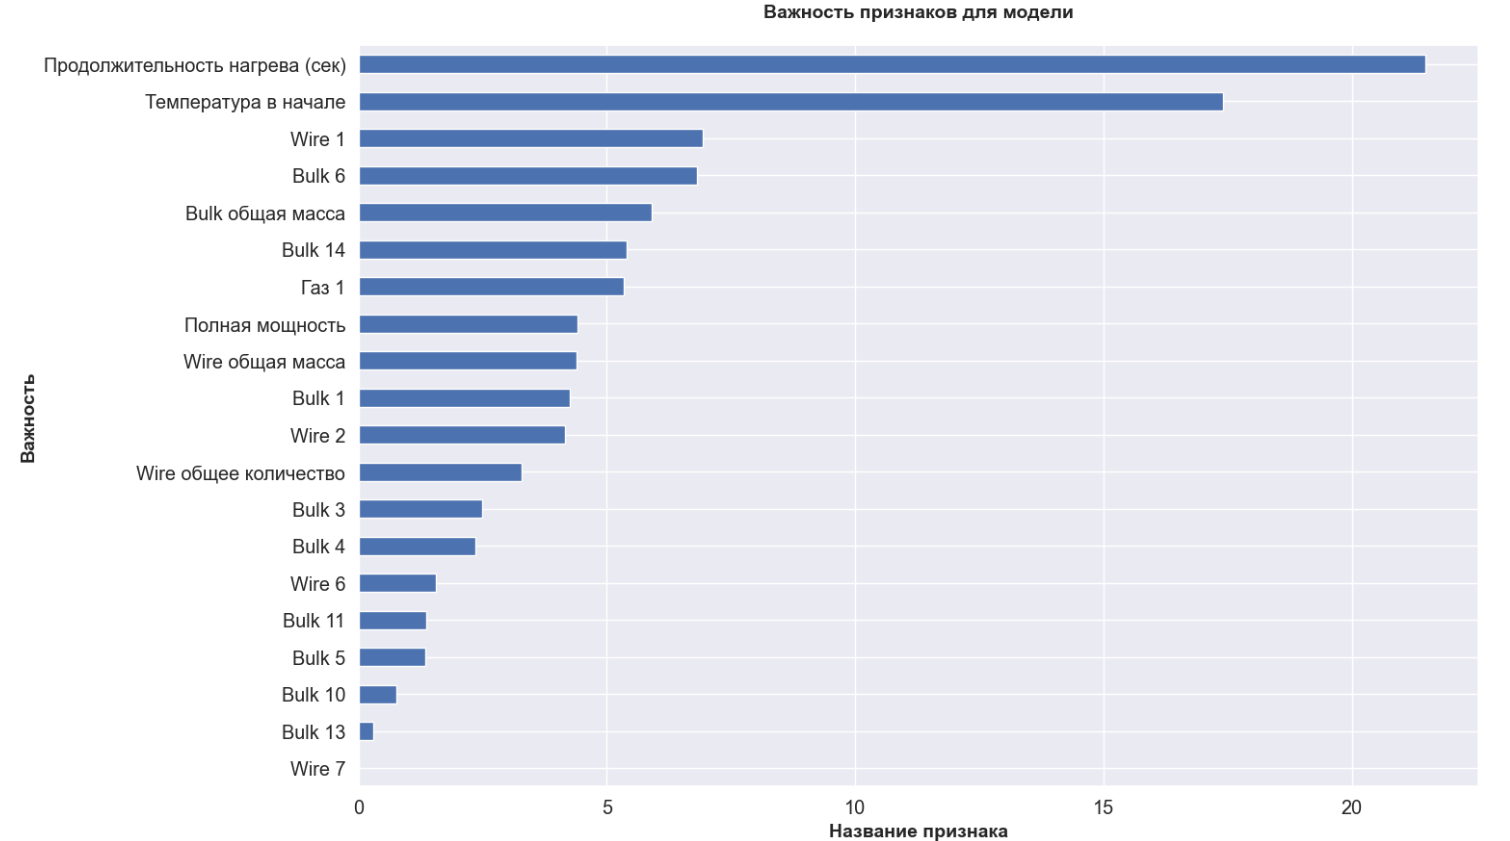

Наибольшую важность на принятые моделью решения оказывают следующие факторы:
    
- Продолжительность нагрева в секундах, 
- Первый замер температуры, 
- добавки `Wire 1` и `Bulk 6`,
- общая масса сыпучих добавок и добавка `Bulk 14`, 
- объем продуваемого через сплав газа, 
- Полная мощность, 
- общая масса и общее количество проволочных добавок, добавки `Bulk 1` и `Wire 2`,
- все остальные признаки, связанные с добавлением сыпучих и проволочных материалов не показали особой значимости, однако, вносят свой вклад в предсказания моделей, ими являются `Bulk 3`, `Bulk 4`, `Wire 6`, `Bulk 11`, `Bulk 5`, `Bulk 10` и `Bulk 13`,
- никакого вклада не оказала добавка `Wire 7`, поэтому в дальнейшем ее можно исключить с целью оптимизации и проанализировать метрики моделей без нее.

Стоит отметить, что высоких показателей важности фактически каждого из подаваемых в финальную модель признаков удалось достичь благодаря глубокой проработке корреляций и исключению избыточных или сильно взаимосвязанных колонок.

***

С учетом того, что в ходе работы были опробованы разные подходы к обработке данных, применены модели из разных семейств, осуществлялся подбор лучших гиперпараметров, был реализован отбор и моделирование данных - можно с уверенностью заявить, что полученная в результате модель позволяет достаточно эффективно решать поставленную перед нами задачу предсказания температуры сплава для минимизации расходов на электроэнергию.